In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import io 
from numpy import array
from numpy import hstack
from statsmodels.tools.eval_measures import mse,rmse,meanabs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime
#from tsmoothie.utils_func import sim_randomwalk
#from tsmoothie.smoother import *
import seaborn as sns
#import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
import optuna
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import graphviz
import optuna
from optuna.integration import KerasPruningCallback
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import BatchNormalization
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
import keras.backend as K
from keras.models import Model
from tensorflow.keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
import os
from matplotlib import pyplot
from keras.models import load_model
from tensorflow.keras import initializers

In [ ]:
# pip install optuna 

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_2015_realRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc1
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_2012_borrowedRH.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc2
# df1=pd.read_csv('gdrive/My Drive/Colab Notebooks/Industrial/Buffalo Viewpoint_outlier_NOX.csv',index_col='Date',parse_dates=True,na_values = ['NaN'],dayfirst=True) #sc3

In [ ]:
df1.columns

Index(['SO2 (ppb)', 'H2S (ppb)', 'THC (ppm)', 'RH %', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score'],
      dtype='object')

In [ ]:
def wind (df, radius):
  dff = df.copy()
  a = 'sin'
  b =  'cos'
  dff[a]=np.sin(dff[radius]*np.pi/180)
  dff[b]=np.cos(dff[radius]*np.pi/180)
  #dff[a] = dff[a] * dff[speed]
  #dff[b] = dff[b] * dff[speed]
  # dff.drop(columns=[radius],inplace = True)
  return dff


def lag_maker(df,column, num):
    for i in  range(num):
        df[column+ '-lag' + str(i+1)] = df[column].shift(i+1)
        df[column+ '-lag' + str(i+1)] = df[column+ '-lag' + str(i+1)]

def lag(df_reg, num):
    for i in c:
        lag_maker(df_reg,i,num)
        
    df_reg = df_reg.iloc[num:]
    return df_reg        




# df2 = lag(df1,1)
df1_w = wind(df1,'Wind Direction')

In [ ]:
df1_w= df1_w[[
              'SO2 (ppb)', #'H2S (ppb)', 'THC (ppm)',
              'RH %', 'T ( C)',
       'Std. Dev. of Wind Direction', 'Std. Dev. of Wind Speed',
       'Wind Direction', 'Wind Speed', 'Incoming Solar Rad. (W/m2)',
       'Precip. (mm)', 'hol', 'hour', 'dayofweek_num', 'Day-year', 'trend',
       'score' ]].copy()


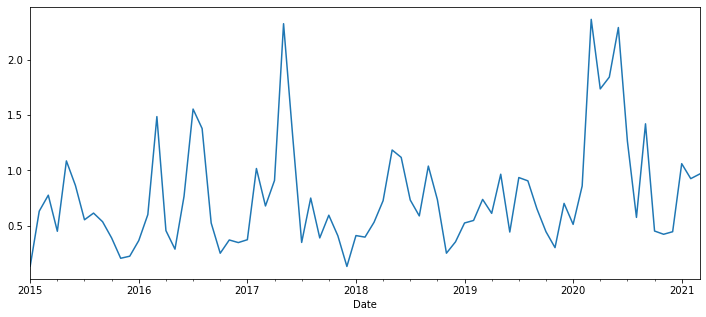

In [ ]:
df1_w['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5))

In [ ]:
df1_w.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'score'],
      dtype='object')

In [ ]:
avg = df1_w['score'].mean()
std = df1_w['score'].std()
len(df1_w[df1_w['score']<avg + 7*std])/len(df1_w)

0.996724298340828

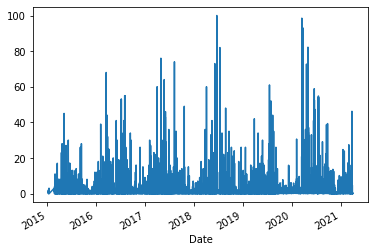

In [ ]:
# df1_w['SO2 (ppb)'].plot()
# df1_w['SO2 (ppb)'][df1_w['SO2 (ppb)']>60].plot.hist()
df1_w[df1_w['SO2 (ppb)'] > 100] = np.nan
df1_w.dropna(inplace = True)
df1_w['SO2 (ppb)'].plot()

In [ ]:
# # df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
# df_xg =  df1_w.copy()
# df_xg.drop(columns = ['score'], inplace = True)
# Y =  df_xg['SO2 (ppb)']
# Y = np.array(Y).reshape(-1,1)
# X = np.array( df_xg[ df_xg.columns[1:]])

In [ ]:
def objectivee(trial):    
        # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.00001, random_state = 42)
        param = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "booster": trial.suggest_categorical("booster", ["gbtree"]), #",,""gblinear" , "dart"
        "lambda": trial.suggest_loguniform("lambda", 0.01, 1000.0),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 1000.0),
        "score" : trial.suggest_float( 'score', avg + 1.5*std, avg + 7 * std )
        }

        # if param["booster"] == "gbtree" :
        #     param["n_estimators"] =  trial.suggest_int("n_estimators" , 1, 10000)

        if param["booster"] == "gbtree" or param["booster"] == "dart":
            param["max_depth"] = trial.suggest_int("max_depth", 1, 10)
            param["eta"] = trial.suggest_loguniform("eta", 0.1, 1000.0)
            param["gamma"] = trial.suggest_loguniform("gamma", 0.1, 1000.0)
            param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
            param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            param["rate_drop"] = trial.suggest_loguniform("rate_drop", 1e-3, 1.0)
            param["skip_drop"] = trial.suggest_loguniform("skip_drop", 1e-3, 1.0)

        df_xg =  df1_w[df1_w['score'] < param["score"]].copy()
        df_xg.drop(columns = ['score'], inplace = True)
        Y =  df_xg[aa]
        Y = np.array(Y).reshape(-1,1)
        X = np.array( df_xg[ df_xg.columns[1:]])
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 42)

        K = 5
        kf = KFold(n_splits=K)
        acc = 0 
        for train_index, test_index in kf.split( X_train):   
                X_tr, X_tes =  X_train[train_index],  X_train[test_index]
                y_tr, y_tes =  y_train[train_index],  y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
    
                dtrain = xgb.DMatrix(X_tra, label=y_tra)
                dval = xgb.DMatrix(X_val, label=y_val)
                dtest = xgb.DMatrix(X_tes, label=y_tes)
                
                pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
                bst = xgb.train(param, dtrain, evals=[(dval, "validation")],  early_stopping_rounds=30,
                                callbacks=[pruning_callback],
                               # verbose_eval = False
                               )
                preds = bst.predict(dtest)
                accuracy = mean_squared_error(y_tes, preds)
                acc = acc + accuracy/K
                
        print(acc)
        return acc    

In [ ]:
study2 = optuna.create_study()
study2.optimize(objectivee, n_trials=10000)
print(study2.best_trial)
df_results2 = study2.trials_dataframe()
df_results2.to_csv('gdrive/My Drive/Colab Notebooks/results/XGB_Buffalo Viewpoint_OT_SO2_2015_real_RH_HP_hourly.csv')

[I 2021-05-16 04:39:25,522] A new study created in memory with name: no-name-239cfa44-6d86-4075-bd48-2fe0aed00549


[0]	validation-rmse:16.5338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:445.997
[2]	validation-rmse:12243.8
[3]	validation-rmse:336196
[4]	validation-rmse:9.2314e+06
[5]	validation-rmse:2.53479e+08
[6]	validation-rmse:6.96012e+09
[7]	validation-rmse:1.91114e+11
[8]	validation-rmse:5.24767e+12
[9]	validation-rmse:1.44092e+14
[0]	validation-rmse:15.6728
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:419.203
[2]	validation-rmse:11512
[3]	validation-rmse:316098
[4]	validation-rmse:8.67948e+06
[5]	validation-rmse:2.38323e+08
[6]	validation-rmse:6.54393e+09
[7]	validation-rmse:1.79685e+11
[8]	validation-rmse:4.93382e+12
[9]	validation-rmse:1.35474e+14
[0]	validation-rmse:15.5317
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:418.654
[2]	validation-rmse:11494.4
[3]	validation-rmse:315620
[4]	validation-rmse:8.66641e+06
[5]	validation-rmse:2.37966e+08
[6]	validation-rmse:6.53416e+09
[

[I 2021-05-16 04:39:26,168] Trial 0 finished with value: 1.8061532287763574e+28 and parameters: {'booster': 'gbtree', 'lambda': 0.07763427144422838, 'alpha': 31.79310466316893, 'score': 36.785139220301524, 'max_depth': 1, 'eta': 28.4588485901265, 'gamma': 128.1985947877947, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 1.8061532287763574e+28.


1.8061532287763574e+28
[0]	validation-rmse:534.239
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:204483
[2]	validation-rmse:8.06468e+07
[3]	validation-rmse:2.9382e+10
[4]	validation-rmse:1.17356e+13
[5]	validation-rmse:4.80106e+15
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:477.757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:178023
[2]	validation-rmse:6.94939e+07
[3]	validation-rmse:2.77209e+10
[4]	validation-rmse:1.11692e+13
[5]	validation-rmse:4.5193e+15
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[8]	validation-rmse:inf
[9]	validation-rmse:inf
[0]	validation-rmse:485.194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:177243
[2]	validation-rmse:6.17375e+07
[3]	validation-rmse:2.32631e+10
[4]	validation-rmse:9.04229e+12
[5]	validation-rmse:3.62593e+15
[6]	validation-rmse:inf
[7]	validation-rmse:inf
[

[I 2021-05-16 04:39:28,238] Trial 1 finished with value: 1.9507167524925304e+51 and parameters: {'booster': 'gbtree', 'lambda': 114.89978761822105, 'alpha': 0.1007890010862768, 'score': 37.599073235379485, 'max_depth': 8, 'eta': 478.2987164137771, 'gamma': 1.0059657995969413, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 1.8061532287763574e+28.


1.9507167524925304e+51
[0]	validation-rmse:2.5605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.49591
[2]	validation-rmse:2.43729
[3]	validation-rmse:2.42062
[4]	validation-rmse:2.40054
[5]	validation-rmse:2.38394
[6]	validation-rmse:2.38175
[7]	validation-rmse:2.38117
[8]	validation-rmse:2.37297
[9]	validation-rmse:2.37565
[0]	validation-rmse:2.46081
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40527
[2]	validation-rmse:2.366
[3]	validation-rmse:2.35429
[4]	validation-rmse:2.34937
[5]	validation-rmse:2.35581
[6]	validation-rmse:2.34871
[7]	validation-rmse:2.36175
[8]	validation-rmse:2.35531
[9]	validation-rmse:2.35933
[0]	validation-rmse:2.70211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.64821
[2]	validation-rmse:2.6146
[3]	validation-rmse:2.60394
[4]	validation-rmse:2.59132
[5]	validation-rmse:2.59024
[6]	validation-rmse:2.58534
[7]	validation-rmse:2.59229
[8]	vali

[I 2021-05-16 04:39:31,300] Trial 2 finished with value: 8.857267527965444 and parameters: {'booster': 'gbtree', 'lambda': 0.3294305320425301, 'alpha': 0.01176411941078342, 'score': 35.09962625760134, 'max_depth': 9, 'eta': 0.18522823424708518, 'gamma': 0.7917492197191118, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 8.857267527965444.


8.857267527965444
[0]	validation-rmse:2.5747
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.56603
[2]	validation-rmse:2.55476
[3]	validation-rmse:2.55416
[4]	validation-rmse:2.55125
[5]	validation-rmse:2.55713
[6]	validation-rmse:2.54665
[7]	validation-rmse:2.55187
[8]	validation-rmse:2.54252
[9]	validation-rmse:2.53558
[0]	validation-rmse:2.32424
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31516
[2]	validation-rmse:2.3097
[3]	validation-rmse:2.31108
[4]	validation-rmse:2.30482
[5]	validation-rmse:2.3
[6]	validation-rmse:2.29615
[7]	validation-rmse:2.29092
[8]	validation-rmse:2.28849
[9]	validation-rmse:2.29182
[0]	validation-rmse:2.45264
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.43292
[2]	validation-rmse:2.45127
[3]	validation-rmse:2.42302
[4]	validation-rmse:2.42501
[5]	validation-rmse:2.42724
[6]	validation-rmse:2.42049
[7]	validation-rmse:2.40957
[8]	validation-

[I 2021-05-16 04:39:31,931] Trial 3 finished with value: 6.473710899239494 and parameters: {'booster': 'gbtree', 'lambda': 103.14153782992803, 'alpha': 27.15855437175656, 'score': 14.844866531433958, 'max_depth': 1, 'eta': 1.9850751697790507, 'gamma': 6.376611890774914, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 6.473710899239494.


6.473710899239494
[0]	validation-rmse:27.2112
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1312.49
[2]	validation-rmse:64094.4
[3]	validation-rmse:3.12974e+06
[4]	validation-rmse:1.52826e+08
[5]	validation-rmse:7.46253e+09
[6]	validation-rmse:3.64397e+11
[7]	validation-rmse:1.77936e+13
[8]	validation-rmse:8.68867e+14
[9]	validation-rmse:4.2427e+16
[0]	validation-rmse:23.8791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1152.23
[2]	validation-rmse:56263.7
[3]	validation-rmse:2.74727e+06
[4]	validation-rmse:1.34146e+08
[5]	validation-rmse:6.55016e+09
[6]	validation-rmse:3.19835e+11
[7]	validation-rmse:1.56171e+13
[8]	validation-rmse:7.62563e+14
[9]	validation-rmse:3.72349e+16
[0]	validation-rmse:24.3518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1178.49
[2]	validation-rmse:57543.7
[3]	validation-rmse:2.80988e+06
[4]	validation-rmse:1.37208e+08
[5]	validation-rmse:6.69992e+0

[I 2021-05-16 04:39:32,564] Trial 4 finished with value: 1.572657630004125e+33 and parameters: {'booster': 'gbtree', 'lambda': 0.4955889602194286, 'alpha': 541.4912982311924, 'score': 25.10183997792348, 'max_depth': 1, 'eta': 49.83564019965832, 'gamma': 67.75459122652012, 'grow_policy': 'depthwise'}. Best is trial 3 with value: 6.473710899239494.


1.572657630004125e+33


[I 2021-05-16 04:39:32,680] Trial 5 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:4.52085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:6.85729
[2]	validation-rmse:12.5165
[3]	validation-rmse:23.8337
[4]	validation-rmse:47.0856
[5]	validation-rmse:92.8011
[6]	validation-rmse:183.945
[7]	validation-rmse:369.148
[8]	validation-rmse:731.94
[9]	validation-rmse:1447.31
[0]	validation-rmse:4.61758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:6.33152
[2]	validation-rmse:12.4777
[3]	validation-rmse:22.4591
[4]	validation-rmse:44.8683
[5]	validation-rmse:86.8122
[6]	validation-rmse:171.814
[7]	validation-rmse:336.84
[8]	validation-rmse:664.053
[9]	validation-rmse:1306.11
[0]	validation-rmse:4.39526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:6.68306
[2]	validation-rmse:13.3783
[3]	validation-rmse:22.5274
[4]	validation-rmse:45.8039
[5]	validation-rmse:87.571
[6]	validation-rmse:174.816
[7]	validation-rmse:342.411
[8]	validation-rmse:677.786
[9

[I 2021-05-16 04:39:34,540] Trial 6 finished with value: 1833501.6665467399 and parameters: {'booster': 'gbtree', 'lambda': 0.017939218824538836, 'alpha': 0.019145143745320413, 'score': 27.802850201221297, 'max_depth': 6, 'eta': 2.9829160242241204, 'gamma': 7.262903120883845, 'grow_policy': 'lossguide'}. Best is trial 3 with value: 6.473710899239494.


1833501.6665467399
[0]	validation-rmse:2.98025
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.93539
[2]	validation-rmse:2.90111
[3]	validation-rmse:2.87053
[4]	validation-rmse:2.86453
[5]	validation-rmse:2.85969
[6]	validation-rmse:2.86218
[7]	validation-rmse:2.8595
[8]	validation-rmse:2.85371
[9]	validation-rmse:2.84211
[0]	validation-rmse:2.52802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48216
[2]	validation-rmse:2.44202
[3]	validation-rmse:2.41423
[4]	validation-rmse:2.4044
[5]	validation-rmse:2.39746
[6]	validation-rmse:2.39816
[7]	validation-rmse:2.38554
[8]	validation-rmse:2.38321
[9]	validation-rmse:2.37775
[0]	validation-rmse:2.67384
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.62916
[2]	validation-rmse:2.59444
[3]	validation-rmse:2.5347
[4]	validation-rmse:2.50936
[5]	validation-rmse:2.49574
[6]	validation-rmse:2.49824
[7]	validation-rmse:2.50015
[8]	validat

[I 2021-05-16 04:39:35,779] Trial 7 finished with value: 6.295609158258282 and parameters: {'booster': 'gbtree', 'lambda': 0.1012360692144411, 'alpha': 61.79688311925676, 'score': 19.21691191050553, 'max_depth': 4, 'eta': 0.5627862388197099, 'gamma': 131.89694347552447, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 6.295609158258282.


6.295609158258282


[I 2021-05-16 04:39:35,850] Trial 8 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:35,942] Trial 9 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.69132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.67047
[2]	validation-rmse:2.64961
[3]	validation-rmse:2.63867
[4]	validation-rmse:2.62598
[5]	validation-rmse:2.61734
[6]	validation-rmse:2.60671
[7]	validation-rmse:2.59899
[8]	validation-rmse:2.59385
[9]	validation-rmse:2.58863
[0]	validation-rmse:2.41991
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.39961
[2]	validation-rmse:2.38829
[3]	validation-rmse:2.37834
[4]	validation-rmse:2.36505
[5]	validation-rmse:2.35685
[6]	validation-rmse:2.34993
[7]	validation-rmse:2.34483
[8]	validation-rmse:2.33592
[9]	validation-rmse:2.33173
[0]	validation-rmse:2.73779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.72214
[2]	validation-rmse:2.70411
[3]	validation-rmse:2.69316
[4]	validation-rmse:2.68067
[5]	validation-rmse:2.66891
[6]	validation-rmse:2.66104
[7]	validation-rmse:2.65292
[8]	validation-rmse:2.64662

[I 2021-05-16 04:39:37,163] Trial 10 finished with value: 6.729589822252265 and parameters: {'booster': 'gbtree', 'lambda': 4.536649323859599, 'alpha': 943.2496533014346, 'score': 18.57951501356914, 'max_depth': 4, 'eta': 0.14721254960714983, 'gamma': 529.0805309349953, 'grow_policy': 'lossguide'}. Best is trial 7 with value: 6.295609158258282.


6.729589822252265
[0]	validation-rmse:2.53041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47665
[2]	validation-rmse:2.47839
[3]	validation-rmse:2.45997
[4]	validation-rmse:2.43364
[5]	validation-rmse:2.43407
[6]	validation-rmse:2.43067
[7]	validation-rmse:2.44417
[8]	validation-rmse:2.43686
[9]	validation-rmse:2.44918
[0]	validation-rmse:2.34406
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32531
[2]	validation-rmse:2.30581
[3]	validation-rmse:2.31169
[4]	validation-rmse:2.30735
[5]	validation-rmse:2.30251
[6]	validation-rmse:2.29794
[7]	validation-rmse:2.29732
[8]	validation-rmse:2.29398
[9]	validation-rmse:2.29807
[0]	validation-rmse:2.48903
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46812
[2]	validation-rmse:2.43932
[3]	validation-rmse:2.43382
[4]	validation-rmse:2.44536
[5]	validation-rmse:2.43123
[6]	validation-rmse:2.43604
[7]	validation-rmse:2.4305
[8]	valida

[I 2021-05-16 04:39:38,151] Trial 11 finished with value: 5.8893684729318085 and parameters: {'booster': 'gbtree', 'lambda': 39.68875249125597, 'alpha': 40.30308688311827, 'score': 13.064271092916544, 'max_depth': 3, 'eta': 1.7267278219144457, 'gamma': 10.663814654794598, 'grow_policy': 'depthwise'}. Best is trial 11 with value: 5.8893684729318085.


5.8893684729318085
[0]	validation-rmse:2.63208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.60509
[2]	validation-rmse:2.58269
[3]	validation-rmse:2.58271
[4]	validation-rmse:2.58273
[5]	validation-rmse:2.58273
[6]	validation-rmse:2.58273
[7]	validation-rmse:2.58274
[8]	validation-rmse:2.58274
[9]	validation-rmse:2.58274
[0]	validation-rmse:2.42713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40026
[2]	validation-rmse:2.38208
[3]	validation-rmse:2.38206
[4]	validation-rmse:2.38205
[5]	validation-rmse:2.38205
[6]	validation-rmse:2.38205
[7]	validation-rmse:2.38205
[8]	validation-rmse:2.38205
[9]	validation-rmse:2.38205
[0]	validation-rmse:2.73822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.70213
[2]	validation-rmse:2.67663
[3]	validation-rmse:2.65772
[4]	validation-rmse:2.64998
[5]	validation-rmse:2.64998
[6]	validation-rmse:2.64998
[7]	validation-rmse:2.64998
[8]	vali

[I 2021-05-16 04:39:39,122] Trial 12 finished with value: 5.644832309587044 and parameters: {'booster': 'gbtree', 'lambda': 23.817102311432873, 'alpha': 68.4802357948191, 'score': 13.19795999499868, 'max_depth': 3, 'eta': 0.6631206084396001, 'gamma': 762.5192665867421, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 5.644832309587044.


5.644832309587044


[I 2021-05-16 04:39:39,193] Trial 13 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.76066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.71887
[2]	validation-rmse:2.6929
[3]	validation-rmse:2.67598
[4]	validation-rmse:2.66505
[5]	validation-rmse:2.65624
[6]	validation-rmse:2.64096
[7]	validation-rmse:2.6373
[8]	validation-rmse:2.63024
[9]	validation-rmse:2.62722
[0]	validation-rmse:2.49104
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45886
[2]	validation-rmse:2.43819
[3]	validation-rmse:2.42235
[4]	validation-rmse:2.41386
[5]	validation-rmse:2.39939
[6]	validation-rmse:2.39521
[7]	validation-rmse:2.39035
[8]	validation-rmse:2.37997
[9]	validation-rmse:2.37535
[0]	validation-rmse:2.99601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.95759
[2]	validation-rmse:2.9331
[3]	validation-rmse:2.91791
[4]	validation-rmse:2.90566
[5]	validation-rmse:2.8896
[6]	validation-rmse:2.88414
[7]	validation-rmse:2.87487
[8]	validation-rmse:2.86662
[9]

[I 2021-05-16 04:39:40,224] Trial 14 finished with value: 6.209009824608842 and parameters: {'booster': 'gbtree', 'lambda': 930.4566342485596, 'alpha': 171.84894032426112, 'score': 17.978375670169243, 'max_depth': 3, 'eta': 0.5769656935749936, 'gamma': 0.15256789002958338, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 5.644832309587044.


6.209009824608842


[I 2021-05-16 04:39:40,296] Trial 15 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:40,380] Trial 16 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:40,451] Trial 17 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.57171
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50416
[2]	validation-rmse:2.45646
[3]	validation-rmse:2.42747
[4]	validation-rmse:2.39985
[5]	validation-rmse:2.38337
[6]	validation-rmse:2.37616
[7]	validation-rmse:2.35996
[8]	validation-rmse:2.34626
[9]	validation-rmse:2.34129
[0]	validation-rmse:2.38198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31811
[2]	validation-rmse:2.26671
[3]	validation-rmse:2.23611
[4]	validation-rmse:2.20665
[5]	validation-rmse:2.19447
[6]	validation-rmse:2.18363
[7]	validation-rmse:2.17777
[8]	validation-rmse:2.16589
[9]	validation-rmse:2.16804
[0]	validation-rmse:2.67162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.59797
[2]	validation-rmse:2.55774
[3]	validation-rmse:2.53035
[4]	validation-rmse:2.50738
[5]	validation-rmse:2.49258
[6]	validation-rmse:2.47811
[7]	validation-rmse:2.46932
[8]	validation-rmse:2.46277

[I 2021-05-16 04:39:41,992] Trial 18 finished with value: 6.356451671668992 and parameters: {'booster': 'gbtree', 'lambda': 17.59391949391021, 'alpha': 12.61259704993776, 'score': 22.331887006677135, 'max_depth': 5, 'eta': 0.24013898559201355, 'gamma': 2.7814897970788537, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 5.644832309587044.


6.356451671668992


[I 2021-05-16 04:39:42,066] Trial 19 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:42,135] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:42,205] Trial 21 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.49795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46448
[2]	validation-rmse:2.44595
[3]	validation-rmse:2.4247
[4]	validation-rmse:2.40385
[5]	validation-rmse:2.39332
[6]	validation-rmse:2.38861
[7]	validation-rmse:2.38708
[8]	validation-rmse:2.38815
[9]	validation-rmse:2.38637
[0]	validation-rmse:2.35546
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31812
[2]	validation-rmse:2.3094
[3]	validation-rmse:2.2833
[4]	validation-rmse:2.27199
[5]	validation-rmse:2.26614
[6]	validation-rmse:2.26543
[7]	validation-rmse:2.26648
[8]	validation-rmse:2.26119
[9]	validation-rmse:2.25943
[0]	validation-rmse:2.64247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.61176
[2]	validation-rmse:2.59771
[3]	validation-rmse:2.57733
[4]	validation-rmse:2.557
[5]	validation-rmse:2.55488
[6]	validation-rmse:2.54995
[7]	validation-rmse:2.54596
[8]	validation-rmse:2.5423
[9]	v

[I 2021-05-16 04:39:43,217] Trial 22 finished with value: 6.419402757565392 and parameters: {'booster': 'gbtree', 'lambda': 9.754637328880412, 'alpha': 86.14912812357105, 'score': 17.324670329181913, 'max_depth': 3, 'eta': 0.9463542420875739, 'gamma': 0.22427035969498835, 'grow_policy': 'depthwise'}. Best is trial 12 with value: 5.644832309587044.


6.419402757565392
[0]	validation-rmse:2.61281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54281
[2]	validation-rmse:2.51885
[3]	validation-rmse:2.4973
[4]	validation-rmse:2.48377
[5]	validation-rmse:2.4873
[6]	validation-rmse:2.49397
[7]	validation-rmse:2.47935
[8]	validation-rmse:2.46705
[9]	validation-rmse:2.46944
[0]	validation-rmse:2.53209
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4624
[2]	validation-rmse:2.43029
[3]	validation-rmse:2.40389
[4]	validation-rmse:2.37883
[5]	validation-rmse:2.36983
[6]	validation-rmse:2.36961
[7]	validation-rmse:2.37168
[8]	validation-rmse:2.3681
[9]	validation-rmse:2.36743
[0]	validation-rmse:2.61838
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.5675
[2]	validation-rmse:2.5365
[3]	validation-rmse:2.51726
[4]	validation-rmse:2.51499
[5]	validation-rmse:2.50197
[6]	validation-rmse:2.49244
[7]	validation-rmse:2.4879
[8]	validation-r

[I 2021-05-16 04:39:45,025] Trial 23 finished with value: 5.419364963467919 and parameters: {'booster': 'gbtree', 'lambda': 2.639738394897501, 'alpha': 21.50654985723826, 'score': 12.641004626403411, 'max_depth': 6, 'eta': 0.40578641383314534, 'gamma': 4.5257777275348845, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.419364963467919
[0]	validation-rmse:2.41816
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36657
[2]	validation-rmse:2.32568
[3]	validation-rmse:2.2992
[4]	validation-rmse:2.28386
[5]	validation-rmse:2.2617
[6]	validation-rmse:2.25049
[7]	validation-rmse:2.23587
[8]	validation-rmse:2.23078
[9]	validation-rmse:2.22471
[0]	validation-rmse:2.21254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15574
[2]	validation-rmse:2.11604
[3]	validation-rmse:2.08506
[4]	validation-rmse:2.06712
[5]	validation-rmse:2.05679
[6]	validation-rmse:2.04545
[7]	validation-rmse:2.03469
[8]	validation-rmse:2.02759
[9]	validation-rmse:2.0256
[0]	validation-rmse:2.47054
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41497
[2]	validation-rmse:2.38288
[3]	validation-rmse:2.35082
[4]	validation-rmse:2.33435
[5]	validation-rmse:2.31916
[6]	validation-rmse:2.29848
[7]	validation-rmse:2.28962
[8]	validati

[I 2021-05-16 04:39:46,893] Trial 24 finished with value: 5.489350753830561 and parameters: {'booster': 'gbtree', 'lambda': 1.5746325656909355, 'alpha': 17.34552448045594, 'score': 13.594161335801305, 'max_depth': 6, 'eta': 0.23570644805736907, 'gamma': 3.1604145538104182, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.489350753830561


[I 2021-05-16 04:39:46,990] Trial 25 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:47,081] Trial 26 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.36904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29752
[2]	validation-rmse:2.27661
[3]	validation-rmse:2.2638
[4]	validation-rmse:2.26139
[5]	validation-rmse:2.27303
[6]	validation-rmse:2.27176
[7]	validation-rmse:2.25197
[8]	validation-rmse:2.25747
[9]	validation-rmse:2.26121
[0]	validation-rmse:2.2915
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22639
[2]	validation-rmse:2.17503
[3]	validation-rmse:2.15845
[4]	validation-rmse:2.13498
[5]	validation-rmse:2.1235
[6]	validation-rmse:2.12132
[7]	validation-rmse:2.12271
[8]	validation-rmse:2.11703
[9]	validation-rmse:2.1068
[0]	validation-rmse:2.5284
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46419
[2]	validation-rmse:2.4506
[3]	validation-rmse:2.44657
[4]	validation-rmse:2.43766
[5]	validation-rmse:2.43847
[6]	validation-rmse:2.44028
[7]	validation-rmse:2.44038
[8]	validation-rmse:2.43934
[9]	v

[I 2021-05-16 04:39:49,235] Trial 27 finished with value: 5.9055632042282244 and parameters: {'booster': 'gbtree', 'lambda': 0.7950923896944152, 'alpha': 1.7790972277122388, 'score': 14.765405883980298, 'max_depth': 7, 'eta': 0.31791373986859545, 'gamma': 4.5909733246183855, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.9055632042282244


[I 2021-05-16 04:39:49,321] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,423] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,509] Trial 30 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,593] Trial 31 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,668] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,769] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,852] Trial 34 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:49,948] Trial 35 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3221
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30038
[2]	validation-rmse:2.28883
[3]	validation-rmse:2.27973
[4]	validation-rmse:2.2699
[5]	validation-rmse:2.26651
[6]	validation-rmse:2.26216
[7]	validation-rmse:2.25879
[8]	validation-rmse:2.25177
[9]	validation-rmse:2.25181
[0]	validation-rmse:2.25851
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24013
[2]	validation-rmse:2.22882
[3]	validation-rmse:2.2213
[4]	validation-rmse:2.21068
[5]	validation-rmse:2.20461
[6]	validation-rmse:2.19758
[7]	validation-rmse:2.19383
[8]	validation-rmse:2.1908
[9]	validation-rmse:2.18878
[0]	validation-rmse:2.39541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36896
[2]	validation-rmse:2.35983
[3]	validation-rmse:2.35166
[4]	validation-rmse:2.3396
[5]	validation-rmse:2.33408
[6]	validation-rmse:2.32944
[7]	validation-rmse:2.32363
[8]	validation-rmse:2.31996
[9]	

[I 2021-05-16 04:39:50,606] Trial 36 finished with value: 6.075645419105829 and parameters: {'booster': 'gbtree', 'lambda': 122.21093491236901, 'alpha': 22.262301795342445, 'score': 14.101595862556753, 'max_depth': 1, 'eta': 0.6594555514532632, 'gamma': 51.6358980319268, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


6.075645419105829


[I 2021-05-16 04:39:50,691] Trial 37 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:50,795] Trial 38 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:50,870] Trial 39 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:50,984] Trial 40 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:51,075] Trial 41 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.45879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40016
[2]	validation-rmse:2.38513
[3]	validation-rmse:2.38109
[4]	validation-rmse:2.39262
[5]	validation-rmse:2.41564
[6]	validation-rmse:2.44275
[7]	validation-rmse:2.44868
[8]	validation-rmse:2.44283
[9]	validation-rmse:2.43689
[0]	validation-rmse:2.27737
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21449
[2]	validation-rmse:2.19639
[3]	validation-rmse:2.18346
[4]	validation-rmse:2.17359
[5]	validation-rmse:2.17344
[6]	validation-rmse:2.16208
[7]	validation-rmse:2.16135
[8]	validation-rmse:2.15473
[9]	validation-rmse:2.15404
[0]	validation-rmse:2.41208
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36168
[2]	validation-rmse:2.32231
[3]	validation-rmse:2.30968
[4]	validation-rmse:2.30369
[5]	validation-rmse:2.30094
[6]	validation-rmse:2.30016
[7]	validation-rmse:2.28757
[8]	validation-rmse:2.28593

[I 2021-05-16 04:39:53,224] Trial 42 finished with value: 5.8424839049673745 and parameters: {'booster': 'gbtree', 'lambda': 0.9284878269126232, 'alpha': 0.4482853151213999, 'score': 12.6479858803729, 'max_depth': 7, 'eta': 0.3579323901743894, 'gamma': 4.3488030576183085, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.8424839049673745
[0]	validation-rmse:2.45956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35345
[2]	validation-rmse:2.3179
[3]	validation-rmse:2.31113
[4]	validation-rmse:2.3026
[5]	validation-rmse:2.28132
[6]	validation-rmse:2.2731
[7]	validation-rmse:2.2593
[8]	validation-rmse:2.26368
[9]	validation-rmse:2.26318
[0]	validation-rmse:2.37122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28972
[2]	validation-rmse:2.25833
[3]	validation-rmse:2.24439
[4]	validation-rmse:2.23548
[5]	validation-rmse:2.22785
[6]	validation-rmse:2.21623
[7]	validation-rmse:2.20862
[8]	validation-rmse:2.21036
[9]	validation-rmse:2.21284
[0]	validation-rmse:2.55336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48033
[2]	validation-rmse:2.45216
[3]	validation-rmse:2.43097
[4]	validation-rmse:2.41297
[5]	validation-rmse:2.38507
[6]	validation-rmse:2.37924
[7]	validation-rmse:2.3817
[8]	validatio

[I 2021-05-16 04:39:55,351] Trial 43 finished with value: 5.643442661111151 and parameters: {'booster': 'gbtree', 'lambda': 3.80297826483019, 'alpha': 0.4429097212207361, 'score': 12.750680027530045, 'max_depth': 7, 'eta': 0.3753981702639014, 'gamma': 7.3586539720085655, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.643442661111151
[0]	validation-rmse:2.44453
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37274
[2]	validation-rmse:2.34331
[3]	validation-rmse:2.32224
[4]	validation-rmse:2.30882
[5]	validation-rmse:2.29408
[6]	validation-rmse:2.30242
[7]	validation-rmse:2.29636
[8]	validation-rmse:2.29388
[9]	validation-rmse:2.27831
[0]	validation-rmse:2.31358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23592
[2]	validation-rmse:2.21799
[3]	validation-rmse:2.20102
[4]	validation-rmse:2.16879
[5]	validation-rmse:2.1622
[6]	validation-rmse:2.15608
[7]	validation-rmse:2.14173
[8]	validation-rmse:2.14347
[9]	validation-rmse:2.13294
[0]	validation-rmse:2.62134
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54966
[2]	validation-rmse:2.51198
[3]	validation-rmse:2.49601
[4]	validation-rmse:2.47544
[5]	validation-rmse:2.46843
[6]	validation-rmse:2.43328
[7]	validation-rmse:2.42941
[8]	valida

[I 2021-05-16 04:39:57,486] Trial 44 finished with value: 5.772162751056976 and parameters: {'booster': 'gbtree', 'lambda': 4.330136069155989, 'alpha': 0.12894495294334068, 'score': 13.812918315443083, 'max_depth': 7, 'eta': 0.4372074807692056, 'gamma': 2.286702560232885, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.772162751056976


[I 2021-05-16 04:39:57,598] Trial 45 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:57,712] Trial 46 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:57,808] Trial 47 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:57,899] Trial 48 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:58,000] Trial 49 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:58,115] Trial 50 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:39:58,210] Trial 51 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.36214
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26737
[2]	validation-rmse:2.24575
[3]	validation-rmse:2.24429
[4]	validation-rmse:2.22542
[5]	validation-rmse:2.21808
[6]	validation-rmse:2.2097
[7]	validation-rmse:2.21281
[8]	validation-rmse:2.21223
[9]	validation-rmse:2.2174
[0]	validation-rmse:2.29055
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22415
[2]	validation-rmse:2.20546
[3]	validation-rmse:2.19854
[4]	validation-rmse:2.20651
[5]	validation-rmse:2.19984
[6]	validation-rmse:2.2022
[7]	validation-rmse:2.20529
[8]	validation-rmse:2.18318
[9]	validation-rmse:2.18051
[0]	validation-rmse:2.51577
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47681
[2]	validation-rmse:2.45315
[3]	validation-rmse:2.43146
[4]	validation-rmse:2.42318
[5]	validation-rmse:2.42313
[6]	validation-rmse:2.38929
[7]	validation-rmse:2.39481
[8]	validation-rmse:2.38961
[9

[I 2021-05-16 04:40:00,001] Trial 52 finished with value: 5.671975608551154 and parameters: {'booster': 'gbtree', 'lambda': 1.0867310484607526, 'alpha': 0.4216080386863124, 'score': 13.482805564785341, 'max_depth': 6, 'eta': 0.3962039073317636, 'gamma': 3.1722358127718895, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.671975608551154


[I 2021-05-16 04:40:00,091] Trial 53 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.4519
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45209
[2]	validation-rmse:2.47597
[3]	validation-rmse:2.48378


[I 2021-05-16 04:40:00,305] Trial 54 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 04:40:00,386] Trial 55 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:00,475] Trial 56 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.52183
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:40:00,614] Trial 57 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:40:00,693] Trial 58 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:00,784] Trial 59 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:00,887] Trial 60 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.49075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41363
[2]	validation-rmse:2.37245
[3]	validation-rmse:2.35407
[4]	validation-rmse:2.34354
[5]	validation-rmse:2.35027
[6]	validation-rmse:2.34592
[7]	validation-rmse:2.36017
[8]	validation-rmse:2.34007
[9]	validation-rmse:2.34316
[0]	validation-rmse:2.29391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23109
[2]	validation-rmse:2.20721
[3]	validation-rmse:2.19145
[4]	validation-rmse:2.18467
[5]	validation-rmse:2.17125
[6]	validation-rmse:2.17336
[7]	validation-rmse:2.15426
[8]	validation-rmse:2.15978
[9]	validation-rmse:2.14394
[0]	validation-rmse:2.26298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21078
[2]	validation-rmse:2.17431
[3]	validation-rmse:2.15087
[4]	validation-rmse:2.14676
[5]	validation-rmse:2.13888
[6]	validation-rmse:2.12622
[7]	validation-rmse:2.12899
[8]	validation-rmse:2.12262

[I 2021-05-16 04:40:03,019] Trial 61 finished with value: 5.846319389532786 and parameters: {'booster': 'gbtree', 'lambda': 0.9786472750852737, 'alpha': 0.47236542158372646, 'score': 12.69628012977829, 'max_depth': 7, 'eta': 0.37560654079772254, 'gamma': 3.564926985159466, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.846319389532786
[0]	validation-rmse:2.55703
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:40:03,154] Trial 62 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:40:03,256] Trial 63 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.56208
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:40:03,392] Trial 64 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:40:03,481] Trial 65 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:03,584] Trial 66 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.44262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37834
[2]	validation-rmse:2.34542
[3]	validation-rmse:2.31937
[4]	validation-rmse:2.32376
[5]	validation-rmse:2.30903
[6]	validation-rmse:2.32012
[7]	validation-rmse:2.31869
[8]	validation-rmse:2.31905
[9]	validation-rmse:2.31395
[0]	validation-rmse:2.19581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13533
[2]	validation-rmse:2.10423
[3]	validation-rmse:2.0837
[4]	validation-rmse:2.07983
[5]	validation-rmse:2.07449
[6]	validation-rmse:2.0727
[7]	validation-rmse:2.07655
[8]	validation-rmse:2.07418
[9]	validation-rmse:2.07353
[0]	validation-rmse:2.62251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54694
[2]	validation-rmse:2.50861
[3]	validation-rmse:2.49356
[4]	validation-rmse:2.47876
[5]	validation-rmse:2.46065
[6]	validation-rmse:2.45256
[7]	validation-rmse:2.45512
[8]	validation-rmse:2.44255
[

[I 2021-05-16 04:40:05,424] Trial 67 finished with value: 5.952351626980741 and parameters: {'booster': 'gbtree', 'lambda': 1.9194626554386243, 'alpha': 0.8608163544322505, 'score': 16.12091879771601, 'max_depth': 6, 'eta': 0.2694864447463956, 'gamma': 5.4622135850525355, 'grow_policy': 'depthwise'}. Best is trial 23 with value: 5.419364963467919.


5.952351626980741


[I 2021-05-16 04:40:05,511] Trial 68 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:05,604] Trial 69 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:05,709] Trial 70 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:05,805] Trial 71 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:05,899] Trial 72 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.51896
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:40:06,034] Trial 73 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:40:06,137] Trial 74 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:06,225] Trial 75 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:06,320] Trial 76 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:06,411] Trial 77 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:06,477] Trial 78 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.45925
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40738
[2]	validation-rmse:2.3615
[3]	validation-rmse:2.33158
[4]	validation-rmse:2.316
[5]	validation-rmse:2.29937
[6]	validation-rmse:2.28563
[7]	validation-rmse:2.27825
[8]	validation-rmse:2.28044
[9]	validation-rmse:2.27694
[0]	validation-rmse:2.31555
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26491
[2]	validation-rmse:2.23188
[3]	validation-rmse:2.20901
[4]	validation-rmse:2.19324
[5]	validation-rmse:2.17495
[6]	validation-rmse:2.16284
[7]	validation-rmse:2.15941
[8]	validation-rmse:2.15426
[9]	validation-rmse:2.15339
[0]	validation-rmse:2.48625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.44501
[2]	validation-rmse:2.41471
[3]	validation-rmse:2.39471
[4]	validation-rmse:2.38567
[5]	validation-rmse:2.37158
[6]	validation-rmse:2.36397
[7]	validation-rmse:2.3568
[8]	validation-rmse:2.35292
[9]

[I 2021-05-16 04:40:08,022] Trial 79 finished with value: 5.40500390852366 and parameters: {'booster': 'gbtree', 'lambda': 2.296388765791864, 'alpha': 0.7319869234575571, 'score': 13.79900237016125, 'max_depth': 5, 'eta': 0.1879808353939836, 'gamma': 1.9126654910709882, 'grow_policy': 'depthwise'}. Best is trial 79 with value: 5.40500390852366.


5.40500390852366
[0]	validation-rmse:2.42448
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.39438
[2]	validation-rmse:2.36769
[3]	validation-rmse:2.34655
[4]	validation-rmse:2.32771
[5]	validation-rmse:2.31385
[6]	validation-rmse:2.30261
[7]	validation-rmse:2.29133
[8]	validation-rmse:2.28145
[9]	validation-rmse:2.27404
[0]	validation-rmse:2.26465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.231
[2]	validation-rmse:2.20857
[3]	validation-rmse:2.18803
[4]	validation-rmse:2.1723
[5]	validation-rmse:2.15648
[6]	validation-rmse:2.1447
[7]	validation-rmse:2.13417
[8]	validation-rmse:2.12222
[9]	validation-rmse:2.11387
[0]	validation-rmse:2.50775
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47923
[2]	validation-rmse:2.45677
[3]	validation-rmse:2.4403
[4]	validation-rmse:2.42487
[5]	validation-rmse:2.40857
[6]	validation-rmse:2.39778
[7]	validation-rmse:2.38751
[8]	validation-

[I 2021-05-16 04:40:09,268] Trial 80 finished with value: 5.667906059074161 and parameters: {'booster': 'gbtree', 'lambda': 352.4634115681244, 'alpha': 0.6273766610688296, 'score': 13.822380793017171, 'max_depth': 4, 'eta': 0.19099881478995018, 'gamma': 0.3069975498051522, 'grow_policy': 'depthwise'}. Best is trial 79 with value: 5.40500390852366.


5.667906059074161


[I 2021-05-16 04:40:09,346] Trial 81 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:09,422] Trial 82 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:09,497] Trial 83 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:09,570] Trial 84 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.40893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3779
[2]	validation-rmse:2.35176
[3]	validation-rmse:2.33046
[4]	validation-rmse:2.3065
[5]	validation-rmse:2.28711
[6]	validation-rmse:2.27254
[7]	validation-rmse:2.2575
[8]	validation-rmse:2.24577
[9]	validation-rmse:2.2397
[0]	validation-rmse:2.16019
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12823
[2]	validation-rmse:2.10012
[3]	validation-rmse:2.0769
[4]	validation-rmse:2.05658
[5]	validation-rmse:2.04062
[6]	validation-rmse:2.02654
[7]	validation-rmse:2.01479
[8]	validation-rmse:2.00603
[9]	validation-rmse:1.99812
[0]	validation-rmse:2.39844
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36797
[2]	validation-rmse:2.33864
[3]	validation-rmse:2.31547
[4]	validation-rmse:2.29777
[5]	validation-rmse:2.27895
[6]	validation-rmse:2.26552
[7]	validation-rmse:2.25325
[8]	validation-rmse:2.24457
[9]	

[I 2021-05-16 04:40:11,089] Trial 85 finished with value: 5.562583519658095 and parameters: {'booster': 'gbtree', 'lambda': 3.9067775067521637, 'alpha': 0.24140695172858453, 'score': 13.30411692843721, 'max_depth': 5, 'eta': 0.10045659356827673, 'gamma': 1.7985941420622376, 'grow_policy': 'depthwise'}. Best is trial 79 with value: 5.40500390852366.


5.562583519658095
[0]	validation-rmse:2.41143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.38597
[2]	validation-rmse:2.36507
[3]	validation-rmse:2.34672
[4]	validation-rmse:2.33405
[5]	validation-rmse:2.32687
[6]	validation-rmse:2.32251
[7]	validation-rmse:2.31556
[8]	validation-rmse:2.31156
[9]	validation-rmse:2.30545
[0]	validation-rmse:2.27754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24553
[2]	validation-rmse:2.22702
[3]	validation-rmse:2.20569
[4]	validation-rmse:2.18928
[5]	validation-rmse:2.17985
[6]	validation-rmse:2.17054
[7]	validation-rmse:2.1582
[8]	validation-rmse:2.15225
[9]	validation-rmse:2.14543
[0]	validation-rmse:2.61342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.58631
[2]	validation-rmse:2.5624
[3]	validation-rmse:2.54711
[4]	validation-rmse:2.53278
[5]	validation-rmse:2.51647
[6]	validation-rmse:2.50271
[7]	validation-rmse:2.49393
[8]	validat

[I 2021-05-16 04:40:12,360] Trial 86 finished with value: 5.715796088371386 and parameters: {'booster': 'gbtree', 'lambda': 3.8886712846271125, 'alpha': 0.20327220983423558, 'score': 14.067904945733627, 'max_depth': 4, 'eta': 0.1296383400491482, 'gamma': 2.0873882859817, 'grow_policy': 'depthwise'}. Best is trial 79 with value: 5.40500390852366.


5.715796088371386
[0]	validation-rmse:2.41788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.39135
[2]	validation-rmse:2.36676
[3]	validation-rmse:2.3458
[4]	validation-rmse:2.32857
[5]	validation-rmse:2.31335
[6]	validation-rmse:2.30229
[7]	validation-rmse:2.28669
[8]	validation-rmse:2.2766
[9]	validation-rmse:2.27105
[0]	validation-rmse:2.1975
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17196
[2]	validation-rmse:2.14699
[3]	validation-rmse:2.12643
[4]	validation-rmse:2.11116
[5]	validation-rmse:2.09921
[6]	validation-rmse:2.08961
[7]	validation-rmse:2.08101
[8]	validation-rmse:2.07042
[9]	validation-rmse:2.06395
[0]	validation-rmse:2.51122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48874
[2]	validation-rmse:2.46806
[3]	validation-rmse:2.45069
[4]	validation-rmse:2.43488
[5]	validation-rmse:2.42223
[6]	validation-rmse:2.40842
[7]	validation-rmse:2.39635
[8]	validati

[I 2021-05-16 04:40:13,616] Trial 87 finished with value: 5.9131037216658715 and parameters: {'booster': 'gbtree', 'lambda': 16.93983153051589, 'alpha': 0.21946401828390935, 'score': 14.796462433758999, 'max_depth': 4, 'eta': 0.10230389927493919, 'gamma': 0.30724170144756296, 'grow_policy': 'depthwise'}. Best is trial 79 with value: 5.40500390852366.


5.9131037216658715


[I 2021-05-16 04:40:13,702] Trial 88 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:13,787] Trial 89 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:13,867] Trial 90 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:13,946] Trial 91 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,036] Trial 92 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,117] Trial 93 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,200] Trial 94 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,277] Trial 95 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,347] Trial 96 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,424] Trial 97 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:14,509] Trial 98 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.47043
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.42586
[2]	validation-rmse:2.3937
[3]	validation-rmse:2.37746
[4]	validation-rmse:2.36749
[5]	validation-rmse:2.35492
[6]	validation-rmse:2.34612
[7]	validation-rmse:2.3377
[8]	validation-rmse:2.33288
[9]	validation-rmse:2.33721
[0]	validation-rmse:2.26482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20854
[2]	validation-rmse:2.17835
[3]	validation-rmse:2.17071
[4]	validation-rmse:2.16154
[5]	validation-rmse:2.15391
[6]	validation-rmse:2.15194
[7]	validation-rmse:2.14528
[8]	validation-rmse:2.13817
[9]	validation-rmse:2.13007
[0]	validation-rmse:2.4404
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40369
[2]	validation-rmse:2.37008
[3]	validation-rmse:2.35376
[4]	validation-rmse:2.33969
[5]	validation-rmse:2.33056
[6]	validation-rmse:2.32045
[7]	validation-rmse:2.31512
[8]	validation-rmse:2.30986
[9

[I 2021-05-16 04:40:16,031] Trial 99 finished with value: 5.318358187310418 and parameters: {'booster': 'gbtree', 'lambda': 1.309604005030945, 'alpha': 300.1644463647199, 'score': 12.61407519024767, 'max_depth': 5, 'eta': 0.6970100881321812, 'gamma': 0.38639566641898226, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.318358187310418
[0]	validation-rmse:2.41547
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.38704
[2]	validation-rmse:2.36576
[3]	validation-rmse:2.35265
[4]	validation-rmse:2.34341
[5]	validation-rmse:2.33362
[6]	validation-rmse:2.32663
[7]	validation-rmse:2.31487
[8]	validation-rmse:2.30751
[9]	validation-rmse:2.29666
[0]	validation-rmse:2.08774
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05805
[2]	validation-rmse:2.03849
[3]	validation-rmse:2.02492
[4]	validation-rmse:2.01172
[5]	validation-rmse:2.00326
[6]	validation-rmse:1.99881
[7]	validation-rmse:1.99103
[8]	validation-rmse:1.98477
[9]	validation-rmse:1.97669
[0]	validation-rmse:2.35263
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32517
[2]	validation-rmse:2.30715
[3]	validation-rmse:2.29257
[4]	validation-rmse:2.27576
[5]	validation-rmse:2.26833
[6]	validation-rmse:2.25863
[7]	validation-rmse:2.2504
[8]	valida

[I 2021-05-16 04:40:17,544] Trial 100 finished with value: 5.967447254660483 and parameters: {'booster': 'gbtree', 'lambda': 1.2234140717812043, 'alpha': 908.1685147979043, 'score': 15.138280695643278, 'max_depth': 5, 'eta': 0.2200112051485474, 'gamma': 0.2816397359271225, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.967447254660483
[0]	validation-rmse:2.32148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28243
[2]	validation-rmse:2.25273
[3]	validation-rmse:2.22621
[4]	validation-rmse:2.22115
[5]	validation-rmse:2.21729
[6]	validation-rmse:2.21202
[7]	validation-rmse:2.20404
[8]	validation-rmse:2.20303
[9]	validation-rmse:2.1935
[0]	validation-rmse:1.90695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.88588
[2]	validation-rmse:1.85784
[3]	validation-rmse:1.84811
[4]	validation-rmse:1.84153
[5]	validation-rmse:1.83421
[6]	validation-rmse:1.82841
[7]	validation-rmse:1.82772
[8]	validation-rmse:1.82537
[9]	validation-rmse:1.8225
[0]	validation-rmse:2.50388
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47196
[2]	validation-rmse:2.45588
[3]	validation-rmse:2.43359
[4]	validation-rmse:2.42865
[5]	validation-rmse:2.42077
[6]	validation-rmse:2.41382
[7]	validation-rmse:2.41178
[8]	validat

[I 2021-05-16 04:40:18,810] Trial 101 finished with value: 5.487496258058725 and parameters: {'booster': 'gbtree', 'lambda': 1.9028686701119821, 'alpha': 474.1068580568652, 'score': 13.327096004491477, 'max_depth': 4, 'eta': 0.7005640516905797, 'gamma': 0.18465074561184547, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.487496258058725


[I 2021-05-16 04:40:18,889] Trial 102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:18,967] Trial 103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.36061
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30526
[2]	validation-rmse:2.2684
[3]	validation-rmse:2.24806
[4]	validation-rmse:2.23172
[5]	validation-rmse:2.21565
[6]	validation-rmse:2.20717
[7]	validation-rmse:2.19504
[8]	validation-rmse:2.19143
[9]	validation-rmse:2.18469
[0]	validation-rmse:2.22415
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17352
[2]	validation-rmse:2.13815
[3]	validation-rmse:2.11928
[4]	validation-rmse:2.10393
[5]	validation-rmse:2.09356
[6]	validation-rmse:2.07559
[7]	validation-rmse:2.06571
[8]	validation-rmse:2.05541
[9]	validation-rmse:2.04114
[0]	validation-rmse:2.29513
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23903
[2]	validation-rmse:2.20601
[3]	validation-rmse:2.1916
[4]	validation-rmse:2.16553
[5]	validation-rmse:2.14773
[6]	validation-rmse:2.13553
[7]	validation-rmse:2.12504
[8]	validation-rmse:2.11798
[

[I 2021-05-16 04:40:20,529] Trial 104 finished with value: 5.645888435931077 and parameters: {'booster': 'gbtree', 'lambda': 1.4528382221562812, 'alpha': 159.22345647837918, 'score': 14.75677459563836, 'max_depth': 5, 'eta': 0.29446144759049414, 'gamma': 0.20856271903254492, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.645888435931077


[I 2021-05-16 04:40:20,614] Trial 105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:20,701] Trial 106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:20,798] Trial 107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:20,881] Trial 108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:20,975] Trial 109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:21,060] Trial 110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:21,139] Trial 111 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3077
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30321
[2]	validation-rmse:2.26229
[3]	validation-rmse:2.2798
[4]	validation-rmse:2.26691
[5]	validation-rmse:2.26898
[6]	validation-rmse:2.26484
[7]	validation-rmse:2.2495
[8]	validation-rmse:2.24492
[9]	validation-rmse:2.24009
[0]	validation-rmse:2.38614
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36738
[2]	validation-rmse:2.3424
[3]	validation-rmse:2.32841
[4]	validation-rmse:2.31568
[5]	validation-rmse:2.30734
[6]	validation-rmse:2.30541
[7]	validation-rmse:2.30041
[8]	validation-rmse:2.29826
[9]	validation-rmse:2.29807
[0]	validation-rmse:2.51145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47544
[2]	validation-rmse:2.45183
[3]	validation-rmse:2.45205
[4]	validation-rmse:2.44587
[5]	validation-rmse:2.44138
[6]	validation-rmse:2.42355
[7]	validation-rmse:2.41911
[8]	validation-rmse:2.41574
[9]

[I 2021-05-16 04:40:22,205] Trial 112 finished with value: 5.883050473472888 and parameters: {'booster': 'gbtree', 'lambda': 1.2828387688364298, 'alpha': 305.07985705030416, 'score': 14.394480024363986, 'max_depth': 3, 'eta': 1.4118886706216383, 'gamma': 0.19163762608223536, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.883050473472888


[I 2021-05-16 04:40:22,285] Trial 113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:22,360] Trial 114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:22,442] Trial 115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:22,531] Trial 116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:22,614] Trial 117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:22,694] Trial 118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:22,787] Trial 119 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.40943
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40084


[I 2021-05-16 04:40:22,927] Trial 120 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:40:23,018] Trial 121 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:23,097] Trial 122 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.44566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36981
[2]	validation-rmse:2.33434
[3]	validation-rmse:2.31747
[4]	validation-rmse:2.31928
[5]	validation-rmse:2.308
[6]	validation-rmse:2.30981
[7]	validation-rmse:2.31563
[8]	validation-rmse:2.3139
[9]	validation-rmse:2.30493
[0]	validation-rmse:2.24126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1817
[2]	validation-rmse:2.12713
[3]	validation-rmse:2.08498
[4]	validation-rmse:2.08182
[5]	validation-rmse:2.07671
[6]	validation-rmse:2.08247
[7]	validation-rmse:2.06187
[8]	validation-rmse:2.05163
[9]	validation-rmse:2.04756
[0]	validation-rmse:2.43376
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35611
[2]	validation-rmse:2.3131
[3]	validation-rmse:2.31375
[4]	validation-rmse:2.28605
[5]	validation-rmse:2.26235
[6]	validation-rmse:2.26022
[7]	validation-rmse:2.27081
[8]	validation-rmse:2.26964
[9]	

[I 2021-05-16 04:40:24,854] Trial 123 finished with value: 5.616253149558604 and parameters: {'booster': 'gbtree', 'lambda': 3.220408590569301, 'alpha': 0.056757658919715785, 'score': 12.613625559545888, 'max_depth': 6, 'eta': 0.532512058856642, 'gamma': 2.126002316948129, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.616253149558604


[I 2021-05-16 04:40:24,945] Trial 124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:25,028] Trial 125 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.37691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.43659


[I 2021-05-16 04:40:25,187] Trial 126 pruned. Trial was pruned at iteration 2.


[0]	validation-rmse:2.2684
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23579
[2]	validation-rmse:2.21795
[3]	validation-rmse:2.20865
[4]	validation-rmse:2.1984
[5]	validation-rmse:2.19705
[6]	validation-rmse:2.19728
[7]	validation-rmse:2.19859
[8]	validation-rmse:2.19703
[9]	validation-rmse:2.19775
[0]	validation-rmse:2.14198
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09908
[2]	validation-rmse:2.08974
[3]	validation-rmse:2.07899
[4]	validation-rmse:2.08317
[5]	validation-rmse:2.06769
[6]	validation-rmse:2.05714
[7]	validation-rmse:2.05384
[8]	validation-rmse:2.05295
[9]	validation-rmse:2.04833
[0]	validation-rmse:2.34131
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31576
[2]	validation-rmse:2.29581
[3]	validation-rmse:2.29044
[4]	validation-rmse:2.27103
[5]	validation-rmse:2.26213
[6]	validation-rmse:2.26214
[7]	validation-rmse:2.25699
[8]	validation-rmse:2.2586
[9

[I 2021-05-16 04:40:26,222] Trial 127 finished with value: 5.6635292069906695 and parameters: {'booster': 'gbtree', 'lambda': 1.342072604577556, 'alpha': 23.899609508206815, 'score': 14.06654397849814, 'max_depth': 3, 'eta': 0.3913792764104039, 'gamma': 0.26713902567576664, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.6635292069906695


[I 2021-05-16 04:40:26,295] Trial 128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:26,374] Trial 129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:26,450] Trial 130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:26,532] Trial 131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:26,605] Trial 132 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27048
[2]	validation-rmse:2.21428
[3]	validation-rmse:2.18157
[4]	validation-rmse:2.17759
[5]	validation-rmse:2.17351
[6]	validation-rmse:2.17109
[7]	validation-rmse:2.1661
[8]	validation-rmse:2.16696
[9]	validation-rmse:2.16965
[0]	validation-rmse:2.16866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09482
[2]	validation-rmse:2.06043
[3]	validation-rmse:2.05313
[4]	validation-rmse:2.03499
[5]	validation-rmse:2.0231
[6]	validation-rmse:2.01758
[7]	validation-rmse:2.01396
[8]	validation-rmse:1.98298
[9]	validation-rmse:1.97497
[0]	validation-rmse:2.26913
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19384
[2]	validation-rmse:2.1623
[3]	validation-rmse:2.14441
[4]	validation-rmse:2.12263
[5]	validation-rmse:2.11388
[6]	validation-rmse:2.10724
[7]	validation-rmse:2.08794
[8]	validation-rmse:2.06274
[9

[I 2021-05-16 04:40:28,437] Trial 133 finished with value: 5.84692802136523 and parameters: {'booster': 'gbtree', 'lambda': 1.7831000074481584, 'alpha': 0.01987122182641339, 'score': 13.143848244226158, 'max_depth': 6, 'eta': 0.3113956394457893, 'gamma': 0.3401104174601894, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.84692802136523


[I 2021-05-16 04:40:28,511] Trial 134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:28,596] Trial 135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:28,675] Trial 136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:28,761] Trial 137 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.41908
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:40:28,887] Trial 138 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:40:28,972] Trial 139 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:29,066] Trial 140 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.35379
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29981
[2]	validation-rmse:2.27973
[3]	validation-rmse:2.25798
[4]	validation-rmse:2.25001
[5]	validation-rmse:2.24399
[6]	validation-rmse:2.24146
[7]	validation-rmse:2.25392
[8]	validation-rmse:2.24959
[9]	validation-rmse:2.25176
[0]	validation-rmse:2.08949
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03529
[2]	validation-rmse:2.03955
[3]	validation-rmse:2.05342
[4]	validation-rmse:2.04259
[5]	validation-rmse:2.02634
[6]	validation-rmse:2.01359
[7]	validation-rmse:2.01669
[8]	validation-rmse:2.01531
[9]	validation-rmse:2.01207
[0]	validation-rmse:2.22204
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17389
[2]	validation-rmse:2.14554
[3]	validation-rmse:2.14074
[4]	validation-rmse:2.13705
[5]	validation-rmse:2.10878
[6]	validation-rmse:2.109
[7]	validation-rmse:2.09998
[8]	validation-rmse:2.09569
[

[I 2021-05-16 04:40:31,184] Trial 141 finished with value: 5.552610153415126 and parameters: {'booster': 'gbtree', 'lambda': 5.157462487814821, 'alpha': 0.10289426782389623, 'score': 12.582939599566545, 'max_depth': 7, 'eta': 0.46693589610125885, 'gamma': 2.263041340031191, 'grow_policy': 'depthwise'}. Best is trial 99 with value: 5.318358187310418.


5.552610153415126


[I 2021-05-16 04:40:31,276] Trial 142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:31,372] Trial 143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:31,450] Trial 144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:31,537] Trial 145 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:31,618] Trial 146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:31,721] Trial 147 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.37584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32885
[2]	validation-rmse:2.29445
[3]	validation-rmse:2.27723
[4]	validation-rmse:2.26754
[5]	validation-rmse:2.25365
[6]	validation-rmse:2.24708
[7]	validation-rmse:2.2368
[8]	validation-rmse:2.23293
[9]	validation-rmse:2.22335
[0]	validation-rmse:2.63821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.58776
[2]	validation-rmse:2.55219
[3]	validation-rmse:2.52315
[4]	validation-rmse:2.50543
[5]	validation-rmse:2.49691
[6]	validation-rmse:2.47813
[7]	validation-rmse:2.46806
[8]	validation-rmse:2.45645
[9]	validation-rmse:2.45195
[0]	validation-rmse:2.57625
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.53259
[2]	validation-rmse:2.50545
[3]	validation-rmse:2.47988
[4]	validation-rmse:2.46132
[5]	validation-rmse:2.45849
[6]	validation-rmse:2.45458
[7]	validation-rmse:2.44856
[8]	validation-rmse:2.42971


[I 2021-05-16 04:40:32,978] Trial 148 finished with value: 5.27397026237589 and parameters: {'booster': 'gbtree', 'lambda': 6.457379502098296, 'alpha': 87.16373607997497, 'score': 12.576820556219744, 'max_depth': 4, 'eta': 0.3302325036065802, 'gamma': 0.16958011199314355, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.27397026237589
[0]	validation-rmse:2.10646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07449
[2]	validation-rmse:2.05405
[3]	validation-rmse:2.03589
[4]	validation-rmse:2.02802
[5]	validation-rmse:2.01922
[6]	validation-rmse:2.01383
[7]	validation-rmse:2.01266
[8]	validation-rmse:2.01101
[9]	validation-rmse:2.00901
[0]	validation-rmse:1.88839
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.85408
[2]	validation-rmse:1.83353
[3]	validation-rmse:1.82076
[4]	validation-rmse:1.81005
[5]	validation-rmse:1.81215
[6]	validation-rmse:1.80639
[7]	validation-rmse:1.8086
[8]	validation-rmse:1.80746
[9]	validation-rmse:1.80217
[0]	validation-rmse:2.04644
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.00543
[2]	validation-rmse:1.98309
[3]	validation-rmse:1.97056
[4]	validation-rmse:1.95919
[5]	validation-rmse:1.95121
[6]	validation-rmse:1.94906
[7]	validation-rmse:1.94464
[8]	validat

[I 2021-05-16 04:40:34,014] Trial 149 finished with value: 5.451393171389578 and parameters: {'booster': 'gbtree', 'lambda': 11.693214374275353, 'alpha': 82.26309736082541, 'score': 12.894173206399975, 'max_depth': 3, 'eta': 0.3162618984067492, 'gamma': 0.17017028181549826, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.451393171389578


[I 2021-05-16 04:40:34,091] Trial 150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:34,167] Trial 151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:34,240] Trial 152 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.42002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36436
[2]	validation-rmse:2.33419
[3]	validation-rmse:2.31306
[4]	validation-rmse:2.29056
[5]	validation-rmse:2.27443
[6]	validation-rmse:2.25933
[7]	validation-rmse:2.25355
[8]	validation-rmse:2.24335
[9]	validation-rmse:2.23538
[0]	validation-rmse:2.16514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11977
[2]	validation-rmse:2.09102
[3]	validation-rmse:2.06086
[4]	validation-rmse:2.04568
[5]	validation-rmse:2.03658
[6]	validation-rmse:2.02904
[7]	validation-rmse:2.01847
[8]	validation-rmse:2.0141
[9]	validation-rmse:2.01449
[0]	validation-rmse:2.2974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24514
[2]	validation-rmse:2.22048
[3]	validation-rmse:2.1994
[4]	validation-rmse:2.17926
[5]	validation-rmse:2.16781
[6]	validation-rmse:2.158
[7]	validation-rmse:2.15111
[8]	validation-rmse:2.14792
[9]	

[I 2021-05-16 04:40:36,067] Trial 153 finished with value: 5.384119041711351 and parameters: {'booster': 'gbtree', 'lambda': 15.19490811128338, 'alpha': 258.8963731294742, 'score': 12.582700046492022, 'max_depth': 6, 'eta': 0.3494509206560958, 'gamma': 0.18562510403740262, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.384119041711351


[I 2021-05-16 04:40:36,160] Trial 154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,238] Trial 155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,312] Trial 156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,396] Trial 157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,466] Trial 158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,550] Trial 159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,641] Trial 160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,732] Trial 161 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,823] Trial 162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:36,924] Trial 163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:37,014] Trial 164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:37,103] Trial 165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:37,202] Trial 166 pruned. Trial 

[0]	validation-rmse:2.38977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35157
[2]	validation-rmse:2.32479
[3]	validation-rmse:2.30683
[4]	validation-rmse:2.2947
[5]	validation-rmse:2.28876
[6]	validation-rmse:2.292
[7]	validation-rmse:2.26915
[8]	validation-rmse:2.2754
[9]	validation-rmse:2.27462
[0]	validation-rmse:2.31587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24239
[2]	validation-rmse:2.21897
[3]	validation-rmse:2.20532
[4]	validation-rmse:2.16785
[5]	validation-rmse:2.15121
[6]	validation-rmse:2.13305
[7]	validation-rmse:2.13353
[8]	validation-rmse:2.13171
[9]	validation-rmse:2.12759
[0]	validation-rmse:2.3971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35514
[2]	validation-rmse:2.34799
[3]	validation-rmse:2.33557
[4]	validation-rmse:2.31953
[5]	validation-rmse:2.30536
[6]	validation-rmse:2.31681
[7]	validation-rmse:2.30927
[8]	validation-rmse:2.31176
[9]	

[I 2021-05-16 04:40:40,530] Trial 181 finished with value: 5.770668036145034 and parameters: {'booster': 'gbtree', 'lambda': 3.875736715407273, 'alpha': 0.0920854269479559, 'score': 13.47070998895145, 'max_depth': 7, 'eta': 0.45241548208291477, 'gamma': 1.8488165662502103, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.770668036145034
[0]	validation-rmse:2.42814
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:40:40,673] Trial 182 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:40:40,770] Trial 183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:40,869] Trial 184 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:40,973] Trial 185 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,079] Trial 186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,154] Trial 187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,246] Trial 188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,325] Trial 189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,412] Trial 190 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,509] Trial 191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:41,608] Trial 192 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.19695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20037
[2]	validation-rmse:2.24102
[3]	validation-rmse:2.24587
[4]	validation-rmse:2.27314
[5]	validation-rmse:2.27391
[6]	validation-rmse:2.27594
[7]	validation-rmse:2.27766
[8]	validation-rmse:2.26243
[9]	validation-rmse:2.24555
[0]	validation-rmse:1.94039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.91978
[2]	validation-rmse:1.91921
[3]	validation-rmse:1.93278
[4]	validation-rmse:1.94748
[5]	validation-rmse:1.93901
[6]	validation-rmse:1.94837
[7]	validation-rmse:1.95439
[8]	validation-rmse:1.95844
[9]	validation-rmse:1.96015
[0]	validation-rmse:2.3524
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3594
[2]	validation-rmse:2.35725
[3]	validation-rmse:2.36755
[4]	validation-rmse:2.36479
[5]	validation-rmse:2.36752
[6]	validation-rmse:2.36531
[7]	validation-rmse:2.36122
[8]	validation-rmse:2.36501
[

[I 2021-05-16 04:40:44,021] Trial 193 finished with value: 6.549023153555631 and parameters: {'booster': 'gbtree', 'lambda': 2.154829175232103, 'alpha': 0.16421522526996657, 'score': 12.62120047463947, 'max_depth': 8, 'eta': 0.6241972420255358, 'gamma': 3.3451800968311773, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


6.549023153555631


[I 2021-05-16 04:40:44,122] Trial 194 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,221] Trial 195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,312] Trial 196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,394] Trial 197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,494] Trial 198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,584] Trial 199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,672] Trial 200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:44,770] Trial 201 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.38364
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3589
[2]	validation-rmse:2.33369
[3]	validation-rmse:2.34207
[4]	validation-rmse:2.31438


[I 2021-05-16 04:40:45,052] Trial 202 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 04:40:45,130] Trial 203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:45,231] Trial 204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:45,323] Trial 205 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26667
[2]	validation-rmse:2.26111
[3]	validation-rmse:2.27423
[4]	validation-rmse:2.27934
[5]	validation-rmse:2.30079
[6]	validation-rmse:2.30118
[7]	validation-rmse:2.29963
[8]	validation-rmse:2.28947
[9]	validation-rmse:2.28861
[0]	validation-rmse:2.22989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24854
[2]	validation-rmse:2.24091
[3]	validation-rmse:2.21053
[4]	validation-rmse:2.20663
[5]	validation-rmse:2.20064
[6]	validation-rmse:2.19625
[7]	validation-rmse:2.19475
[8]	validation-rmse:2.19352
[9]	validation-rmse:2.18894
[0]	validation-rmse:2.47024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.44413
[2]	validation-rmse:2.43662
[3]	validation-rmse:2.43049
[4]	validation-rmse:2.42199
[5]	validation-rmse:2.43482
[6]	validation-rmse:2.42211
[7]	validation-rmse:2.41974
[8]	validation-rmse:2.40612

[I 2021-05-16 04:40:47,386] Trial 206 finished with value: 6.424482586482961 and parameters: {'booster': 'gbtree', 'lambda': 3.15299625511298, 'alpha': 0.11689433312824256, 'score': 13.49087181172419, 'max_depth': 7, 'eta': 0.6977632046616337, 'gamma': 1.7981525255177304, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


6.424482586482961


[I 2021-05-16 04:40:47,464] Trial 207 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.35283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28526
[2]	validation-rmse:2.24835
[3]	validation-rmse:2.22574
[4]	validation-rmse:2.22053
[5]	validation-rmse:2.20534
[6]	validation-rmse:2.19966
[7]	validation-rmse:2.17224
[8]	validation-rmse:2.17506
[9]	validation-rmse:2.17458
[0]	validation-rmse:2.10338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03557
[2]	validation-rmse:1.99375
[3]	validation-rmse:1.96948
[4]	validation-rmse:1.95902
[5]	validation-rmse:1.95076
[6]	validation-rmse:1.93403
[7]	validation-rmse:1.92605
[8]	validation-rmse:1.92087
[9]	validation-rmse:1.91969
[0]	validation-rmse:2.34111
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29484
[2]	validation-rmse:2.26292
[3]	validation-rmse:2.23108
[4]	validation-rmse:2.21079
[5]	validation-rmse:2.19735
[6]	validation-rmse:2.1738
[7]	validation-rmse:2.16637
[8]	validation-rmse:2.15954


[I 2021-05-16 04:40:48,733] Trial 208 finished with value: 5.535752773967033 and parameters: {'booster': 'gbtree', 'lambda': 9.48400131328616, 'alpha': 42.4663993174574, 'score': 14.034106561086066, 'max_depth': 4, 'eta': 0.34867347583046493, 'gamma': 0.22739187473016015, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.535752773967033


[I 2021-05-16 04:40:48,816] Trial 209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:48,896] Trial 210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:48,979] Trial 211 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,061] Trial 212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,157] Trial 213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,243] Trial 214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,317] Trial 215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,415] Trial 216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,493] Trial 217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,580] Trial 218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,671] Trial 219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,762] Trial 220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:49,863] Trial 221 pruned. Trial 

[0]	validation-rmse:2.43223
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37517
[2]	validation-rmse:2.34378
[3]	validation-rmse:2.31433
[4]	validation-rmse:2.30837
[5]	validation-rmse:2.30355
[6]	validation-rmse:2.29342
[7]	validation-rmse:2.28673
[8]	validation-rmse:2.28554


[I 2021-05-16 04:40:50,319] Trial 222 pruned. Trial was pruned at iteration 9.


[0]	validation-rmse:2.39161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37691


[I 2021-05-16 04:40:50,499] Trial 223 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:40:50,600] Trial 224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:50,693] Trial 225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:50,778] Trial 226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:50,876] Trial 227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:50,989] Trial 228 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:51,080] Trial 229 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:51,184] Trial 230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:51,277] Trial 231 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.42088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37059
[2]	validation-rmse:2.35054


[I 2021-05-16 04:40:51,470] Trial 232 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:40:51,572] Trial 233 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.35918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30562
[2]	validation-rmse:2.28485
[3]	validation-rmse:2.28743
[4]	validation-rmse:2.27488
[5]	validation-rmse:2.27458
[6]	validation-rmse:2.27398
[7]	validation-rmse:2.27587
[8]	validation-rmse:2.27771
[9]	validation-rmse:2.27426
[0]	validation-rmse:2.11038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03526
[2]	validation-rmse:2.01172
[3]	validation-rmse:2.01052
[4]	validation-rmse:2.00007
[5]	validation-rmse:1.98537
[6]	validation-rmse:1.99115
[7]	validation-rmse:1.99717
[8]	validation-rmse:1.99422
[9]	validation-rmse:1.99317
[0]	validation-rmse:2.21471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14708
[2]	validation-rmse:2.12338
[3]	validation-rmse:2.10867
[4]	validation-rmse:2.10055
[5]	validation-rmse:2.08429
[6]	validation-rmse:2.09084
[7]	validation-rmse:2.08876
[8]	validation-rmse:2.09377

[I 2021-05-16 04:40:53,366] Trial 234 finished with value: 5.537938108385809 and parameters: {'booster': 'gbtree', 'lambda': 2.448015023811397, 'alpha': 0.012536811364719064, 'score': 12.583844183716089, 'max_depth': 6, 'eta': 0.380236250709935, 'gamma': 0.2581700772119198, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.537938108385809


[I 2021-05-16 04:40:53,460] Trial 235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:53,543] Trial 236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:53,639] Trial 237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:53,728] Trial 238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:53,806] Trial 239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:53,909] Trial 240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,003] Trial 241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,099] Trial 242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,190] Trial 243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,284] Trial 244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,379] Trial 245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,478] Trial 246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:54,766] Trial 247 pruned. Trial 

[0]	validation-rmse:2.3273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29816
[2]	validation-rmse:2.25256
[3]	validation-rmse:2.22616
[4]	validation-rmse:2.2189
[5]	validation-rmse:2.20384
[6]	validation-rmse:2.18933
[7]	validation-rmse:2.18064
[8]	validation-rmse:2.17584
[9]	validation-rmse:2.17933
[0]	validation-rmse:2.59254
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.52379
[2]	validation-rmse:2.50191
[3]	validation-rmse:2.4751
[4]	validation-rmse:2.46611
[5]	validation-rmse:2.4549
[6]	validation-rmse:2.46409
[7]	validation-rmse:2.43317
[8]	validation-rmse:2.40472
[9]	validation-rmse:2.38626
[0]	validation-rmse:2.51966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45598
[2]	validation-rmse:2.42713
[3]	validation-rmse:2.42254
[4]	validation-rmse:2.41682
[5]	validation-rmse:2.42086
[6]	validation-rmse:2.39346
[7]	validation-rmse:2.38493
[8]	validation-rmse:2.36038
[9]

[I 2021-05-16 04:40:56,725] Trial 249 finished with value: 5.367893519621169 and parameters: {'booster': 'gbtree', 'lambda': 2.6649602807325494, 'alpha': 69.16666559158855, 'score': 12.577575731776054, 'max_depth': 6, 'eta': 0.5069809135245548, 'gamma': 0.18243250040945433, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.367893519621169


[I 2021-05-16 04:40:56,821] Trial 250 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29387
[2]	validation-rmse:2.27088
[3]	validation-rmse:2.26672
[4]	validation-rmse:2.2564
[5]	validation-rmse:2.24197
[6]	validation-rmse:2.24147
[7]	validation-rmse:2.21877
[8]	validation-rmse:2.22058
[9]	validation-rmse:2.22742
[0]	validation-rmse:2.30409
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26192
[2]	validation-rmse:2.21256
[3]	validation-rmse:2.19778
[4]	validation-rmse:2.16605
[5]	validation-rmse:2.15217
[6]	validation-rmse:2.1544
[7]	validation-rmse:2.15964
[8]	validation-rmse:2.15899
[9]	validation-rmse:2.15891
[0]	validation-rmse:2.52041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46207
[2]	validation-rmse:2.45045
[3]	validation-rmse:2.43164
[4]	validation-rmse:2.42408
[5]	validation-rmse:2.37494
[6]	validation-rmse:2.37257
[7]	validation-rmse:2.36798
[8]	validation-rmse:2.3674
[9]

[I 2021-05-16 04:40:58,107] Trial 251 finished with value: 5.683329526697648 and parameters: {'booster': 'gbtree', 'lambda': 3.9284967327856193, 'alpha': 52.33324565937068, 'score': 14.76602333154, 'max_depth': 4, 'eta': 0.520523927984492, 'gamma': 0.20378248418001654, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.683329526697648


[I 2021-05-16 04:40:58,190] Trial 252 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:58,271] Trial 253 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:40:58,357] Trial 254 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.40621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36465


[I 2021-05-16 04:40:58,474] Trial 255 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:40:58,557] Trial 256 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.39583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34718
[2]	validation-rmse:2.30705
[3]	validation-rmse:2.28419
[4]	validation-rmse:2.28011
[5]	validation-rmse:2.27235
[6]	validation-rmse:2.26291
[7]	validation-rmse:2.23387
[8]	validation-rmse:2.23179
[9]	validation-rmse:2.22856
[0]	validation-rmse:2.13594
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07571
[2]	validation-rmse:2.05386
[3]	validation-rmse:2.04379
[4]	validation-rmse:2.04039
[5]	validation-rmse:2.03215
[6]	validation-rmse:2.00806
[7]	validation-rmse:1.99578
[8]	validation-rmse:1.98982
[9]	validation-rmse:1.96889
[0]	validation-rmse:2.25698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21085
[2]	validation-rmse:2.18459
[3]	validation-rmse:2.17565
[4]	validation-rmse:2.17382
[5]	validation-rmse:2.14786
[6]	validation-rmse:2.15053
[7]	validation-rmse:2.15009
[8]	validation-rmse:2.14402

[I 2021-05-16 04:41:00,127] Trial 257 finished with value: 5.432505851506162 and parameters: {'booster': 'gbtree', 'lambda': 8.311695366210786, 'alpha': 73.01979417236984, 'score': 13.45508769643703, 'max_depth': 5, 'eta': 0.4005872252148809, 'gamma': 0.10534540601665608, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.432505851506162


[I 2021-05-16 04:41:00,217] Trial 258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:00,306] Trial 259 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.28035
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22104
[2]	validation-rmse:2.19172
[3]	validation-rmse:2.1704
[4]	validation-rmse:2.14975
[5]	validation-rmse:2.15667
[6]	validation-rmse:2.13049
[7]	validation-rmse:2.12938
[8]	validation-rmse:2.11293
[9]	validation-rmse:2.1013
[0]	validation-rmse:2.12923
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08297
[2]	validation-rmse:2.06211
[3]	validation-rmse:2.04818
[4]	validation-rmse:2.03905
[5]	validation-rmse:2.04096
[6]	validation-rmse:2.03696
[7]	validation-rmse:2.03157
[8]	validation-rmse:2.0279
[9]	validation-rmse:2.00752
[0]	validation-rmse:2.35906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29758
[2]	validation-rmse:2.27544
[3]	validation-rmse:2.24419
[4]	validation-rmse:2.22834
[5]	validation-rmse:2.21457
[6]	validation-rmse:2.21028
[7]	validation-rmse:2.19935
[8]	validation-rmse:2.18711
[9

[I 2021-05-16 04:41:01,875] Trial 260 finished with value: 5.458415423382549 and parameters: {'booster': 'gbtree', 'lambda': 6.574393816736069, 'alpha': 53.09417245569729, 'score': 13.496343365183229, 'max_depth': 5, 'eta': 0.45720664937846955, 'gamma': 0.1501876856639427, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.458415423382549


[I 2021-05-16 04:41:01,968] Trial 261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,060] Trial 262 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,148] Trial 263 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,237] Trial 264 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,325] Trial 265 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,416] Trial 266 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,499] Trial 267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,575] Trial 268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,662] Trial 269 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,748] Trial 270 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,833] Trial 271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:02,934] Trial 272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:03,034] Trial 273 pruned. Trial 

[0]	validation-rmse:2.24552
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2264
[2]	validation-rmse:2.20865
[3]	validation-rmse:2.19316
[4]	validation-rmse:2.17951
[5]	validation-rmse:2.16873
[6]	validation-rmse:2.15855
[7]	validation-rmse:2.14919
[8]	validation-rmse:2.14187
[9]	validation-rmse:2.13514
[0]	validation-rmse:2.19029
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17104
[2]	validation-rmse:2.15353
[3]	validation-rmse:2.13867
[4]	validation-rmse:2.12565
[5]	validation-rmse:2.11397
[6]	validation-rmse:2.10285
[7]	validation-rmse:2.09396
[8]	validation-rmse:2.08571
[9]	validation-rmse:2.07683
[0]	validation-rmse:2.26882
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24875
[2]	validation-rmse:2.23047
[3]	validation-rmse:2.21659
[4]	validation-rmse:2.20247
[5]	validation-rmse:2.18912
[6]	validation-rmse:2.1779
[7]	validation-rmse:2.16735
[8]	validation-rmse:2.15665
[

[I 2021-05-16 04:41:05,130] Trial 280 finished with value: 5.978546691529056 and parameters: {'booster': 'gbtree', 'lambda': 398.00679919791685, 'alpha': 75.33735122834835, 'score': 14.107564884147104, 'max_depth': 5, 'eta': 0.10261194655113211, 'gamma': 0.8936597091664766, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.978546691529056
[0]	validation-rmse:2.40091
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36021
[2]	validation-rmse:2.33577
[3]	validation-rmse:2.31113
[4]	validation-rmse:2.29683
[5]	validation-rmse:2.28254
[6]	validation-rmse:2.2756
[7]	validation-rmse:2.26807
[8]	validation-rmse:2.25965
[9]	validation-rmse:2.25517
[0]	validation-rmse:2.65693
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.61458
[2]	validation-rmse:2.59477
[3]	validation-rmse:2.57303
[4]	validation-rmse:2.55281
[5]	validation-rmse:2.54041
[6]	validation-rmse:2.53187
[7]	validation-rmse:2.52124
[8]	validation-rmse:2.51667
[9]	validation-rmse:2.50908
[0]	validation-rmse:2.59269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.55439
[2]	validation-rmse:2.53138
[3]	validation-rmse:2.51636
[4]	validation-rmse:2.49742
[5]	validation-rmse:2.48353
[6]	validation-rmse:2.47366
[7]	validation-rmse:2.46533
[8]	valida

[I 2021-05-16 04:41:06,426] Trial 281 finished with value: 5.360731713931821 and parameters: {'booster': 'gbtree', 'lambda': 6.509443483005964, 'alpha': 335.5527992596991, 'score': 12.57754088889484, 'max_depth': 4, 'eta': 0.2923802993263296, 'gamma': 0.24448373841589036, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.360731713931821


[I 2021-05-16 04:41:06,513] Trial 282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:06,596] Trial 283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:06,680] Trial 284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:06,765] Trial 285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:06,846] Trial 286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:06,929] Trial 287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:07,027] Trial 288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:07,118] Trial 289 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.37695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35676
[2]	validation-rmse:2.31726
[3]	validation-rmse:2.31229


[I 2021-05-16 04:41:07,266] Trial 290 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 04:41:07,352] Trial 291 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33861
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29584
[2]	validation-rmse:2.27848
[3]	validation-rmse:2.28693
[4]	validation-rmse:2.27853
[5]	validation-rmse:2.27093
[6]	validation-rmse:2.27237
[7]	validation-rmse:2.26924
[8]	validation-rmse:2.25861
[9]	validation-rmse:2.25021
[0]	validation-rmse:2.11484
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08921
[2]	validation-rmse:2.0531
[3]	validation-rmse:2.04995
[4]	validation-rmse:2.06795
[5]	validation-rmse:2.05851
[6]	validation-rmse:2.05366
[7]	validation-rmse:2.04532
[8]	validation-rmse:2.03968
[9]	validation-rmse:2.02587
[0]	validation-rmse:2.22266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17317
[2]	validation-rmse:2.16589
[3]	validation-rmse:2.11859
[4]	validation-rmse:2.11646
[5]	validation-rmse:2.12418
[6]	validation-rmse:2.10562
[7]	validation-rmse:2.09705
[8]	validation-rmse:2.0751
[

[I 2021-05-16 04:41:09,210] Trial 292 finished with value: 5.4647978536749005 and parameters: {'booster': 'gbtree', 'lambda': 1.4926701627293777, 'alpha': 25.45854305641917, 'score': 12.582962105662563, 'max_depth': 6, 'eta': 0.5172376575933337, 'gamma': 0.1717605533457881, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.4647978536749005


[I 2021-05-16 04:41:09,307] Trial 293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:09,403] Trial 294 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.37757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33696
[2]	validation-rmse:2.31083
[3]	validation-rmse:2.29883
[4]	validation-rmse:2.28937
[5]	validation-rmse:2.28319
[6]	validation-rmse:2.27441
[7]	validation-rmse:2.27102
[8]	validation-rmse:2.26271
[9]	validation-rmse:2.26053
[0]	validation-rmse:2.22714
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19703
[2]	validation-rmse:2.17362
[3]	validation-rmse:2.16017
[4]	validation-rmse:2.15447
[5]	validation-rmse:2.14866
[6]	validation-rmse:2.14024
[7]	validation-rmse:2.13609
[8]	validation-rmse:2.13159
[9]	validation-rmse:2.12906
[0]	validation-rmse:2.53373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48992
[2]	validation-rmse:2.46748
[3]	validation-rmse:2.45772
[4]	validation-rmse:2.44826
[5]	validation-rmse:2.44319
[6]	validation-rmse:2.43897
[7]	validation-rmse:2.42712
[8]	validation-rmse:2.42173

[I 2021-05-16 04:41:10,253] Trial 295 finished with value: 5.5821819515634825 and parameters: {'booster': 'gbtree', 'lambda': 1.27711099730022, 'alpha': 33.62626741533648, 'score': 13.042940444801559, 'max_depth': 2, 'eta': 0.5279361345561905, 'gamma': 0.1644090718052962, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.5821819515634825


[I 2021-05-16 04:41:10,334] Trial 296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26111
[2]	validation-rmse:2.20819
[3]	validation-rmse:2.19283
[4]	validation-rmse:2.1844
[5]	validation-rmse:2.16858
[6]	validation-rmse:2.16935
[7]	validation-rmse:2.13221
[8]	validation-rmse:2.12764
[9]	validation-rmse:2.12129
[0]	validation-rmse:2.19577
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1243
[2]	validation-rmse:2.08703
[3]	validation-rmse:2.07221
[4]	validation-rmse:2.06136
[5]	validation-rmse:2.05815
[6]	validation-rmse:2.05349
[7]	validation-rmse:2.02173
[8]	validation-rmse:2.01409
[9]	validation-rmse:2.01303
[0]	validation-rmse:2.5014
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4434
[2]	validation-rmse:2.3971
[3]	validation-rmse:2.37001
[4]	validation-rmse:2.35153
[5]	validation-rmse:2.33852
[6]	validation-rmse:2.33071
[7]	validation-rmse:2.29726
[8]	validation-rmse:2.29192
[9]	

[I 2021-05-16 04:41:12,231] Trial 297 finished with value: 5.447565717473855 and parameters: {'booster': 'gbtree', 'lambda': 1.1106343383662896, 'alpha': 38.21268613524198, 'score': 13.04090254958396, 'max_depth': 6, 'eta': 0.39024969837769174, 'gamma': 0.1526321893851943, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.447565717473855
[0]	validation-rmse:2.36342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32421
[2]	validation-rmse:2.30847
[3]	validation-rmse:2.29121
[4]	validation-rmse:2.27593
[5]	validation-rmse:2.26871
[6]	validation-rmse:2.26216
[7]	validation-rmse:2.25656
[8]	validation-rmse:2.24781
[9]	validation-rmse:2.24254
[0]	validation-rmse:2.27924
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24107
[2]	validation-rmse:2.22313
[3]	validation-rmse:2.21398
[4]	validation-rmse:2.19872
[5]	validation-rmse:2.19167
[6]	validation-rmse:2.1814
[7]	validation-rmse:2.17659
[8]	validation-rmse:2.17128
[9]	validation-rmse:2.16512
[0]	validation-rmse:2.48235
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4444
[2]	validation-rmse:2.42554
[3]	validation-rmse:2.41384
[4]	validation-rmse:2.4015
[5]	validation-rmse:2.3971
[6]	validation-rmse:2.39129
[7]	validation-rmse:2.38931
[8]	validatio

[I 2021-05-16 04:41:13,091] Trial 298 finished with value: 5.593125370818908 and parameters: {'booster': 'gbtree', 'lambda': 1.4543225112562994, 'alpha': 29.733976214469212, 'score': 12.998955127462061, 'max_depth': 2, 'eta': 0.375546942888048, 'gamma': 0.11796678763026373, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.593125370818908


[I 2021-05-16 04:41:13,170] Trial 299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:13,244] Trial 300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:13,321] Trial 301 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.38148
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35174
[2]	validation-rmse:2.32445


[I 2021-05-16 04:41:13,443] Trial 302 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:41:13,517] Trial 303 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:13,603] Trial 304 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:13,679] Trial 305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:13,757] Trial 306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:13,836] Trial 307 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.28717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22303
[2]	validation-rmse:2.19202
[3]	validation-rmse:2.17213
[4]	validation-rmse:2.15925
[5]	validation-rmse:2.14853
[6]	validation-rmse:2.14623
[7]	validation-rmse:2.11716
[8]	validation-rmse:2.11637
[9]	validation-rmse:2.11817
[0]	validation-rmse:2.12989
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08016
[2]	validation-rmse:2.06191
[3]	validation-rmse:2.05111
[4]	validation-rmse:2.04956
[5]	validation-rmse:2.0486
[6]	validation-rmse:2.02137
[7]	validation-rmse:2.01498
[8]	validation-rmse:2.01038
[9]	validation-rmse:2.00548
[0]	validation-rmse:2.35001
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29733
[2]	validation-rmse:2.28353
[3]	validation-rmse:2.27491
[4]	validation-rmse:2.25314
[5]	validation-rmse:2.24743
[6]	validation-rmse:2.24844
[7]	validation-rmse:2.24705
[8]	validation-rmse:2.24653


[I 2021-05-16 04:41:15,712] Trial 308 finished with value: 5.488683615189133 and parameters: {'booster': 'gbtree', 'lambda': 16.028390980240157, 'alpha': 14.822089681470136, 'score': 13.49517109533497, 'max_depth': 6, 'eta': 0.43326500804692747, 'gamma': 184.40057298781298, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.488683615189133


[I 2021-05-16 04:41:15,813] Trial 309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:15,914] Trial 310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,008] Trial 311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,106] Trial 312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,201] Trial 313 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,299] Trial 314 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,400] Trial 315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,490] Trial 316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,588] Trial 317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,681] Trial 318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,780] Trial 319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,879] Trial 320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:16,974] Trial 321 pruned. Trial 

[0]	validation-rmse:2.36908
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30044
[2]	validation-rmse:2.28186
[3]	validation-rmse:2.26348
[4]	validation-rmse:2.24967
[5]	validation-rmse:2.23512
[6]	validation-rmse:2.21555
[7]	validation-rmse:2.20013
[8]	validation-rmse:2.19975
[9]	validation-rmse:2.19983
[0]	validation-rmse:2.12736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07162
[2]	validation-rmse:2.04957
[3]	validation-rmse:2.03468
[4]	validation-rmse:2.02018
[5]	validation-rmse:2.01364
[6]	validation-rmse:2.01837
[7]	validation-rmse:1.9999
[8]	validation-rmse:2.00307
[9]	validation-rmse:2.00141
[0]	validation-rmse:2.24492
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.186
[2]	validation-rmse:2.16483
[3]	validation-rmse:2.15223
[4]	validation-rmse:2.12202
[5]	validation-rmse:2.11632
[6]	validation-rmse:2.10404
[7]	validation-rmse:2.10254
[8]	validation-rmse:2.09995
[9

[I 2021-05-16 04:41:19,471] Trial 328 finished with value: 5.3626850418132355 and parameters: {'booster': 'gbtree', 'lambda': 8.792135569368837, 'alpha': 33.78542124878599, 'score': 12.583047482562074, 'max_depth': 6, 'eta': 0.4417308217858055, 'gamma': 7.626278163407601, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.3626850418132355


[I 2021-05-16 04:41:19,579] Trial 329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:19,687] Trial 330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:19,789] Trial 331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:19,891] Trial 332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:19,993] Trial 333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,095] Trial 334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,192] Trial 335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,290] Trial 336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,372] Trial 337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,474] Trial 338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,572] Trial 339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,671] Trial 340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:20,761] Trial 341 pruned. Trial 

[0]	validation-rmse:2.38069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30888
[2]	validation-rmse:2.27658
[3]	validation-rmse:2.25824
[4]	validation-rmse:2.24583
[5]	validation-rmse:2.22207
[6]	validation-rmse:2.20723
[7]	validation-rmse:2.20095
[8]	validation-rmse:2.19816
[9]	validation-rmse:2.18857
[0]	validation-rmse:2.21892
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1389
[2]	validation-rmse:2.10517
[3]	validation-rmse:2.0882
[4]	validation-rmse:2.0748
[5]	validation-rmse:2.07773
[6]	validation-rmse:2.06995
[7]	validation-rmse:2.06666
[8]	validation-rmse:2.07
[9]	validation-rmse:2.06107
[0]	validation-rmse:2.48394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41987
[2]	validation-rmse:2.38003
[3]	validation-rmse:2.3679
[4]	validation-rmse:2.34356
[5]	validation-rmse:2.33248
[6]	validation-rmse:2.33064
[7]	validation-rmse:2.31116
[8]	validation-rmse:2.30529
[9]	va

[I 2021-05-16 04:41:22,810] Trial 343 finished with value: 5.48039708698774 and parameters: {'booster': 'gbtree', 'lambda': 11.022136395616345, 'alpha': 63.46783858122884, 'score': 13.826466080561572, 'max_depth': 6, 'eta': 0.5215713322631591, 'gamma': 0.1462649901586732, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.48039708698774


[I 2021-05-16 04:41:22,911] Trial 344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,010] Trial 345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,111] Trial 346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,212] Trial 347 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,311] Trial 348 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,416] Trial 349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,507] Trial 350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,608] Trial 351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,700] Trial 352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:23,798] Trial 353 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33893
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29259
[2]	validation-rmse:2.27995
[3]	validation-rmse:2.28184
[4]	validation-rmse:2.27049
[5]	validation-rmse:2.26139
[6]	validation-rmse:2.25335
[7]	validation-rmse:2.24691
[8]	validation-rmse:2.24347
[9]	validation-rmse:2.2445
[0]	validation-rmse:2.59631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.52188
[2]	validation-rmse:2.48432
[3]	validation-rmse:2.46521
[4]	validation-rmse:2.41453
[5]	validation-rmse:2.3846
[6]	validation-rmse:2.38109
[7]	validation-rmse:2.36146
[8]	validation-rmse:2.35631
[9]	validation-rmse:2.35275
[0]	validation-rmse:2.51768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45615
[2]	validation-rmse:2.44187
[3]	validation-rmse:2.4093
[4]	validation-rmse:2.3929
[5]	validation-rmse:2.3761
[6]	validation-rmse:2.34259
[7]	validation-rmse:2.32483
[8]	validation-rmse:2.32016
[9]	

[I 2021-05-16 04:41:25,705] Trial 354 finished with value: 5.346478309804148 and parameters: {'booster': 'gbtree', 'lambda': 1.986711533665517, 'alpha': 49.23929362127872, 'score': 12.576770469464178, 'max_depth': 6, 'eta': 0.48288045959207915, 'gamma': 2.4915338733610453, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.346478309804148
[0]	validation-rmse:2.30902
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27626
[2]	validation-rmse:2.26375
[3]	validation-rmse:2.25508
[4]	validation-rmse:2.26108
[5]	validation-rmse:2.23318
[6]	validation-rmse:2.22938
[7]	validation-rmse:2.2143
[8]	validation-rmse:2.20981
[9]	validation-rmse:2.21097
[0]	validation-rmse:2.56914
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50878
[2]	validation-rmse:2.48083
[3]	validation-rmse:2.43341
[4]	validation-rmse:2.42086
[5]	validation-rmse:2.41033
[6]	validation-rmse:2.39031
[7]	validation-rmse:2.37733
[8]	validation-rmse:2.3814
[9]	validation-rmse:2.36311
[0]	validation-rmse:2.49931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4439
[2]	validation-rmse:2.44067
[3]	validation-rmse:2.41579
[4]	validation-rmse:2.35567
[5]	validation-rmse:2.36578
[6]	validation-rmse:2.35811
[7]	validation-rmse:2.36154
[8]	validati

[I 2021-05-16 04:41:27,586] Trial 355 finished with value: 5.622675108976242 and parameters: {'booster': 'gbtree', 'lambda': 2.0236237255025737, 'alpha': 56.03395439831866, 'score': 12.57564823560738, 'max_depth': 6, 'eta': 0.6500090463607407, 'gamma': 2.5436185920739636, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.622675108976242


[I 2021-05-16 04:41:27,690] Trial 356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:27,788] Trial 357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:27,890] Trial 358 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.24894
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19453
[2]	validation-rmse:2.16333
[3]	validation-rmse:2.13632
[4]	validation-rmse:2.11213
[5]	validation-rmse:2.10889
[6]	validation-rmse:2.0989
[7]	validation-rmse:2.08277
[8]	validation-rmse:2.07911
[9]	validation-rmse:2.07507
[0]	validation-rmse:2.07506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04182
[2]	validation-rmse:2.01026
[3]	validation-rmse:1.98777
[4]	validation-rmse:1.97468
[5]	validation-rmse:1.96563
[6]	validation-rmse:1.96288
[7]	validation-rmse:1.95291
[8]	validation-rmse:1.94486
[9]	validation-rmse:1.94201
[0]	validation-rmse:2.25841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20212
[2]	validation-rmse:2.17461
[3]	validation-rmse:2.15288
[4]	validation-rmse:2.14497
[5]	validation-rmse:2.14379
[6]	validation-rmse:2.13919
[7]	validation-rmse:2.13112
[8]	validation-rmse:2.12032


[I 2021-05-16 04:41:29,722] Trial 359 finished with value: 5.452002076248253 and parameters: {'booster': 'gbtree', 'lambda': 1.1939674880892635, 'alpha': 339.8869448298037, 'score': 13.498978962754748, 'max_depth': 6, 'eta': 0.5953219309862264, 'gamma': 1.689935221595676, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.452002076248253


[I 2021-05-16 04:41:29,819] Trial 360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:29,917] Trial 361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:30,015] Trial 362 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.37522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33146
[2]	validation-rmse:2.3082
[3]	validation-rmse:2.29516
[4]	validation-rmse:2.28477
[5]	validation-rmse:2.27447
[6]	validation-rmse:2.26052
[7]	validation-rmse:2.25752
[8]	validation-rmse:2.25303
[9]	validation-rmse:2.24741
[0]	validation-rmse:2.51497
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48115
[2]	validation-rmse:2.44573
[3]	validation-rmse:2.42182
[4]	validation-rmse:2.39861
[5]	validation-rmse:2.3823
[6]	validation-rmse:2.37319
[7]	validation-rmse:2.36212
[8]	validation-rmse:2.35399
[9]	validation-rmse:2.34622
[0]	validation-rmse:2.7224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.67821
[2]	validation-rmse:2.65102
[3]	validation-rmse:2.63502
[4]	validation-rmse:2.61605
[5]	validation-rmse:2.59772
[6]	validation-rmse:2.58184
[7]	validation-rmse:2.57359
[8]	validation-rmse:2.5664
[9]

[I 2021-05-16 04:41:31,598] Trial 363 finished with value: 5.622934538342677 and parameters: {'booster': 'gbtree', 'lambda': 0.8597936666375269, 'alpha': 389.7458425175399, 'score': 14.078237326085427, 'max_depth': 5, 'eta': 0.3115874656811027, 'gamma': 0.10058804650766914, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.622934538342677


[I 2021-05-16 04:41:31,705] Trial 364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:31,807] Trial 365 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.29433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22112
[2]	validation-rmse:2.21028
[3]	validation-rmse:2.20314
[4]	validation-rmse:2.19153
[5]	validation-rmse:2.17849
[6]	validation-rmse:2.17184
[7]	validation-rmse:2.16497
[8]	validation-rmse:2.17023
[9]	validation-rmse:2.16685
[0]	validation-rmse:1.86776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.82807
[2]	validation-rmse:1.82121
[3]	validation-rmse:1.80719
[4]	validation-rmse:1.788
[5]	validation-rmse:1.78194
[6]	validation-rmse:1.77122
[7]	validation-rmse:1.77231
[8]	validation-rmse:1.76279
[9]	validation-rmse:1.75974
[0]	validation-rmse:2.46269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4258
[2]	validation-rmse:2.39158
[3]	validation-rmse:2.37502
[4]	validation-rmse:2.36185
[5]	validation-rmse:2.36162
[6]	validation-rmse:2.352
[7]	validation-rmse:2.34996
[8]	validation-rmse:2.339
[9]	va

[I 2021-05-16 04:41:33,423] Trial 366 finished with value: 5.533593853109739 and parameters: {'booster': 'gbtree', 'lambda': 9.069090586882965, 'alpha': 25.15090178523134, 'score': 13.330612131879754, 'max_depth': 5, 'eta': 0.5461228576132308, 'gamma': 0.160572173123681, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.533593853109739


[I 2021-05-16 04:41:33,518] Trial 367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.36615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32565
[2]	validation-rmse:2.27747
[3]	validation-rmse:2.26943
[4]	validation-rmse:2.25086
[5]	validation-rmse:2.2395
[6]	validation-rmse:2.22947
[7]	validation-rmse:2.22441
[8]	validation-rmse:2.21948
[9]	validation-rmse:2.21348
[0]	validation-rmse:2.28064
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23959
[2]	validation-rmse:2.22095
[3]	validation-rmse:2.21454
[4]	validation-rmse:2.20821
[5]	validation-rmse:2.19818
[6]	validation-rmse:2.18379
[7]	validation-rmse:2.17142
[8]	validation-rmse:2.16653
[9]	validation-rmse:2.16259
[0]	validation-rmse:2.49711
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45575
[2]	validation-rmse:2.43523
[3]	validation-rmse:2.41988
[4]	validation-rmse:2.40096
[5]	validation-rmse:2.39559
[6]	validation-rmse:2.38738
[7]	validation-rmse:2.36955
[8]	validation-rmse:2.36845


[I 2021-05-16 04:41:35,103] Trial 368 finished with value: 5.446006209220821 and parameters: {'booster': 'gbtree', 'lambda': 14.208757561865465, 'alpha': 71.47791229911975, 'score': 13.483700506751156, 'max_depth': 5, 'eta': 0.5414799701323523, 'gamma': 0.1610005068910051, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.446006209220821


[I 2021-05-16 04:41:35,201] Trial 369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:35,295] Trial 370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:35,390] Trial 371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:35,486] Trial 372 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27085
[2]	validation-rmse:2.24179
[3]	validation-rmse:2.24702
[4]	validation-rmse:2.23572
[5]	validation-rmse:2.2394
[6]	validation-rmse:2.23372
[7]	validation-rmse:2.2317
[8]	validation-rmse:2.23604
[9]	validation-rmse:2.23663
[0]	validation-rmse:2.22974
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18194
[2]	validation-rmse:2.15621
[3]	validation-rmse:2.14495
[4]	validation-rmse:2.13871
[5]	validation-rmse:2.13249
[6]	validation-rmse:2.11741
[7]	validation-rmse:2.11094
[8]	validation-rmse:2.10388
[9]	validation-rmse:2.09636
[0]	validation-rmse:2.45234
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41105
[2]	validation-rmse:2.37441
[3]	validation-rmse:2.35654
[4]	validation-rmse:2.33607
[5]	validation-rmse:2.30794
[6]	validation-rmse:2.30621
[7]	validation-rmse:2.30076
[8]	validation-rmse:2.3002
[9]

[I 2021-05-16 04:41:37,074] Trial 373 finished with value: 5.750441525481104 and parameters: {'booster': 'gbtree', 'lambda': 18.138589844572465, 'alpha': 55.08278772244673, 'score': 14.743637556518225, 'max_depth': 5, 'eta': 0.606884987292503, 'gamma': 3.8046420149017797, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.750441525481104


[I 2021-05-16 04:41:37,171] Trial 374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,266] Trial 375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,357] Trial 376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,455] Trial 377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,553] Trial 378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,652] Trial 379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,746] Trial 380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,848] Trial 381 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:37,952] Trial 382 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:38,051] Trial 383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:38,154] Trial 384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:38,255] Trial 385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:38,348] Trial 386 pruned. Trial 

[0]	validation-rmse:2.31855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32434


[I 2021-05-16 04:41:41,987] Trial 422 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:41:42,091] Trial 423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:42,194] Trial 424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:42,287] Trial 425 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24233
[2]	validation-rmse:2.2505
[3]	validation-rmse:2.22843
[4]	validation-rmse:2.20298
[5]	validation-rmse:2.20682
[6]	validation-rmse:2.20987
[7]	validation-rmse:2.21241
[8]	validation-rmse:2.21099
[9]	validation-rmse:2.20985
[0]	validation-rmse:2.5564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51808
[2]	validation-rmse:2.46577
[3]	validation-rmse:2.45988
[4]	validation-rmse:2.43626
[5]	validation-rmse:2.41737
[6]	validation-rmse:2.39615
[7]	validation-rmse:2.38397
[8]	validation-rmse:2.38459
[9]	validation-rmse:2.38285
[0]	validation-rmse:2.48482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.43206
[2]	validation-rmse:2.36989
[3]	validation-rmse:2.36861
[4]	validation-rmse:2.36781
[5]	validation-rmse:2.3443
[6]	validation-rmse:2.33493
[7]	validation-rmse:2.34456
[8]	validation-rmse:2.34661
[9

[I 2021-05-16 04:41:45,258] Trial 426 finished with value: 5.795648757566578 and parameters: {'booster': 'gbtree', 'lambda': 8.074425305748687, 'alpha': 11.946879703456457, 'score': 12.577368192368045, 'max_depth': 9, 'eta': 0.5470770623170061, 'gamma': 0.16386398707031039, 'grow_policy': 'lossguide'}. Best is trial 148 with value: 5.27397026237589.


5.795648757566578


[I 2021-05-16 04:41:45,356] Trial 427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:45,458] Trial 428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:45,565] Trial 429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:45,656] Trial 430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:45,759] Trial 431 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.34178
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27462
[2]	validation-rmse:2.22233
[3]	validation-rmse:2.20015
[4]	validation-rmse:2.18315
[5]	validation-rmse:2.17401
[6]	validation-rmse:2.16193
[7]	validation-rmse:2.16572
[8]	validation-rmse:2.16584
[9]	validation-rmse:2.15676
[0]	validation-rmse:2.19454
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13764
[2]	validation-rmse:2.10243
[3]	validation-rmse:2.08546
[4]	validation-rmse:2.08223
[5]	validation-rmse:2.0771
[6]	validation-rmse:2.05026
[7]	validation-rmse:2.04518
[8]	validation-rmse:2.0376
[9]	validation-rmse:2.03643
[0]	validation-rmse:2.50717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.44747
[2]	validation-rmse:2.40464
[3]	validation-rmse:2.37875
[4]	validation-rmse:2.3636
[5]	validation-rmse:2.34334
[6]	validation-rmse:2.33519
[7]	validation-rmse:2.30665
[8]	validation-rmse:2.28576
[9

[I 2021-05-16 04:41:47,332] Trial 432 finished with value: 5.39878178871386 and parameters: {'booster': 'gbtree', 'lambda': 3.3657746803031294, 'alpha': 39.432106481944146, 'score': 13.041475793050344, 'max_depth': 5, 'eta': 0.4009102186045828, 'gamma': 4.718975772556089, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.39878178871386


[I 2021-05-16 04:41:47,429] Trial 433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:47,539] Trial 434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:47,634] Trial 435 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:47,737] Trial 436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:47,834] Trial 437 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32638
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26896
[2]	validation-rmse:2.24459
[3]	validation-rmse:2.24942
[4]	validation-rmse:2.25596
[5]	validation-rmse:2.2538
[6]	validation-rmse:2.23912
[7]	validation-rmse:2.24068
[8]	validation-rmse:2.24042
[9]	validation-rmse:2.23309
[0]	validation-rmse:2.07102
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0366
[2]	validation-rmse:2.02991
[3]	validation-rmse:2.00195
[4]	validation-rmse:1.99979
[5]	validation-rmse:1.99173
[6]	validation-rmse:1.97563
[7]	validation-rmse:1.97392
[8]	validation-rmse:1.97039
[9]	validation-rmse:1.9753
[0]	validation-rmse:2.20378
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14921
[2]	validation-rmse:2.12774
[3]	validation-rmse:2.11653
[4]	validation-rmse:2.10731
[5]	validation-rmse:2.10243
[6]	validation-rmse:2.10642
[7]	validation-rmse:2.10181
[8]	validation-rmse:2.0996
[9]

[I 2021-05-16 04:41:49,702] Trial 438 finished with value: 5.459978119776542 and parameters: {'booster': 'gbtree', 'lambda': 13.389895511511645, 'alpha': 51.140581468135494, 'score': 12.583339472020214, 'max_depth': 6, 'eta': 0.559720560047409, 'gamma': 6.85490321462023, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.459978119776542


[I 2021-05-16 04:41:49,809] Trial 439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:49,912] Trial 440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,012] Trial 441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,115] Trial 442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,219] Trial 443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,318] Trial 444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,421] Trial 445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,530] Trial 446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,635] Trial 447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,738] Trial 448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,840] Trial 449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:50,937] Trial 450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:51,039] Trial 451 pruned. Trial 

[0]	validation-rmse:2.17922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12308
[2]	validation-rmse:2.08733
[3]	validation-rmse:2.07085
[4]	validation-rmse:2.05733
[5]	validation-rmse:2.04897
[6]	validation-rmse:2.04776
[7]	validation-rmse:2.04156
[8]	validation-rmse:2.03477
[9]	validation-rmse:2.03391
[0]	validation-rmse:2.12236
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06727
[2]	validation-rmse:2.03429
[3]	validation-rmse:2.00541
[4]	validation-rmse:1.9916
[5]	validation-rmse:1.98237
[6]	validation-rmse:1.9693
[7]	validation-rmse:1.96161
[8]	validation-rmse:1.93964
[9]	validation-rmse:1.93508
[0]	validation-rmse:2.20335
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14761
[2]	validation-rmse:2.11088
[3]	validation-rmse:2.09155
[4]	validation-rmse:2.07466
[5]	validation-rmse:2.06194
[6]	validation-rmse:2.04448
[7]	validation-rmse:2.04214
[8]	validation-rmse:2.00452
[

[I 2021-05-16 04:41:53,229] Trial 458 finished with value: 5.530575962912044 and parameters: {'booster': 'gbtree', 'lambda': 2.074096905800054, 'alpha': 36.70845714963431, 'score': 14.106777201061782, 'max_depth': 5, 'eta': 0.24084071233609716, 'gamma': 0.14533786905454987, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.530575962912044


[I 2021-05-16 04:41:53,327] Trial 459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:53,425] Trial 460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:53,518] Trial 461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:53,626] Trial 462 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.37583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31705
[2]	validation-rmse:2.27994
[3]	validation-rmse:2.25809
[4]	validation-rmse:2.23793
[5]	validation-rmse:2.21577
[6]	validation-rmse:2.20359
[7]	validation-rmse:2.19023
[8]	validation-rmse:2.18045
[9]	validation-rmse:2.17569
[0]	validation-rmse:2.12918
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07157
[2]	validation-rmse:2.03471
[3]	validation-rmse:2.00537
[4]	validation-rmse:1.98253
[5]	validation-rmse:1.96749
[6]	validation-rmse:1.95715
[7]	validation-rmse:1.95592
[8]	validation-rmse:1.94809
[9]	validation-rmse:1.93929
[0]	validation-rmse:2.35713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30828
[2]	validation-rmse:2.27644
[3]	validation-rmse:2.24321
[4]	validation-rmse:2.22026
[5]	validation-rmse:2.20606
[6]	validation-rmse:2.1896
[7]	validation-rmse:2.17755
[8]	validation-rmse:2.16832


[I 2021-05-16 04:41:55,237] Trial 463 finished with value: 5.492425665702135 and parameters: {'booster': 'gbtree', 'lambda': 12.883126594642722, 'alpha': 62.47299203748477, 'score': 14.033189781597006, 'max_depth': 5, 'eta': 0.23799139540448308, 'gamma': 0.1402873047593791, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.492425665702135


[I 2021-05-16 04:41:55,334] Trial 464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:55,431] Trial 465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:55,526] Trial 466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:55,627] Trial 467 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:55,725] Trial 468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:55,824] Trial 469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:55,921] Trial 470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:56,015] Trial 471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:56,111] Trial 472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:56,209] Trial 473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:56,304] Trial 474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:56,401] Trial 475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:56,500] Trial 476 pruned. Trial 

[0]	validation-rmse:2.34548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29309
[2]	validation-rmse:2.26246
[3]	validation-rmse:2.24207
[4]	validation-rmse:2.23592
[5]	validation-rmse:2.21942
[6]	validation-rmse:2.22266
[7]	validation-rmse:2.21685
[8]	validation-rmse:2.2186
[9]	validation-rmse:2.21292
[0]	validation-rmse:2.11518
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06514
[2]	validation-rmse:2.02824
[3]	validation-rmse:2.03052
[4]	validation-rmse:2.03638
[5]	validation-rmse:2.0384
[6]	validation-rmse:2.03393
[7]	validation-rmse:2.01791
[8]	validation-rmse:2.02275
[9]	validation-rmse:2.00848
[0]	validation-rmse:2.23766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18219
[2]	validation-rmse:2.15663
[3]	validation-rmse:2.13629
[4]	validation-rmse:2.1256
[5]	validation-rmse:2.12358
[6]	validation-rmse:2.11838
[7]	validation-rmse:2.12013
[8]	validation-rmse:2.12099
[9

[I 2021-05-16 04:41:58,883] Trial 482 finished with value: 5.5156074751000865 and parameters: {'booster': 'gbtree', 'lambda': 3.059964327307032, 'alpha': 77.31375069271539, 'score': 12.583076764518692, 'max_depth': 6, 'eta': 0.5512538727713724, 'gamma': 0.10138007075489681, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.5156074751000865


[I 2021-05-16 04:41:58,987] Trial 483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:59,088] Trial 484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:59,190] Trial 485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:41:59,293] Trial 486 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31799
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27163
[2]	validation-rmse:2.25135
[3]	validation-rmse:2.23704
[4]	validation-rmse:2.23197
[5]	validation-rmse:2.24664
[6]	validation-rmse:2.25312
[7]	validation-rmse:2.25208
[8]	validation-rmse:2.24488
[9]	validation-rmse:2.24022
[0]	validation-rmse:2.07168
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.02038
[2]	validation-rmse:1.9953
[3]	validation-rmse:1.99723
[4]	validation-rmse:1.99972
[5]	validation-rmse:1.98955
[6]	validation-rmse:1.99093
[7]	validation-rmse:1.98172
[8]	validation-rmse:1.97982
[9]	validation-rmse:1.97743
[0]	validation-rmse:2.20719
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16937
[2]	validation-rmse:2.14627
[3]	validation-rmse:2.13818
[4]	validation-rmse:2.12249
[5]	validation-rmse:2.09894
[6]	validation-rmse:2.0941
[7]	validation-rmse:2.08954
[8]	validation-rmse:2.09185
[

[I 2021-05-16 04:42:01,192] Trial 487 finished with value: 5.47672353132584 and parameters: {'booster': 'gbtree', 'lambda': 2.3905893750266216, 'alpha': 126.69255308206144, 'score': 12.58417490349871, 'max_depth': 6, 'eta': 0.6242303200805532, 'gamma': 3.294947133076087, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.47672353132584


[I 2021-05-16 04:42:01,295] Trial 488 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:01,398] Trial 489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:01,497] Trial 490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:01,599] Trial 491 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:01,709] Trial 492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:01,814] Trial 493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:01,917] Trial 494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:02,018] Trial 495 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3432
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29386
[2]	validation-rmse:2.28044
[3]	validation-rmse:2.26307
[4]	validation-rmse:2.23867
[5]	validation-rmse:2.24302
[6]	validation-rmse:2.23981
[7]	validation-rmse:2.22846
[8]	validation-rmse:2.23282
[9]	validation-rmse:2.2401
[0]	validation-rmse:2.3567
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31147
[2]	validation-rmse:2.28945
[3]	validation-rmse:2.26261
[4]	validation-rmse:2.25341
[5]	validation-rmse:2.25249
[6]	validation-rmse:2.24606
[7]	validation-rmse:2.24339
[8]	validation-rmse:2.24405
[9]	validation-rmse:2.2277
[0]	validation-rmse:2.50503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46376
[2]	validation-rmse:2.4419
[3]	validation-rmse:2.41185
[4]	validation-rmse:2.39759
[5]	validation-rmse:2.377
[6]	validation-rmse:2.3513
[7]	validation-rmse:2.35406
[8]	validation-rmse:2.3337
[9]	vali

[I 2021-05-16 04:42:03,893] Trial 496 finished with value: 5.577525550433286 and parameters: {'booster': 'gbtree', 'lambda': 1.7469002812520724, 'alpha': 100.25677807996188, 'score': 13.156130620875812, 'max_depth': 6, 'eta': 0.7444643318737034, 'gamma': 5.85055217189886, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.577525550433286


[I 2021-05-16 04:42:03,999] Trial 497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,104] Trial 498 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,207] Trial 499 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,306] Trial 500 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,411] Trial 501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,513] Trial 502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,617] Trial 503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,724] Trial 504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,826] Trial 505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:04,930] Trial 506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:05,032] Trial 507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:05,138] Trial 508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:05,239] Trial 509 pruned. Trial 

[0]	validation-rmse:2.33958
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27585
[2]	validation-rmse:2.24505
[3]	validation-rmse:2.22527
[4]	validation-rmse:2.20641
[5]	validation-rmse:2.18439
[6]	validation-rmse:2.17179
[7]	validation-rmse:2.16446
[8]	validation-rmse:2.15339
[9]	validation-rmse:2.14644
[0]	validation-rmse:2.25211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19847
[2]	validation-rmse:2.16456
[3]	validation-rmse:2.14069
[4]	validation-rmse:2.12441
[5]	validation-rmse:2.10956
[6]	validation-rmse:2.10068
[7]	validation-rmse:2.09492
[8]	validation-rmse:2.08903
[9]	validation-rmse:2.08478
[0]	validation-rmse:2.46207
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40798
[2]	validation-rmse:2.37766
[3]	validation-rmse:2.35041
[4]	validation-rmse:2.33384
[5]	validation-rmse:2.31648
[6]	validation-rmse:2.30586
[7]	validation-rmse:2.29839
[8]	validation-rmse:2.29071

[I 2021-05-16 04:42:07,224] Trial 511 finished with value: 5.436282037719641 and parameters: {'booster': 'gbtree', 'lambda': 1.2716107871843048, 'alpha': 202.27844144895633, 'score': 12.999062103441387, 'max_depth': 6, 'eta': 0.32113336160677797, 'gamma': 11.311056675424702, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.436282037719641


[I 2021-05-16 04:42:07,316] Trial 512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:07,416] Trial 513 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:07,520] Trial 514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:07,625] Trial 515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:07,741] Trial 516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:07,844] Trial 517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:07,934] Trial 518 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:08,039] Trial 519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:08,145] Trial 520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:08,235] Trial 521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:08,338] Trial 522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:08,443] Trial 523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:08,547] Trial 524 pruned. Trial 

[0]	validation-rmse:2.30423
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27474
[2]	validation-rmse:2.25182
[3]	validation-rmse:2.22891
[4]	validation-rmse:2.22289
[5]	validation-rmse:2.20675
[6]	validation-rmse:2.20026
[7]	validation-rmse:2.19538
[8]	validation-rmse:2.21395
[9]	validation-rmse:2.20764
[0]	validation-rmse:2.57791
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.5145
[2]	validation-rmse:2.48694
[3]	validation-rmse:2.47716
[4]	validation-rmse:2.45169
[5]	validation-rmse:2.43651
[6]	validation-rmse:2.42538
[7]	validation-rmse:2.42482
[8]	validation-rmse:2.41616
[9]	validation-rmse:2.4106
[0]	validation-rmse:2.51101
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46522
[2]	validation-rmse:2.44711
[3]	validation-rmse:2.41328
[4]	validation-rmse:2.41233
[5]	validation-rmse:2.4032
[6]	validation-rmse:2.3979
[7]	validation-rmse:2.40313
[8]	validation-rmse:2.40227
[9]

[I 2021-05-16 04:42:11,814] Trial 542 finished with value: 5.452929412448356 and parameters: {'booster': 'gbtree', 'lambda': 18.413417532435762, 'alpha': 41.12162185486181, 'score': 12.576374024660263, 'max_depth': 5, 'eta': 0.6500284372124253, 'gamma': 0.12900837396440246, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.452929412448356


[I 2021-05-16 04:42:11,921] Trial 543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:12,019] Trial 544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:12,124] Trial 545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:12,236] Trial 546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:12,342] Trial 547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:12,437] Trial 548 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.36858
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:42:12,575] Trial 549 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:2.21122
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16865
[2]	validation-rmse:2.15653
[3]	validation-rmse:2.13845
[4]	validation-rmse:2.12947
[5]	validation-rmse:2.12371
[6]	validation-rmse:2.11847
[7]	validation-rmse:2.1216
[8]	validation-rmse:2.11671
[9]	validation-rmse:2.11353
[0]	validation-rmse:2.02701
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.00276
[2]	validation-rmse:1.98866
[3]	validation-rmse:1.97911
[4]	validation-rmse:1.97366
[5]	validation-rmse:1.96875
[6]	validation-rmse:1.96347
[7]	validation-rmse:1.95764
[8]	validation-rmse:1.95429
[9]	validation-rmse:1.94537
[0]	validation-rmse:2.32358
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28721
[2]	validation-rmse:2.25347
[3]	validation-rmse:2.24068
[4]	validation-rmse:2.22414
[5]	validation-rmse:2.2145
[6]	validation-rmse:2.21227
[7]	validation-rmse:2.20445
[8]	validation-rmse:2.20372
[

[I 2021-05-16 04:42:13,894] Trial 550 finished with value: 5.442817626933676 and parameters: {'booster': 'gbtree', 'lambda': 2.407443391526404, 'alpha': 292.26953836536256, 'score': 13.284075146448089, 'max_depth': 4, 'eta': 0.541730243070492, 'gamma': 0.17409844672047142, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.442817626933676


[I 2021-05-16 04:42:13,988] Trial 551 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,081] Trial 552 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,175] Trial 553 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,269] Trial 554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,361] Trial 555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,461] Trial 556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,554] Trial 557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,643] Trial 558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,741] Trial 559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,835] Trial 560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:14,926] Trial 561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:15,021] Trial 562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:15,122] Trial 563 pruned. Trial 

[0]	validation-rmse:2.32663
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27259
[2]	validation-rmse:2.26143
[3]	validation-rmse:2.2574
[4]	validation-rmse:2.25755
[5]	validation-rmse:2.25986
[6]	validation-rmse:2.25235
[7]	validation-rmse:2.24364
[8]	validation-rmse:2.23309
[9]	validation-rmse:2.22262
[0]	validation-rmse:2.17617
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16517
[2]	validation-rmse:2.1652
[3]	validation-rmse:2.14611
[4]	validation-rmse:2.15287
[5]	validation-rmse:2.17078
[6]	validation-rmse:2.16671
[7]	validation-rmse:2.1329
[8]	validation-rmse:2.13282
[9]	validation-rmse:2.13166
[0]	validation-rmse:2.26274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21551
[2]	validation-rmse:2.22525
[3]	validation-rmse:2.20769
[4]	validation-rmse:2.19555
[5]	validation-rmse:2.20693
[6]	validation-rmse:2.21433
[7]	validation-rmse:2.21606
[8]	validation-rmse:2.18301
[9

[I 2021-05-16 04:42:16,624] Trial 566 finished with value: 6.122602683472568 and parameters: {'booster': 'gbtree', 'lambda': 6.749012951651769, 'alpha': 52.46576832349365, 'score': 13.03682249502554, 'max_depth': 4, 'eta': 1.009723450055197, 'gamma': 23.16269200465455, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


6.122602683472568
[0]	validation-rmse:2.36553
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:42:16,755] Trial 567 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:42:16,844] Trial 568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:16,946] Trial 569 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33611
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29486
[2]	validation-rmse:2.25604
[3]	validation-rmse:2.24179
[4]	validation-rmse:2.22388
[5]	validation-rmse:2.21797
[6]	validation-rmse:2.21773
[7]	validation-rmse:2.21754
[8]	validation-rmse:2.22332
[9]	validation-rmse:2.2215
[0]	validation-rmse:2.09493
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0411
[2]	validation-rmse:2.02052
[3]	validation-rmse:2.01268
[4]	validation-rmse:2.00805
[5]	validation-rmse:1.99828
[6]	validation-rmse:1.99346
[7]	validation-rmse:1.98816
[8]	validation-rmse:1.98307
[9]	validation-rmse:1.97998
[0]	validation-rmse:2.22124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17763
[2]	validation-rmse:2.15404
[3]	validation-rmse:2.13289
[4]	validation-rmse:2.11401
[5]	validation-rmse:2.11986
[6]	validation-rmse:2.11402
[7]	validation-rmse:2.11189
[8]	validation-rmse:2.10812
[

[I 2021-05-16 04:42:18,548] Trial 570 finished with value: 5.303004855966853 and parameters: {'booster': 'gbtree', 'lambda': 9.487792183551, 'alpha': 144.89462711062907, 'score': 12.584289746667706, 'max_depth': 5, 'eta': 0.5271332387718246, 'gamma': 0.34393190440415145, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.303004855966853


[I 2021-05-16 04:42:18,653] Trial 571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:18,758] Trial 572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:18,860] Trial 573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:18,964] Trial 574 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,070] Trial 575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,168] Trial 576 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,262] Trial 577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,361] Trial 578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,468] Trial 579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,571] Trial 580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,665] Trial 581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,766] Trial 582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:19,870] Trial 583 pruned. Trial 

[0]	validation-rmse:2.33535
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27272
[2]	validation-rmse:2.2563
[3]	validation-rmse:2.21245
[4]	validation-rmse:2.15549
[5]	validation-rmse:2.14771
[6]	validation-rmse:2.14338
[7]	validation-rmse:2.14302
[8]	validation-rmse:2.11867
[9]	validation-rmse:2.11124
[0]	validation-rmse:2.18836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12741
[2]	validation-rmse:2.10941
[3]	validation-rmse:2.10776
[4]	validation-rmse:2.09899
[5]	validation-rmse:2.0971
[6]	validation-rmse:2.06233
[7]	validation-rmse:2.0586
[8]	validation-rmse:2.04499
[9]	validation-rmse:2.04293
[0]	validation-rmse:2.29544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23325
[2]	validation-rmse:2.20521
[3]	validation-rmse:2.20774
[4]	validation-rmse:2.1641
[5]	validation-rmse:2.15575
[6]	validation-rmse:2.1508
[7]	validation-rmse:2.13572
[8]	validation-rmse:2.13126
[9]	

[I 2021-05-16 04:42:21,764] Trial 587 finished with value: 5.463938945015986 and parameters: {'booster': 'gbtree', 'lambda': 0.8530580044194763, 'alpha': 96.73896546712008, 'score': 13.035397438232941, 'max_depth': 5, 'eta': 0.5894627896339324, 'gamma': 0.6334347499039344, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.463938945015986


[I 2021-05-16 04:42:21,868] Trial 588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:21,968] Trial 589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,071] Trial 590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,171] Trial 591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,270] Trial 592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,371] Trial 593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,471] Trial 594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,570] Trial 595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,674] Trial 596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,782] Trial 597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,885] Trial 598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:22,996] Trial 599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:23,097] Trial 600 pruned. Trial 

[0]	validation-rmse:2.35962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28633


[I 2021-05-16 04:42:24,253] Trial 610 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:42:24,358] Trial 611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:24,468] Trial 612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:24,570] Trial 613 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:24,681] Trial 614 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:24,781] Trial 615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:24,893] Trial 616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:25,003] Trial 617 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28233
[2]	validation-rmse:2.27204
[3]	validation-rmse:2.27488


[I 2021-05-16 04:42:25,214] Trial 618 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 04:42:25,322] Trial 619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:25,424] Trial 620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:25,533] Trial 621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:25,647] Trial 622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:25,758] Trial 623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:25,853] Trial 624 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.34714
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28981
[2]	validation-rmse:2.26976
[3]	validation-rmse:2.2499
[4]	validation-rmse:2.2603
[5]	validation-rmse:2.23734
[6]	validation-rmse:2.23218
[7]	validation-rmse:2.24264
[8]	validation-rmse:2.23573
[9]	validation-rmse:2.20916
[0]	validation-rmse:2.42215
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32394
[2]	validation-rmse:2.30443
[3]	validation-rmse:2.28743
[4]	validation-rmse:2.28382
[5]	validation-rmse:2.26014
[6]	validation-rmse:2.24146
[7]	validation-rmse:2.22403
[8]	validation-rmse:2.22734
[9]	validation-rmse:2.21828
[0]	validation-rmse:2.69157
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.60076
[2]	validation-rmse:2.54552
[3]	validation-rmse:2.52472
[4]	validation-rmse:2.51201
[5]	validation-rmse:2.48291
[6]	validation-rmse:2.49168
[7]	validation-rmse:2.48658
[8]	validation-rmse:2.48289
[

[I 2021-05-16 04:42:28,126] Trial 625 finished with value: 5.66937887777271 and parameters: {'booster': 'gbtree', 'lambda': 1.1723511477090574, 'alpha': 31.70001838113651, 'score': 13.186196292199618, 'max_depth': 7, 'eta': 0.4315139348289948, 'gamma': 0.19601195196637983, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.66937887777271


[I 2021-05-16 04:42:28,238] Trial 626 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.35776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3051
[2]	validation-rmse:2.27601
[3]	validation-rmse:2.26211
[4]	validation-rmse:2.25127
[5]	validation-rmse:2.23609
[6]	validation-rmse:2.2223
[7]	validation-rmse:2.21543
[8]	validation-rmse:2.21351
[9]	validation-rmse:2.20922
[0]	validation-rmse:2.62717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.56464
[2]	validation-rmse:2.53288
[3]	validation-rmse:2.50384
[4]	validation-rmse:2.48992
[5]	validation-rmse:2.47098
[6]	validation-rmse:2.43938
[7]	validation-rmse:2.42878
[8]	validation-rmse:2.41871
[9]	validation-rmse:2.41735
[0]	validation-rmse:2.55583
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50065
[2]	validation-rmse:2.46948
[3]	validation-rmse:2.44067
[4]	validation-rmse:2.4354
[5]	validation-rmse:2.42856
[6]	validation-rmse:2.43029
[7]	validation-rmse:2.43107
[8]	validation-rmse:2.40694
[9

[I 2021-05-16 04:42:29,833] Trial 627 finished with value: 5.28198612604266 and parameters: {'booster': 'gbtree', 'lambda': 1.813850755459233, 'alpha': 73.72932118216711, 'score': 12.575170508681314, 'max_depth': 5, 'eta': 0.34896689893977945, 'gamma': 0.1275056634203904, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.28198612604266


[I 2021-05-16 04:42:29,941] Trial 628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,042] Trial 629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,144] Trial 630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,249] Trial 631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,354] Trial 632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,458] Trial 633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,564] Trial 634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,666] Trial 635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,766] Trial 636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,870] Trial 637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:30,973] Trial 638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:31,077] Trial 639 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:31,176] Trial 640 pruned. Trial 

[0]	validation-rmse:2.24173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22827
[2]	validation-rmse:2.23544
[3]	validation-rmse:2.21919
[4]	validation-rmse:2.21568
[5]	validation-rmse:2.20874
[6]	validation-rmse:2.19754
[7]	validation-rmse:2.1988
[8]	validation-rmse:2.20569
[9]	validation-rmse:2.20094
[0]	validation-rmse:2.0961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08304
[2]	validation-rmse:2.08434
[3]	validation-rmse:2.04389
[4]	validation-rmse:2.05134
[5]	validation-rmse:2.0392
[6]	validation-rmse:2.05082
[7]	validation-rmse:2.03678
[8]	validation-rmse:2.03506
[9]	validation-rmse:2.03171
[0]	validation-rmse:2.32619
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29096
[2]	validation-rmse:2.21491
[3]	validation-rmse:2.20255
[4]	validation-rmse:2.19643
[5]	validation-rmse:2.1926
[6]	validation-rmse:2.19964
[7]	validation-rmse:2.19744
[8]	validation-rmse:2.19377
[9]

[I 2021-05-16 04:42:34,091] Trial 654 finished with value: 5.770192011836456 and parameters: {'booster': 'gbtree', 'lambda': 0.7866243523387666, 'alpha': 57.48355018854083, 'score': 13.49525307490968, 'max_depth': 5, 'eta': 0.7208721176243074, 'gamma': 0.13382089608921213, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.770192011836456


[I 2021-05-16 04:42:34,204] Trial 655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,308] Trial 656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,415] Trial 657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,516] Trial 658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,631] Trial 659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,744] Trial 660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,848] Trial 661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:34,945] Trial 662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:35,054] Trial 663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:35,162] Trial 664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:35,264] Trial 665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:35,358] Trial 666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:35,470] Trial 667 pruned. Trial 

[0]	validation-rmse:2.31026
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28118
[2]	validation-rmse:2.25885
[3]	validation-rmse:2.24091
[4]	validation-rmse:2.24299
[5]	validation-rmse:2.23698
[6]	validation-rmse:2.21542
[7]	validation-rmse:2.2095
[8]	validation-rmse:2.2038
[9]	validation-rmse:2.19213
[0]	validation-rmse:2.58338
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51614
[2]	validation-rmse:2.48095
[3]	validation-rmse:2.45094
[4]	validation-rmse:2.45295
[5]	validation-rmse:2.44194
[6]	validation-rmse:2.42563
[7]	validation-rmse:2.39952
[8]	validation-rmse:2.40435
[9]	validation-rmse:2.40245
[0]	validation-rmse:2.51897
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46615
[2]	validation-rmse:2.4466
[3]	validation-rmse:2.43698
[4]	validation-rmse:2.41534
[5]	validation-rmse:2.40536
[6]	validation-rmse:2.38788
[7]	validation-rmse:2.37553
[8]	validation-rmse:2.371
[9]	

[I 2021-05-16 04:42:38,560] Trial 682 finished with value: 5.348856577040657 and parameters: {'booster': 'gbtree', 'lambda': 3.7617795168474935, 'alpha': 84.58546393250961, 'score': 12.575009873786357, 'max_depth': 5, 'eta': 0.6189545789780142, 'gamma': 1.088238965181768, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.348856577040657


[I 2021-05-16 04:42:38,670] Trial 683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:38,776] Trial 684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:38,883] Trial 685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:38,988] Trial 686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,093] Trial 687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,199] Trial 688 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,301] Trial 689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,399] Trial 690 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,503] Trial 691 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,610] Trial 692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,716] Trial 693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,816] Trial 694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:39,920] Trial 695 pruned. Trial 

[0]	validation-rmse:2.27089
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23357
[2]	validation-rmse:2.21636
[3]	validation-rmse:2.20815
[4]	validation-rmse:2.17837
[5]	validation-rmse:2.17286
[6]	validation-rmse:2.17029
[7]	validation-rmse:2.15851
[8]	validation-rmse:2.15015
[9]	validation-rmse:2.15242
[0]	validation-rmse:2.13554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09573
[2]	validation-rmse:2.08813
[3]	validation-rmse:2.05906
[4]	validation-rmse:2.05621
[5]	validation-rmse:2.04168
[6]	validation-rmse:2.0362
[7]	validation-rmse:2.03509
[8]	validation-rmse:2.03484
[9]	validation-rmse:2.03069
[0]	validation-rmse:2.55896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.53051
[2]	validation-rmse:2.49907
[3]	validation-rmse:2.48696
[4]	validation-rmse:2.483
[5]	validation-rmse:2.47486
[6]	validation-rmse:2.46833
[7]	validation-rmse:2.45952
[8]	validation-rmse:2.45691
[9

[I 2021-05-16 04:42:41,912] Trial 705 finished with value: 5.371949145809186 and parameters: {'booster': 'gbtree', 'lambda': 0.8595622964449987, 'alpha': 54.594107713914376, 'score': 13.073304562220208, 'max_depth': 3, 'eta': 0.7022159035465019, 'gamma': 14.186583257059345, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.371949145809186


[I 2021-05-16 04:42:42,011] Trial 706 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,109] Trial 707 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,203] Trial 708 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.34135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3041


[I 2021-05-16 04:42:42,336] Trial 709 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:42:42,429] Trial 710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,523] Trial 711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,616] Trial 712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,719] Trial 713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,815] Trial 714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:42,913] Trial 715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:43,009] Trial 716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:43,124] Trial 717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:43,232] Trial 718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:43,344] Trial 719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:43,458] Trial 720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:43,568] Trial 721 pruned. Trial 

[0]	validation-rmse:2.35865
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2873
[2]	validation-rmse:2.2512
[3]	validation-rmse:2.23405
[4]	validation-rmse:2.22744
[5]	validation-rmse:2.2119
[6]	validation-rmse:2.202
[7]	validation-rmse:2.18762
[8]	validation-rmse:2.1813
[9]	validation-rmse:2.1747
[0]	validation-rmse:2.20253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14975
[2]	validation-rmse:2.11861
[3]	validation-rmse:2.1018
[4]	validation-rmse:2.09068
[5]	validation-rmse:2.07542
[6]	validation-rmse:2.06769
[7]	validation-rmse:2.05988
[8]	validation-rmse:2.05444
[9]	validation-rmse:2.05333
[0]	validation-rmse:2.538
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48211
[2]	validation-rmse:2.43827
[3]	validation-rmse:2.40964
[4]	validation-rmse:2.39955
[5]	validation-rmse:2.38426
[6]	validation-rmse:2.36891
[7]	validation-rmse:2.36236
[8]	validation-rmse:2.3563
[9]	valida

[I 2021-05-16 04:42:46,333] Trial 733 finished with value: 5.433586801519206 and parameters: {'booster': 'gbtree', 'lambda': 2.3631222220454013, 'alpha': 80.84865034092762, 'score': 13.783876972915731, 'max_depth': 5, 'eta': 0.36973576806258196, 'gamma': 0.13810894159996948, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.433586801519206


[I 2021-05-16 04:42:46,437] Trial 734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:46,539] Trial 735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:46,630] Trial 736 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:46,732] Trial 737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:46,841] Trial 738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:46,947] Trial 739 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,047] Trial 740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,150] Trial 741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,255] Trial 742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,362] Trial 743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,475] Trial 744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,587] Trial 745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:47,693] Trial 746 pruned. Trial 

[0]	validation-rmse:2.31004
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25361
[2]	validation-rmse:2.22159
[3]	validation-rmse:2.20009
[4]	validation-rmse:2.18155
[5]	validation-rmse:2.17081
[6]	validation-rmse:2.16466
[7]	validation-rmse:2.1623
[8]	validation-rmse:2.16127
[9]	validation-rmse:2.15843
[0]	validation-rmse:2.22253
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18132
[2]	validation-rmse:2.1463
[3]	validation-rmse:2.11993
[4]	validation-rmse:2.10224
[5]	validation-rmse:2.09152
[6]	validation-rmse:2.08187
[7]	validation-rmse:2.07391
[8]	validation-rmse:2.06383
[9]	validation-rmse:2.06016
[0]	validation-rmse:2.3759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32255
[2]	validation-rmse:2.28718
[3]	validation-rmse:2.27148
[4]	validation-rmse:2.25744
[5]	validation-rmse:2.24177
[6]	validation-rmse:2.22485
[7]	validation-rmse:2.21191
[8]	validation-rmse:2.20924
[9

[I 2021-05-16 04:42:52,006] Trial 772 finished with value: 5.586690890020908 and parameters: {'booster': 'gbtree', 'lambda': 3.5406277646652713, 'alpha': 121.13476285182841, 'score': 14.16916652495476, 'max_depth': 5, 'eta': 0.23157490267058675, 'gamma': 0.10108815314511052, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.586690890020908


[I 2021-05-16 04:42:52,106] Trial 773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:52,220] Trial 774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:52,326] Trial 775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:52,439] Trial 776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:52,543] Trial 777 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.11601
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05409
[2]	validation-rmse:2.04374
[3]	validation-rmse:2.02251
[4]	validation-rmse:2.01685
[5]	validation-rmse:2.01209
[6]	validation-rmse:2.00745
[7]	validation-rmse:2.00191
[8]	validation-rmse:2.00427
[9]	validation-rmse:1.9991
[0]	validation-rmse:2.00503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.95299
[2]	validation-rmse:1.93255
[3]	validation-rmse:1.9279
[4]	validation-rmse:1.91965
[5]	validation-rmse:1.93212
[6]	validation-rmse:1.93659
[7]	validation-rmse:1.93789
[8]	validation-rmse:1.93205
[9]	validation-rmse:1.92884
[0]	validation-rmse:2.27473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22727
[2]	validation-rmse:2.21601
[3]	validation-rmse:2.21876
[4]	validation-rmse:2.2057
[5]	validation-rmse:2.20203
[6]	validation-rmse:2.20255
[7]	validation-rmse:2.19776
[8]	validation-rmse:2.19812
[9

[I 2021-05-16 04:42:54,450] Trial 778 finished with value: 5.591343193007787 and parameters: {'booster': 'gbtree', 'lambda': 12.46075174301493, 'alpha': 45.42271905241596, 'score': 13.00055500293719, 'max_depth': 6, 'eta': 0.5888817127688909, 'gamma': 0.30174704217231957, 'grow_policy': 'depthwise'}. Best is trial 148 with value: 5.27397026237589.


5.591343193007787


[I 2021-05-16 04:42:54,558] Trial 779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:54,672] Trial 780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:54,779] Trial 781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:54,918] Trial 782 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:55,015] Trial 783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:55,113] Trial 784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:55,227] Trial 785 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:55,328] Trial 786 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:55,438] Trial 787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:55,538] Trial 788 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33486
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28334
[2]	validation-rmse:2.26239
[3]	validation-rmse:2.24312
[4]	validation-rmse:2.2253
[5]	validation-rmse:2.22316
[6]	validation-rmse:2.21029
[7]	validation-rmse:2.21071
[8]	validation-rmse:2.21287
[9]	validation-rmse:2.20222
[0]	validation-rmse:2.61142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.55972
[2]	validation-rmse:2.52083
[3]	validation-rmse:2.50172
[4]	validation-rmse:2.48799
[5]	validation-rmse:2.479
[6]	validation-rmse:2.44844
[7]	validation-rmse:2.43965
[8]	validation-rmse:2.43432
[9]	validation-rmse:2.43194
[0]	validation-rmse:2.54251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4874
[2]	validation-rmse:2.45443
[3]	validation-rmse:2.43332
[4]	validation-rmse:2.43069
[5]	validation-rmse:2.40979
[6]	validation-rmse:2.39553
[7]	validation-rmse:2.39827
[8]	validation-rmse:2.36649
[9]

[I 2021-05-16 04:42:57,493] Trial 789 finished with value: 5.26848087330985 and parameters: {'booster': 'gbtree', 'lambda': 1.2963829178185304, 'alpha': 134.29285275062202, 'score': 12.577092256256531, 'max_depth': 6, 'eta': 0.45278680746183175, 'gamma': 0.20932264343971319, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.26848087330985


[I 2021-05-16 04:42:57,620] Trial 790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:57,727] Trial 791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:57,844] Trial 792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:57,954] Trial 793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,070] Trial 794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,181] Trial 795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,306] Trial 796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,410] Trial 797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,521] Trial 798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,621] Trial 799 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,729] Trial 800 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,848] Trial 801 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:42:58,958] Trial 802 pruned. Trial 

[0]	validation-rmse:2.34273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29607
[2]	validation-rmse:2.27247
[3]	validation-rmse:2.24813
[4]	validation-rmse:2.25036
[5]	validation-rmse:2.2348
[6]	validation-rmse:2.24266
[7]	validation-rmse:2.23553
[8]	validation-rmse:2.23327
[9]	validation-rmse:2.23683
[0]	validation-rmse:2.60738
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54025
[2]	validation-rmse:2.50259
[3]	validation-rmse:2.48662
[4]	validation-rmse:2.474
[5]	validation-rmse:2.46713
[6]	validation-rmse:2.45407
[7]	validation-rmse:2.44272
[8]	validation-rmse:2.41595
[9]	validation-rmse:2.39253
[0]	validation-rmse:2.53471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47497
[2]	validation-rmse:2.44822
[3]	validation-rmse:2.42506
[4]	validation-rmse:2.41794
[5]	validation-rmse:2.40644
[6]	validation-rmse:2.36686
[7]	validation-rmse:2.34988
[8]	validation-rmse:2.34943
[9

[I 2021-05-16 04:43:01,355] Trial 807 finished with value: 5.379959071613904 and parameters: {'booster': 'gbtree', 'lambda': 1.8755476438714993, 'alpha': 77.70944960132879, 'score': 12.576547059392938, 'max_depth': 6, 'eta': 0.42985984277444106, 'gamma': 0.12192295603736707, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.379959071613904


[I 2021-05-16 04:43:01,471] Trial 808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:01,588] Trial 809 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:01,702] Trial 810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:01,821] Trial 811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:01,937] Trial 812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,060] Trial 813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,174] Trial 814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,292] Trial 815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,409] Trial 816 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,527] Trial 817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,641] Trial 818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,760] Trial 819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:02,872] Trial 820 pruned. Trial 

[0]	validation-rmse:2.34697
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29255
[2]	validation-rmse:2.27319


[I 2021-05-16 04:43:05,530] Trial 843 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:43:05,644] Trial 844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:05,758] Trial 845 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33042
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25321
[2]	validation-rmse:2.24857
[3]	validation-rmse:2.24857
[4]	validation-rmse:2.24301
[5]	validation-rmse:2.23196
[6]	validation-rmse:2.22932
[7]	validation-rmse:2.21027
[8]	validation-rmse:2.19947
[9]	validation-rmse:2.19743
[0]	validation-rmse:2.16228
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13171
[2]	validation-rmse:2.09496
[3]	validation-rmse:2.07646
[4]	validation-rmse:2.07119
[5]	validation-rmse:2.06736
[6]	validation-rmse:2.07075
[7]	validation-rmse:2.05743
[8]	validation-rmse:2.04468
[9]	validation-rmse:2.04263
[0]	validation-rmse:2.21717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17352
[2]	validation-rmse:2.14727
[3]	validation-rmse:2.14445
[4]	validation-rmse:2.13606
[5]	validation-rmse:2.12945
[6]	validation-rmse:2.12493
[7]	validation-rmse:2.12069
[8]	validation-rmse:2.12148

[I 2021-05-16 04:43:08,056] Trial 846 finished with value: 5.683293609694035 and parameters: {'booster': 'gbtree', 'lambda': 1.2075573660500596, 'alpha': 58.66017659127548, 'score': 13.313125038955711, 'max_depth': 7, 'eta': 0.5127326861024684, 'gamma': 0.4026644382109774, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.683293609694035


[I 2021-05-16 04:43:08,164] Trial 847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,270] Trial 848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,376] Trial 849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,489] Trial 850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,601] Trial 851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,703] Trial 852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,809] Trial 853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:08,923] Trial 854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:09,034] Trial 855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:09,149] Trial 856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:09,261] Trial 857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:09,371] Trial 858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:09,484] Trial 859 pruned. Trial 

[0]	validation-rmse:2.34524
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:43:14,228] Trial 901 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:43:14,345] Trial 902 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:14,447] Trial 903 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:14,557] Trial 904 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.26631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23184
[2]	validation-rmse:2.21631
[3]	validation-rmse:2.20149
[4]	validation-rmse:2.19835
[5]	validation-rmse:2.19594
[6]	validation-rmse:2.18958
[7]	validation-rmse:2.1901
[8]	validation-rmse:2.18558
[9]	validation-rmse:2.18131
[0]	validation-rmse:2.06858
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.02025
[2]	validation-rmse:2.01316
[3]	validation-rmse:1.98608
[4]	validation-rmse:1.99975
[5]	validation-rmse:1.99207
[6]	validation-rmse:1.99788
[7]	validation-rmse:1.98926
[8]	validation-rmse:1.97705
[9]	validation-rmse:1.97908
[0]	validation-rmse:2.272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22551
[2]	validation-rmse:2.23406
[3]	validation-rmse:2.21961
[4]	validation-rmse:2.22369
[5]	validation-rmse:2.22039
[6]	validation-rmse:2.23054
[7]	validation-rmse:2.21605
[8]	validation-rmse:2.21175
[9

[I 2021-05-16 04:43:16,449] Trial 905 finished with value: 5.952259504216563 and parameters: {'booster': 'gbtree', 'lambda': 5.22595132526113, 'alpha': 23.19750232008067, 'score': 13.762971625762225, 'max_depth': 6, 'eta': 0.6401173686417385, 'gamma': 0.11668608823345566, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.952259504216563


[I 2021-05-16 04:43:16,581] Trial 906 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:16,693] Trial 907 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:16,793] Trial 908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:16,908] Trial 909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,018] Trial 910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,144] Trial 911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,251] Trial 912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,364] Trial 913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,486] Trial 914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,602] Trial 915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,721] Trial 916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,833] Trial 917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:17,951] Trial 918 pruned. Trial 

[0]	validation-rmse:2.34368
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:43:21,647] Trial 950 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:2.3476
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:43:21,803] Trial 951 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:43:21,903] Trial 952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,020] Trial 953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,142] Trial 954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,253] Trial 955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,376] Trial 956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,485] Trial 957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,609] Trial 958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,723] Trial 959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,830] Trial 960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:22,946] Trial 961 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.25144
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25783
[2]	validation-rmse:2.2431
[3]	validation-rmse:2.1939
[4]	validation-rmse:2.21431
[5]	validation-rmse:2.20271
[6]	validation-rmse:2.20794
[7]	validation-rmse:2.18943
[8]	validation-rmse:2.18666
[9]	validation-rmse:2.18129
[0]	validation-rmse:2.08667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03391
[2]	validation-rmse:2.04799
[3]	validation-rmse:2.05476
[4]	validation-rmse:2.03422
[5]	validation-rmse:2.03362
[6]	validation-rmse:2.03534
[7]	validation-rmse:2.0291
[8]	validation-rmse:2.03945
[9]	validation-rmse:2.03749
[0]	validation-rmse:2.3266
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2878
[2]	validation-rmse:2.24782
[3]	validation-rmse:2.22499
[4]	validation-rmse:2.21931
[5]	validation-rmse:2.21485
[6]	validation-rmse:2.21874
[7]	validation-rmse:2.22154
[8]	validation-rmse:2.22443
[9]	

[I 2021-05-16 04:43:25,241] Trial 962 finished with value: 5.873745257312562 and parameters: {'booster': 'gbtree', 'lambda': 1.8216399815929316, 'alpha': 37.6473221569296, 'score': 13.04458442806792, 'max_depth': 7, 'eta': 0.5872006935674248, 'gamma': 0.12882719359724734, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.873745257312562
[0]	validation-rmse:2.27156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20914
[2]	validation-rmse:2.17129
[3]	validation-rmse:2.13436
[4]	validation-rmse:2.11726
[5]	validation-rmse:2.09821
[6]	validation-rmse:2.07968
[7]	validation-rmse:2.06391
[8]	validation-rmse:2.05467
[9]	validation-rmse:2.04319
[0]	validation-rmse:2.10986
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05341
[2]	validation-rmse:2.01479
[3]	validation-rmse:1.99447
[4]	validation-rmse:1.97838
[5]	validation-rmse:1.96079
[6]	validation-rmse:1.95172
[7]	validation-rmse:1.94105
[8]	validation-rmse:1.92023
[9]	validation-rmse:1.91557
[0]	validation-rmse:2.28108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22671
[2]	validation-rmse:2.19043
[3]	validation-rmse:2.16135
[4]	validation-rmse:2.1474
[5]	validation-rmse:2.13092
[6]	validation-rmse:2.11625
[7]	validation-rmse:2.10682
[8]	valida

[I 2021-05-16 04:43:26,868] Trial 963 finished with value: 5.445293914236111 and parameters: {'booster': 'gbtree', 'lambda': 2.8160466766950996, 'alpha': 79.10263664323949, 'score': 13.498359225631058, 'max_depth': 5, 'eta': 0.30694850167847054, 'gamma': 0.17482053143455786, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.445293914236111


[I 2021-05-16 04:43:26,984] Trial 964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,102] Trial 965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,204] Trial 966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,314] Trial 967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,425] Trial 968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,551] Trial 969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,666] Trial 970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:27,784] Trial 971 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27668
[2]	validation-rmse:2.23452
[3]	validation-rmse:2.20755
[4]	validation-rmse:2.18571
[5]	validation-rmse:2.16716
[6]	validation-rmse:2.14889
[7]	validation-rmse:2.13539
[8]	validation-rmse:2.1253
[9]	validation-rmse:2.11227
[0]	validation-rmse:2.14545
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10599
[2]	validation-rmse:2.07027
[3]	validation-rmse:2.04966
[4]	validation-rmse:2.02747
[5]	validation-rmse:2.00694
[6]	validation-rmse:1.99487
[7]	validation-rmse:1.98054
[8]	validation-rmse:1.97259
[9]	validation-rmse:1.96389
[0]	validation-rmse:2.31086
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2709
[2]	validation-rmse:2.23761
[3]	validation-rmse:2.21213
[4]	validation-rmse:2.19273
[5]	validation-rmse:2.1755
[6]	validation-rmse:2.16088
[7]	validation-rmse:2.14764
[8]	validation-rmse:2.13624
[9

[I 2021-05-16 04:43:29,744] Trial 972 finished with value: 5.5339011401726115 and parameters: {'booster': 'gbtree', 'lambda': 2.630950176705788, 'alpha': 144.6309410192053, 'score': 13.49869759159377, 'max_depth': 6, 'eta': 0.17129739257295365, 'gamma': 4.18696732856271, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:43:29,865] Trial 973 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:29,976] Trial 974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:30,091] Trial 975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:30,211] Trial 976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:30,327] Trial 977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:30,447] Trial 978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:30,562] Trial 979 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:30,679] Trial 980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43

[0]	validation-rmse:2.35271
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:43:33,679] Trial 1005 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:43:33,795] Trial 1006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:33,917] Trial 1007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,029] Trial 1008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,139] Trial 1009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,262] Trial 1010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,378] Trial 1011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,500] Trial 1012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,615] Trial 1013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,741] Trial 1014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,843] Trial 1015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:34,966] Trial 1016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:35,080] Trial 1017 p

[0]	validation-rmse:2.34752
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:43:35,696] Trial 1022 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:43:35,811] Trial 1023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:35,921] Trial 1024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:36,035] Trial 1025 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:36,163] Trial 1026 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:36,285] Trial 1027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:36,401] Trial 1028 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:36,528] Trial 1029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:36,643] Trial 1030 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.34241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27759
[2]	validation-rmse:2.24922
[3]	validation-rmse:2.23415
[4]	validation-rmse:2.21543
[5]	validation-rmse:2.20383
[6]	validation-rmse:2.19231
[7]	validation-rmse:2.18395
[8]	validation-rmse:2.1762
[9]	validation-rmse:2.16995
[0]	validation-rmse:2.19251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13418
[2]	validation-rmse:2.09139
[3]	validation-rmse:2.06103
[4]	validation-rmse:2.04722
[5]	validation-rmse:2.0364
[6]	validation-rmse:2.02895
[7]	validation-rmse:2.02498
[8]	validation-rmse:2.01512
[9]	validation-rmse:2.01445
[0]	validation-rmse:2.29413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23006
[2]	validation-rmse:2.18875
[3]	validation-rmse:2.16331
[4]	validation-rmse:2.14723
[5]	validation-rmse:2.13489
[6]	validation-rmse:2.12956
[7]	validation-rmse:2.1184
[8]	validation-rmse:2.10507
[9

[I 2021-05-16 04:43:38,604] Trial 1031 finished with value: 5.385066655776423 and parameters: {'booster': 'gbtree', 'lambda': 1.160724182371549, 'alpha': 150.42656038442746, 'score': 13.14141027048236, 'max_depth': 6, 'eta': 0.3353900435790977, 'gamma': 0.17010020782969376, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.385066655776423


[I 2021-05-16 04:43:38,721] Trial 1032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:38,848] Trial 1033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:38,956] Trial 1034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,080] Trial 1035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,186] Trial 1036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,298] Trial 1037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,418] Trial 1038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,534] Trial 1039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,668] Trial 1040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,795] Trial 1041 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:39,919] Trial 1042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:40,046] Trial 1043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:40,173] Trial 1044 p

[0]	validation-rmse:2.34422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28804
[2]	validation-rmse:2.25678
[3]	validation-rmse:2.23374
[4]	validation-rmse:2.20388
[5]	validation-rmse:2.19657
[6]	validation-rmse:2.17702
[7]	validation-rmse:2.16393
[8]	validation-rmse:2.15982
[9]	validation-rmse:2.15155
[0]	validation-rmse:2.13564
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07988
[2]	validation-rmse:2.0427
[3]	validation-rmse:2.01161
[4]	validation-rmse:1.99742
[5]	validation-rmse:1.98623
[6]	validation-rmse:1.96926
[7]	validation-rmse:1.97013
[8]	validation-rmse:1.96729
[9]	validation-rmse:1.96139
[0]	validation-rmse:2.18813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13449
[2]	validation-rmse:2.09782
[3]	validation-rmse:2.07637
[4]	validation-rmse:2.07103
[5]	validation-rmse:2.06248
[6]	validation-rmse:2.05877
[7]	validation-rmse:2.05042
[8]	validation-rmse:2.04215


[I 2021-05-16 04:43:42,379] Trial 1047 finished with value: 5.383303939594077 and parameters: {'booster': 'gbtree', 'lambda': 0.6481954393750303, 'alpha': 98.00009319020414, 'score': 13.345670809065794, 'max_depth': 6, 'eta': 0.29240606813030134, 'gamma': 0.2800959598739781, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.383303939594077


[I 2021-05-16 04:43:42,512] Trial 1048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:42,640] Trial 1049 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:42,767] Trial 1050 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:42,892] Trial 1051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,012] Trial 1052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,137] Trial 1053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,262] Trial 1054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,384] Trial 1055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,506] Trial 1056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,635] Trial 1057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,760] Trial 1058 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:43,888] Trial 1059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:44,010] Trial 1060 p

[0]	validation-rmse:2.33463
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27828
[2]	validation-rmse:2.23747
[3]	validation-rmse:2.22206
[4]	validation-rmse:2.19417
[5]	validation-rmse:2.19376
[6]	validation-rmse:2.17997
[7]	validation-rmse:2.15785
[8]	validation-rmse:2.1482
[9]	validation-rmse:2.14548
[0]	validation-rmse:2.17756
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12448
[2]	validation-rmse:2.08144
[3]	validation-rmse:2.06693
[4]	validation-rmse:2.05765
[5]	validation-rmse:2.03089
[6]	validation-rmse:2.01192
[7]	validation-rmse:1.99639
[8]	validation-rmse:1.99066
[9]	validation-rmse:1.98632
[0]	validation-rmse:2.43662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.38841
[2]	validation-rmse:2.34
[3]	validation-rmse:2.33039
[4]	validation-rmse:2.31749
[5]	validation-rmse:2.2841
[6]	validation-rmse:2.28558
[7]	validation-rmse:2.28207
[8]	validation-rmse:2.28072
[9]	

[I 2021-05-16 04:43:46,758] Trial 1070 finished with value: 5.453873586552194 and parameters: {'booster': 'gbtree', 'lambda': 3.133425097631541, 'alpha': 75.51168281691596, 'score': 13.82229095245802, 'max_depth': 5, 'eta': 0.4419461957887436, 'gamma': 8.16636216959546, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.453873586552194
[0]	validation-rmse:2.33745
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26134
[2]	validation-rmse:2.21897
[3]	validation-rmse:2.19392
[4]	validation-rmse:2.17935
[5]	validation-rmse:2.17482
[6]	validation-rmse:2.13276
[7]	validation-rmse:2.12581
[8]	validation-rmse:2.09605
[9]	validation-rmse:2.09924
[0]	validation-rmse:2.18855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13064
[2]	validation-rmse:2.10021
[3]	validation-rmse:2.07766
[4]	validation-rmse:2.05693
[5]	validation-rmse:2.05083
[6]	validation-rmse:2.03751
[7]	validation-rmse:2.04129
[8]	validation-rmse:2.04503
[9]	validation-rmse:2.04768
[0]	validation-rmse:2.50472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.43806
[2]	validation-rmse:2.40678
[3]	validation-rmse:2.37657
[4]	validation-rmse:2.35779
[5]	validation-rmse:2.34839
[6]	validation-rmse:2.30569
[7]	validation-rmse:2.27699
[8]	valid

[I 2021-05-16 04:43:48,744] Trial 1071 finished with value: 5.372175534903208 and parameters: {'booster': 'gbtree', 'lambda': 1.7223069589865407, 'alpha': 55.51567923717751, 'score': 13.040074406380397, 'max_depth': 6, 'eta': 0.38567487901240627, 'gamma': 0.12736749956618873, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.372175534903208


[I 2021-05-16 04:43:48,872] Trial 1072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:48,990] Trial 1073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,117] Trial 1074 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,237] Trial 1075 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,361] Trial 1076 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,478] Trial 1077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,605] Trial 1078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,734] Trial 1079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,860] Trial 1080 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:49,979] Trial 1081 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:50,102] Trial 1082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:50,221] Trial 1083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:50,332] Trial 1084 p

[0]	validation-rmse:2.34169
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26549
[2]	validation-rmse:2.22441
[3]	validation-rmse:2.20621
[4]	validation-rmse:2.19974
[5]	validation-rmse:2.20589
[6]	validation-rmse:2.20116
[7]	validation-rmse:2.18209
[8]	validation-rmse:2.18339
[9]	validation-rmse:2.17716
[0]	validation-rmse:2.11961
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06223
[2]	validation-rmse:2.02857
[3]	validation-rmse:1.99461
[4]	validation-rmse:1.97692
[5]	validation-rmse:1.97516
[6]	validation-rmse:1.95807
[7]	validation-rmse:1.95577
[8]	validation-rmse:1.95801
[9]	validation-rmse:1.96697
[0]	validation-rmse:2.19272
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13559
[2]	validation-rmse:2.09897
[3]	validation-rmse:2.09241
[4]	validation-rmse:2.08452
[5]	validation-rmse:2.07403
[6]	validation-rmse:2.08273
[7]	validation-rmse:2.0741
[8]	validation-rmse:2.08041


[I 2021-05-16 04:43:52,739] Trial 1089 finished with value: 5.472297292954346 and parameters: {'booster': 'gbtree', 'lambda': 3.3741884849674557, 'alpha': 0.16187321697380752, 'score': 13.343081204942688, 'max_depth': 6, 'eta': 0.30069762573253395, 'gamma': 0.3504511309284715, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.472297292954346


[I 2021-05-16 04:43:52,861] Trial 1090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:52,993] Trial 1091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:53,104] Trial 1092 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.34248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29148
[2]	validation-rmse:2.25462
[3]	validation-rmse:2.25323


[I 2021-05-16 04:43:53,368] Trial 1093 pruned. Trial was pruned at iteration 4.


[0]	validation-rmse:2.21205
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16169
[2]	validation-rmse:2.13533
[3]	validation-rmse:2.1259
[4]	validation-rmse:2.12371
[5]	validation-rmse:2.1208
[6]	validation-rmse:2.10834
[7]	validation-rmse:2.08006
[8]	validation-rmse:2.07596
[9]	validation-rmse:2.07993
[0]	validation-rmse:2.04197
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.00417
[2]	validation-rmse:1.96743
[3]	validation-rmse:1.94839
[4]	validation-rmse:1.94216
[5]	validation-rmse:1.9368
[6]	validation-rmse:1.90873
[7]	validation-rmse:1.90071
[8]	validation-rmse:1.8767
[9]	validation-rmse:1.87301
[0]	validation-rmse:2.33494
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27446
[2]	validation-rmse:2.24452
[3]	validation-rmse:2.22132
[4]	validation-rmse:2.20805
[5]	validation-rmse:2.19879
[6]	validation-rmse:2.1964
[7]	validation-rmse:2.18961
[8]	validation-rmse:2.14996
[9]	

[I 2021-05-16 04:43:55,330] Trial 1094 finished with value: 5.402265440749092 and parameters: {'booster': 'gbtree', 'lambda': 5.65252261808469, 'alpha': 62.14531326222059, 'score': 13.27608160502415, 'max_depth': 6, 'eta': 0.3388714222835324, 'gamma': 12.880304307437004, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.402265440749092


[I 2021-05-16 04:43:55,457] Trial 1095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:55,581] Trial 1096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:55,713] Trial 1097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:55,836] Trial 1098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:55,958] Trial 1099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,083] Trial 1100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,206] Trial 1101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,336] Trial 1102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,458] Trial 1103 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,590] Trial 1104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,715] Trial 1105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,843] Trial 1106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:43:56,969] Trial 1107 p

[0]	validation-rmse:2.34151
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28428
[2]	validation-rmse:2.24161
[3]	validation-rmse:2.22443
[4]	validation-rmse:2.203
[5]	validation-rmse:2.17908
[6]	validation-rmse:2.17546
[7]	validation-rmse:2.14795
[8]	validation-rmse:2.14157
[9]	validation-rmse:2.12838
[0]	validation-rmse:2.18739
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13373
[2]	validation-rmse:2.10839
[3]	validation-rmse:2.09976
[4]	validation-rmse:2.09824
[5]	validation-rmse:2.0922
[6]	validation-rmse:2.05728
[7]	validation-rmse:2.05027
[8]	validation-rmse:2.04371
[9]	validation-rmse:2.0447
[0]	validation-rmse:2.50197
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.44487
[2]	validation-rmse:2.40846
[3]	validation-rmse:2.39823
[4]	validation-rmse:2.37935
[5]	validation-rmse:2.35283
[6]	validation-rmse:2.3393
[7]	validation-rmse:2.33809
[8]	validation-rmse:2.33604
[9]	

[I 2021-05-16 04:44:00,322] Trial 1124 finished with value: 5.385730000076849 and parameters: {'booster': 'gbtree', 'lambda': 1.4489599783485767, 'alpha': 73.89967111884307, 'score': 13.042663635507616, 'max_depth': 4, 'eta': 0.5027715865048764, 'gamma': 23.58228549056615, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.385730000076849


[I 2021-05-16 04:44:00,437] Trial 1125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:00,550] Trial 1126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:00,662] Trial 1127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:00,779] Trial 1128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:00,891] Trial 1129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,002] Trial 1130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,118] Trial 1131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,227] Trial 1132 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,340] Trial 1133 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,453] Trial 1134 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,572] Trial 1135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,685] Trial 1136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:01,804] Trial 1137 p

[0]	validation-rmse:2.20458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18077
[2]	validation-rmse:2.18539
[3]	validation-rmse:2.17798
[4]	validation-rmse:2.1783
[5]	validation-rmse:2.17648
[6]	validation-rmse:2.17374
[7]	validation-rmse:2.18584
[8]	validation-rmse:2.18275
[9]	validation-rmse:2.18071
[0]	validation-rmse:1.89743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.85301
[2]	validation-rmse:1.84729
[3]	validation-rmse:1.84031
[4]	validation-rmse:1.83827
[5]	validation-rmse:1.83349
[6]	validation-rmse:1.84342
[7]	validation-rmse:1.83639
[8]	validation-rmse:1.8372
[9]	validation-rmse:1.82696
[0]	validation-rmse:2.36108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32437
[2]	validation-rmse:2.3057
[3]	validation-rmse:2.29732
[4]	validation-rmse:2.29124
[5]	validation-rmse:2.28253
[6]	validation-rmse:2.28028
[7]	validation-rmse:2.28015
[8]	validation-rmse:2.27726
[9

[I 2021-05-16 04:44:03,285] Trial 1139 finished with value: 5.3760612889300585 and parameters: {'booster': 'gbtree', 'lambda': 1.8553340743271483, 'alpha': 212.77618742688787, 'score': 12.621367205806516, 'max_depth': 4, 'eta': 0.717024588872327, 'gamma': 20.621001248724312, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


[0]	validation-rmse:2.31275
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26658
[2]	validation-rmse:2.24758
[3]	validation-rmse:2.24835
[4]	validation-rmse:2.24174
[5]	validation-rmse:2.23336
[6]	validation-rmse:2.22904
[7]	validation-rmse:2.22964
[8]	validation-rmse:2.22417


[I 2021-05-16 04:44:03,598] Trial 1140 pruned. Trial was pruned at iteration 9.
[I 2021-05-16 04:44:03,714] Trial 1141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:03,847] Trial 1142 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32665
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27528
[2]	validation-rmse:2.25465
[3]	validation-rmse:2.22759
[4]	validation-rmse:2.22356
[5]	validation-rmse:2.21329
[6]	validation-rmse:2.2087
[7]	validation-rmse:2.20261
[8]	validation-rmse:2.20003
[9]	validation-rmse:2.19573
[0]	validation-rmse:2.1707
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1359
[2]	validation-rmse:2.12308
[3]	validation-rmse:2.10933
[4]	validation-rmse:2.09946
[5]	validation-rmse:2.09621
[6]	validation-rmse:2.09247
[7]	validation-rmse:2.08585
[8]	validation-rmse:2.08621
[9]	validation-rmse:2.08372
[0]	validation-rmse:2.47626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.44835
[2]	validation-rmse:2.40767
[3]	validation-rmse:2.38862
[4]	validation-rmse:2.37126
[5]	validation-rmse:2.367
[6]	validation-rmse:2.36543
[7]	validation-rmse:2.35988
[8]	validation-rmse:2.35599
[9]	

[I 2021-05-16 04:44:05,256] Trial 1143 finished with value: 5.465062989550056 and parameters: {'booster': 'gbtree', 'lambda': 267.0509936448854, 'alpha': 126.54517236755443, 'score': 13.041368889188629, 'max_depth': 4, 'eta': 0.9138574671237009, 'gamma': 27.28145805812559, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.465062989550056


[I 2021-05-16 04:44:05,391] Trial 1144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:05,518] Trial 1145 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:05,646] Trial 1146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:05,763] Trial 1147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:05,898] Trial 1148 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31799
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:44:06,068] Trial 1149 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:44:06,192] Trial 1150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:06,328] Trial 1151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:06,455] Trial 1152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:06,570] Trial 1153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:06,694] Trial 1154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:06,828] Trial 1155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:06,954] Trial 1156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:07,080] Trial 1157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:07,199] Trial 1158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:07,325] Trial 1159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:07,435] Trial 1160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:07,559] Trial 1161 p

[0]	validation-rmse:2.34278
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28018
[2]	validation-rmse:2.24982
[3]	validation-rmse:2.21422
[4]	validation-rmse:2.1989
[5]	validation-rmse:2.19615
[6]	validation-rmse:2.18398
[7]	validation-rmse:2.17739
[8]	validation-rmse:2.17476
[9]	validation-rmse:2.18876
[0]	validation-rmse:2.60654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.53971
[2]	validation-rmse:2.49683
[3]	validation-rmse:2.45163
[4]	validation-rmse:2.43798
[5]	validation-rmse:2.39831
[6]	validation-rmse:2.38852
[7]	validation-rmse:2.37852
[8]	validation-rmse:2.36239
[9]	validation-rmse:2.36014
[0]	validation-rmse:2.53472
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4702
[2]	validation-rmse:2.43948
[3]	validation-rmse:2.42328
[4]	validation-rmse:2.40904
[5]	validation-rmse:2.39454
[6]	validation-rmse:2.39466
[7]	validation-rmse:2.38021
[8]	validation-rmse:2.37345
[

[I 2021-05-16 04:44:10,517] Trial 1170 finished with value: 5.415234687379149 and parameters: {'booster': 'gbtree', 'lambda': 1.3176561976042593, 'alpha': 56.62295688701298, 'score': 12.575308185980807, 'max_depth': 6, 'eta': 0.41839967984352594, 'gamma': 7.9567947428674115, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.415234687379149


[I 2021-05-16 04:44:10,647] Trial 1171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:10,787] Trial 1172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:10,915] Trial 1173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,040] Trial 1174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,159] Trial 1175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,285] Trial 1176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,412] Trial 1177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,528] Trial 1178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,661] Trial 1179 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,786] Trial 1180 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:11,913] Trial 1181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:12,039] Trial 1182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:12,183] Trial 1183 p

[0]	validation-rmse:2.33787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28692


[I 2021-05-16 04:44:14,097] Trial 1198 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:44:14,225] Trial 1199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:14,342] Trial 1200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:14,468] Trial 1201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:14,581] Trial 1202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:14,710] Trial 1203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:14,843] Trial 1204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:14,967] Trial 1205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:15,102] Trial 1206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:15,235] Trial 1207 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:15,357] Trial 1208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:15,479] Trial 1209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:15,610] Trial 1210 p

[0]	validation-rmse:2.21868
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18641
[2]	validation-rmse:2.16372
[3]	validation-rmse:2.15764
[4]	validation-rmse:2.13616
[5]	validation-rmse:2.13193
[6]	validation-rmse:2.12714
[7]	validation-rmse:2.12945
[8]	validation-rmse:2.12119
[9]	validation-rmse:2.11749
[0]	validation-rmse:2.10541
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06874
[2]	validation-rmse:2.04915
[3]	validation-rmse:2.03564
[4]	validation-rmse:2.02823
[5]	validation-rmse:1.99416
[6]	validation-rmse:1.99287
[7]	validation-rmse:2.0006
[8]	validation-rmse:1.99782
[9]	validation-rmse:1.99516
[0]	validation-rmse:2.51451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47194
[2]	validation-rmse:2.45563
[3]	validation-rmse:2.39559
[4]	validation-rmse:2.37275
[5]	validation-rmse:2.36965
[6]	validation-rmse:2.36509
[7]	validation-rmse:2.35048
[8]	validation-rmse:2.35549


[I 2021-05-16 04:44:18,528] Trial 1221 finished with value: 5.515196646716815 and parameters: {'booster': 'gbtree', 'lambda': 1.6111765989317075, 'alpha': 58.4208013789284, 'score': 13.076013543194007, 'max_depth': 5, 'eta': 0.7135660496852635, 'gamma': 0.10913119027632562, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.515196646716815


[I 2021-05-16 04:44:18,661] Trial 1222 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.34161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28523
[2]	validation-rmse:2.26016


[I 2021-05-16 04:44:18,909] Trial 1223 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:44:19,025] Trial 1224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:19,164] Trial 1225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:19,289] Trial 1226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:19,412] Trial 1227 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.28531
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25033
[2]	validation-rmse:2.24056
[3]	validation-rmse:2.22772
[4]	validation-rmse:2.22034
[5]	validation-rmse:2.21617
[6]	validation-rmse:2.20951
[7]	validation-rmse:2.19693
[8]	validation-rmse:2.20387
[9]	validation-rmse:2.20753
[0]	validation-rmse:2.57017
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.52321
[2]	validation-rmse:2.50404
[3]	validation-rmse:2.47871
[4]	validation-rmse:2.44682
[5]	validation-rmse:2.44194
[6]	validation-rmse:2.42778
[7]	validation-rmse:2.42054
[8]	validation-rmse:2.40766
[9]	validation-rmse:2.39394
[0]	validation-rmse:2.49786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45605
[2]	validation-rmse:2.41204
[3]	validation-rmse:2.38598
[4]	validation-rmse:2.37244
[5]	validation-rmse:2.37983
[6]	validation-rmse:2.37902
[7]	validation-rmse:2.37238
[8]	validation-rmse:2.3661


[I 2021-05-16 04:44:21,397] Trial 1228 finished with value: 5.44268711201446 and parameters: {'booster': 'gbtree', 'lambda': 1.0465256756946206, 'alpha': 146.2073634731786, 'score': 12.577529255523595, 'max_depth': 6, 'eta': 0.8570652395689531, 'gamma': 0.2959817053805613, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.44268711201446


[I 2021-05-16 04:44:21,532] Trial 1229 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:21,661] Trial 1230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:21,783] Trial 1231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:21,911] Trial 1232 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:22,041] Trial 1233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:22,159] Trial 1234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:22,279] Trial 1235 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30156
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26686
[2]	validation-rmse:2.24219
[3]	validation-rmse:2.22828
[4]	validation-rmse:2.21669
[5]	validation-rmse:2.21701
[6]	validation-rmse:2.2125
[7]	validation-rmse:2.2145
[8]	validation-rmse:2.20734
[9]	validation-rmse:2.20656
[0]	validation-rmse:2.58475
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.52733
[2]	validation-rmse:2.50535
[3]	validation-rmse:2.48421
[4]	validation-rmse:2.47448
[5]	validation-rmse:2.4729
[6]	validation-rmse:2.45269
[7]	validation-rmse:2.45032
[8]	validation-rmse:2.44112
[9]	validation-rmse:2.43597
[0]	validation-rmse:2.50627
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45849
[2]	validation-rmse:2.41963
[3]	validation-rmse:2.42785
[4]	validation-rmse:2.42728
[5]	validation-rmse:2.42579
[6]	validation-rmse:2.39912
[7]	validation-rmse:2.39564
[8]	validation-rmse:2.40132
[9

[I 2021-05-16 04:44:24,218] Trial 1236 finished with value: 5.4268986909713846 and parameters: {'booster': 'gbtree', 'lambda': 9.32267807450568, 'alpha': 134.00053660287506, 'score': 12.576247197605213, 'max_depth': 6, 'eta': 0.6787243671554604, 'gamma': 42.399162058338696, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.4268986909713846


[I 2021-05-16 04:44:24,349] Trial 1237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:24,480] Trial 1238 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.29027
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2677
[2]	validation-rmse:2.23814
[3]	validation-rmse:2.24611
[4]	validation-rmse:2.23932
[5]	validation-rmse:2.22749
[6]	validation-rmse:2.23616


[I 2021-05-16 04:44:24,860] Trial 1239 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 04:44:24,997] Trial 1240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:25,129] Trial 1241 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27275
[2]	validation-rmse:2.24748
[3]	validation-rmse:2.23769
[4]	validation-rmse:2.23349
[5]	validation-rmse:2.23037
[6]	validation-rmse:2.22713
[7]	validation-rmse:2.21814
[8]	validation-rmse:2.21312
[9]	validation-rmse:2.21317
[0]	validation-rmse:2.58439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51677
[2]	validation-rmse:2.49676
[3]	validation-rmse:2.47974
[4]	validation-rmse:2.46986
[5]	validation-rmse:2.45225
[6]	validation-rmse:2.45409
[7]	validation-rmse:2.44952
[8]	validation-rmse:2.4396
[9]	validation-rmse:2.43563
[0]	validation-rmse:2.51693
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46897
[2]	validation-rmse:2.46128
[3]	validation-rmse:2.4391
[4]	validation-rmse:2.42067
[5]	validation-rmse:2.4206
[6]	validation-rmse:2.42059
[7]	validation-rmse:2.42058
[8]	validation-rmse:2.42058
[9]	v

[I 2021-05-16 04:44:27,042] Trial 1242 finished with value: 5.3756469700152305 and parameters: {'booster': 'gbtree', 'lambda': 8.683022857030394, 'alpha': 185.2362032367503, 'score': 12.5758669716003, 'max_depth': 6, 'eta': 0.6903547521005206, 'gamma': 110.66762490547396, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.3756469700152305


[I 2021-05-16 04:44:27,177] Trial 1243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:27,309] Trial 1244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:27,437] Trial 1245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:27,567] Trial 1246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:27,703] Trial 1247 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.11947
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09922
[2]	validation-rmse:2.08728
[3]	validation-rmse:2.06472
[4]	validation-rmse:2.06456
[5]	validation-rmse:2.06306
[6]	validation-rmse:2.06107
[7]	validation-rmse:2.05878
[8]	validation-rmse:2.05342
[9]	validation-rmse:2.04808
[0]	validation-rmse:1.99832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.9703
[2]	validation-rmse:1.96385
[3]	validation-rmse:1.98547
[4]	validation-rmse:1.98327
[5]	validation-rmse:1.9773
[6]	validation-rmse:1.97738
[7]	validation-rmse:1.9744
[8]	validation-rmse:1.9732
[9]	validation-rmse:1.97432
[0]	validation-rmse:2.27873
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24142
[2]	validation-rmse:2.22097
[3]	validation-rmse:2.20369
[4]	validation-rmse:2.20024
[5]	validation-rmse:2.19939
[6]	validation-rmse:2.1962
[7]	validation-rmse:2.18981
[8]	validation-rmse:2.19987
[9]	

[I 2021-05-16 04:44:29,636] Trial 1248 finished with value: 5.667059168459607 and parameters: {'booster': 'gbtree', 'lambda': 5.239315353969918, 'alpha': 147.51846296935813, 'score': 13.00122631827773, 'max_depth': 6, 'eta': 0.8461315187044791, 'gamma': 36.85228200296439, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.667059168459607


[I 2021-05-16 04:44:29,775] Trial 1249 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2881


[I 2021-05-16 04:44:29,977] Trial 1250 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:44:30,113] Trial 1251 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:30,243] Trial 1252 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:30,377] Trial 1253 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:30,506] Trial 1254 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:30,637] Trial 1255 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:30,769] Trial 1256 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:30,901] Trial 1257 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:31,039] Trial 1258 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:31,172] Trial 1259 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:31,299] Trial 1260 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:31,428] Trial 1261 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:31,560] Trial 1262 p

[0]	validation-rmse:2.30713
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27121
[2]	validation-rmse:2.23833
[3]	validation-rmse:2.22007
[4]	validation-rmse:2.224
[5]	validation-rmse:2.22663
[6]	validation-rmse:2.20992
[7]	validation-rmse:2.21045
[8]	validation-rmse:2.20675
[9]	validation-rmse:2.19882
[0]	validation-rmse:2.59015
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.52852
[2]	validation-rmse:2.51429
[3]	validation-rmse:2.49164
[4]	validation-rmse:2.47141
[5]	validation-rmse:2.45847
[6]	validation-rmse:2.45609
[7]	validation-rmse:2.43903
[8]	validation-rmse:2.43168
[9]	validation-rmse:2.4263
[0]	validation-rmse:2.51821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46925
[2]	validation-rmse:2.43343
[3]	validation-rmse:2.43347
[4]	validation-rmse:2.40705
[5]	validation-rmse:2.3894
[6]	validation-rmse:2.3865
[7]	validation-rmse:2.38182
[8]	validation-rmse:2.38134
[9]	

[I 2021-05-16 04:44:34,459] Trial 1270 finished with value: 5.416377733494518 and parameters: {'booster': 'gbtree', 'lambda': 9.203803817757725, 'alpha': 126.69427917627873, 'score': 12.57525643100986, 'max_depth': 6, 'eta': 0.6246890599743311, 'gamma': 38.40316547593389, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.416377733494518


[I 2021-05-16 04:44:34,591] Trial 1271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:34,721] Trial 1272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:34,849] Trial 1273 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24534
[2]	validation-rmse:2.21093
[3]	validation-rmse:2.19861
[4]	validation-rmse:2.18877
[5]	validation-rmse:2.17256
[6]	validation-rmse:2.16547
[7]	validation-rmse:2.16525
[8]	validation-rmse:2.15858
[9]	validation-rmse:2.15215
[0]	validation-rmse:2.22065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16675
[2]	validation-rmse:2.1285
[3]	validation-rmse:2.10852
[4]	validation-rmse:2.10196
[5]	validation-rmse:2.09564
[6]	validation-rmse:2.09326
[7]	validation-rmse:2.08747
[8]	validation-rmse:2.08223
[9]	validation-rmse:2.08183
[0]	validation-rmse:2.42704
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37094
[2]	validation-rmse:2.34075
[3]	validation-rmse:2.32934
[4]	validation-rmse:2.31354
[5]	validation-rmse:2.30957
[6]	validation-rmse:2.30412
[7]	validation-rmse:2.30334
[8]	validation-rmse:2.2945
[

[I 2021-05-16 04:44:36,750] Trial 1274 finished with value: 5.472497105150457 and parameters: {'booster': 'gbtree', 'lambda': 6.847600521925546, 'alpha': 260.0780972776169, 'score': 12.99935078309325, 'max_depth': 6, 'eta': 0.592792059378004, 'gamma': 29.994568640800342, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.472497105150457


[I 2021-05-16 04:44:36,881] Trial 1275 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:37,018] Trial 1276 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:37,151] Trial 1277 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27803
[2]	validation-rmse:2.25392


[I 2021-05-16 04:44:37,388] Trial 1278 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:44:37,516] Trial 1279 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:37,651] Trial 1280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:37,783] Trial 1281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:37,910] Trial 1282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,041] Trial 1283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,176] Trial 1284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,307] Trial 1285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,441] Trial 1286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,580] Trial 1287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,725] Trial 1288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,850] Trial 1289 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:38,988] Trial 1290 p

[0]	validation-rmse:2.31478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27387
[2]	validation-rmse:2.24511
[3]	validation-rmse:2.2478
[4]	validation-rmse:2.237
[5]	validation-rmse:2.22347
[6]	validation-rmse:2.22043
[7]	validation-rmse:2.20757
[8]	validation-rmse:2.20842
[9]	validation-rmse:2.20433
[0]	validation-rmse:2.59292
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.53214
[2]	validation-rmse:2.49788
[3]	validation-rmse:2.48455
[4]	validation-rmse:2.45247
[5]	validation-rmse:2.43876
[6]	validation-rmse:2.42843
[7]	validation-rmse:2.4151
[8]	validation-rmse:2.40659
[9]	validation-rmse:2.39664
[0]	validation-rmse:2.52269
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46381
[2]	validation-rmse:2.42314
[3]	validation-rmse:2.42331
[4]	validation-rmse:2.41952
[5]	validation-rmse:2.40297
[6]	validation-rmse:2.39854
[7]	validation-rmse:2.37313
[8]	validation-rmse:2.35682
[9]

[I 2021-05-16 04:44:41,262] Trial 1293 finished with value: 5.355748664487984 and parameters: {'booster': 'gbtree', 'lambda': 3.9992617828049712, 'alpha': 120.92358148244058, 'score': 12.575785767799708, 'max_depth': 6, 'eta': 0.5664493736823126, 'gamma': 4.040948401706561, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:44:41,394] Trial 1294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:41,528] Trial 1295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:41,662] Trial 1296 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:41,797] Trial 1297 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:41,932] Trial 1298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:42,091] Trial 1299 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31018
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26102
[2]	validation-rmse:2.23781
[3]	validation-rmse:2.25135
[4]	validation-rmse:2.23057
[5]	validation-rmse:2.21824
[6]	validation-rmse:2.20301
[7]	validation-rmse:2.19415
[8]	validation-rmse:2.19043
[9]	validation-rmse:2.18939
[0]	validation-rmse:2.18174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1446
[2]	validation-rmse:2.13954
[3]	validation-rmse:2.1189
[4]	validation-rmse:2.13273
[5]	validation-rmse:2.10869
[6]	validation-rmse:2.10439
[7]	validation-rmse:2.09973
[8]	validation-rmse:2.08581
[9]	validation-rmse:2.09126
[0]	validation-rmse:2.26152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22119
[2]	validation-rmse:2.20842
[3]	validation-rmse:2.20079
[4]	validation-rmse:2.18548
[5]	validation-rmse:2.16287
[6]	validation-rmse:2.15692
[7]	validation-rmse:2.14196
[8]	validation-rmse:2.13633
[

[I 2021-05-16 04:44:44,398] Trial 1300 finished with value: 5.667326118237441 and parameters: {'booster': 'gbtree', 'lambda': 5.589489302935367, 'alpha': 135.02762664173036, 'score': 13.035467573140558, 'max_depth': 7, 'eta': 0.8643141204114584, 'gamma': 2.6604512947729186, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.667326118237441


[I 2021-05-16 04:44:44,529] Trial 1301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:44,644] Trial 1302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:44,780] Trial 1303 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27346


[I 2021-05-16 04:44:44,983] Trial 1304 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:44:45,118] Trial 1305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:45,256] Trial 1306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:45,378] Trial 1307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:45,508] Trial 1308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:45,642] Trial 1309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:45,768] Trial 1310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:45,884] Trial 1311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:46,019] Trial 1312 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31537
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28036
[2]	validation-rmse:2.24131
[3]	validation-rmse:2.2154
[4]	validation-rmse:2.20207
[5]	validation-rmse:2.19384
[6]	validation-rmse:2.18761
[7]	validation-rmse:2.18448
[8]	validation-rmse:2.17355
[9]	validation-rmse:2.16196
[0]	validation-rmse:2.17132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14853
[2]	validation-rmse:2.11592
[3]	validation-rmse:2.10057
[4]	validation-rmse:2.07868
[5]	validation-rmse:2.07087
[6]	validation-rmse:2.0629
[7]	validation-rmse:2.05762
[8]	validation-rmse:2.05436
[9]	validation-rmse:2.05043
[0]	validation-rmse:2.57478
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54135
[2]	validation-rmse:2.51623
[3]	validation-rmse:2.49416
[4]	validation-rmse:2.47642
[5]	validation-rmse:2.46972
[6]	validation-rmse:2.46267
[7]	validation-rmse:2.45706
[8]	validation-rmse:2.45307
[

[I 2021-05-16 04:44:47,392] Trial 1313 finished with value: 5.417504934079062 and parameters: {'booster': 'gbtree', 'lambda': 0.4683027571300947, 'alpha': 375.65713386449715, 'score': 13.073227796412056, 'max_depth': 4, 'eta': 0.4490092199938514, 'gamma': 38.61723415389934, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.417504934079062
[0]	validation-rmse:2.29139
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24976
[2]	validation-rmse:2.25985


[I 2021-05-16 04:44:47,628] Trial 1314 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:44:47,758] Trial 1315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:47,891] Trial 1316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:48,033] Trial 1317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:48,166] Trial 1318 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:48,298] Trial 1319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:48,420] Trial 1320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:48,551] Trial 1321 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.2971
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25661
[2]	validation-rmse:2.24842
[3]	validation-rmse:2.21875
[4]	validation-rmse:2.20876
[5]	validation-rmse:2.20861
[6]	validation-rmse:2.19556
[7]	validation-rmse:2.18558
[8]	validation-rmse:2.1836
[9]	validation-rmse:2.18889
[0]	validation-rmse:2.56316
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51002
[2]	validation-rmse:2.49968
[3]	validation-rmse:2.46587
[4]	validation-rmse:2.46451
[5]	validation-rmse:2.45971
[6]	validation-rmse:2.44727
[7]	validation-rmse:2.42035
[8]	validation-rmse:2.42016
[9]	validation-rmse:2.40308
[0]	validation-rmse:2.49143
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.45967
[2]	validation-rmse:2.40462
[3]	validation-rmse:2.37208
[4]	validation-rmse:2.37449
[5]	validation-rmse:2.37462
[6]	validation-rmse:2.37656
[7]	validation-rmse:2.35356
[8]	validation-rmse:2.35492
[

[I 2021-05-16 04:44:50,489] Trial 1322 finished with value: 5.709297344151241 and parameters: {'booster': 'gbtree', 'lambda': 7.670025580062211, 'alpha': 77.42186600627112, 'score': 12.574920401816112, 'max_depth': 6, 'eta': 0.8106288540047184, 'gamma': 0.34530551103926277, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.709297344151241


[I 2021-05-16 04:44:50,625] Trial 1323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:50,761] Trial 1324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:50,897] Trial 1325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:51,030] Trial 1326 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.25641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19568
[2]	validation-rmse:2.15433
[3]	validation-rmse:2.12292
[4]	validation-rmse:2.10933
[5]	validation-rmse:2.09867
[6]	validation-rmse:2.08538
[7]	validation-rmse:2.07674
[8]	validation-rmse:2.06754
[9]	validation-rmse:2.06665
[0]	validation-rmse:2.13781
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07506
[2]	validation-rmse:2.03915
[3]	validation-rmse:2.00946
[4]	validation-rmse:1.99778
[5]	validation-rmse:1.9891
[6]	validation-rmse:1.96049
[7]	validation-rmse:1.95406
[8]	validation-rmse:1.92893
[9]	validation-rmse:1.92703
[0]	validation-rmse:2.54561
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.49096
[2]	validation-rmse:2.46498
[3]	validation-rmse:2.43851
[4]	validation-rmse:2.4184
[5]	validation-rmse:2.407
[6]	validation-rmse:2.38987
[7]	validation-rmse:2.38443
[8]	validation-rmse:2.37315
[9]

[I 2021-05-16 04:44:53,060] Trial 1327 finished with value: 5.351095768233051 and parameters: {'booster': 'gbtree', 'lambda': 5.082489287398859, 'alpha': 71.97931971362327, 'score': 13.073926382599682, 'max_depth': 6, 'eta': 0.4313124695234236, 'gamma': 0.2788794816166245, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.351095768233051


[I 2021-05-16 04:44:53,192] Trial 1328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:53,323] Trial 1329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:53,458] Trial 1330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:53,582] Trial 1331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:53,720] Trial 1332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:53,851] Trial 1333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:53,986] Trial 1334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:54,123] Trial 1335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:54,259] Trial 1336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:54,393] Trial 1337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:54,514] Trial 1338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:54,646] Trial 1339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:54,783] Trial 1340 p

[0]	validation-rmse:2.29734
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21276
[2]	validation-rmse:2.21019
[3]	validation-rmse:2.15367
[4]	validation-rmse:2.12059
[5]	validation-rmse:2.11707
[6]	validation-rmse:2.10598
[7]	validation-rmse:2.12017
[8]	validation-rmse:2.12347
[9]	validation-rmse:2.13537
[0]	validation-rmse:2.17787
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12972
[2]	validation-rmse:2.11579
[3]	validation-rmse:2.11612
[4]	validation-rmse:2.09405
[5]	validation-rmse:2.0797
[6]	validation-rmse:2.07835
[7]	validation-rmse:2.06979
[8]	validation-rmse:2.06668
[9]	validation-rmse:2.05601
[0]	validation-rmse:2.46833
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41551
[2]	validation-rmse:2.37233
[3]	validation-rmse:2.35344
[4]	validation-rmse:2.34948
[5]	validation-rmse:2.31636
[6]	validation-rmse:2.31496
[7]	validation-rmse:2.31433
[8]	validation-rmse:2.30714


[I 2021-05-16 04:44:58,826] Trial 1357 finished with value: 5.6836280585728804 and parameters: {'booster': 'gbtree', 'lambda': 1.155091899966877, 'alpha': 44.58165799575376, 'score': 13.042989554628724, 'max_depth': 6, 'eta': 0.5530225011670558, 'gamma': 0.394071359729871, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.6836280585728804


[I 2021-05-16 04:44:58,951] Trial 1358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,088] Trial 1359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,218] Trial 1360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,369] Trial 1361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,502] Trial 1362 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,641] Trial 1363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,760] Trial 1364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:44:59,900] Trial 1365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:00,012] Trial 1366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:00,134] Trial 1367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:00,274] Trial 1368 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20952
[2]	validation-rmse:2.17832
[3]	validation-rmse:2.14519
[4]	validation-rmse:2.13266
[5]	validation-rmse:2.11577
[6]	validation-rmse:2.09205
[7]	validation-rmse:2.07979
[8]	validation-rmse:2.0758
[9]	validation-rmse:2.071
[0]	validation-rmse:2.14078
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07518
[2]	validation-rmse:2.04681
[3]	validation-rmse:2.02878
[4]	validation-rmse:2.03085
[5]	validation-rmse:2.02542
[6]	validation-rmse:2.01894
[7]	validation-rmse:2.00783
[8]	validation-rmse:1.99121
[9]	validation-rmse:1.98849
[0]	validation-rmse:2.39088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31603
[2]	validation-rmse:2.27998
[3]	validation-rmse:2.26619
[4]	validation-rmse:2.24777
[5]	validation-rmse:2.21936
[6]	validation-rmse:2.21545
[7]	validation-rmse:2.21218
[8]	validation-rmse:2.21361
[9

[I 2021-05-16 04:45:02,279] Trial 1369 finished with value: 5.395306502301297 and parameters: {'booster': 'gbtree', 'lambda': 0.8466185877014306, 'alpha': 86.2977683716856, 'score': 13.044720770820483, 'max_depth': 6, 'eta': 0.4123925597891547, 'gamma': 4.797362464875469, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.395306502301297


[I 2021-05-16 04:45:02,422] Trial 1370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:02,550] Trial 1371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:02,688] Trial 1372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:02,809] Trial 1373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:02,945] Trial 1374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:03,080] Trial 1375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:03,214] Trial 1376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:03,345] Trial 1377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:03,477] Trial 1378 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32302
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26437
[2]	validation-rmse:2.23807
[3]	validation-rmse:2.21338
[4]	validation-rmse:2.19614
[5]	validation-rmse:2.1925
[6]	validation-rmse:2.18272
[7]	validation-rmse:2.18168
[8]	validation-rmse:2.17961
[9]	validation-rmse:2.17854
[0]	validation-rmse:2.23435
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17198
[2]	validation-rmse:2.13649
[3]	validation-rmse:2.10258
[4]	validation-rmse:2.09026
[5]	validation-rmse:2.08163
[6]	validation-rmse:2.07573
[7]	validation-rmse:2.06297
[8]	validation-rmse:2.0483
[9]	validation-rmse:2.05214
[0]	validation-rmse:2.44324
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.39824
[2]	validation-rmse:2.36109
[3]	validation-rmse:2.34143
[4]	validation-rmse:2.33934
[5]	validation-rmse:2.33157
[6]	validation-rmse:2.30963
[7]	validation-rmse:2.28623
[8]	validation-rmse:2.28179
[

[I 2021-05-16 04:45:04,844] Trial 1379 finished with value: 5.440586733300163 and parameters: {'booster': 'gbtree', 'lambda': 0.7352413752095945, 'alpha': 0.7571863825133436, 'score': 12.999494812655595, 'max_depth': 4, 'eta': 0.3777547006798138, 'gamma': 3.441339721518473, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:45:04,985] Trial 1380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:05,118] Trial 1381 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32451
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27903
[2]	validation-rmse:2.23649
[3]	validation-rmse:2.20637
[4]	validation-rmse:2.19245
[5]	validation-rmse:2.17463
[6]	validation-rmse:2.16408
[7]	validation-rmse:2.15957
[8]	validation-rmse:2.15385
[9]	validation-rmse:2.14585
[0]	validation-rmse:2.18587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14334
[2]	validation-rmse:2.11433
[3]	validation-rmse:2.0905
[4]	validation-rmse:2.07236
[5]	validation-rmse:2.05042
[6]	validation-rmse:2.03934
[7]	validation-rmse:2.03113
[8]	validation-rmse:2.02418
[9]	validation-rmse:2.02117
[0]	validation-rmse:2.58687
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54196
[2]	validation-rmse:2.52419
[3]	validation-rmse:2.50412
[4]	validation-rmse:2.48598
[5]	validation-rmse:2.47216
[6]	validation-rmse:2.46307
[7]	validation-rmse:2.45666
[8]	validation-rmse:2.45109


[I 2021-05-16 04:45:07,069] Trial 1382 finished with value: 5.428988115939193 and parameters: {'booster': 'gbtree', 'lambda': 3.898837871315593, 'alpha': 132.27946469500952, 'score': 13.074943316913783, 'max_depth': 6, 'eta': 0.28137927599071483, 'gamma': 306.9011765825252, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:45:07,214] Trial 1383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:07,346] Trial 1384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:07,466] Trial 1385 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.29633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24648
[2]	validation-rmse:2.21075
[3]	validation-rmse:2.19618
[4]	validation-rmse:2.18183
[5]	validation-rmse:2.17905
[6]	validation-rmse:2.16175
[7]	validation-rmse:2.15179
[8]	validation-rmse:2.14198
[9]	validation-rmse:2.13682
[0]	validation-rmse:2.15862
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09994
[2]	validation-rmse:2.07045
[3]	validation-rmse:2.05428
[4]	validation-rmse:2.04245
[5]	validation-rmse:2.0348
[6]	validation-rmse:2.01414
[7]	validation-rmse:2.00665
[8]	validation-rmse:1.99512
[9]	validation-rmse:1.99489
[0]	validation-rmse:2.40778
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34783
[2]	validation-rmse:2.30909
[3]	validation-rmse:2.29263
[4]	validation-rmse:2.27962
[5]	validation-rmse:2.27012
[6]	validation-rmse:2.247
[7]	validation-rmse:2.23941
[8]	validation-rmse:2.2303
[9]

[I 2021-05-16 04:45:09,445] Trial 1386 finished with value: 5.430161346077153 and parameters: {'booster': 'gbtree', 'lambda': 3.1083536108127054, 'alpha': 148.46986349298308, 'score': 13.044630890234766, 'max_depth': 6, 'eta': 0.39882989366325255, 'gamma': 4.53329563242579, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.430161346077153


[I 2021-05-16 04:45:09,575] Trial 1387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:09,697] Trial 1388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:09,833] Trial 1389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:09,966] Trial 1390 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,097] Trial 1391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,219] Trial 1392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,365] Trial 1393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,504] Trial 1394 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,644] Trial 1395 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,781] Trial 1396 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:10,904] Trial 1397 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:11,041] Trial 1398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:11,180] Trial 1399 p

[0]	validation-rmse:2.3283
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:45:14,671] Trial 1425 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:45:14,810] Trial 1426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:14,934] Trial 1427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,075] Trial 1428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,208] Trial 1429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,352] Trial 1430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,481] Trial 1431 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,622] Trial 1432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,749] Trial 1433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:15,880] Trial 1434 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:16,024] Trial 1435 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:16,147] Trial 1436 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:16,282] Trial 1437 p

[0]	validation-rmse:2.33384
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:45:19,250] Trial 1458 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:45:19,389] Trial 1459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:19,518] Trial 1460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:19,661] Trial 1461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:19,797] Trial 1462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:19,937] Trial 1463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,068] Trial 1464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,203] Trial 1465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,338] Trial 1466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,473] Trial 1467 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,614] Trial 1468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,750] Trial 1469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:20,887] Trial 1470 p

[0]	validation-rmse:2.2898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23343
[2]	validation-rmse:2.21949
[3]	validation-rmse:2.17529
[4]	validation-rmse:2.17677
[5]	validation-rmse:2.15251
[6]	validation-rmse:2.13785
[7]	validation-rmse:2.13594
[8]	validation-rmse:2.13571
[9]	validation-rmse:2.13508
[0]	validation-rmse:2.10801
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06
[2]	validation-rmse:2.03807
[3]	validation-rmse:2.02014
[4]	validation-rmse:2.01076
[5]	validation-rmse:1.98437
[6]	validation-rmse:1.98769
[7]	validation-rmse:1.97468
[8]	validation-rmse:1.97749
[9]	validation-rmse:1.97934
[0]	validation-rmse:2.39855
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35344
[2]	validation-rmse:2.32929
[3]	validation-rmse:2.31945
[4]	validation-rmse:2.26323
[5]	validation-rmse:2.25325
[6]	validation-rmse:2.25287
[7]	validation-rmse:2.25324
[8]	validation-rmse:2.2473
[9]	

[I 2021-05-16 04:45:26,557] Trial 1500 finished with value: 5.504907136466487 and parameters: {'booster': 'gbtree', 'lambda': 5.070705546149839, 'alpha': 44.28736612152162, 'score': 13.459566180175226, 'max_depth': 5, 'eta': 0.5409266846896069, 'gamma': 0.257124669990131, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.504907136466487


[I 2021-05-16 04:45:26,686] Trial 1501 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:26,827] Trial 1502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:26,967] Trial 1503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,095] Trial 1504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,233] Trial 1505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,376] Trial 1506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,516] Trial 1507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,667] Trial 1508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,795] Trial 1509 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:27,929] Trial 1510 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:28,071] Trial 1511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:28,211] Trial 1512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:28,346] Trial 1513 p

[0]	validation-rmse:2.2922
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25232
[2]	validation-rmse:2.21103
[3]	validation-rmse:2.1769
[4]	validation-rmse:2.16023
[5]	validation-rmse:2.14681
[6]	validation-rmse:2.13884
[7]	validation-rmse:2.13212
[8]	validation-rmse:2.12151
[9]	validation-rmse:2.11904
[0]	validation-rmse:2.14768
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10195
[2]	validation-rmse:2.08142
[3]	validation-rmse:2.06763
[4]	validation-rmse:2.04154
[5]	validation-rmse:2.03023
[6]	validation-rmse:2.02438
[7]	validation-rmse:2.01197
[8]	validation-rmse:2.00153
[9]	validation-rmse:1.99596
[0]	validation-rmse:2.55526
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50324
[2]	validation-rmse:2.47311
[3]	validation-rmse:2.45174
[4]	validation-rmse:2.43848
[5]	validation-rmse:2.42363
[6]	validation-rmse:2.4159
[7]	validation-rmse:2.41024
[8]	validation-rmse:2.40283
[9

[I 2021-05-16 04:45:31,233] Trial 1519 finished with value: 5.478533681367057 and parameters: {'booster': 'gbtree', 'lambda': 2.445368397106853, 'alpha': 304.4863970029853, 'score': 13.076195219656125, 'max_depth': 7, 'eta': 0.5495581433386572, 'gamma': 0.2673584290550872, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.478533681367057


[I 2021-05-16 04:45:31,376] Trial 1520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:31,502] Trial 1521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:31,643] Trial 1522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:31,785] Trial 1523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:31,929] Trial 1524 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,066] Trial 1525 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,196] Trial 1526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,341] Trial 1527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,484] Trial 1528 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,618] Trial 1529 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,760] Trial 1530 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:32,892] Trial 1531 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32956
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27393
[2]	validation-rmse:2.23963
[3]	validation-rmse:2.22914
[4]	validation-rmse:2.21354
[5]	validation-rmse:2.21013
[6]	validation-rmse:2.19663
[7]	validation-rmse:2.19561
[8]	validation-rmse:2.18515
[9]	validation-rmse:2.18623
[0]	validation-rmse:2.17558
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14647
[2]	validation-rmse:2.12228
[3]	validation-rmse:2.10389
[4]	validation-rmse:2.09813
[5]	validation-rmse:2.09068
[6]	validation-rmse:2.0933
[7]	validation-rmse:2.0787
[8]	validation-rmse:2.06412
[9]	validation-rmse:2.05569
[0]	validation-rmse:2.36615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.31736
[2]	validation-rmse:2.30991
[3]	validation-rmse:2.29323
[4]	validation-rmse:2.28043
[5]	validation-rmse:2.26329
[6]	validation-rmse:2.26049
[7]	validation-rmse:2.25441
[8]	validation-rmse:2.25057
[

[I 2021-05-16 04:45:34,574] Trial 1532 finished with value: 5.383445085120286 and parameters: {'booster': 'gbtree', 'lambda': 1.720708505990328, 'alpha': 198.96245403874715, 'score': 13.03744166853819, 'max_depth': 5, 'eta': 0.6856955615418547, 'gamma': 0.2502035941094944, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:45:34,696] Trial 1533 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:34,842] Trial 1534 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:34,978] Trial 1535 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:35,119] Trial 1536 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:35,262] Trial 1537 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:35,394] Trial 1538 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:35,516] Trial 1539 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:35,654] Trial 1540 pruned. Trial was pruned at iteration 0.
[I 2021-0

[0]	validation-rmse:2.3334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2766
[2]	validation-rmse:2.24141
[3]	validation-rmse:2.22851
[4]	validation-rmse:2.21093
[5]	validation-rmse:2.20715
[6]	validation-rmse:2.20378
[7]	validation-rmse:2.20279
[8]	validation-rmse:2.19212
[9]	validation-rmse:2.18502
[0]	validation-rmse:2.19549
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1542
[2]	validation-rmse:2.13543
[3]	validation-rmse:2.1068
[4]	validation-rmse:2.10423
[5]	validation-rmse:2.09771
[6]	validation-rmse:2.09336
[7]	validation-rmse:2.0796
[8]	validation-rmse:2.07721
[9]	validation-rmse:2.07675
[0]	validation-rmse:2.28973
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24489
[2]	validation-rmse:2.2089
[3]	validation-rmse:2.18302
[4]	validation-rmse:2.16858
[5]	validation-rmse:2.15937
[6]	validation-rmse:2.14743
[7]	validation-rmse:2.14669
[8]	validation-rmse:2.1479
[9]	va

[I 2021-05-16 04:45:38,789] Trial 1551 finished with value: 5.442085322652328 and parameters: {'booster': 'gbtree', 'lambda': 1.2766968345174603, 'alpha': 204.44509450627334, 'score': 13.033409830450188, 'max_depth': 5, 'eta': 0.661375207279358, 'gamma': 0.19441503486522455, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.442085322652328


[I 2021-05-16 04:45:38,939] Trial 1552 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,074] Trial 1553 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,216] Trial 1554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,347] Trial 1555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,487] Trial 1556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,639] Trial 1557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,777] Trial 1558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:39,917] Trial 1559 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.10631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07219
[2]	validation-rmse:2.05302
[3]	validation-rmse:2.05423
[4]	validation-rmse:2.06339
[5]	validation-rmse:2.06221
[6]	validation-rmse:2.05812
[7]	validation-rmse:2.0556
[8]	validation-rmse:2.05545
[9]	validation-rmse:2.05159
[0]	validation-rmse:2.01333
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.00442
[2]	validation-rmse:1.99698
[3]	validation-rmse:2.00884
[4]	validation-rmse:1.9998
[5]	validation-rmse:1.98607
[6]	validation-rmse:1.98361
[7]	validation-rmse:1.98317
[8]	validation-rmse:1.97793
[9]	validation-rmse:1.97655
[0]	validation-rmse:2.3049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26711
[2]	validation-rmse:2.25749
[3]	validation-rmse:2.2448
[4]	validation-rmse:2.24293
[5]	validation-rmse:2.24023
[6]	validation-rmse:2.23948
[7]	validation-rmse:2.24599
[8]	validation-rmse:2.24343
[9]

[I 2021-05-16 04:45:41,878] Trial 1560 finished with value: 5.714813369566872 and parameters: {'booster': 'gbtree', 'lambda': 0.7461646496096396, 'alpha': 308.8229468805813, 'score': 13.000850784772913, 'max_depth': 6, 'eta': 1.1352302985921905, 'gamma': 0.11411422989932274, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.714813369566872


[I 2021-05-16 04:45:42,009] Trial 1561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,146] Trial 1562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,270] Trial 1563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,413] Trial 1564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,554] Trial 1565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,689] Trial 1566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,832] Trial 1567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:42,971] Trial 1568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:43,107] Trial 1569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:43,254] Trial 1570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:43,383] Trial 1571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:43,528] Trial 1572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:43,669] Trial 1573 p

[0]	validation-rmse:2.3274
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26118
[2]	validation-rmse:2.22684
[3]	validation-rmse:2.2085
[4]	validation-rmse:2.1983
[5]	validation-rmse:2.19335
[6]	validation-rmse:2.17868
[7]	validation-rmse:2.1413
[8]	validation-rmse:2.10543
[9]	validation-rmse:2.10287
[0]	validation-rmse:2.13779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09178
[2]	validation-rmse:2.05995
[3]	validation-rmse:2.05006
[4]	validation-rmse:2.04364
[5]	validation-rmse:2.00275
[6]	validation-rmse:1.99941
[7]	validation-rmse:1.99471
[8]	validation-rmse:1.97956
[9]	validation-rmse:1.97228
[0]	validation-rmse:2.42883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.38075
[2]	validation-rmse:2.35985
[3]	validation-rmse:2.34228
[4]	validation-rmse:2.33443
[5]	validation-rmse:2.32666
[6]	validation-rmse:2.32101
[7]	validation-rmse:2.30522
[8]	validation-rmse:2.28482
[9]

[I 2021-05-16 04:45:46,236] Trial 1580 finished with value: 5.385886214971833 and parameters: {'booster': 'gbtree', 'lambda': 0.8088265141162368, 'alpha': 61.97920276554194, 'score': 13.459637487093493, 'max_depth': 5, 'eta': 0.3592194777188928, 'gamma': 0.2168359957972935, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.385886214971833


[I 2021-05-16 04:45:46,374] Trial 1581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:46,509] Trial 1582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:46,648] Trial 1583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:46,787] Trial 1584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:46,921] Trial 1585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,060] Trial 1586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,197] Trial 1587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,335] Trial 1588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,473] Trial 1589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,610] Trial 1590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,747] Trial 1591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:47,884] Trial 1592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:48,019] Trial 1593 p

[0]	validation-rmse:2.29633
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:45:48,322] Trial 1595 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:45:48,458] Trial 1596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:48,591] Trial 1597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:48,711] Trial 1598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:48,848] Trial 1599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:48,990] Trial 1600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,117] Trial 1601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,258] Trial 1602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,394] Trial 1603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,528] Trial 1604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,667] Trial 1605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,798] Trial 1606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:49,929] Trial 1607 p

[0]	validation-rmse:2.31316
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:45:56,753] Trial 1656 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:45:56,888] Trial 1657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,031] Trial 1658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,176] Trial 1659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,325] Trial 1660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,450] Trial 1661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,600] Trial 1662 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,743] Trial 1663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:57,894] Trial 1664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:58,029] Trial 1665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:58,165] Trial 1666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:58,310] Trial 1667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:45:58,455] Trial 1668 p

[0]	validation-rmse:2.28146
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22921
[2]	validation-rmse:2.20415
[3]	validation-rmse:2.19061
[4]	validation-rmse:2.17869
[5]	validation-rmse:2.17466
[6]	validation-rmse:2.17777
[7]	validation-rmse:2.17174
[8]	validation-rmse:2.16752
[9]	validation-rmse:2.16396
[0]	validation-rmse:2.20944
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16022
[2]	validation-rmse:2.13532
[3]	validation-rmse:2.11549
[4]	validation-rmse:2.09261
[5]	validation-rmse:2.07863
[6]	validation-rmse:2.07377
[7]	validation-rmse:2.06411
[8]	validation-rmse:2.06283
[9]	validation-rmse:2.05847
[0]	validation-rmse:2.36166
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3086
[2]	validation-rmse:2.26894
[3]	validation-rmse:2.25231
[4]	validation-rmse:2.23177
[5]	validation-rmse:2.2235
[6]	validation-rmse:2.21091
[7]	validation-rmse:2.20837
[8]	validation-rmse:2.20318
[

[I 2021-05-16 04:46:00,692] Trial 1673 finished with value: 5.631380265770703 and parameters: {'booster': 'gbtree', 'lambda': 0.7007877687319737, 'alpha': 420.1811992657073, 'score': 14.169828567497996, 'max_depth': 5, 'eta': 0.4224309801318138, 'gamma': 0.1139503265155336, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.631380265770703
[0]	validation-rmse:2.29283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25608
[2]	validation-rmse:2.24114
[3]	validation-rmse:2.21816
[4]	validation-rmse:2.21421
[5]	validation-rmse:2.21891
[6]	validation-rmse:2.20846
[7]	validation-rmse:2.19909
[8]	validation-rmse:2.1928
[9]	validation-rmse:2.1897
[0]	validation-rmse:2.10521
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04304
[2]	validation-rmse:2.01823
[3]	validation-rmse:1.99807
[4]	validation-rmse:1.99906
[5]	validation-rmse:2.00092
[6]	validation-rmse:1.99586
[7]	validation-rmse:1.99497
[8]	validation-rmse:1.98661
[9]	validation-rmse:1.98498
[0]	validation-rmse:2.40457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35455
[2]	validation-rmse:2.31187
[3]	validation-rmse:2.30102
[4]	validation-rmse:2.28041
[5]	validation-rmse:2.28376
[6]	validation-rmse:2.28573
[7]	validation-rmse:2.28159
[8]	validat

[I 2021-05-16 04:46:02,099] Trial 1674 finished with value: 6.03080797349187 and parameters: {'booster': 'gbtree', 'lambda': 9.783196579659938, 'alpha': 39.64049712463944, 'score': 16.3493724112113, 'max_depth': 4, 'eta': 0.6616385367427108, 'gamma': 4.873687659395786, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


6.03080797349187


[I 2021-05-16 04:46:02,253] Trial 1675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:02,396] Trial 1676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:02,540] Trial 1677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:02,684] Trial 1678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:02,827] Trial 1679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:02,964] Trial 1680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:03,112] Trial 1681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:03,255] Trial 1682 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33379
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:46:03,424] Trial 1683 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:46:03,568] Trial 1684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:03,714] Trial 1685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:03,869] Trial 1686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:04,011] Trial 1687 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30697
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:46:04,194] Trial 1688 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:46:04,333] Trial 1689 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:04,488] Trial 1690 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31881
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26946


[I 2021-05-16 04:46:04,678] Trial 1691 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:46:04,823] Trial 1692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:04,957] Trial 1693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:05,096] Trial 1694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:05,241] Trial 1695 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27098
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22335
[2]	validation-rmse:2.19013
[3]	validation-rmse:2.17454
[4]	validation-rmse:2.16118
[5]	validation-rmse:2.1502
[6]	validation-rmse:2.14561
[7]	validation-rmse:2.13571
[8]	validation-rmse:2.13243
[9]	validation-rmse:2.13137
[0]	validation-rmse:2.00194
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.9461
[2]	validation-rmse:1.92299
[3]	validation-rmse:1.90532
[4]	validation-rmse:1.8929
[5]	validation-rmse:1.88819
[6]	validation-rmse:1.87935
[7]	validation-rmse:1.87396
[8]	validation-rmse:1.86803
[9]	validation-rmse:1.86043
[0]	validation-rmse:2.35977
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30646
[2]	validation-rmse:2.27328
[3]	validation-rmse:2.24404
[4]	validation-rmse:2.22192
[5]	validation-rmse:2.2104
[6]	validation-rmse:2.20599
[7]	validation-rmse:2.19854
[8]	validation-rmse:2.18934
[9]

[I 2021-05-16 04:46:07,281] Trial 1696 finished with value: 5.674525767790663 and parameters: {'booster': 'gbtree', 'lambda': 4.475072512075194, 'alpha': 162.1935371087334, 'score': 15.30332397226384, 'max_depth': 6, 'eta': 0.30348521892170494, 'gamma': 0.13633681058769065, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.674525767790663


[I 2021-05-16 04:46:07,428] Trial 1697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:07,580] Trial 1698 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:07,732] Trial 1699 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:07,865] Trial 1700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:07,994] Trial 1701 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:08,134] Trial 1702 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.33182
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27847
[2]	validation-rmse:2.24399
[3]	validation-rmse:2.23382
[4]	validation-rmse:2.22881
[5]	validation-rmse:2.21409


[I 2021-05-16 04:46:08,494] Trial 1703 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 04:46:08,633] Trial 1704 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:08,781] Trial 1705 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:08,925] Trial 1706 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,085] Trial 1707 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,219] Trial 1708 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,346] Trial 1709 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,489] Trial 1710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,641] Trial 1711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,788] Trial 1712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:09,933] Trial 1713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:10,084] Trial 1714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:10,218] Trial 1715 p

[0]	validation-rmse:2.31538
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26123
[2]	validation-rmse:2.22482
[3]	validation-rmse:2.20795
[4]	validation-rmse:2.16467
[5]	validation-rmse:2.15741
[6]	validation-rmse:2.12788
[7]	validation-rmse:2.11175
[8]	validation-rmse:2.10282
[9]	validation-rmse:2.08709
[0]	validation-rmse:2.16401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10832
[2]	validation-rmse:2.08862
[3]	validation-rmse:2.08381
[4]	validation-rmse:2.04998
[5]	validation-rmse:2.03918
[6]	validation-rmse:2.01651
[7]	validation-rmse:2.0152
[8]	validation-rmse:2.01715
[9]	validation-rmse:2.01271
[0]	validation-rmse:2.49241
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4298
[2]	validation-rmse:2.40902
[3]	validation-rmse:2.37555
[4]	validation-rmse:2.3608
[5]	validation-rmse:2.35367
[6]	validation-rmse:2.35638
[7]	validation-rmse:2.34427
[8]	validation-rmse:2.33602
[9

[I 2021-05-16 04:46:12,346] Trial 1719 finished with value: 5.400298777056058 and parameters: {'booster': 'gbtree', 'lambda': 2.2644074025212895, 'alpha': 78.68122805447014, 'score': 13.040782287227426, 'max_depth': 5, 'eta': 0.538956110742226, 'gamma': 0.11311791072546974, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.400298777056058


[I 2021-05-16 04:46:12,494] Trial 1720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:12,628] Trial 1721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:12,779] Trial 1722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:12,921] Trial 1723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,058] Trial 1724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,202] Trial 1725 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,352] Trial 1726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,492] Trial 1727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,634] Trial 1728 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,780] Trial 1729 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:13,925] Trial 1730 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:14,080] Trial 1731 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:14,258] Trial 1732 p

[0]	validation-rmse:2.33449
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:46:15,284] Trial 1739 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:2.30907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25685
[2]	validation-rmse:2.23672
[3]	validation-rmse:2.24985


[I 2021-05-16 04:46:15,576] Trial 1740 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 04:46:15,711] Trial 1741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:15,851] Trial 1742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,000] Trial 1743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,163] Trial 1744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,313] Trial 1745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,463] Trial 1746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,613] Trial 1747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,757] Trial 1748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:16,910] Trial 1749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:17,065] Trial 1750 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:17,205] Trial 1751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:17,359] Trial 1752 p

[0]	validation-rmse:2.26373
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.202
[2]	validation-rmse:2.16268
[3]	validation-rmse:2.14026
[4]	validation-rmse:2.13137
[5]	validation-rmse:2.12153
[6]	validation-rmse:2.12024
[7]	validation-rmse:2.11531
[8]	validation-rmse:2.11285
[9]	validation-rmse:2.09767
[0]	validation-rmse:2.41382
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35548
[2]	validation-rmse:2.3242
[3]	validation-rmse:2.28942
[4]	validation-rmse:2.27477
[5]	validation-rmse:2.26307
[6]	validation-rmse:2.25671
[7]	validation-rmse:2.23102
[8]	validation-rmse:2.22896
[9]	validation-rmse:2.21009
[0]	validation-rmse:2.51673
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.4636
[2]	validation-rmse:2.43338
[3]	validation-rmse:2.40087
[4]	validation-rmse:2.38948
[5]	validation-rmse:2.37846
[6]	validation-rmse:2.3743
[7]	validation-rmse:2.3676
[8]	validation-rmse:2.36224
[9]	v

[I 2021-05-16 04:46:27,064] Trial 1805 finished with value: 5.619372913546385 and parameters: {'booster': 'gbtree', 'lambda': 0.506557625392271, 'alpha': 47.89616359845087, 'score': 14.394527304131579, 'max_depth': 6, 'eta': 0.30074987992948027, 'gamma': 0.1380498431698335, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.619372913546385
[0]	validation-rmse:2.32295
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26432
[2]	validation-rmse:2.24042
[3]	validation-rmse:2.22687
[4]	validation-rmse:2.16735
[5]	validation-rmse:2.15677
[6]	validation-rmse:2.15322
[7]	validation-rmse:2.13522
[8]	validation-rmse:2.12386
[9]	validation-rmse:2.12407
[0]	validation-rmse:2.17533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.121
[2]	validation-rmse:2.10113
[3]	validation-rmse:2.05586
[4]	validation-rmse:2.04227
[5]	validation-rmse:2.04729
[6]	validation-rmse:2.04666
[7]	validation-rmse:2.01716
[8]	validation-rmse:2.0116
[9]	validation-rmse:2.00594
[0]	validation-rmse:2.28321
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22334
[2]	validation-rmse:2.19803
[3]	validation-rmse:2.1974
[4]	validation-rmse:2.19094
[5]	validation-rmse:2.13522
[6]	validation-rmse:2.12696
[7]	validation-rmse:2.12324
[8]	validatio

[I 2021-05-16 04:46:28,747] Trial 1806 finished with value: 5.496745827800053 and parameters: {'booster': 'gbtree', 'lambda': 1.5218948821924458, 'alpha': 96.94029825716828, 'score': 13.033916898896907, 'max_depth': 5, 'eta': 0.6907388610984024, 'gamma': 0.24514602812284328, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.496745827800053


[I 2021-05-16 04:46:28,884] Trial 1807 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,018] Trial 1808 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,164] Trial 1809 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,318] Trial 1810 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,472] Trial 1811 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,614] Trial 1812 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,765] Trial 1813 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:29,906] Trial 1814 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:30,058] Trial 1815 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:30,206] Trial 1816 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:30,363] Trial 1817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:30,497] Trial 1818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:30,651] Trial 1819 p

[0]	validation-rmse:2.13878
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08668
[2]	validation-rmse:2.06377
[3]	validation-rmse:2.04241
[4]	validation-rmse:2.03308
[5]	validation-rmse:2.03982
[6]	validation-rmse:2.03693
[7]	validation-rmse:2.03503
[8]	validation-rmse:2.0317
[9]	validation-rmse:2.03128
[0]	validation-rmse:2.02368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.98024
[2]	validation-rmse:1.97546
[3]	validation-rmse:1.97628
[4]	validation-rmse:1.95608
[5]	validation-rmse:1.95263
[6]	validation-rmse:1.95025
[7]	validation-rmse:1.95481
[8]	validation-rmse:1.95833
[9]	validation-rmse:1.9597
[0]	validation-rmse:2.30618
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27951
[2]	validation-rmse:2.26069
[3]	validation-rmse:2.24705
[4]	validation-rmse:2.23458
[5]	validation-rmse:2.22715
[6]	validation-rmse:2.21276
[7]	validation-rmse:2.20246
[8]	validation-rmse:2.20163
[

[I 2021-05-16 04:46:33,113] Trial 1827 finished with value: 5.494858610243157 and parameters: {'booster': 'gbtree', 'lambda': 2.8580462126664097, 'alpha': 80.83333268286788, 'score': 13.000860017914059, 'max_depth': 4, 'eta': 0.5788853409970928, 'gamma': 0.2189093012020806, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.494858610243157


[I 2021-05-16 04:46:33,269] Trial 1828 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:33,423] Trial 1829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:33,573] Trial 1830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:33,717] Trial 1831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:33,873] Trial 1832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,023] Trial 1833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,169] Trial 1834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,324] Trial 1835 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,477] Trial 1836 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,637] Trial 1837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,786] Trial 1838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:34,935] Trial 1839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:35,069] Trial 1840 p

[0]	validation-rmse:2.31778
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2668
[2]	validation-rmse:2.24832
[3]	validation-rmse:2.22859
[4]	validation-rmse:2.2186
[5]	validation-rmse:2.21013
[6]	validation-rmse:2.20444
[7]	validation-rmse:2.20125
[8]	validation-rmse:2.19707
[9]	validation-rmse:2.19101
[0]	validation-rmse:2.10057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04464
[2]	validation-rmse:2.02033
[3]	validation-rmse:2.00049
[4]	validation-rmse:1.98773
[5]	validation-rmse:1.9777
[6]	validation-rmse:1.97323
[7]	validation-rmse:1.96675
[8]	validation-rmse:1.96461
[9]	validation-rmse:1.96395
[0]	validation-rmse:2.158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12074
[2]	validation-rmse:2.10257
[3]	validation-rmse:2.0945
[4]	validation-rmse:2.08471
[5]	validation-rmse:2.07712
[6]	validation-rmse:2.07311
[7]	validation-rmse:2.07595
[8]	validation-rmse:2.0742
[9]	va

[I 2021-05-16 04:46:39,369] Trial 1858 finished with value: 5.431690905632047 and parameters: {'booster': 'gbtree', 'lambda': 1.6234519834782803, 'alpha': 272.8552017017337, 'score': 13.34220934337652, 'max_depth': 5, 'eta': 0.5949177127648801, 'gamma': 4.495245405789191, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.431690905632047


[I 2021-05-16 04:46:39,523] Trial 1859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:39,666] Trial 1860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:39,814] Trial 1861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:39,969] Trial 1862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,112] Trial 1863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,268] Trial 1864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,418] Trial 1865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,571] Trial 1866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,718] Trial 1867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,861] Trial 1868 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:40,999] Trial 1869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:41,159] Trial 1870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:41,308] Trial 1871 p

[0]	validation-rmse:2.33389
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27284


[I 2021-05-16 04:46:50,530] Trial 1931 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:46:50,694] Trial 1932 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:50,851] Trial 1933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,005] Trial 1934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,162] Trial 1935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,306] Trial 1936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,456] Trial 1937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,611] Trial 1938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,772] Trial 1939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:51,922] Trial 1940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:52,073] Trial 1941 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:52,226] Trial 1942 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:52,364] Trial 1943 p

[0]	validation-rmse:2.27985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22926
[2]	validation-rmse:2.20757
[3]	validation-rmse:2.20804
[4]	validation-rmse:2.22375
[5]	validation-rmse:2.20545
[6]	validation-rmse:2.19622
[7]	validation-rmse:2.19236
[8]	validation-rmse:2.17686
[9]	validation-rmse:2.17175
[0]	validation-rmse:2.1175
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04363
[2]	validation-rmse:2.021
[3]	validation-rmse:2.01553
[4]	validation-rmse:2.01729
[5]	validation-rmse:2.00702
[6]	validation-rmse:2.00696
[7]	validation-rmse:2.00706
[8]	validation-rmse:2.0035
[9]	validation-rmse:2.00309
[0]	validation-rmse:2.65957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.57402
[2]	validation-rmse:2.5375
[3]	validation-rmse:2.49969
[4]	validation-rmse:2.48123
[5]	validation-rmse:2.47885
[6]	validation-rmse:2.46055
[7]	validation-rmse:2.45446
[8]	validation-rmse:2.4541
[9]	v

[I 2021-05-16 04:46:55,143] Trial 1949 finished with value: 5.7626603071621485 and parameters: {'booster': 'gbtree', 'lambda': 13.363384704226716, 'alpha': 57.629105814873746, 'score': 14.153646970023459, 'max_depth': 6, 'eta': 0.5932745224190235, 'gamma': 0.27257080974688075, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.7626603071621485


[I 2021-05-16 04:46:55,305] Trial 1950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:55,456] Trial 1951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:55,618] Trial 1952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:55,768] Trial 1953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:55,916] Trial 1954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,058] Trial 1955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,195] Trial 1956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,349] Trial 1957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,503] Trial 1958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,662] Trial 1959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,820] Trial 1960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:56,961] Trial 1961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:57,118] Trial 1962 p

[0]	validation-rmse:2.29149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23393
[2]	validation-rmse:2.21194
[3]	validation-rmse:2.19243
[4]	validation-rmse:2.18696
[5]	validation-rmse:2.18563
[6]	validation-rmse:2.1755
[7]	validation-rmse:2.16968
[8]	validation-rmse:2.15965
[9]	validation-rmse:2.15837
[0]	validation-rmse:2.19901
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14557
[2]	validation-rmse:2.13194
[3]	validation-rmse:2.11959
[4]	validation-rmse:2.1065
[5]	validation-rmse:2.10417
[6]	validation-rmse:2.09375
[7]	validation-rmse:2.08267
[8]	validation-rmse:2.07203
[9]	validation-rmse:2.06402
[0]	validation-rmse:2.42367
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36635
[2]	validation-rmse:2.34312
[3]	validation-rmse:2.33377
[4]	validation-rmse:2.31959
[5]	validation-rmse:2.31236
[6]	validation-rmse:2.30171
[7]	validation-rmse:2.29845
[8]	validation-rmse:2.28535
[

[I 2021-05-16 04:46:59,360] Trial 1968 finished with value: 5.439330827374742 and parameters: {'booster': 'gbtree', 'lambda': 1.8567505306903769, 'alpha': 175.11305710099094, 'score': 12.999326987340208, 'max_depth': 4, 'eta': 0.6516676406195289, 'gamma': 40.12885906700617, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.439330827374742


[I 2021-05-16 04:46:59,521] Trial 1969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:59,682] Trial 1970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:59,839] Trial 1971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:46:59,996] Trial 1972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:00,148] Trial 1973 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:00,296] Trial 1974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:00,443] Trial 1975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:00,601] Trial 1976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:00,759] Trial 1977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:00,913] Trial 1978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:01,051] Trial 1979 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:01,203] Trial 1980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:01,348] Trial 1981 p

[0]	validation-rmse:2.3269
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:47:02,005] Trial 1985 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:47:02,162] Trial 1986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:02,311] Trial 1987 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:02,468] Trial 1988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:02,618] Trial 1989 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:02,772] Trial 1990 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:02,923] Trial 1991 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:03,090] Trial 1992 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:03,255] Trial 1993 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:03,409] Trial 1994 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:03,572] Trial 1995 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:03,730] Trial 1996 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:03,888] Trial 1997 p

[0]	validation-rmse:2.2846
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24406
[2]	validation-rmse:2.25373


[I 2021-05-16 04:47:06,413] Trial 2012 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:47:06,567] Trial 2013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:06,729] Trial 2014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:06,886] Trial 2015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,042] Trial 2016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,186] Trial 2017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,348] Trial 2018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,499] Trial 2019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,655] Trial 2020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,800] Trial 2021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:07,954] Trial 2022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:08,103] Trial 2023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:08,254] Trial 2024 p

[0]	validation-rmse:2.24037
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17766
[2]	validation-rmse:2.12874
[3]	validation-rmse:2.11157
[4]	validation-rmse:2.10076
[5]	validation-rmse:2.10159
[6]	validation-rmse:2.0898
[7]	validation-rmse:2.07559
[8]	validation-rmse:2.06234
[9]	validation-rmse:2.06019
[0]	validation-rmse:2.1238
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07174
[2]	validation-rmse:2.03815
[3]	validation-rmse:2.03671
[4]	validation-rmse:2.01211
[5]	validation-rmse:2.0096
[6]	validation-rmse:2.01463
[7]	validation-rmse:2.00884
[8]	validation-rmse:2.0043
[9]	validation-rmse:1.99801
[0]	validation-rmse:2.52806
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47585
[2]	validation-rmse:2.46427
[3]	validation-rmse:2.44926
[4]	validation-rmse:2.43089
[5]	validation-rmse:2.41405
[6]	validation-rmse:2.40834
[7]	validation-rmse:2.38994
[8]	validation-rmse:2.3906
[9]	

[I 2021-05-16 04:47:10,474] Trial 2026 finished with value: 5.431177581513596 and parameters: {'booster': 'gbtree', 'lambda': 12.039924979624798, 'alpha': 114.05852245340283, 'score': 13.076072549814839, 'max_depth': 6, 'eta': 0.599126347565504, 'gamma': 0.11166717668191187, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.431177581513596


[I 2021-05-16 04:47:10,636] Trial 2027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:10,792] Trial 2028 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:10,952] Trial 2029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:11,106] Trial 2030 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:11,266] Trial 2031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:11,412] Trial 2032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:11,562] Trial 2033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:11,707] Trial 2034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:11,855] Trial 2035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:12,015] Trial 2036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:12,169] Trial 2037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:12,316] Trial 2038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:12,469] Trial 2039 p

[0]	validation-rmse:2.31447
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:47:18,248] Trial 2076 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:47:18,408] Trial 2077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:18,553] Trial 2078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:18,714] Trial 2079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:18,898] Trial 2080 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,052] Trial 2081 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,214] Trial 2082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,370] Trial 2083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,534] Trial 2084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,691] Trial 2085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,845] Trial 2086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:19,984] Trial 2087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:20,143] Trial 2088 p

[0]	validation-rmse:2.30769
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25416
[2]	validation-rmse:2.21611
[3]	validation-rmse:2.20646
[4]	validation-rmse:2.18673
[5]	validation-rmse:2.17239
[6]	validation-rmse:2.16637
[7]	validation-rmse:2.15637
[8]	validation-rmse:2.14867
[9]	validation-rmse:2.14015
[0]	validation-rmse:2.13126
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07515
[2]	validation-rmse:2.04996
[3]	validation-rmse:2.03118
[4]	validation-rmse:2.01296
[5]	validation-rmse:2.00827
[6]	validation-rmse:2.00231
[7]	validation-rmse:1.99955
[8]	validation-rmse:1.99831
[9]	validation-rmse:1.99525
[0]	validation-rmse:2.39966
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34295
[2]	validation-rmse:2.31128
[3]	validation-rmse:2.29429
[4]	validation-rmse:2.2841
[5]	validation-rmse:2.27426
[6]	validation-rmse:2.26687
[7]	validation-rmse:2.25578
[8]	validation-rmse:2.2414
[

[I 2021-05-16 04:47:22,518] Trial 2091 finished with value: 5.414757955168449 and parameters: {'booster': 'gbtree', 'lambda': 1.0277531552582868, 'alpha': 168.6115946182722, 'score': 13.81948364765548, 'max_depth': 6, 'eta': 0.4275636055787995, 'gamma': 0.46492476914814096, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.414757955168449
[0]	validation-rmse:2.33308
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:47:22,716] Trial 2092 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:47:22,876] Trial 2093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,032] Trial 2094 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,194] Trial 2095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,357] Trial 2096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,512] Trial 2097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,665] Trial 2098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,829] Trial 2099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:23,990] Trial 2100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:24,148] Trial 2101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:24,313] Trial 2102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:24,472] Trial 2103 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.29411
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24155
[2]	validation-rmse:2.20672
[3]	validation-rmse:2.18625
[4]	validation-rmse:2.16979
[5]	validation-rmse:2.15347
[6]	validation-rmse:2.14435
[7]	validation-rmse:2.1339
[8]	validation-rmse:2.13449
[9]	validation-rmse:2.13056
[0]	validation-rmse:2.16262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11572
[2]	validation-rmse:2.08158
[3]	validation-rmse:2.06125
[4]	validation-rmse:2.04514
[5]	validation-rmse:2.03276
[6]	validation-rmse:2.02511
[7]	validation-rmse:2.01953
[8]	validation-rmse:2.0137
[9]	validation-rmse:2.00705
[0]	validation-rmse:2.57505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.53383
[2]	validation-rmse:2.50803
[3]	validation-rmse:2.49141
[4]	validation-rmse:2.47457
[5]	validation-rmse:2.46514
[6]	validation-rmse:2.45091
[7]	validation-rmse:2.44787
[8]	validation-rmse:2.43769
[

[I 2021-05-16 04:47:26,171] Trial 2104 finished with value: 5.353908315932776 and parameters: {'booster': 'gbtree', 'lambda': 1.4783176303228311, 'alpha': 245.31083443525702, 'score': 13.074200051972374, 'max_depth': 5, 'eta': 0.3975136864397319, 'gamma': 0.1201132744304596, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.353908315932776


[I 2021-05-16 04:47:26,328] Trial 2105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:26,481] Trial 2106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:26,639] Trial 2107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:26,802] Trial 2108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:26,957] Trial 2109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:27,127] Trial 2110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:27,277] Trial 2111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:27,438] Trial 2112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:27,591] Trial 2113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:27,750] Trial 2114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:27,918] Trial 2115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:28,073] Trial 2116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:28,236] Trial 2117 p

[0]	validation-rmse:2.3265
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27105


[I 2021-05-16 04:47:28,899] Trial 2121 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:47:29,041] Trial 2122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:29,208] Trial 2123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:29,364] Trial 2124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:29,525] Trial 2125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:29,674] Trial 2126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:29,845] Trial 2127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:30,003] Trial 2128 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:30,167] Trial 2129 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:30,325] Trial 2130 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:30,482] Trial 2131 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:30,646] Trial 2132 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:30,803] Trial 2133 p

[0]	validation-rmse:2.2173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15995
[2]	validation-rmse:2.1389
[3]	validation-rmse:2.12179
[4]	validation-rmse:2.11233
[5]	validation-rmse:2.10833
[6]	validation-rmse:2.1102
[7]	validation-rmse:2.10145
[8]	validation-rmse:2.10704
[9]	validation-rmse:2.10746
[0]	validation-rmse:2.01394
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.98091
[2]	validation-rmse:1.95436
[3]	validation-rmse:1.94194
[4]	validation-rmse:1.92818
[5]	validation-rmse:1.92405
[6]	validation-rmse:1.92126
[7]	validation-rmse:1.91592
[8]	validation-rmse:1.91772
[9]	validation-rmse:1.91285
[0]	validation-rmse:2.1826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13606
[2]	validation-rmse:2.11311
[3]	validation-rmse:2.11034
[4]	validation-rmse:2.09301
[5]	validation-rmse:2.0848
[6]	validation-rmse:2.07693
[7]	validation-rmse:2.07661
[8]	validation-rmse:2.0749
[9]	v

[I 2021-05-16 04:47:35,728] Trial 2152 finished with value: 5.662885269266178 and parameters: {'booster': 'gbtree', 'lambda': 0.6495105176530606, 'alpha': 199.10102416131508, 'score': 14.39241136615338, 'max_depth': 6, 'eta': 0.5178316514115231, 'gamma': 0.4379879434680776, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.662885269266178


[I 2021-05-16 04:47:35,896] Trial 2153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:36,052] Trial 2154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:36,213] Trial 2155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:36,358] Trial 2156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:36,514] Trial 2157 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32123
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:47:36,719] Trial 2158 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:47:36,888] Trial 2159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,038] Trial 2160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,202] Trial 2161 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,350] Trial 2162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,503] Trial 2163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,679] Trial 2164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,844] Trial 2165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:37,993] Trial 2166 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:38,156] Trial 2167 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:38,308] Trial 2168 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2554


[I 2021-05-16 04:47:38,521] Trial 2169 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:47:38,679] Trial 2170 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:38,844] Trial 2171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:39,002] Trial 2172 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.2957
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24259
[2]	validation-rmse:2.19757
[3]	validation-rmse:2.17713
[4]	validation-rmse:2.15408
[5]	validation-rmse:2.14664
[6]	validation-rmse:2.12621
[7]	validation-rmse:2.12206
[8]	validation-rmse:2.12156
[9]	validation-rmse:2.12085
[0]	validation-rmse:2.21904
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16034
[2]	validation-rmse:2.12191
[3]	validation-rmse:2.10195
[4]	validation-rmse:2.08329
[5]	validation-rmse:2.07192
[6]	validation-rmse:2.06159
[7]	validation-rmse:2.05145
[8]	validation-rmse:2.04642
[9]	validation-rmse:2.04869
[0]	validation-rmse:2.42631
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3712
[2]	validation-rmse:2.33516
[3]	validation-rmse:2.32002
[4]	validation-rmse:2.30526
[5]	validation-rmse:2.29558
[6]	validation-rmse:2.2907
[7]	validation-rmse:2.27424
[8]	validation-rmse:2.27487
[9

[I 2021-05-16 04:47:41,024] Trial 2173 finished with value: 5.3820818352180035 and parameters: {'booster': 'gbtree', 'lambda': 1.262534576815322, 'alpha': 187.24491098059545, 'score': 12.99986213211353, 'max_depth': 6, 'eta': 0.4737381724774446, 'gamma': 0.4187973289643875, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.3820818352180035


[I 2021-05-16 04:47:41,189] Trial 2174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:41,359] Trial 2175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:41,511] Trial 2176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:41,679] Trial 2177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:41,848] Trial 2178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:42,013] Trial 2179 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31104
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26069
[2]	validation-rmse:2.22842
[3]	validation-rmse:2.21819
[4]	validation-rmse:2.20316
[5]	validation-rmse:2.20012
[6]	validation-rmse:2.18547
[7]	validation-rmse:2.17632
[8]	validation-rmse:2.17255
[9]	validation-rmse:2.16968
[0]	validation-rmse:2.22479
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17333
[2]	validation-rmse:2.13427
[3]	validation-rmse:2.12136
[4]	validation-rmse:2.1139
[5]	validation-rmse:2.10725
[6]	validation-rmse:2.09867
[7]	validation-rmse:2.09176
[8]	validation-rmse:2.08985
[9]	validation-rmse:2.08865
[0]	validation-rmse:2.42587
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37656
[2]	validation-rmse:2.33846
[3]	validation-rmse:2.32619
[4]	validation-rmse:2.32141
[5]	validation-rmse:2.31688
[6]	validation-rmse:2.31391
[7]	validation-rmse:2.30821
[8]	validation-rmse:2.30584


[I 2021-05-16 04:47:43,726] Trial 2180 finished with value: 5.442668526431993 and parameters: {'booster': 'gbtree', 'lambda': 1.308230923056239, 'alpha': 332.2189461880684, 'score': 12.998027272354856, 'max_depth': 5, 'eta': 0.6146582375866575, 'gamma': 0.5408747448531367, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.442668526431993
[0]	validation-rmse:2.30066
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25547


[I 2021-05-16 04:47:43,971] Trial 2181 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:47:44,123] Trial 2182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:44,283] Trial 2183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:44,440] Trial 2184 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:44,587] Trial 2185 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:44,752] Trial 2186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:44,911] Trial 2187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:45,076] Trial 2188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:45,242] Trial 2189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:45,396] Trial 2190 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:45,558] Trial 2191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:45,714] Trial 2192 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:45,868] Trial 2193 p

[0]	validation-rmse:2.25779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20263
[2]	validation-rmse:2.17482
[3]	validation-rmse:2.16654
[4]	validation-rmse:2.16691
[5]	validation-rmse:2.17071
[6]	validation-rmse:2.16478
[7]	validation-rmse:2.16404
[8]	validation-rmse:2.1667
[9]	validation-rmse:2.16477
[0]	validation-rmse:2.18342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12532
[2]	validation-rmse:2.10123
[3]	validation-rmse:2.10129
[4]	validation-rmse:2.09705
[5]	validation-rmse:2.09903
[6]	validation-rmse:2.09508
[7]	validation-rmse:2.07935
[8]	validation-rmse:2.07725
[9]	validation-rmse:2.07906
[0]	validation-rmse:2.39125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33665
[2]	validation-rmse:2.32085
[3]	validation-rmse:2.31361
[4]	validation-rmse:2.29457
[5]	validation-rmse:2.29223
[6]	validation-rmse:2.28808
[7]	validation-rmse:2.27961
[8]	validation-rmse:2.2791
[

[I 2021-05-16 04:47:47,898] Trial 2194 finished with value: 5.564033658257902 and parameters: {'booster': 'gbtree', 'lambda': 2.5952597901382064, 'alpha': 176.51782563333447, 'score': 12.998976810490205, 'max_depth': 6, 'eta': 0.701071602824648, 'gamma': 0.31221798408894064, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.564033658257902


[I 2021-05-16 04:47:48,069] Trial 2195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:48,222] Trial 2196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:48,364] Trial 2197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:48,518] Trial 2198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:48,683] Trial 2199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:48,851] Trial 2200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,005] Trial 2201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,169] Trial 2202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,332] Trial 2203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,489] Trial 2204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,641] Trial 2205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,798] Trial 2206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:47:49,959] Trial 2207 p

[0]	validation-rmse:2.29875
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24743
[2]	validation-rmse:2.24241
[3]	validation-rmse:2.22993
[4]	validation-rmse:2.22278
[5]	validation-rmse:2.21396
[6]	validation-rmse:2.20564


[I 2021-05-16 04:48:03,671] Trial 2290 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 04:48:03,837] Trial 2291 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:04,003] Trial 2292 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:04,191] Trial 2293 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:04,367] Trial 2294 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:04,525] Trial 2295 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:04,676] Trial 2296 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.32634
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26683
[2]	validation-rmse:2.23285
[3]	validation-rmse:2.21636
[4]	validation-rmse:2.20004
[5]	validation-rmse:2.19317
[6]	validation-rmse:2.18457
[7]	validation-rmse:2.18351
[8]	validation-rmse:2.17644
[9]	validation-rmse:2.17842
[0]	validation-rmse:2.17779
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12596
[2]	validation-rmse:2.10317
[3]	validation-rmse:2.0837
[4]	validation-rmse:2.07368
[5]	validation-rmse:2.07412
[6]	validation-rmse:2.07102
[7]	validation-rmse:2.0671
[8]	validation-rmse:2.06093
[9]	validation-rmse:2.06275
[0]	validation-rmse:2.49491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.43865
[2]	validation-rmse:2.40105
[3]	validation-rmse:2.39239
[4]	validation-rmse:2.37608
[5]	validation-rmse:2.36914
[6]	validation-rmse:2.36708
[7]	validation-rmse:2.36101
[8]	validation-rmse:2.35671
[

[I 2021-05-16 04:48:06,421] Trial 2297 finished with value: 5.451907679989669 and parameters: {'booster': 'gbtree', 'lambda': 2.0901614671724933, 'alpha': 190.95095372401784, 'score': 13.04027229665923, 'max_depth': 5, 'eta': 0.5653019646055921, 'gamma': 0.19165974212311362, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.451907679989669


[I 2021-05-16 04:48:06,589] Trial 2298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:06,779] Trial 2299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:06,948] Trial 2300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:07,121] Trial 2301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:07,289] Trial 2302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:07,461] Trial 2303 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:07,609] Trial 2304 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:07,776] Trial 2305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:07,939] Trial 2306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:08,114] Trial 2307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:08,269] Trial 2308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:08,431] Trial 2309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:08,594] Trial 2310 p

[0]	validation-rmse:2.2641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2263
[2]	validation-rmse:2.2039
[3]	validation-rmse:2.19806
[4]	validation-rmse:2.17084
[5]	validation-rmse:2.16446
[6]	validation-rmse:2.15055
[7]	validation-rmse:2.14087
[8]	validation-rmse:2.13769
[9]	validation-rmse:2.13481
[0]	validation-rmse:2.12046
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06948
[2]	validation-rmse:2.05461
[3]	validation-rmse:2.04271
[4]	validation-rmse:2.03109
[5]	validation-rmse:2.02018
[6]	validation-rmse:2.02394
[7]	validation-rmse:2.03002
[8]	validation-rmse:2.0222
[9]	validation-rmse:2.01459
[0]	validation-rmse:2.36823
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.319
[2]	validation-rmse:2.29968
[3]	validation-rmse:2.2791
[4]	validation-rmse:2.26094
[5]	validation-rmse:2.25349
[6]	validation-rmse:2.2445
[7]	validation-rmse:2.23624
[8]	validation-rmse:2.24378
[9]	val

[I 2021-05-16 04:48:13,447] Trial 2328 finished with value: 5.4893698605318955 and parameters: {'booster': 'gbtree', 'lambda': 0.6513164839001367, 'alpha': 163.0385916272954, 'score': 13.044743795860136, 'max_depth': 6, 'eta': 0.6737112246428548, 'gamma': 0.7287875080028421, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.4893698605318955


[I 2021-05-16 04:48:13,625] Trial 2329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:13,786] Trial 2330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:13,952] Trial 2331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:14,119] Trial 2332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:14,276] Trial 2333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:14,446] Trial 2334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:14,604] Trial 2335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:14,764] Trial 2336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:14,927] Trial 2337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:15,094] Trial 2338 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:15,260] Trial 2339 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:15,436] Trial 2340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:15,602] Trial 2341 p

[0]	validation-rmse:2.31953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26221
[2]	validation-rmse:2.20525
[3]	validation-rmse:2.18189
[4]	validation-rmse:2.18267
[5]	validation-rmse:2.16473
[6]	validation-rmse:2.15355
[7]	validation-rmse:2.15556
[8]	validation-rmse:2.15375
[9]	validation-rmse:2.1516
[0]	validation-rmse:2.1691
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1201
[2]	validation-rmse:2.11737
[3]	validation-rmse:2.11115
[4]	validation-rmse:2.09643
[5]	validation-rmse:2.0906
[6]	validation-rmse:2.08956
[7]	validation-rmse:2.09677
[8]	validation-rmse:2.10095
[9]	validation-rmse:2.09003
[0]	validation-rmse:2.47844
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40372
[2]	validation-rmse:2.38541
[3]	validation-rmse:2.32151
[4]	validation-rmse:2.31365
[5]	validation-rmse:2.31722
[6]	validation-rmse:2.31116
[7]	validation-rmse:2.30432
[8]	validation-rmse:2.29381
[9]

[I 2021-05-16 04:48:20,846] Trial 2365 finished with value: 5.620724069218005 and parameters: {'booster': 'gbtree', 'lambda': 1.4214691048735835, 'alpha': 75.49842890920704, 'score': 13.040799729103858, 'max_depth': 4, 'eta': 0.6625756908769486, 'gamma': 0.14260680150568494, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.620724069218005


[I 2021-05-16 04:48:21,032] Trial 2366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:21,206] Trial 2367 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:21,371] Trial 2368 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:21,553] Trial 2369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:21,712] Trial 2370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:21,884] Trial 2371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:22,047] Trial 2372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:22,225] Trial 2373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:22,391] Trial 2374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:22,565] Trial 2375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:22,747] Trial 2376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:22,910] Trial 2377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:23,067] Trial 2378 p

[0]	validation-rmse:2.30193
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:48:26,307] Trial 2397 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:48:26,474] Trial 2398 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:26,636] Trial 2399 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:26,797] Trial 2400 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:26,961] Trial 2401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:27,133] Trial 2402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:27,294] Trial 2403 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:27,464] Trial 2404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:27,660] Trial 2405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:27,827] Trial 2406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:28,003] Trial 2407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:28,160] Trial 2408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:28,330] Trial 2409 p

[0]	validation-rmse:2.27777
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23079
[2]	validation-rmse:2.19457
[3]	validation-rmse:2.16525
[4]	validation-rmse:2.1611
[5]	validation-rmse:2.138
[6]	validation-rmse:2.123
[7]	validation-rmse:2.11991
[8]	validation-rmse:2.12153
[9]	validation-rmse:2.1073
[0]	validation-rmse:2.10306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04764
[2]	validation-rmse:2.01613
[3]	validation-rmse:2.00152
[4]	validation-rmse:1.98691
[5]	validation-rmse:1.98486
[6]	validation-rmse:1.98078
[7]	validation-rmse:1.97043
[8]	validation-rmse:1.96499
[9]	validation-rmse:1.94258
[0]	validation-rmse:2.37616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33135
[2]	validation-rmse:2.31301
[3]	validation-rmse:2.29992
[4]	validation-rmse:2.28339
[5]	validation-rmse:2.27923
[6]	validation-rmse:2.27044
[7]	validation-rmse:2.25588
[8]	validation-rmse:2.24127
[9]	v

[I 2021-05-16 04:48:30,778] Trial 2412 finished with value: 5.511403328784394 and parameters: {'booster': 'gbtree', 'lambda': 11.551953952424743, 'alpha': 117.69722706690902, 'score': 13.82057983517501, 'max_depth': 6, 'eta': 0.584967424133106, 'gamma': 0.1014607473397806, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.511403328784394


[I 2021-05-16 04:48:30,948] Trial 2413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:31,120] Trial 2414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:31,287] Trial 2415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:31,445] Trial 2416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:31,621] Trial 2417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:31,784] Trial 2418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:31,952] Trial 2419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:32,128] Trial 2420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:32,294] Trial 2421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:32,451] Trial 2422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:32,626] Trial 2423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:32,797] Trial 2424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:32,960] Trial 2425 p

[0]	validation-rmse:2.16332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10997
[2]	validation-rmse:2.09205
[3]	validation-rmse:2.07675
[4]	validation-rmse:2.06064
[5]	validation-rmse:2.06068
[6]	validation-rmse:2.05644
[7]	validation-rmse:2.05423
[8]	validation-rmse:2.05464
[9]	validation-rmse:2.05243
[0]	validation-rmse:2.10556
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05359
[2]	validation-rmse:2.01167
[3]	validation-rmse:2.008
[4]	validation-rmse:1.9924
[5]	validation-rmse:1.98779
[6]	validation-rmse:1.97857
[7]	validation-rmse:1.97372
[8]	validation-rmse:1.95611
[9]	validation-rmse:1.95056
[0]	validation-rmse:2.17482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12282
[2]	validation-rmse:2.09652
[3]	validation-rmse:2.07294
[4]	validation-rmse:2.05501
[5]	validation-rmse:2.03171
[6]	validation-rmse:2.02278
[7]	validation-rmse:2.03078
[8]	validation-rmse:2.012
[9]	

[I 2021-05-16 04:48:42,637] Trial 2474 finished with value: 5.609549871849972 and parameters: {'booster': 'gbtree', 'lambda': 10.661168389511738, 'alpha': 63.07790614617839, 'score': 14.110007312225461, 'max_depth': 4, 'eta': 0.43814221707387196, 'gamma': 1.6877427039514334, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.609549871849972


[I 2021-05-16 04:48:42,819] Trial 2475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:42,995] Trial 2476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:43,164] Trial 2477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:43,332] Trial 2478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:43,500] Trial 2479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:43,668] Trial 2480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:43,843] Trial 2481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:44,016] Trial 2482 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:44,193] Trial 2483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:44,364] Trial 2484 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27164
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22335
[2]	validation-rmse:2.20768
[3]	validation-rmse:2.2042
[4]	validation-rmse:2.20222
[5]	validation-rmse:2.19661
[6]	validation-rmse:2.1651
[7]	validation-rmse:2.15869
[8]	validation-rmse:2.14981
[9]	validation-rmse:2.14718
[0]	validation-rmse:2.11933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0982
[2]	validation-rmse:2.0886
[3]	validation-rmse:2.07446
[4]	validation-rmse:2.0723
[5]	validation-rmse:2.07008
[6]	validation-rmse:2.06917
[7]	validation-rmse:2.06265
[8]	validation-rmse:2.0648
[9]	validation-rmse:2.05603
[0]	validation-rmse:2.35408
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29732
[2]	validation-rmse:2.29287
[3]	validation-rmse:2.28481
[4]	validation-rmse:2.27573
[5]	validation-rmse:2.27263
[6]	validation-rmse:2.27314
[7]	validation-rmse:2.26489
[8]	validation-rmse:2.26177
[9]	v

[I 2021-05-16 04:48:45,848] Trial 2485 finished with value: 5.549301055954688 and parameters: {'booster': 'gbtree', 'lambda': 3.2647337980789306, 'alpha': 80.26914231564808, 'score': 13.495720481129021, 'max_depth': 4, 'eta': 0.670179362684028, 'gamma': 0.18847283272239546, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.549301055954688


[I 2021-05-16 04:48:46,038] Trial 2486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:46,205] Trial 2487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:46,381] Trial 2488 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:46,544] Trial 2489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:46,703] Trial 2490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:46,894] Trial 2491 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:47,065] Trial 2492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:47,232] Trial 2493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:47,405] Trial 2494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:47,576] Trial 2495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:47,751] Trial 2496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:47,925] Trial 2497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:48,097] Trial 2498 p

[0]	validation-rmse:2.30047
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26656


[I 2021-05-16 04:48:48,691] Trial 2501 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:48:48,866] Trial 2502 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:49,025] Trial 2503 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:49,193] Trial 2504 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:49,372] Trial 2505 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:49,549] Trial 2506 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:49,721] Trial 2507 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:49,881] Trial 2508 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:50,052] Trial 2509 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:50,221] Trial 2510 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:50,396] Trial 2511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:50,572] Trial 2512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:50,750] Trial 2513 p

[0]	validation-rmse:2.32412
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:48:55,625] Trial 2541 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:48:55,814] Trial 2542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:55,970] Trial 2543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:56,142] Trial 2544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:56,305] Trial 2545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:56,483] Trial 2546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:56,654] Trial 2547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:56,827] Trial 2548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:57,009] Trial 2549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:57,181] Trial 2550 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:57,346] Trial 2551 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:57,524] Trial 2552 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:48:57,699] Trial 2553 p

[0]	validation-rmse:2.09982
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10973
[2]	validation-rmse:2.11307
[3]	validation-rmse:2.12556
[4]	validation-rmse:2.13785
[5]	validation-rmse:2.09798
[6]	validation-rmse:2.07775
[7]	validation-rmse:2.08716
[8]	validation-rmse:2.08282
[9]	validation-rmse:2.08388
[0]	validation-rmse:2.01533
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04416
[2]	validation-rmse:2.0643
[3]	validation-rmse:2.06331
[4]	validation-rmse:2.06099
[5]	validation-rmse:2.04726
[6]	validation-rmse:2.05874
[7]	validation-rmse:2.05246
[8]	validation-rmse:2.05058
[9]	validation-rmse:2.06462
[0]	validation-rmse:2.09933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10155
[2]	validation-rmse:2.06758
[3]	validation-rmse:2.09352
[4]	validation-rmse:2.10405
[5]	validation-rmse:2.1268
[6]	validation-rmse:2.12754
[7]	validation-rmse:2.12432
[8]	validation-rmse:2.11639
[

[I 2021-05-16 04:49:00,473] Trial 2560 finished with value: 6.307628381075165 and parameters: {'booster': 'gbtree', 'lambda': 0.6271021321040259, 'alpha': 62.733447486163215, 'score': 14.109394917221419, 'max_depth': 5, 'eta': 0.9388565671149453, 'gamma': 0.20548945169067528, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


6.307628381075165


[I 2021-05-16 04:49:00,643] Trial 2561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:00,821] Trial 2562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:00,998] Trial 2563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:01,166] Trial 2564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:01,328] Trial 2565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:01,484] Trial 2566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:01,670] Trial 2567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:01,863] Trial 2568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:02,035] Trial 2569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:02,220] Trial 2570 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.29574
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22699
[2]	validation-rmse:2.189
[3]	validation-rmse:2.18396
[4]	validation-rmse:2.17795
[5]	validation-rmse:2.14896
[6]	validation-rmse:2.142
[7]	validation-rmse:2.14207
[8]	validation-rmse:2.13324
[9]	validation-rmse:2.14145
[0]	validation-rmse:2.07999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.02314
[2]	validation-rmse:1.99199
[3]	validation-rmse:1.97204
[4]	validation-rmse:1.96737
[5]	validation-rmse:1.95489
[6]	validation-rmse:1.9463
[7]	validation-rmse:1.94441
[8]	validation-rmse:1.92072
[9]	validation-rmse:1.91705
[0]	validation-rmse:2.35301
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28623
[2]	validation-rmse:2.25286
[3]	validation-rmse:2.23908
[4]	validation-rmse:2.21665
[5]	validation-rmse:2.19512
[6]	validation-rmse:2.19646
[7]	validation-rmse:2.19175
[8]	validation-rmse:2.17977
[9]	

[I 2021-05-16 04:49:03,966] Trial 2571 finished with value: 5.594580360492762 and parameters: {'booster': 'gbtree', 'lambda': 10.387566513278115, 'alpha': 38.36426525904149, 'score': 14.112509335846166, 'max_depth': 5, 'eta': 0.4044226663292712, 'gamma': 0.5655168794803485, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.594580360492762


[I 2021-05-16 04:49:04,161] Trial 2572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:04,330] Trial 2573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:04,515] Trial 2574 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:04,702] Trial 2575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:04,872] Trial 2576 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:05,043] Trial 2577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:05,222] Trial 2578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:05,401] Trial 2579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:05,579] Trial 2580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:05,748] Trial 2581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:05,916] Trial 2582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:06,095] Trial 2583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:06,274] Trial 2584 p

[0]	validation-rmse:2.14503
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08535
[2]	validation-rmse:2.06083
[3]	validation-rmse:2.05809
[4]	validation-rmse:2.05297
[5]	validation-rmse:2.05368
[6]	validation-rmse:2.05191
[7]	validation-rmse:2.05352
[8]	validation-rmse:2.04993
[9]	validation-rmse:2.04632
[0]	validation-rmse:2.03158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.98471
[2]	validation-rmse:1.97646
[3]	validation-rmse:1.96509
[4]	validation-rmse:1.95776
[5]	validation-rmse:1.96025
[6]	validation-rmse:1.95871
[7]	validation-rmse:1.95271
[8]	validation-rmse:1.95266
[9]	validation-rmse:1.95454
[0]	validation-rmse:2.31147
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28235
[2]	validation-rmse:2.25117
[3]	validation-rmse:2.24345
[4]	validation-rmse:2.22037
[5]	validation-rmse:2.21057
[6]	validation-rmse:2.19884
[7]	validation-rmse:2.19718
[8]	validation-rmse:2.19574

[I 2021-05-16 04:49:15,471] Trial 2629 finished with value: 5.383697646124966 and parameters: {'booster': 'gbtree', 'lambda': 1.7625604184321833, 'alpha': 97.76287153626272, 'score': 13.001440261892334, 'max_depth': 4, 'eta': 0.5323449572833139, 'gamma': 0.32773961296446297, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.383697646124966


[I 2021-05-16 04:49:15,643] Trial 2630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:15,816] Trial 2631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:15,987] Trial 2632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:16,151] Trial 2633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:16,316] Trial 2634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:16,482] Trial 2635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:16,647] Trial 2636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:16,815] Trial 2637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:16,990] Trial 2638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:17,164] Trial 2639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.26668
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2108
[2]	validation-rmse:2.18414
[3]	validation-rmse:2.16689
[4]	validation-rmse:2.14505
[5]	validation-rmse:2.14646
[6]	validation-rmse:2.13647
[7]	validation-rmse:2.11326
[8]	validation-rmse:2.11278
[9]	validation-rmse:2.10964
[0]	validation-rmse:2.13429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.072
[2]	validation-rmse:2.03463
[3]	validation-rmse:2.0197
[4]	validation-rmse:2.01004
[5]	validation-rmse:1.99084
[6]	validation-rmse:1.97081
[7]	validation-rmse:1.96657
[8]	validation-rmse:1.97101
[9]	validation-rmse:1.9702
[0]	validation-rmse:2.55058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50005
[2]	validation-rmse:2.47191
[3]	validation-rmse:2.45759
[4]	validation-rmse:2.43922
[5]	validation-rmse:2.42925
[6]	validation-rmse:2.41734
[7]	validation-rmse:2.41167
[8]	validation-rmse:2.40401
[9]	

[I 2021-05-16 04:49:18,663] Trial 2640 finished with value: 5.367959725906867 and parameters: {'booster': 'gbtree', 'lambda': 2.2283985360655185, 'alpha': 106.04928648139268, 'score': 13.075919221661078, 'max_depth': 4, 'eta': 0.5382020463727092, 'gamma': 0.370480016555216, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.367959725906867


[I 2021-05-16 04:49:18,839] Trial 2641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:19,028] Trial 2642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:19,208] Trial 2643 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:19,383] Trial 2644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:19,561] Trial 2645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:19,743] Trial 2646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:19,923] Trial 2647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:20,093] Trial 2648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:20,262] Trial 2649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:20,442] Trial 2650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:20,613] Trial 2651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:20,778] Trial 2652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:20,942] Trial 2653 p

[0]	validation-rmse:2.28886
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24045
[2]	validation-rmse:2.22728
[3]	validation-rmse:2.21767
[4]	validation-rmse:2.21671


[I 2021-05-16 04:49:23,040] Trial 2665 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 04:49:23,211] Trial 2666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:23,382] Trial 2667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:23,550] Trial 2668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:23,716] Trial 2669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:23,892] Trial 2670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:24,063] Trial 2671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:24,229] Trial 2672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:24,398] Trial 2673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:24,589] Trial 2674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:24,754] Trial 2675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:24,936] Trial 2676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:25,103] Trial 2677 p

[0]	validation-rmse:2.30869
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2707
[2]	validation-rmse:2.22977
[3]	validation-rmse:2.19801
[4]	validation-rmse:2.18017
[5]	validation-rmse:2.16766
[6]	validation-rmse:2.16234
[7]	validation-rmse:2.15371
[8]	validation-rmse:2.15081
[9]	validation-rmse:2.15151
[0]	validation-rmse:2.16606
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11635
[2]	validation-rmse:2.10064
[3]	validation-rmse:2.07981
[4]	validation-rmse:2.05763
[5]	validation-rmse:2.04644
[6]	validation-rmse:2.04301
[7]	validation-rmse:2.04217
[8]	validation-rmse:2.03383
[9]	validation-rmse:2.02406
[0]	validation-rmse:2.57963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.54838
[2]	validation-rmse:2.52224
[3]	validation-rmse:2.50538
[4]	validation-rmse:2.49116
[5]	validation-rmse:2.47657
[6]	validation-rmse:2.46971
[7]	validation-rmse:2.45899
[8]	validation-rmse:2.45698


[I 2021-05-16 04:49:40,170] Trial 2754 finished with value: 5.410411948446881 and parameters: {'booster': 'gbtree', 'lambda': 3.4550008887532764, 'alpha': 103.339291131712, 'score': 13.074629360580236, 'max_depth': 3, 'eta': 0.4432770292109831, 'gamma': 0.7315202888091848, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.410411948446881


[I 2021-05-16 04:49:40,361] Trial 2755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:40,554] Trial 2756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:40,742] Trial 2757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:40,919] Trial 2758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:41,116] Trial 2759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:41,305] Trial 2760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:41,493] Trial 2761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:41,666] Trial 2762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:41,848] Trial 2763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:42,020] Trial 2764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:42,203] Trial 2765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:42,374] Trial 2766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:42,557] Trial 2767 p

[0]	validation-rmse:2.29368
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24273
[2]	validation-rmse:2.23313


[I 2021-05-16 04:49:46,223] Trial 2786 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:49:46,407] Trial 2787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:46,589] Trial 2788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:46,760] Trial 2789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:46,930] Trial 2790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:47,117] Trial 2791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:47,300] Trial 2792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:47,482] Trial 2793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:47,660] Trial 2794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:47,848] Trial 2795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:48,032] Trial 2796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:48,216] Trial 2797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:48,422] Trial 2798 p

[0]	validation-rmse:2.30336
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25185
[2]	validation-rmse:2.21429
[3]	validation-rmse:2.18396
[4]	validation-rmse:2.15924
[5]	validation-rmse:2.14015
[6]	validation-rmse:2.12843
[7]	validation-rmse:2.11746
[8]	validation-rmse:2.10576
[9]	validation-rmse:2.10162
[0]	validation-rmse:2.1712
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11983
[2]	validation-rmse:2.09353
[3]	validation-rmse:2.06748
[4]	validation-rmse:2.051
[5]	validation-rmse:2.03459
[6]	validation-rmse:2.02953
[7]	validation-rmse:2.02561
[8]	validation-rmse:2.00886
[9]	validation-rmse:2.00633
[0]	validation-rmse:2.57193
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51297
[2]	validation-rmse:2.48008
[3]	validation-rmse:2.46315
[4]	validation-rmse:2.45303
[5]	validation-rmse:2.44024
[6]	validation-rmse:2.42649
[7]	validation-rmse:2.42102
[8]	validation-rmse:2.41197
[9

[I 2021-05-16 04:49:54,039] Trial 2818 finished with value: 5.367781056075604 and parameters: {'booster': 'gbtree', 'lambda': 3.0873032059916032, 'alpha': 158.72449908977134, 'score': 13.076422937457071, 'max_depth': 6, 'eta': 0.3365148292802607, 'gamma': 0.11861040538132953, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.367781056075604


[I 2021-05-16 04:49:54,217] Trial 2819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:54,404] Trial 2820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:54,597] Trial 2821 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:54,782] Trial 2822 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:54,968] Trial 2823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:55,144] Trial 2824 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:55,337] Trial 2825 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:55,511] Trial 2826 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:55,722] Trial 2827 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:55,901] Trial 2828 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:56,088] Trial 2829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:56,257] Trial 2830 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.25217
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23838
[2]	validation-rmse:2.27489


[I 2021-05-16 04:49:56,522] Trial 2831 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:49:56,705] Trial 2832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:56,892] Trial 2833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:57,076] Trial 2834 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30641
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25591


[I 2021-05-16 04:49:57,322] Trial 2835 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:49:57,495] Trial 2836 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:57,688] Trial 2837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:57,867] Trial 2838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:58,033] Trial 2839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:58,226] Trial 2840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:58,407] Trial 2841 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:58,591] Trial 2842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:58,774] Trial 2843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:58,963] Trial 2844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:59,155] Trial 2845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:59,325] Trial 2846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:49:59,524] Trial 2847 p

[0]	validation-rmse:2.29826
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22942
[2]	validation-rmse:2.19323
[3]	validation-rmse:2.17708
[4]	validation-rmse:2.13354
[5]	validation-rmse:2.13662
[6]	validation-rmse:2.11808
[7]	validation-rmse:2.10833
[8]	validation-rmse:2.11866
[9]	validation-rmse:2.11896
[0]	validation-rmse:2.15063
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.102
[2]	validation-rmse:2.08378
[3]	validation-rmse:2.09186
[4]	validation-rmse:2.08638
[5]	validation-rmse:2.08382
[6]	validation-rmse:2.08429
[7]	validation-rmse:2.07882
[8]	validation-rmse:2.08125
[9]	validation-rmse:2.07865
[0]	validation-rmse:2.47628
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.42494
[2]	validation-rmse:2.41465
[3]	validation-rmse:2.39804
[4]	validation-rmse:2.39141
[5]	validation-rmse:2.37224
[6]	validation-rmse:2.37661
[7]	validation-rmse:2.37058
[8]	validation-rmse:2.36934
[

[I 2021-05-16 04:50:01,788] Trial 2849 finished with value: 5.552229650837704 and parameters: {'booster': 'gbtree', 'lambda': 3.0831320197655794, 'alpha': 130.7080741139541, 'score': 13.040756859305189, 'max_depth': 6, 'eta': 0.6527639656297157, 'gamma': 0.10456989557636655, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.552229650837704


[I 2021-05-16 04:50:01,986] Trial 2850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:02,177] Trial 2851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:02,363] Trial 2852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:02,538] Trial 2853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:02,716] Trial 2854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:02,907] Trial 2855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:03,105] Trial 2856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:03,288] Trial 2857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:03,463] Trial 2858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:03,655] Trial 2859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:03,844] Trial 2860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:04,029] Trial 2861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:04,215] Trial 2862 p

[0]	validation-rmse:2.2621
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2136
[2]	validation-rmse:2.1901
[3]	validation-rmse:2.18456
[4]	validation-rmse:2.16254
[5]	validation-rmse:2.1519
[6]	validation-rmse:2.14877
[7]	validation-rmse:2.14669
[8]	validation-rmse:2.13902
[9]	validation-rmse:2.13887
[0]	validation-rmse:1.99923
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.95185
[2]	validation-rmse:1.91646
[3]	validation-rmse:1.90314
[4]	validation-rmse:1.89473
[5]	validation-rmse:1.88742
[6]	validation-rmse:1.87714
[7]	validation-rmse:1.87834
[8]	validation-rmse:1.87916
[9]	validation-rmse:1.8794
[0]	validation-rmse:2.34605
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29481
[2]	validation-rmse:2.2681
[3]	validation-rmse:2.24117
[4]	validation-rmse:2.22137
[5]	validation-rmse:2.20839
[6]	validation-rmse:2.19442
[7]	validation-rmse:2.19428
[8]	validation-rmse:2.18598
[9]	v

[I 2021-05-16 04:50:06,098] Trial 2865 finished with value: 5.635432415907479 and parameters: {'booster': 'gbtree', 'lambda': 2.151664294260874, 'alpha': 75.26422295522403, 'score': 15.302576230603627, 'max_depth': 4, 'eta': 0.35750372991386603, 'gamma': 1.3973281888768005, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.635432415907479


[I 2021-05-16 04:50:06,283] Trial 2866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:06,462] Trial 2867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:06,647] Trial 2868 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:06,826] Trial 2869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:07,002] Trial 2870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:07,193] Trial 2871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:07,379] Trial 2872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:07,560] Trial 2873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:07,751] Trial 2874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:07,949] Trial 2875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:08,130] Trial 2876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:08,309] Trial 2877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:08,494] Trial 2878 p

[0]	validation-rmse:2.14121
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09218
[2]	validation-rmse:2.05981
[3]	validation-rmse:2.05244
[4]	validation-rmse:2.05295
[5]	validation-rmse:2.03337
[6]	validation-rmse:2.02613
[7]	validation-rmse:2.01364
[8]	validation-rmse:2.01325
[9]	validation-rmse:2.00633
[0]	validation-rmse:2.0514
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.00982
[2]	validation-rmse:1.98274
[3]	validation-rmse:1.97374
[4]	validation-rmse:1.95801
[5]	validation-rmse:1.94867
[6]	validation-rmse:1.94445
[7]	validation-rmse:1.94329
[8]	validation-rmse:1.93524
[9]	validation-rmse:1.92254
[0]	validation-rmse:2.30964
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26118
[2]	validation-rmse:2.22849
[3]	validation-rmse:2.21498
[4]	validation-rmse:2.21136
[5]	validation-rmse:2.21141
[6]	validation-rmse:2.19657
[7]	validation-rmse:2.19049
[8]	validation-rmse:2.19001


[I 2021-05-16 04:50:10,817] Trial 2882 finished with value: 5.394872533830938 and parameters: {'booster': 'gbtree', 'lambda': 3.4674684266822235, 'alpha': 27.07088327241656, 'score': 13.001321684692892, 'max_depth': 5, 'eta': 0.3679542792863972, 'gamma': 0.23645350759210013, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.394872533830938


[I 2021-05-16 04:50:11,001] Trial 2883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:11,191] Trial 2884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:11,390] Trial 2885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:11,567] Trial 2886 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:11,758] Trial 2887 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:11,947] Trial 2888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:12,145] Trial 2889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:12,317] Trial 2890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:12,504] Trial 2891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:12,686] Trial 2892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:12,869] Trial 2893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:13,057] Trial 2894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:13,227] Trial 2895 p

[0]	validation-rmse:2.30244
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:50:19,060] Trial 2926 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:2.31106
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:50:19,311] Trial 2927 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:50:19,503] Trial 2928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:19,704] Trial 2929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:19,885] Trial 2930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:20,076] Trial 2931 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:20,268] Trial 2932 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:20,455] Trial 2933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:20,645] Trial 2934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:20,827] Trial 2935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:21,018] Trial 2936 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30437
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:50:21,258] Trial 2937 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:50:21,434] Trial 2938 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:21,620] Trial 2939 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:21,810] Trial 2940 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:21,996] Trial 2941 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:22,190] Trial 2942 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:22,372] Trial 2943 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:22,547] Trial 2944 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:22,736] Trial 2945 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:22,926] Trial 2946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:23,113] Trial 2947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:23,303] Trial 2948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:23,488] Trial 2949 p

[0]	validation-rmse:2.31213
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24416
[2]	validation-rmse:2.2253
[3]	validation-rmse:2.21741
[4]	validation-rmse:2.21359
[5]	validation-rmse:2.19867
[6]	validation-rmse:2.19862
[7]	validation-rmse:2.1814
[8]	validation-rmse:2.18012
[9]	validation-rmse:2.18871
[0]	validation-rmse:2.46417
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40552
[2]	validation-rmse:2.38263
[3]	validation-rmse:2.34586
[4]	validation-rmse:2.31889
[5]	validation-rmse:2.30631
[6]	validation-rmse:2.28994
[7]	validation-rmse:2.28795
[8]	validation-rmse:2.29382
[9]	validation-rmse:2.29443
[0]	validation-rmse:2.65633
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.59381
[2]	validation-rmse:2.55147
[3]	validation-rmse:2.51928
[4]	validation-rmse:2.49726
[5]	validation-rmse:2.50012
[6]	validation-rmse:2.47647
[7]	validation-rmse:2.47401
[8]	validation-rmse:2.462
[9]

[I 2021-05-16 04:50:34,760] Trial 2998 finished with value: 5.556203992023907 and parameters: {'booster': 'gbtree', 'lambda': 2.953035725854263, 'alpha': 69.04634139660071, 'score': 14.07529336559832, 'max_depth': 6, 'eta': 0.46192924309010386, 'gamma': 0.26333982102537346, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.556203992023907


[I 2021-05-16 04:50:34,963] Trial 2999 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:35,149] Trial 3000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:35,348] Trial 3001 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:35,524] Trial 3002 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:35,719] Trial 3003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:35,911] Trial 3004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:36,090] Trial 3005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:36,273] Trial 3006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:36,467] Trial 3007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:36,644] Trial 3008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:36,837] Trial 3009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:37,024] Trial 3010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:37,216] Trial 3011 p

[0]	validation-rmse:2.32196
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24822
[2]	validation-rmse:2.22681
[3]	validation-rmse:2.20986
[4]	validation-rmse:2.2115
[5]	validation-rmse:2.20555
[6]	validation-rmse:2.19552
[7]	validation-rmse:2.18635
[8]	validation-rmse:2.18104
[9]	validation-rmse:2.17476
[0]	validation-rmse:2.60385
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.53621
[2]	validation-rmse:2.49399
[3]	validation-rmse:2.47217
[4]	validation-rmse:2.46163
[5]	validation-rmse:2.43238
[6]	validation-rmse:2.41592
[7]	validation-rmse:2.40079
[8]	validation-rmse:2.3884
[9]	validation-rmse:2.38236
[0]	validation-rmse:2.52667
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.46453
[2]	validation-rmse:2.44071
[3]	validation-rmse:2.43666
[4]	validation-rmse:2.40807
[5]	validation-rmse:2.3815
[6]	validation-rmse:2.37544
[7]	validation-rmse:2.38179
[8]	validation-rmse:2.37757
[9

[I 2021-05-16 04:50:40,291] Trial 3017 finished with value: 5.403122213134278 and parameters: {'booster': 'gbtree', 'lambda': 8.804361317704412, 'alpha': 56.213742954528, 'score': 12.575514894840651, 'max_depth': 6, 'eta': 0.4490643969813113, 'gamma': 0.15356150457514392, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.403122213134278
[0]	validation-rmse:2.30065
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27079


[I 2021-05-16 04:50:40,542] Trial 3018 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:50:40,725] Trial 3019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:40,942] Trial 3020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:41,150] Trial 3021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:41,340] Trial 3022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:41,535] Trial 3023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:41,731] Trial 3024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:41,914] Trial 3025 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:42,096] Trial 3026 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:42,289] Trial 3027 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:42,489] Trial 3028 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:42,684] Trial 3029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:42,869] Trial 3030 p

[0]	validation-rmse:2.26952
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20976
[2]	validation-rmse:2.17938
[3]	validation-rmse:2.17243
[4]	validation-rmse:2.14926
[5]	validation-rmse:2.10689
[6]	validation-rmse:2.10343
[7]	validation-rmse:2.10156
[8]	validation-rmse:2.09299
[9]	validation-rmse:2.08469
[0]	validation-rmse:2.10277
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05037
[2]	validation-rmse:2.02669
[3]	validation-rmse:1.98731
[4]	validation-rmse:1.98337
[5]	validation-rmse:1.97398
[6]	validation-rmse:1.97125
[7]	validation-rmse:1.95561
[8]	validation-rmse:1.94022
[9]	validation-rmse:1.92933
[0]	validation-rmse:2.39743
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34655
[2]	validation-rmse:2.31406
[3]	validation-rmse:2.29612
[4]	validation-rmse:2.27512
[5]	validation-rmse:2.26444
[6]	validation-rmse:2.26656
[7]	validation-rmse:2.24977
[8]	validation-rmse:2.24863

[I 2021-05-16 04:50:45,754] Trial 3035 finished with value: 5.595137843985196 and parameters: {'booster': 'gbtree', 'lambda': 4.53416231474177, 'alpha': 87.22988322184233, 'score': 13.459853277973547, 'max_depth': 6, 'eta': 0.5929496018232369, 'gamma': 2.474240985494466, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.595137843985196


[I 2021-05-16 04:50:45,956] Trial 3036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:46,142] Trial 3037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:46,328] Trial 3038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:46,532] Trial 3039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:46,728] Trial 3040 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.24953
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18711
[2]	validation-rmse:2.15227
[3]	validation-rmse:2.14931
[4]	validation-rmse:2.1529
[5]	validation-rmse:2.1634
[6]	validation-rmse:2.14634
[7]	validation-rmse:2.15273
[8]	validation-rmse:2.15407
[9]	validation-rmse:2.14133
[0]	validation-rmse:2.10733
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05676
[2]	validation-rmse:2.03503
[3]	validation-rmse:2.02819
[4]	validation-rmse:2.00634
[5]	validation-rmse:1.98176
[6]	validation-rmse:1.97254
[7]	validation-rmse:1.95905
[8]	validation-rmse:1.95842
[9]	validation-rmse:1.95514
[0]	validation-rmse:2.33262
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28298
[2]	validation-rmse:2.25967
[3]	validation-rmse:2.25079
[4]	validation-rmse:2.25574
[5]	validation-rmse:2.25082
[6]	validation-rmse:2.25581
[7]	validation-rmse:2.24517
[8]	validation-rmse:2.24271
[

[I 2021-05-16 04:50:48,521] Trial 3041 finished with value: 5.68337415865737 and parameters: {'booster': 'gbtree', 'lambda': 1.1832614183603876, 'alpha': 45.71100796534943, 'score': 13.044588195397917, 'max_depth': 5, 'eta': 0.662906760962825, 'gamma': 0.3362431843625338, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.68337415865737


[I 2021-05-16 04:50:48,726] Trial 3042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:48,916] Trial 3043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:49,105] Trial 3044 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:49,309] Trial 3045 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:49,520] Trial 3046 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:49,700] Trial 3047 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:49,887] Trial 3048 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:50,082] Trial 3049 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:50,273] Trial 3050 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:50,470] Trial 3051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:50,664] Trial 3052 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:50,852] Trial 3053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:51,046] Trial 3054 p

[0]	validation-rmse:2.2764
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21285
[2]	validation-rmse:2.19187
[3]	validation-rmse:2.18997
[4]	validation-rmse:2.18369
[5]	validation-rmse:2.17801
[6]	validation-rmse:2.16957
[7]	validation-rmse:2.16459
[8]	validation-rmse:2.16917
[9]	validation-rmse:2.16664
[0]	validation-rmse:2.18298
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13621
[2]	validation-rmse:2.12282
[3]	validation-rmse:2.11719
[4]	validation-rmse:2.10498
[5]	validation-rmse:2.09972
[6]	validation-rmse:2.09845
[7]	validation-rmse:2.09563
[8]	validation-rmse:2.08882
[9]	validation-rmse:2.08379
[0]	validation-rmse:2.41073
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.35565
[2]	validation-rmse:2.33272
[3]	validation-rmse:2.32679
[4]	validation-rmse:2.31996
[5]	validation-rmse:2.3098
[6]	validation-rmse:2.30761
[7]	validation-rmse:2.30386
[8]	validation-rmse:2.29891
[

[I 2021-05-16 04:50:53,949] Trial 3062 finished with value: 5.424824651905489 and parameters: {'booster': 'gbtree', 'lambda': 1.2611876697909936, 'alpha': 187.08427593580853, 'score': 12.998681334620947, 'max_depth': 4, 'eta': 0.8150225862408814, 'gamma': 0.25338173260288277, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.424824651905489


[I 2021-05-16 04:50:54,154] Trial 3063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:54,353] Trial 3064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:54,550] Trial 3065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:54,750] Trial 3066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:54,940] Trial 3067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:55,125] Trial 3068 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:55,316] Trial 3069 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:55,516] Trial 3070 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:55,714] Trial 3071 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:55,910] Trial 3072 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:56,095] Trial 3073 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:56,276] Trial 3074 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:56,457] Trial 3075 p

[0]	validation-rmse:2.28137
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:50:59,599] Trial 3091 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:50:59,783] Trial 3092 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:50:59,988] Trial 3093 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:00,181] Trial 3094 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:00,378] Trial 3095 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:00,575] Trial 3096 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:00,771] Trial 3097 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:00,962] Trial 3098 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:01,162] Trial 3099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:01,354] Trial 3100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:01,548] Trial 3101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:01,738] Trial 3102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:01,936] Trial 3103 p

[0]	validation-rmse:2.3162
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25693
[2]	validation-rmse:2.23642


[I 2021-05-16 04:51:03,622] Trial 3111 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:51:03,829] Trial 3112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:04,019] Trial 3113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:04,215] Trial 3114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:04,407] Trial 3115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:04,607] Trial 3116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:04,804] Trial 3117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:04,998] Trial 3118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:05,193] Trial 3119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:05,385] Trial 3120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:05,573] Trial 3121 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:05,772] Trial 3122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:05,969] Trial 3123 p

[0]	validation-rmse:2.30835
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24266
[2]	validation-rmse:2.22356
[3]	validation-rmse:2.21113
[4]	validation-rmse:2.1941
[5]	validation-rmse:2.19201
[6]	validation-rmse:2.18636
[7]	validation-rmse:2.18856


[I 2021-05-16 04:51:12,341] Trial 3154 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 04:51:12,539] Trial 3155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:12,723] Trial 3156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:12,913] Trial 3157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:13,100] Trial 3158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:13,295] Trial 3159 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:13,495] Trial 3160 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:13,682] Trial 3161 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:13,883] Trial 3162 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:14,108] Trial 3163 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:14,307] Trial 3164 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:14,516] Trial 3165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:14,708] Trial 3166 p

[0]	validation-rmse:2.32024
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24011
[2]	validation-rmse:2.20411
[3]	validation-rmse:2.13054
[4]	validation-rmse:2.11561
[5]	validation-rmse:2.11112
[6]	validation-rmse:2.12302
[7]	validation-rmse:2.12178
[8]	validation-rmse:2.12363
[9]	validation-rmse:2.12001
[0]	validation-rmse:2.18058
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12688
[2]	validation-rmse:2.12698
[3]	validation-rmse:2.12294
[4]	validation-rmse:2.1075
[5]	validation-rmse:2.10639
[6]	validation-rmse:2.06331
[7]	validation-rmse:2.06535
[8]	validation-rmse:2.06069
[9]	validation-rmse:2.05739
[0]	validation-rmse:2.27624
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20957
[2]	validation-rmse:2.16992
[3]	validation-rmse:2.11157
[4]	validation-rmse:2.11571
[5]	validation-rmse:2.1163
[6]	validation-rmse:2.10762
[7]	validation-rmse:2.11128
[8]	validation-rmse:2.10159
[

[I 2021-05-16 04:51:20,566] Trial 3186 finished with value: 5.606931210591228 and parameters: {'booster': 'gbtree', 'lambda': 3.5405954551102017, 'alpha': 63.89254385885764, 'score': 13.033926652746088, 'max_depth': 6, 'eta': 0.663147152061002, 'gamma': 0.24144903441238175, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.606931210591228


[I 2021-05-16 04:51:20,772] Trial 3187 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:20,969] Trial 3188 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:21,166] Trial 3189 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:21,371] Trial 3190 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:21,560] Trial 3191 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:21,765] Trial 3192 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:21,957] Trial 3193 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.26544
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21475
[2]	validation-rmse:2.18742
[3]	validation-rmse:2.18412
[4]	validation-rmse:2.17887
[5]	validation-rmse:2.18466
[6]	validation-rmse:2.18346
[7]	validation-rmse:2.17786
[8]	validation-rmse:2.17166
[9]	validation-rmse:2.1709
[0]	validation-rmse:2.12021
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0878
[2]	validation-rmse:2.0763
[3]	validation-rmse:2.05203
[4]	validation-rmse:2.04083
[5]	validation-rmse:2.02764
[6]	validation-rmse:2.02366
[7]	validation-rmse:2.01577
[8]	validation-rmse:2.01899
[9]	validation-rmse:2.01593
[0]	validation-rmse:2.37698
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3221
[2]	validation-rmse:2.30307
[3]	validation-rmse:2.29009
[4]	validation-rmse:2.28158
[5]	validation-rmse:2.27334
[6]	validation-rmse:2.24866
[7]	validation-rmse:2.24661
[8]	validation-rmse:2.24001
[9]

[I 2021-05-16 04:51:23,459] Trial 3194 finished with value: 5.471770196813711 and parameters: {'booster': 'gbtree', 'lambda': 8.640118835135633, 'alpha': 128.36150826866552, 'score': 13.04497591066155, 'max_depth': 4, 'eta': 0.7855930686874352, 'gamma': 14.928162879820734, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.471770196813711


[I 2021-05-16 04:51:23,672] Trial 3195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:23,863] Trial 3196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:24,070] Trial 3197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:24,273] Trial 3198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:24,466] Trial 3199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:24,659] Trial 3200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:24,842] Trial 3201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:25,043] Trial 3202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:25,254] Trial 3203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:25,458] Trial 3204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:25,659] Trial 3205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:25,859] Trial 3206 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:26,044] Trial 3207 p

[0]	validation-rmse:2.29345
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23238
[2]	validation-rmse:2.19795
[3]	validation-rmse:2.16817
[4]	validation-rmse:2.15505
[5]	validation-rmse:2.12202
[6]	validation-rmse:2.11798
[7]	validation-rmse:2.11179
[8]	validation-rmse:2.09892
[9]	validation-rmse:2.09414
[0]	validation-rmse:2.16347
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10292
[2]	validation-rmse:2.05465
[3]	validation-rmse:2.03548
[4]	validation-rmse:2.01843
[5]	validation-rmse:2.00148
[6]	validation-rmse:1.97627
[7]	validation-rmse:1.9664
[8]	validation-rmse:1.94618
[9]	validation-rmse:1.94122
[0]	validation-rmse:2.57038
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51735
[2]	validation-rmse:2.48191
[3]	validation-rmse:2.46095
[4]	validation-rmse:2.44599
[5]	validation-rmse:2.43724
[6]	validation-rmse:2.40312
[7]	validation-rmse:2.39401
[8]	validation-rmse:2.3873
[

[I 2021-05-16 04:51:33,541] Trial 3235 finished with value: 5.365748001000945 and parameters: {'booster': 'gbtree', 'lambda': 0.6600976549343536, 'alpha': 72.13463882857786, 'score': 13.076665352039482, 'max_depth': 6, 'eta': 0.29929846753980127, 'gamma': 0.13696045962705009, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.365748001000945


[I 2021-05-16 04:51:33,750] Trial 3236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:33,943] Trial 3237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:34,132] Trial 3238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:34,335] Trial 3239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:34,525] Trial 3240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:34,725] Trial 3241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:34,910] Trial 3242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:35,121] Trial 3243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:35,319] Trial 3244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:35,514] Trial 3245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:35,720] Trial 3246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:35,911] Trial 3247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:36,108] Trial 3248 p

[0]	validation-rmse:2.24442
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18009
[2]	validation-rmse:2.156
[3]	validation-rmse:2.16752
[4]	validation-rmse:2.13241
[5]	validation-rmse:2.14073
[6]	validation-rmse:2.1442
[7]	validation-rmse:2.14588
[8]	validation-rmse:2.13782
[9]	validation-rmse:2.12949
[0]	validation-rmse:2.10557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04406
[2]	validation-rmse:2.03082
[3]	validation-rmse:2.01746
[4]	validation-rmse:1.97576
[5]	validation-rmse:1.96621
[6]	validation-rmse:1.96035
[7]	validation-rmse:1.95446
[8]	validation-rmse:1.95687
[9]	validation-rmse:1.9506
[0]	validation-rmse:2.34371
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27683
[2]	validation-rmse:2.26069
[3]	validation-rmse:2.22208
[4]	validation-rmse:2.20691
[5]	validation-rmse:2.19831
[6]	validation-rmse:2.18553
[7]	validation-rmse:2.18657
[8]	validation-rmse:2.17879
[9]

[I 2021-05-16 04:51:43,609] Trial 3276 finished with value: 5.644197659384598 and parameters: {'booster': 'gbtree', 'lambda': 0.9530843430111655, 'alpha': 73.51961405563608, 'score': 13.044991145682687, 'max_depth': 6, 'eta': 0.6299416434431536, 'gamma': 0.35760768662911635, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.644197659384598


[I 2021-05-16 04:51:43,799] Trial 3277 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:44,013] Trial 3278 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:44,218] Trial 3279 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:44,403] Trial 3280 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:44,597] Trial 3281 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:44,791] Trial 3282 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:44,998] Trial 3283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:45,193] Trial 3284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:45,407] Trial 3285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:45,615] Trial 3286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:45,819] Trial 3287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:46,029] Trial 3288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:46,221] Trial 3289 p

[0]	validation-rmse:2.26759
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2588


[I 2021-05-16 04:51:47,920] Trial 3297 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:51:48,153] Trial 3298 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:48,354] Trial 3299 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:48,547] Trial 3300 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:48,759] Trial 3301 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:48,962] Trial 3302 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:49,177] Trial 3303 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:49,380] Trial 3304 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:49,580] Trial 3305 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:49,778] Trial 3306 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:49,982] Trial 3307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:50,170] Trial 3308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:51:50,371] Trial 3309 p

[0]	validation-rmse:2.2879
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22541
[2]	validation-rmse:2.21216
[3]	validation-rmse:2.20769
[4]	validation-rmse:2.19426
[5]	validation-rmse:2.20064
[6]	validation-rmse:2.17908
[7]	validation-rmse:2.17453
[8]	validation-rmse:2.17711
[9]	validation-rmse:2.16595
[0]	validation-rmse:2.14093
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10139
[2]	validation-rmse:2.10651
[3]	validation-rmse:2.09101
[4]	validation-rmse:2.08546
[5]	validation-rmse:2.07627
[6]	validation-rmse:2.0659
[7]	validation-rmse:2.06186
[8]	validation-rmse:2.05363
[9]	validation-rmse:2.05619
[0]	validation-rmse:2.45933
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41985
[2]	validation-rmse:2.39773
[3]	validation-rmse:2.41254
[4]	validation-rmse:2.39488
[5]	validation-rmse:2.39735
[6]	validation-rmse:2.38869
[7]	validation-rmse:2.38103
[8]	validation-rmse:2.36818
[

[I 2021-05-16 04:52:10,854] Trial 3400 finished with value: 5.666649842219164 and parameters: {'booster': 'gbtree', 'lambda': 1.3826654952822357, 'alpha': 87.62072555759667, 'score': 13.782822161868623, 'max_depth': 6, 'eta': 0.767424037950323, 'gamma': 0.1802742017857824, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.666649842219164


[I 2021-05-16 04:52:11,050] Trial 3401 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:11,248] Trial 3402 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:11,458] Trial 3403 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:11,655] Trial 3404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:11,877] Trial 3405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:12,072] Trial 3406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:12,273] Trial 3407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:12,486] Trial 3408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:12,697] Trial 3409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:12,901] Trial 3410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:13,112] Trial 3411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:13,322] Trial 3412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:13,520] Trial 3413 p

[0]	validation-rmse:2.30798
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2675


[I 2021-05-16 04:52:14,017] Trial 3415 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:52:14,234] Trial 3416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:14,438] Trial 3417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:14,635] Trial 3418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:14,847] Trial 3419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:15,053] Trial 3420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:15,260] Trial 3421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:15,464] Trial 3422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:15,657] Trial 3423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:15,868] Trial 3424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:16,085] Trial 3425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:16,280] Trial 3426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:16,479] Trial 3427 p

[0]	validation-rmse:2.27187
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24318
[2]	validation-rmse:2.23878


[I 2021-05-16 04:52:18,642] Trial 3437 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:52:18,841] Trial 3438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:19,043] Trial 3439 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.2963
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2407
[2]	validation-rmse:2.22196
[3]	validation-rmse:2.21144
[4]	validation-rmse:2.20393
[5]	validation-rmse:2.20458


[I 2021-05-16 04:52:19,518] Trial 3440 pruned. Trial was pruned at iteration 6.
[I 2021-05-16 04:52:19,741] Trial 3441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:19,967] Trial 3442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:20,178] Trial 3443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:20,402] Trial 3444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:20,616] Trial 3445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:20,823] Trial 3446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:21,030] Trial 3447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:21,233] Trial 3448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:21,445] Trial 3449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:21,656] Trial 3450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:21,867] Trial 3451 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:22,079] Trial 3452 p

[0]	validation-rmse:2.30505
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24416
[2]	validation-rmse:2.21977
[3]	validation-rmse:2.20953
[4]	validation-rmse:2.20832
[5]	validation-rmse:2.19724
[6]	validation-rmse:2.19168
[7]	validation-rmse:2.18889
[8]	validation-rmse:2.18093
[9]	validation-rmse:2.17559
[0]	validation-rmse:2.15646
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10228
[2]	validation-rmse:2.07318
[3]	validation-rmse:2.06786
[4]	validation-rmse:2.03903
[5]	validation-rmse:2.03494
[6]	validation-rmse:2.0164
[7]	validation-rmse:2.01252
[8]	validation-rmse:2.0053
[9]	validation-rmse:2.00691
[0]	validation-rmse:2.48257
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41877
[2]	validation-rmse:2.41144
[3]	validation-rmse:2.38807
[4]	validation-rmse:2.36693
[5]	validation-rmse:2.35988
[6]	validation-rmse:2.35728
[7]	validation-rmse:2.3529
[8]	validation-rmse:2.35164
[9

[I 2021-05-16 04:52:24,682] Trial 3455 finished with value: 5.466333818749913 and parameters: {'booster': 'gbtree', 'lambda': 3.884071877213301, 'alpha': 137.6954491655531, 'score': 13.042170515437917, 'max_depth': 6, 'eta': 0.6125473461593507, 'gamma': 0.19284020883080494, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.466333818749913


[I 2021-05-16 04:52:24,887] Trial 3456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:25,095] Trial 3457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:25,297] Trial 3458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:25,494] Trial 3459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:25,702] Trial 3460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:25,915] Trial 3461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:26,127] Trial 3462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:26,336] Trial 3463 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30399
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25877
[2]	validation-rmse:2.22158
[3]	validation-rmse:2.21865
[4]	validation-rmse:2.2001
[5]	validation-rmse:2.19272
[6]	validation-rmse:2.18787
[7]	validation-rmse:2.17181
[8]	validation-rmse:2.16768
[9]	validation-rmse:2.16387
[0]	validation-rmse:2.31652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26096
[2]	validation-rmse:2.20946
[3]	validation-rmse:2.17742
[4]	validation-rmse:2.1571
[5]	validation-rmse:2.13801
[6]	validation-rmse:2.13515
[7]	validation-rmse:2.1162
[8]	validation-rmse:2.11617
[9]	validation-rmse:2.10921
[0]	validation-rmse:2.43573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.39106
[2]	validation-rmse:2.34939
[3]	validation-rmse:2.32556
[4]	validation-rmse:2.3065
[5]	validation-rmse:2.29764
[6]	validation-rmse:2.27844
[7]	validation-rmse:2.26709
[8]	validation-rmse:2.2628
[9]	

[I 2021-05-16 04:52:28,213] Trial 3464 finished with value: 5.565761009977183 and parameters: {'booster': 'gbtree', 'lambda': 1.073677839934095, 'alpha': 210.31978181116023, 'score': 14.125848157865732, 'max_depth': 5, 'eta': 0.4931139786842896, 'gamma': 0.14250884057883378, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.565761009977183


[I 2021-05-16 04:52:28,413] Trial 3465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:28,611] Trial 3466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:28,824] Trial 3467 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:29,034] Trial 3468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:29,249] Trial 3469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:29,458] Trial 3470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:29,667] Trial 3471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:29,860] Trial 3472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:30,071] Trial 3473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:30,282] Trial 3474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:30,505] Trial 3475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:30,722] Trial 3476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:30,929] Trial 3477 p

[0]	validation-rmse:2.31626
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:52:46,186] Trial 3550 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:52:46,396] Trial 3551 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:46,601] Trial 3552 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:46,841] Trial 3553 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:47,050] Trial 3554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:47,259] Trial 3555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:47,461] Trial 3556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:47,681] Trial 3557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:47,892] Trial 3558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:48,110] Trial 3559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:48,334] Trial 3560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:48,542] Trial 3561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:48,758] Trial 3562 p

[0]	validation-rmse:2.31967
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:52:48,996] Trial 3563 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:52:49,200] Trial 3564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:49,392] Trial 3565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:49,607] Trial 3566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:49,827] Trial 3567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:50,032] Trial 3568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:50,244] Trial 3569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:50,446] Trial 3570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:50,660] Trial 3571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:50,877] Trial 3572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:51,080] Trial 3573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:51,297] Trial 3574 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:51,515] Trial 3575 p

[0]	validation-rmse:2.28548
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26824


[I 2021-05-16 04:52:51,784] Trial 3576 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:52:51,995] Trial 3577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:52,208] Trial 3578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:52,411] Trial 3579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:52,608] Trial 3580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:52,813] Trial 3581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:53,027] Trial 3582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:53,242] Trial 3583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:53,454] Trial 3584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:53,682] Trial 3585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:53,925] Trial 3586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:54,138] Trial 3587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:54,350] Trial 3588 p

[0]	validation-rmse:2.29626
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26212
[2]	validation-rmse:2.241


[I 2021-05-16 04:52:54,672] Trial 3589 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:52:54,892] Trial 3590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:55,084] Trial 3591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:55,297] Trial 3592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:55,510] Trial 3593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:55,710] Trial 3594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:55,930] Trial 3595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:56,143] Trial 3596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:56,359] Trial 3597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:56,563] Trial 3598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:56,763] Trial 3599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:52:56,962] Trial 3600 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.25592
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20159
[2]	validation-rmse:2.18333
[3]	validation-rmse:2.17033
[4]	validation-rmse:2.1153
[5]	validation-rmse:2.10087
[6]	validation-rmse:2.08695
[7]	validation-rmse:2.0938
[8]	validation-rmse:2.08794
[9]	validation-rmse:2.08901
[0]	validation-rmse:2.09056
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0315
[2]	validation-rmse:2.02032
[3]	validation-rmse:2.01357
[4]	validation-rmse:1.97767
[5]	validation-rmse:1.95627
[6]	validation-rmse:1.94866
[7]	validation-rmse:1.92432
[8]	validation-rmse:1.92605
[9]	validation-rmse:1.92529
[0]	validation-rmse:2.36087
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30918
[2]	validation-rmse:2.28984
[3]	validation-rmse:2.27899
[4]	validation-rmse:2.27301
[5]	validation-rmse:2.24468
[6]	validation-rmse:2.2442
[7]	validation-rmse:2.23051
[8]	validation-rmse:2.2349
[9]	

[I 2021-05-16 04:53:00,477] Trial 3601 finished with value: 5.720959502375242 and parameters: {'booster': 'gbtree', 'lambda': 0.41420302741326387, 'alpha': 137.24451903588573, 'score': 13.819229133176954, 'max_depth': 10, 'eta': 0.6488569012003207, 'gamma': 0.47596205458161905, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.720959502375242


[I 2021-05-16 04:53:00,700] Trial 3602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:00,914] Trial 3603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:01,128] Trial 3604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:01,352] Trial 3605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:01,562] Trial 3606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:01,774] Trial 3607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:01,992] Trial 3608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:02,203] Trial 3609 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:02,399] Trial 3610 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:02,594] Trial 3611 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:02,804] Trial 3612 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:03,018] Trial 3613 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.26249
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21018
[2]	validation-rmse:2.19306
[3]	validation-rmse:2.17279
[4]	validation-rmse:2.15848
[5]	validation-rmse:2.15203
[6]	validation-rmse:2.12982
[7]	validation-rmse:2.13594
[8]	validation-rmse:2.13936
[9]	validation-rmse:2.13959
[0]	validation-rmse:2.0888
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0355
[2]	validation-rmse:2.0281
[3]	validation-rmse:2.0069
[4]	validation-rmse:2.00171
[5]	validation-rmse:1.98939
[6]	validation-rmse:1.98064
[7]	validation-rmse:1.98027
[8]	validation-rmse:1.98309
[9]	validation-rmse:1.98292
[0]	validation-rmse:2.36362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32866
[2]	validation-rmse:2.30413
[3]	validation-rmse:2.27818
[4]	validation-rmse:2.28782
[5]	validation-rmse:2.2592
[6]	validation-rmse:2.26652
[7]	validation-rmse:2.27308
[8]	validation-rmse:2.2727
[9]	v

[I 2021-05-16 04:53:05,190] Trial 3614 finished with value: 5.707760575942215 and parameters: {'booster': 'gbtree', 'lambda': 1.8464318959255057, 'alpha': 121.01548307856125, 'score': 13.818932605650023, 'max_depth': 6, 'eta': 0.7058447917147669, 'gamma': 3.053965830281678, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.707760575942215


[I 2021-05-16 04:53:05,407] Trial 3615 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:05,621] Trial 3616 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:05,821] Trial 3617 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30685
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26409


[I 2021-05-16 04:53:06,092] Trial 3618 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:53:06,306] Trial 3619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:06,513] Trial 3620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:06,715] Trial 3621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:06,928] Trial 3622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:07,144] Trial 3623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:07,354] Trial 3624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:07,568] Trial 3625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:07,788] Trial 3626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:08,000] Trial 3627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:08,216] Trial 3628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:08,415] Trial 3629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:08,625] Trial 3630 p

[0]	validation-rmse:2.30549
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:53:09,920] Trial 3636 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:53:10,138] Trial 3637 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:10,351] Trial 3638 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:10,554] Trial 3639 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.16049
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12567
[2]	validation-rmse:2.11544
[3]	validation-rmse:2.10873
[4]	validation-rmse:2.11041
[5]	validation-rmse:2.10663
[6]	validation-rmse:2.107
[7]	validation-rmse:2.10692
[8]	validation-rmse:2.1037
[9]	validation-rmse:2.10228
[0]	validation-rmse:2.08661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06663
[2]	validation-rmse:2.03178
[3]	validation-rmse:2.00698
[4]	validation-rmse:2.00497
[5]	validation-rmse:1.99807
[6]	validation-rmse:1.99291
[7]	validation-rmse:1.99966
[8]	validation-rmse:1.99686
[9]	validation-rmse:1.99574
[0]	validation-rmse:2.1695
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1522
[2]	validation-rmse:2.12344
[3]	validation-rmse:2.08966
[4]	validation-rmse:2.08118
[5]	validation-rmse:2.07944
[6]	validation-rmse:2.07598
[7]	validation-rmse:2.06995
[8]	validation-rmse:2.05714
[9]	

[I 2021-05-16 04:53:11,900] Trial 3640 finished with value: 5.656945023101594 and parameters: {'booster': 'gbtree', 'lambda': 1.1587512635551402, 'alpha': 202.76075247269804, 'score': 14.108561204372362, 'max_depth': 3, 'eta': 0.7678571692157949, 'gamma': 0.2768451341309625, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.656945023101594


[I 2021-05-16 04:53:12,133] Trial 3641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:12,351] Trial 3642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:12,560] Trial 3643 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:12,775] Trial 3644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:12,988] Trial 3645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:13,204] Trial 3646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:13,419] Trial 3647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:13,630] Trial 3648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:13,834] Trial 3649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:14,044] Trial 3650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:14,263] Trial 3651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:14,478] Trial 3652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:14,679] Trial 3653 p

[0]	validation-rmse:2.31529
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24327
[2]	validation-rmse:2.175
[3]	validation-rmse:2.18699
[4]	validation-rmse:2.18715
[5]	validation-rmse:2.1839
[6]	validation-rmse:2.17019
[7]	validation-rmse:2.16662
[8]	validation-rmse:2.15985
[9]	validation-rmse:2.15668
[0]	validation-rmse:2.17736
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11998
[2]	validation-rmse:2.11867
[3]	validation-rmse:2.1225
[4]	validation-rmse:2.11166
[5]	validation-rmse:2.12098
[6]	validation-rmse:2.10958
[7]	validation-rmse:2.10303
[8]	validation-rmse:2.09774
[9]	validation-rmse:2.10731
[0]	validation-rmse:2.27005
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22684
[2]	validation-rmse:2.18513
[3]	validation-rmse:2.12149
[4]	validation-rmse:2.11427
[5]	validation-rmse:2.11321
[6]	validation-rmse:2.10659
[7]	validation-rmse:2.08543
[8]	validation-rmse:2.08258
[9]

[I 2021-05-16 04:53:18,511] Trial 3662 finished with value: 5.805139798568351 and parameters: {'booster': 'gbtree', 'lambda': 2.896982000413917, 'alpha': 58.571222911749366, 'score': 13.034662979898421, 'max_depth': 6, 'eta': 0.7024574884858824, 'gamma': 0.4702081732651691, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:53:18,728] Trial 3663 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:18,935] Trial 3664 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:19,155] Trial 3665 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:19,395] Trial 3666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:19,625] Trial 3667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:19,832] Trial 3668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:20,054] Trial 3669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:20,272] Trial 3670 pruned. Trial was pruned at iteration 0.
[I 2021-

[0]	validation-rmse:2.30615
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25695
[2]	validation-rmse:2.23704
[3]	validation-rmse:2.21884
[4]	validation-rmse:2.20467


[I 2021-05-16 04:53:24,885] Trial 3691 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 04:53:25,094] Trial 3692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:25,306] Trial 3693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:25,500] Trial 3694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:25,716] Trial 3695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:25,933] Trial 3696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:26,165] Trial 3697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:26,393] Trial 3698 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:26,606] Trial 3699 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:26,814] Trial 3700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:27,039] Trial 3701 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:27,256] Trial 3702 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:27,472] Trial 3703 p

[0]	validation-rmse:2.3188
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:53:35,330] Trial 3739 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:53:35,549] Trial 3740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:35,770] Trial 3741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:35,980] Trial 3742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:36,219] Trial 3743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:36,430] Trial 3744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:36,636] Trial 3745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:36,849] Trial 3746 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30993
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:53:37,119] Trial 3747 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:53:37,332] Trial 3748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:37,562] Trial 3749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:37,784] Trial 3750 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:37,993] Trial 3751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:38,212] Trial 3752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:38,423] Trial 3753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:38,618] Trial 3754 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:38,835] Trial 3755 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:39,056] Trial 3756 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:39,279] Trial 3757 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:39,506] Trial 3758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:39,732] Trial 3759 p

[0]	validation-rmse:2.31486
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:53:43,866] Trial 3778 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:53:44,082] Trial 3779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:44,311] Trial 3780 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:44,538] Trial 3781 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:44,746] Trial 3782 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:44,954] Trial 3783 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:45,177] Trial 3784 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:45,397] Trial 3785 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31003
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25099
[2]	validation-rmse:2.21404
[3]	validation-rmse:2.18636
[4]	validation-rmse:2.17967
[5]	validation-rmse:2.16974
[6]	validation-rmse:2.16164
[7]	validation-rmse:2.15268
[8]	validation-rmse:2.14728
[9]	validation-rmse:2.1387
[0]	validation-rmse:2.22972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16486
[2]	validation-rmse:2.12645
[3]	validation-rmse:2.10974
[4]	validation-rmse:2.0949
[5]	validation-rmse:2.0828
[6]	validation-rmse:2.06515
[7]	validation-rmse:2.0625
[8]	validation-rmse:2.05712
[9]	validation-rmse:2.04641
[0]	validation-rmse:2.4332
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.36538
[2]	validation-rmse:2.34026
[3]	validation-rmse:2.31591
[4]	validation-rmse:2.3062
[5]	validation-rmse:2.29139
[6]	validation-rmse:2.27225
[7]	validation-rmse:2.25126
[8]	validation-rmse:2.24608
[9]	v

[I 2021-05-16 04:53:47,618] Trial 3786 finished with value: 5.356893774005944 and parameters: {'booster': 'gbtree', 'lambda': 5.605588952084678, 'alpha': 123.61194707666569, 'score': 12.997851717279612, 'max_depth': 6, 'eta': 0.39362318673630414, 'gamma': 1.1465939242211936, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.356893774005944


[I 2021-05-16 04:53:47,849] Trial 3787 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:48,068] Trial 3788 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:48,293] Trial 3789 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:48,516] Trial 3790 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:48,739] Trial 3791 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:48,960] Trial 3792 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:49,179] Trial 3793 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:49,407] Trial 3794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:49,629] Trial 3795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:49,852] Trial 3796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:50,078] Trial 3797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:50,307] Trial 3798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:53:50,534] Trial 3799 p

[0]	validation-rmse:2.29866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21088
[2]	validation-rmse:2.19604
[3]	validation-rmse:2.18072
[4]	validation-rmse:2.16534
[5]	validation-rmse:2.16343
[6]	validation-rmse:2.16406
[7]	validation-rmse:2.15242
[8]	validation-rmse:2.15479
[9]	validation-rmse:2.13824
[0]	validation-rmse:2.17041
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10556
[2]	validation-rmse:2.0837
[3]	validation-rmse:2.06561
[4]	validation-rmse:2.05752
[5]	validation-rmse:2.05953
[6]	validation-rmse:2.06784
[7]	validation-rmse:2.06117
[8]	validation-rmse:2.04115
[9]	validation-rmse:2.04602
[0]	validation-rmse:2.39306
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32821
[2]	validation-rmse:2.30268
[3]	validation-rmse:2.27733
[4]	validation-rmse:2.25921
[5]	validation-rmse:2.25756
[6]	validation-rmse:2.25934
[7]	validation-rmse:2.24753
[8]	validation-rmse:2.23371


[I 2021-05-16 04:54:03,498] Trial 3848 finished with value: 5.583642796009322 and parameters: {'booster': 'gbtree', 'lambda': 7.738912395918591, 'alpha': 25.741066630572547, 'score': 12.998466180891672, 'max_depth': 6, 'eta': 0.5541737361035226, 'gamma': 4.358220758458328, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.583642796009322


[I 2021-05-16 04:54:03,728] Trial 3849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:03,937] Trial 3850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:04,158] Trial 3851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:04,376] Trial 3852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:04,598] Trial 3853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:04,819] Trial 3854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:05,039] Trial 3855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:05,264] Trial 3856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:05,485] Trial 3857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:05,715] Trial 3858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:05,925] Trial 3859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:06,146] Trial 3860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:06,368] Trial 3861 p

[0]	validation-rmse:2.14299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07657
[2]	validation-rmse:2.03644
[3]	validation-rmse:2.02797
[4]	validation-rmse:2.03183
[5]	validation-rmse:2.02176
[6]	validation-rmse:2.01291
[7]	validation-rmse:2.00052
[8]	validation-rmse:1.99813
[9]	validation-rmse:1.99891
[0]	validation-rmse:2.04923
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.98748
[2]	validation-rmse:1.95935
[3]	validation-rmse:1.93764
[4]	validation-rmse:1.94644
[5]	validation-rmse:1.94675
[6]	validation-rmse:1.93671
[7]	validation-rmse:1.9371
[8]	validation-rmse:1.93616
[9]	validation-rmse:1.92267
[0]	validation-rmse:2.31161
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26538
[2]	validation-rmse:2.25318
[3]	validation-rmse:2.23791
[4]	validation-rmse:2.22572
[5]	validation-rmse:2.21605
[6]	validation-rmse:2.18451
[7]	validation-rmse:2.17946
[8]	validation-rmse:2.17809


[I 2021-05-16 04:54:12,322] Trial 3879 finished with value: 5.3787410704659315 and parameters: {'booster': 'gbtree', 'lambda': 0.5251452345924312, 'alpha': 80.39970622942552, 'score': 13.001079650919138, 'max_depth': 6, 'eta': 0.37147323847041513, 'gamma': 0.10018922075442242, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.3787410704659315


[I 2021-05-16 04:54:12,557] Trial 3880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:12,788] Trial 3881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:13,022] Trial 3882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:13,245] Trial 3883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:13,476] Trial 3884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:13,701] Trial 3885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:13,934] Trial 3886 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:14,152] Trial 3887 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:14,369] Trial 3888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:14,598] Trial 3889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:14,820] Trial 3890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:15,041] Trial 3891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:15,268] Trial 3892 p

[0]	validation-rmse:2.22754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16012
[2]	validation-rmse:2.12692
[3]	validation-rmse:2.11347
[4]	validation-rmse:2.10395
[5]	validation-rmse:2.09222
[6]	validation-rmse:2.08316
[7]	validation-rmse:2.08123
[8]	validation-rmse:2.08442
[9]	validation-rmse:2.07415
[0]	validation-rmse:2.1884
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12662
[2]	validation-rmse:2.10038
[3]	validation-rmse:2.07461
[4]	validation-rmse:2.05287
[5]	validation-rmse:2.04011
[6]	validation-rmse:2.02953
[7]	validation-rmse:2.01762
[8]	validation-rmse:2.01345
[9]	validation-rmse:2.00811
[0]	validation-rmse:2.3353
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27893
[2]	validation-rmse:2.24087
[3]	validation-rmse:2.22505
[4]	validation-rmse:2.21048
[5]	validation-rmse:2.19604
[6]	validation-rmse:2.19281
[7]	validation-rmse:2.19643
[8]	validation-rmse:2.20102
[

[I 2021-05-16 04:54:32,065] Trial 3957 finished with value: 5.477436031160525 and parameters: {'booster': 'gbtree', 'lambda': 0.5166280487302114, 'alpha': 77.76175637009818, 'score': 14.10166832312807, 'max_depth': 6, 'eta': 0.33205290372392093, 'gamma': 0.10007444909304733, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.477436031160525


[I 2021-05-16 04:54:32,328] Trial 3958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:32,568] Trial 3959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:32,809] Trial 3960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:33,031] Trial 3961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:33,260] Trial 3962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:33,484] Trial 3963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:33,720] Trial 3964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:33,950] Trial 3965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:34,183] Trial 3966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:34,407] Trial 3967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:34,631] Trial 3968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:34,859] Trial 3969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:35,087] Trial 3970 p

[0]	validation-rmse:2.30096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22287
[2]	validation-rmse:2.18733
[3]	validation-rmse:2.16877
[4]	validation-rmse:2.16786
[5]	validation-rmse:2.17033
[6]	validation-rmse:2.16851
[7]	validation-rmse:2.16331
[8]	validation-rmse:2.14282
[9]	validation-rmse:2.1337
[0]	validation-rmse:2.10342
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03886
[2]	validation-rmse:1.99814
[3]	validation-rmse:1.97249
[4]	validation-rmse:1.96628
[5]	validation-rmse:1.96166
[6]	validation-rmse:1.94594
[7]	validation-rmse:1.92765
[8]	validation-rmse:1.9088
[9]	validation-rmse:1.90219
[0]	validation-rmse:2.36072
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.29387
[2]	validation-rmse:2.2498
[3]	validation-rmse:2.23403
[4]	validation-rmse:2.21782
[5]	validation-rmse:2.20302
[6]	validation-rmse:2.19573
[7]	validation-rmse:2.19366
[8]	validation-rmse:2.18513
[9

[I 2021-05-16 04:54:42,748] Trial 3995 finished with value: 5.616473665492869 and parameters: {'booster': 'gbtree', 'lambda': 5.972774873598559, 'alpha': 83.95036796621997, 'score': 14.112012863893197, 'max_depth': 6, 'eta': 0.36711043209042044, 'gamma': 0.1507960080223987, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.616473665492869
[0]	validation-rmse:2.31498
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:54:43,039] Trial 3996 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:54:43,274] Trial 3997 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:43,505] Trial 3998 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:43,746] Trial 3999 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:43,981] Trial 4000 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:44,208] Trial 4001 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.31062
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:54:44,440] Trial 4002 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:54:44,674] Trial 4003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:44,911] Trial 4004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:45,144] Trial 4005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:45,385] Trial 4006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:45,614] Trial 4007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:45,850] Trial 4008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:46,088] Trial 4009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:46,316] Trial 4010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:46,538] Trial 4011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:46,769] Trial 4012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:46,999] Trial 4013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:47,231] Trial 4014 p

[0]	validation-rmse:2.28211
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24261
[2]	validation-rmse:2.23059


[I 2021-05-16 04:54:55,233] Trial 4048 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:54:55,466] Trial 4049 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:55,710] Trial 4050 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:55,930] Trial 4051 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:56,155] Trial 4052 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.29849
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23165
[2]	validation-rmse:2.20291
[3]	validation-rmse:2.18357
[4]	validation-rmse:2.16867
[5]	validation-rmse:2.14
[6]	validation-rmse:2.1141
[7]	validation-rmse:2.10223
[8]	validation-rmse:2.09788
[9]	validation-rmse:2.09273
[0]	validation-rmse:2.13766
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07727
[2]	validation-rmse:2.04818
[3]	validation-rmse:2.03423
[4]	validation-rmse:2.02173
[5]	validation-rmse:2.01413
[6]	validation-rmse:2.00626
[7]	validation-rmse:1.98237
[8]	validation-rmse:1.97134
[9]	validation-rmse:1.97574
[0]	validation-rmse:2.39303
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34542
[2]	validation-rmse:2.31254
[3]	validation-rmse:2.29937
[4]	validation-rmse:2.28862
[5]	validation-rmse:2.26445
[6]	validation-rmse:2.25001
[7]	validation-rmse:2.24638
[8]	validation-rmse:2.25116
[9]

[I 2021-05-16 04:54:58,362] Trial 4053 finished with value: 5.521751692522239 and parameters: {'booster': 'gbtree', 'lambda': 8.319120348694865, 'alpha': 73.38521081689055, 'score': 13.818634861794575, 'max_depth': 6, 'eta': 0.39912055434746246, 'gamma': 0.19822787852514784, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.521751692522239


[I 2021-05-16 04:54:58,603] Trial 4054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:58,840] Trial 4055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:59,078] Trial 4056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:59,302] Trial 4057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:59,531] Trial 4058 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:54:59,768] Trial 4059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:00,006] Trial 4060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:00,250] Trial 4061 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:00,481] Trial 4062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:00,718] Trial 4063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:00,933] Trial 4064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:01,162] Trial 4065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:01,394] Trial 4066 p

[0]	validation-rmse:2.289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25888


[I 2021-05-16 04:55:18,956] Trial 4141 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:55:19,190] Trial 4142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:19,441] Trial 4143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:19,701] Trial 4144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:19,929] Trial 4145 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:20,163] Trial 4146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:20,404] Trial 4147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:20,630] Trial 4148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:20,860] Trial 4149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:21,089] Trial 4150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:21,314] Trial 4151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:21,553] Trial 4152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:21,797] Trial 4153 p

[0]	validation-rmse:2.30027
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26356


[I 2021-05-16 04:55:31,934] Trial 4196 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:55:32,152] Trial 4197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:32,387] Trial 4198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:32,619] Trial 4199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:32,872] Trial 4200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:33,115] Trial 4201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:33,357] Trial 4202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:33,591] Trial 4203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:33,819] Trial 4204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:34,059] Trial 4205 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:34,292] Trial 4206 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3044
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:55:34,568] Trial 4207 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:55:34,804] Trial 4208 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:35,023] Trial 4209 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:35,259] Trial 4210 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:35,484] Trial 4211 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:35,744] Trial 4212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:35,978] Trial 4213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:36,211] Trial 4214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:36,461] Trial 4215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:36,700] Trial 4216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:36,943] Trial 4217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:37,182] Trial 4218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:37,424] Trial 4219 p

[0]	validation-rmse:2.3109
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:55:38,378] Trial 4223 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:55:38,618] Trial 4224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:38,859] Trial 4225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:39,088] Trial 4226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:39,335] Trial 4227 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:39,567] Trial 4228 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:39,813] Trial 4229 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:40,040] Trial 4230 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:40,293] Trial 4231 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:40,512] Trial 4232 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:40,756] Trial 4233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:40,995] Trial 4234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:55:41,233] Trial 4235 p

[0]	validation-rmse:2.23588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17013
[2]	validation-rmse:2.18223
[3]	validation-rmse:2.17343
[4]	validation-rmse:2.14917
[5]	validation-rmse:2.15504
[6]	validation-rmse:2.14446
[7]	validation-rmse:2.12862
[8]	validation-rmse:2.14183
[9]	validation-rmse:2.12735
[0]	validation-rmse:1.86465
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.84425
[2]	validation-rmse:1.83128
[3]	validation-rmse:1.81544
[4]	validation-rmse:1.81219
[5]	validation-rmse:1.80366
[6]	validation-rmse:1.80533
[7]	validation-rmse:1.8085
[8]	validation-rmse:1.81068
[9]	validation-rmse:1.81452
[0]	validation-rmse:2.45414
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41422
[2]	validation-rmse:2.40861
[3]	validation-rmse:2.40654
[4]	validation-rmse:2.38163
[5]	validation-rmse:2.37795
[6]	validation-rmse:2.39264
[7]	validation-rmse:2.36934
[8]	validation-rmse:2.3802
[

[I 2021-05-16 04:56:03,060] Trial 4319 finished with value: 5.750778807770104 and parameters: {'booster': 'gbtree', 'lambda': 7.391480508410699, 'alpha': 57.61795033356534, 'score': 13.327856809003586, 'max_depth': 6, 'eta': 0.7814433637327356, 'gamma': 0.2523472345477042, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.750778807770104


[I 2021-05-16 04:56:03,296] Trial 4320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:03,542] Trial 4321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:03,783] Trial 4322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:04,019] Trial 4323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:04,268] Trial 4324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:04,506] Trial 4325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:04,729] Trial 4326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:04,966] Trial 4327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:05,204] Trial 4328 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.24719
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20353
[2]	validation-rmse:2.18156
[3]	validation-rmse:2.16047
[4]	validation-rmse:2.15833
[5]	validation-rmse:2.15643
[6]	validation-rmse:2.15687
[7]	validation-rmse:2.14482
[8]	validation-rmse:2.12107
[9]	validation-rmse:2.1202
[0]	validation-rmse:2.11318
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05496
[2]	validation-rmse:2.03963
[3]	validation-rmse:2.02923
[4]	validation-rmse:2.00639
[5]	validation-rmse:2.00851
[6]	validation-rmse:1.98238
[7]	validation-rmse:1.98678
[8]	validation-rmse:1.9873
[9]	validation-rmse:1.98517
[0]	validation-rmse:2.53155
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48498
[2]	validation-rmse:2.47245
[3]	validation-rmse:2.45987
[4]	validation-rmse:2.45043
[5]	validation-rmse:2.43761
[6]	validation-rmse:2.42606
[7]	validation-rmse:2.4189
[8]	validation-rmse:2.41528
[9

[I 2021-05-16 04:56:06,829] Trial 4329 finished with value: 5.430012664281406 and parameters: {'booster': 'gbtree', 'lambda': 1.5573754744925699, 'alpha': 119.2931879078411, 'score': 13.074174214715146, 'max_depth': 4, 'eta': 0.7311806989705669, 'gamma': 0.23810905724649079, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.430012664281406


[I 2021-05-16 04:56:07,084] Trial 4330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:07,313] Trial 4331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:07,550] Trial 4332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:07,796] Trial 4333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:08,029] Trial 4334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:08,252] Trial 4335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:08,486] Trial 4336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:08,714] Trial 4337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:08,953] Trial 4338 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27509
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21142
[2]	validation-rmse:2.17888
[3]	validation-rmse:2.1528
[4]	validation-rmse:2.13526
[5]	validation-rmse:2.12649
[6]	validation-rmse:2.12109
[7]	validation-rmse:2.11387
[8]	validation-rmse:2.10118
[9]	validation-rmse:2.09979
[0]	validation-rmse:2.14906
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09564
[2]	validation-rmse:2.06407
[3]	validation-rmse:2.0439
[4]	validation-rmse:2.03436
[5]	validation-rmse:2.03245
[6]	validation-rmse:2.02353
[7]	validation-rmse:2.01161
[8]	validation-rmse:2.00564
[9]	validation-rmse:1.99981
[0]	validation-rmse:2.55104
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50936
[2]	validation-rmse:2.483
[3]	validation-rmse:2.46488
[4]	validation-rmse:2.4467
[5]	validation-rmse:2.43348
[6]	validation-rmse:2.42542
[7]	validation-rmse:2.41304
[8]	validation-rmse:2.39715
[9]	

[I 2021-05-16 04:56:11,176] Trial 4339 finished with value: 5.368922981171744 and parameters: {'booster': 'gbtree', 'lambda': 1.7754655444685672, 'alpha': 185.68158453725408, 'score': 13.077323437212685, 'max_depth': 6, 'eta': 0.47206633712119606, 'gamma': 0.2088508895553343, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 04:56:11,438] Trial 4340 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:11,695] Trial 4341 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:11,938] Trial 4342 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:12,171] Trial 4343 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:12,400] Trial 4344 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:12,661] Trial 4345 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:12,909] Trial 4346 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:13,180] Trial 4347 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.3057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2468
[2]	validation-rmse:2.21905
[3]	validation-rmse:2.20289
[4]	validation-rmse:2.19526
[5]	validation-rmse:2.19497
[6]	validation-rmse:2.18461
[7]	validation-rmse:2.17873
[8]	validation-rmse:2.1714
[9]	validation-rmse:2.16473
[0]	validation-rmse:2.16251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12211
[2]	validation-rmse:2.1089
[3]	validation-rmse:2.09435
[4]	validation-rmse:2.08951
[5]	validation-rmse:2.08208
[6]	validation-rmse:2.07608
[7]	validation-rmse:2.05848
[8]	validation-rmse:2.05655
[9]	validation-rmse:2.05533
[0]	validation-rmse:2.46907
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.40971
[2]	validation-rmse:2.38465
[3]	validation-rmse:2.36372
[4]	validation-rmse:2.35589
[5]	validation-rmse:2.3502
[6]	validation-rmse:2.33892
[7]	validation-rmse:2.33471
[8]	validation-rmse:2.33306
[9]	

[I 2021-05-16 04:56:15,376] Trial 4348 finished with value: 5.464151133746091 and parameters: {'booster': 'gbtree', 'lambda': 1.7833736734813377, 'alpha': 210.9210116309727, 'score': 13.04113953126039, 'max_depth': 6, 'eta': 0.6887559354751778, 'gamma': 0.17041426132253315, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.464151133746091


[I 2021-05-16 04:56:15,618] Trial 4349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:15,849] Trial 4350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:16,096] Trial 4351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:16,321] Trial 4352 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.1527
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09443
[2]	validation-rmse:2.0837
[3]	validation-rmse:2.08716
[4]	validation-rmse:2.08379
[5]	validation-rmse:2.08399
[6]	validation-rmse:2.08163
[7]	validation-rmse:2.08374
[8]	validation-rmse:2.07972
[9]	validation-rmse:2.06945
[0]	validation-rmse:2.07772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04499
[2]	validation-rmse:2.0088
[3]	validation-rmse:1.99293
[4]	validation-rmse:1.97623
[5]	validation-rmse:1.9728
[6]	validation-rmse:1.95311
[7]	validation-rmse:1.9508
[8]	validation-rmse:1.9483
[9]	validation-rmse:1.94742
[0]	validation-rmse:2.1568
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11747
[2]	validation-rmse:2.07903
[3]	validation-rmse:2.06203
[4]	validation-rmse:2.05305
[5]	validation-rmse:2.03429
[6]	validation-rmse:2.02474
[7]	validation-rmse:2.0203
[8]	validation-rmse:2.01333
[9]	val

[I 2021-05-16 04:56:18,498] Trial 4353 finished with value: 5.620486069835506 and parameters: {'booster': 'gbtree', 'lambda': 1.5869307620013797, 'alpha': 238.7245962172432, 'score': 14.10848833421819, 'max_depth': 6, 'eta': 0.5946088004290258, 'gamma': 0.13634273502909455, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.620486069835506


[I 2021-05-16 04:56:18,757] Trial 4354 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:18,996] Trial 4355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:19,238] Trial 4356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:19,478] Trial 4357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:19,756] Trial 4358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:20,007] Trial 4359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:20,258] Trial 4360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:20,501] Trial 4361 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:20,742] Trial 4362 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:20,977] Trial 4363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:21,221] Trial 4364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:21,463] Trial 4365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:21,699] Trial 4366 p

[0]	validation-rmse:2.17033
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10114
[2]	validation-rmse:2.08462
[3]	validation-rmse:2.07069
[4]	validation-rmse:2.06365
[5]	validation-rmse:2.06152
[6]	validation-rmse:2.0624
[7]	validation-rmse:2.05758
[8]	validation-rmse:2.05687
[9]	validation-rmse:2.05371
[0]	validation-rmse:2.10703
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05419
[2]	validation-rmse:2.02826
[3]	validation-rmse:1.9962
[4]	validation-rmse:1.98937
[5]	validation-rmse:1.97672
[6]	validation-rmse:1.96954
[7]	validation-rmse:1.96746
[8]	validation-rmse:1.9621
[9]	validation-rmse:1.95904
[0]	validation-rmse:2.18788
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13431
[2]	validation-rmse:2.09396
[3]	validation-rmse:2.0688
[4]	validation-rmse:2.04493
[5]	validation-rmse:2.03691
[6]	validation-rmse:2.02429
[7]	validation-rmse:2.01703
[8]	validation-rmse:2.00677
[9]

[I 2021-05-16 04:56:33,135] Trial 4405 finished with value: 5.543883671936378 and parameters: {'booster': 'gbtree', 'lambda': 1.8442019353428556, 'alpha': 197.4334883600076, 'score': 14.108614927007746, 'max_depth': 6, 'eta': 0.4028959954612162, 'gamma': 0.10031747080155606, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.543883671936378


[I 2021-05-16 04:56:33,393] Trial 4406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:33,614] Trial 4407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:33,859] Trial 4408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:34,105] Trial 4409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:34,338] Trial 4410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:34,589] Trial 4411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:34,833] Trial 4412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:35,075] Trial 4413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:35,311] Trial 4414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:35,557] Trial 4415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:35,802] Trial 4416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:36,043] Trial 4417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:36,278] Trial 4418 p

[0]	validation-rmse:2.31425
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:56:37,298] Trial 4422 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:56:37,541] Trial 4423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:37,782] Trial 4424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:38,031] Trial 4425 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:38,275] Trial 4426 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:38,519] Trial 4427 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:38,762] Trial 4428 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:39,006] Trial 4429 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:39,251] Trial 4430 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:39,471] Trial 4431 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:39,723] Trial 4432 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:39,956] Trial 4433 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:40,187] Trial 4434 p

[0]	validation-rmse:2.29149
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24749
[2]	validation-rmse:2.23679


[I 2021-05-16 04:56:41,014] Trial 4437 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:56:41,235] Trial 4438 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:41,475] Trial 4439 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:41,720] Trial 4440 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:41,969] Trial 4441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:42,230] Trial 4442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:42,471] Trial 4443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:42,707] Trial 4444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:42,947] Trial 4445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:43,194] Trial 4446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:43,423] Trial 4447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:43,656] Trial 4448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:56:43,919] Trial 4449 p

[0]	validation-rmse:2.22169
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18059
[2]	validation-rmse:2.17823
[3]	validation-rmse:2.15383
[4]	validation-rmse:2.14204
[5]	validation-rmse:2.13109
[6]	validation-rmse:2.12855
[7]	validation-rmse:2.13359
[8]	validation-rmse:2.13189
[9]	validation-rmse:2.13904
[0]	validation-rmse:2.10757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05403
[2]	validation-rmse:2.04386
[3]	validation-rmse:2.04711
[4]	validation-rmse:2.03736
[5]	validation-rmse:2.03159
[6]	validation-rmse:2.02263
[7]	validation-rmse:2.02384
[8]	validation-rmse:2.02068
[9]	validation-rmse:2.01816
[0]	validation-rmse:2.28927
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26945
[2]	validation-rmse:2.24881
[3]	validation-rmse:2.25497
[4]	validation-rmse:2.24821
[5]	validation-rmse:2.24077
[6]	validation-rmse:2.23657
[7]	validation-rmse:2.23211
[8]	validation-rmse:2.22949

[I 2021-05-16 04:57:00,569] Trial 4508 finished with value: 5.7294340064218385 and parameters: {'booster': 'gbtree', 'lambda': 1.2658887069255869, 'alpha': 67.12085734515853, 'score': 14.065378609433646, 'max_depth': 6, 'eta': 0.6660673842153652, 'gamma': 2.263267363900562, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.7294340064218385


[I 2021-05-16 04:57:00,832] Trial 4509 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:01,075] Trial 4510 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:01,316] Trial 4511 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:01,568] Trial 4512 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:01,810] Trial 4513 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:02,047] Trial 4514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:02,293] Trial 4515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:02,541] Trial 4516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:02,773] Trial 4517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:03,022] Trial 4518 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:03,266] Trial 4519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:03,500] Trial 4520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:03,757] Trial 4521 p

[0]	validation-rmse:2.30114
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25609
[2]	validation-rmse:2.23158
[3]	validation-rmse:2.21174


[I 2021-05-16 04:57:18,670] Trial 4581 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 04:57:18,915] Trial 4582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:19,163] Trial 4583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:19,419] Trial 4584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:19,693] Trial 4585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:19,949] Trial 4586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:20,180] Trial 4587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:20,433] Trial 4588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:20,674] Trial 4589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:20,928] Trial 4590 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:21,183] Trial 4591 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:21,422] Trial 4592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:21,677] Trial 4593 p

[0]	validation-rmse:2.29419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25721
[2]	validation-rmse:2.23652


[I 2021-05-16 04:57:23,255] Trial 4599 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 04:57:23,502] Trial 4600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:23,751] Trial 4601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:24,000] Trial 4602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:24,253] Trial 4603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:24,487] Trial 4604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:24,733] Trial 4605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:24,985] Trial 4606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:25,251] Trial 4607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:25,504] Trial 4608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:25,747] Trial 4609 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:25,980] Trial 4610 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:26,232] Trial 4611 p

[0]	validation-rmse:2.18881
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12548
[2]	validation-rmse:2.0969
[3]	validation-rmse:2.08332
[4]	validation-rmse:2.07924
[5]	validation-rmse:2.07307
[6]	validation-rmse:2.07003
[7]	validation-rmse:2.06824
[8]	validation-rmse:2.06838
[9]	validation-rmse:2.06643
[0]	validation-rmse:2.12654
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07534
[2]	validation-rmse:2.03508
[3]	validation-rmse:2.01191
[4]	validation-rmse:2.00747
[5]	validation-rmse:1.99836
[6]	validation-rmse:1.99129
[7]	validation-rmse:1.98521
[8]	validation-rmse:1.9763
[9]	validation-rmse:1.97111
[0]	validation-rmse:2.20599
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1649
[2]	validation-rmse:2.12803
[3]	validation-rmse:2.10686
[4]	validation-rmse:2.09127
[5]	validation-rmse:2.07991
[6]	validation-rmse:2.06673
[7]	validation-rmse:2.05782
[8]	validation-rmse:2.05547
[9

[I 2021-05-16 04:57:30,868] Trial 4624 finished with value: 5.5565397136276165 and parameters: {'booster': 'gbtree', 'lambda': 6.210717648423052, 'alpha': 159.23477226822644, 'score': 14.110143724383427, 'max_depth': 4, 'eta': 0.34987370381153243, 'gamma': 0.35792407917738756, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.5565397136276165


[I 2021-05-16 04:57:31,128] Trial 4625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:31,367] Trial 4626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:31,624] Trial 4627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:31,889] Trial 4628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:32,133] Trial 4629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:32,383] Trial 4630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:32,634] Trial 4631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:32,893] Trial 4632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:33,154] Trial 4633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:33,448] Trial 4634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:33,707] Trial 4635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:33,959] Trial 4636 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:34,209] Trial 4637 p

[0]	validation-rmse:2.27923
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22267
[2]	validation-rmse:2.18283
[3]	validation-rmse:2.1773
[4]	validation-rmse:2.17671
[5]	validation-rmse:2.17845
[6]	validation-rmse:2.17056
[7]	validation-rmse:2.14304
[8]	validation-rmse:2.14292
[9]	validation-rmse:2.13746
[0]	validation-rmse:2.10488
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06378
[2]	validation-rmse:2.05377
[3]	validation-rmse:2.04826
[4]	validation-rmse:2.04329
[5]	validation-rmse:2.05266
[6]	validation-rmse:2.04682
[7]	validation-rmse:2.04751
[8]	validation-rmse:2.04367
[9]	validation-rmse:2.04575
[0]	validation-rmse:2.37299
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33886
[2]	validation-rmse:2.33543
[3]	validation-rmse:2.34875
[4]	validation-rmse:2.26009
[5]	validation-rmse:2.1907
[6]	validation-rmse:2.18567
[7]	validation-rmse:2.18612
[8]	validation-rmse:2.18831
[

[I 2021-05-16 04:57:39,185] Trial 4649 finished with value: 5.587134042041733 and parameters: {'booster': 'gbtree', 'lambda': 0.9321410655865905, 'alpha': 47.40548289858448, 'score': 13.459537136950686, 'max_depth': 6, 'eta': 0.5589869939970622, 'gamma': 0.15745886389878813, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.587134042041733


[I 2021-05-16 04:57:39,426] Trial 4650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:39,685] Trial 4651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:39,927] Trial 4652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:40,173] Trial 4653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:40,412] Trial 4654 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:40,674] Trial 4655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:40,927] Trial 4656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:41,173] Trial 4657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:41,416] Trial 4658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:41,677] Trial 4659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:41,928] Trial 4660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:42,193] Trial 4661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:57:42,440] Trial 4662 p

[0]	validation-rmse:2.27074
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21819
[2]	validation-rmse:2.19157
[3]	validation-rmse:2.19578
[4]	validation-rmse:2.18442
[5]	validation-rmse:2.17679
[6]	validation-rmse:2.15077
[7]	validation-rmse:2.15471
[8]	validation-rmse:2.15428
[9]	validation-rmse:2.14338
[0]	validation-rmse:2.08845
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04775
[2]	validation-rmse:2.03588
[3]	validation-rmse:2.0298
[4]	validation-rmse:2.02655
[5]	validation-rmse:2.03089
[6]	validation-rmse:2.01232
[7]	validation-rmse:2.01116
[8]	validation-rmse:2.01115
[9]	validation-rmse:2.00167
[0]	validation-rmse:2.36449
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32547
[2]	validation-rmse:2.30166
[3]	validation-rmse:2.29395
[4]	validation-rmse:2.28054
[5]	validation-rmse:2.28044
[6]	validation-rmse:2.26357
[7]	validation-rmse:2.25944
[8]	validation-rmse:2.25747


[I 2021-05-16 04:58:30,079] Trial 4841 finished with value: 5.510371728876077 and parameters: {'booster': 'gbtree', 'lambda': 2.0074557514064684, 'alpha': 157.76987825034755, 'score': 13.820167884420307, 'max_depth': 6, 'eta': 0.7166983469819981, 'gamma': 8.474453990838509, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.510371728876077


[I 2021-05-16 04:58:30,332] Trial 4842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:30,598] Trial 4843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:30,860] Trial 4844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:31,121] Trial 4845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:31,374] Trial 4846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:31,637] Trial 4847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:31,891] Trial 4848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:32,158] Trial 4849 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30701
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:58:32,467] Trial 4850 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:58:32,723] Trial 4851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:32,958] Trial 4852 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:33,228] Trial 4853 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:33,476] Trial 4854 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:33,738] Trial 4855 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:33,987] Trial 4856 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:34,229] Trial 4857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:34,488] Trial 4858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:34,739] Trial 4859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:34,998] Trial 4860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:35,271] Trial 4861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:35,512] Trial 4862 p

[0]	validation-rmse:2.29334
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2315
[2]	validation-rmse:2.20206
[3]	validation-rmse:2.1838
[4]	validation-rmse:2.16219
[5]	validation-rmse:2.15427
[6]	validation-rmse:2.15028
[7]	validation-rmse:2.15058
[8]	validation-rmse:2.14732
[9]	validation-rmse:2.14348
[0]	validation-rmse:2.20994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17535
[2]	validation-rmse:2.13844
[3]	validation-rmse:2.11348
[4]	validation-rmse:2.10489
[5]	validation-rmse:2.09243
[6]	validation-rmse:2.07995
[7]	validation-rmse:2.07229
[8]	validation-rmse:2.06443
[9]	validation-rmse:2.04876
[0]	validation-rmse:2.36369
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30862
[2]	validation-rmse:2.26471
[3]	validation-rmse:2.23755
[4]	validation-rmse:2.22091
[5]	validation-rmse:2.21361
[6]	validation-rmse:2.20456
[7]	validation-rmse:2.19887
[8]	validation-rmse:2.18733
[

[I 2021-05-16 04:58:39,900] Trial 4872 finished with value: 5.596094344066238 and parameters: {'booster': 'gbtree', 'lambda': 6.190364617479157, 'alpha': 92.21395147764927, 'score': 14.168696044780704, 'max_depth': 5, 'eta': 0.271538191804381, 'gamma': 0.5958500432293058, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.596094344066238


[I 2021-05-16 04:58:40,179] Trial 4873 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30042
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:58:40,479] Trial 4874 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:58:40,726] Trial 4875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:40,979] Trial 4876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:41,242] Trial 4877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:41,497] Trial 4878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:41,767] Trial 4879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:42,029] Trial 4880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:42,293] Trial 4881 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:42,540] Trial 4882 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:42,804] Trial 4883 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:43,067] Trial 4884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:43,319] Trial 4885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:43,564] Trial 4886 p

[0]	validation-rmse:2.31125
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2404
[2]	validation-rmse:2.21761
[3]	validation-rmse:2.19932
[4]	validation-rmse:2.18265
[5]	validation-rmse:2.17349
[6]	validation-rmse:2.16989
[7]	validation-rmse:2.16777
[8]	validation-rmse:2.16726
[9]	validation-rmse:2.15616
[0]	validation-rmse:2.58616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51016
[2]	validation-rmse:2.47796
[3]	validation-rmse:2.4622
[4]	validation-rmse:2.45732
[5]	validation-rmse:2.43687
[6]	validation-rmse:2.41225
[7]	validation-rmse:2.40991
[8]	validation-rmse:2.39262
[9]	validation-rmse:2.38481
[0]	validation-rmse:2.50794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.44672
[2]	validation-rmse:2.42009
[3]	validation-rmse:2.42076
[4]	validation-rmse:2.40604
[5]	validation-rmse:2.40401
[6]	validation-rmse:2.38218
[7]	validation-rmse:2.36201
[8]	validation-rmse:2.3523
[9

[I 2021-05-16 04:58:45,816] Trial 4887 finished with value: 5.457233860776665 and parameters: {'booster': 'gbtree', 'lambda': 12.136638731506379, 'alpha': 30.40890006032077, 'score': 12.57609992661638, 'max_depth': 6, 'eta': 0.5127024304033994, 'gamma': 0.11632882633530112, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.457233860776665


[I 2021-05-16 04:58:46,079] Trial 4888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:46,343] Trial 4889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:46,603] Trial 4890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:46,844] Trial 4891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:47,107] Trial 4892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:47,366] Trial 4893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:47,613] Trial 4894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:47,859] Trial 4895 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:48,130] Trial 4896 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:48,390] Trial 4897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:48,655] Trial 4898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:48,926] Trial 4899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:58:49,191] Trial 4900 p

[0]	validation-rmse:2.27751
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21993
[2]	validation-rmse:2.19969
[3]	validation-rmse:2.17605
[4]	validation-rmse:2.16659
[5]	validation-rmse:2.16311
[6]	validation-rmse:2.16021
[7]	validation-rmse:2.15914
[8]	validation-rmse:2.15584
[9]	validation-rmse:2.1509
[0]	validation-rmse:2.20271
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15966
[2]	validation-rmse:2.12634
[3]	validation-rmse:2.09763
[4]	validation-rmse:2.08875
[5]	validation-rmse:2.07682
[6]	validation-rmse:2.06898
[7]	validation-rmse:2.06582
[8]	validation-rmse:2.05925
[9]	validation-rmse:2.05216
[0]	validation-rmse:2.35931
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30276
[2]	validation-rmse:2.26275
[3]	validation-rmse:2.2529
[4]	validation-rmse:2.23208
[5]	validation-rmse:2.22044
[6]	validation-rmse:2.21409
[7]	validation-rmse:2.20317
[8]	validation-rmse:2.19705
[

[I 2021-05-16 04:59:03,135] Trial 4946 finished with value: 5.658055885337188 and parameters: {'booster': 'gbtree', 'lambda': 0.8517308747917662, 'alpha': 334.98126557314004, 'score': 14.16958544564142, 'max_depth': 6, 'eta': 0.3958273041411416, 'gamma': 0.11662278810293748, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.658055885337188


[I 2021-05-16 04:59:03,408] Trial 4947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:03,667] Trial 4948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:03,927] Trial 4949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:04,181] Trial 4950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:04,442] Trial 4951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:04,694] Trial 4952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:04,972] Trial 4953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:05,220] Trial 4954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:05,486] Trial 4955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:05,753] Trial 4956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:06,005] Trial 4957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:06,269] Trial 4958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:06,537] Trial 4959 p

[0]	validation-rmse:2.24124
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15731
[2]	validation-rmse:2.16752
[3]	validation-rmse:2.15589
[4]	validation-rmse:2.1484
[5]	validation-rmse:2.1399
[6]	validation-rmse:2.13608
[7]	validation-rmse:2.13191
[8]	validation-rmse:2.12906
[9]	validation-rmse:2.12739
[0]	validation-rmse:2.09458
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08054
[2]	validation-rmse:2.07364
[3]	validation-rmse:2.06388
[4]	validation-rmse:2.05492
[5]	validation-rmse:2.04345
[6]	validation-rmse:2.04894
[7]	validation-rmse:2.04663
[8]	validation-rmse:2.04257
[9]	validation-rmse:2.0174
[0]	validation-rmse:2.38467
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33214
[2]	validation-rmse:2.35685
[3]	validation-rmse:2.35354
[4]	validation-rmse:2.34284
[5]	validation-rmse:2.3358
[6]	validation-rmse:2.32217
[7]	validation-rmse:2.30196
[8]	validation-rmse:2.30267
[9]

[I 2021-05-16 04:59:10,955] Trial 4968 finished with value: 5.739530248728672 and parameters: {'booster': 'gbtree', 'lambda': 2.2404915649166757, 'alpha': 106.9298271575327, 'score': 13.458700715232286, 'max_depth': 6, 'eta': 0.8743116731952792, 'gamma': 0.3750351338596508, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.739530248728672


[I 2021-05-16 04:59:11,229] Trial 4969 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:11,503] Trial 4970 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:11,759] Trial 4971 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:12,030] Trial 4972 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:12,296] Trial 4973 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:12,558] Trial 4974 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:12,830] Trial 4975 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:13,079] Trial 4976 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:13,356] Trial 4977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:13,631] Trial 4978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:13,886] Trial 4979 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:14,150] Trial 4980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:14,421] Trial 4981 p

[0]	validation-rmse:2.3059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25902


[I 2021-05-16 04:59:20,035] Trial 5002 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 04:59:20,314] Trial 5003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:20,590] Trial 5004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:20,849] Trial 5005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:21,118] Trial 5006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:21,390] Trial 5007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:21,649] Trial 5008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:21,917] Trial 5009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:22,181] Trial 5010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:22,437] Trial 5011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:22,699] Trial 5012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:22,979] Trial 5013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:23,236] Trial 5014 p

[0]	validation-rmse:2.30946
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:59:23,528] Trial 5015 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:59:23,810] Trial 5016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:24,082] Trial 5017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:24,343] Trial 5018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:24,600] Trial 5019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:24,871] Trial 5020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:25,126] Trial 5021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:25,396] Trial 5022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:25,655] Trial 5023 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:25,927] Trial 5024 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:26,188] Trial 5025 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:26,458] Trial 5026 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:26,724] Trial 5027 p

[0]	validation-rmse:2.30529
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:59:27,038] Trial 5028 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:59:27,295] Trial 5029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:27,551] Trial 5030 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:27,818] Trial 5031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:28,090] Trial 5032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:28,358] Trial 5033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:28,623] Trial 5034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:28,904] Trial 5035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:29,190] Trial 5036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:29,467] Trial 5037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:29,744] Trial 5038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:30,024] Trial 5039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:30,293] Trial 5040 p

[0]	validation-rmse:2.30925
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 04:59:34,802] Trial 5057 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 04:59:35,067] Trial 5058 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:35,338] Trial 5059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:35,607] Trial 5060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:35,863] Trial 5061 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:36,125] Trial 5062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:36,402] Trial 5063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:36,651] Trial 5064 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:36,922] Trial 5065 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:37,193] Trial 5066 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:37,456] Trial 5067 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:37,731] Trial 5068 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:37,989] Trial 5069 p

[0]	validation-rmse:2.17234
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10716
[2]	validation-rmse:2.08753
[3]	validation-rmse:2.0802
[4]	validation-rmse:2.07551
[5]	validation-rmse:2.07464
[6]	validation-rmse:2.07829
[7]	validation-rmse:2.08119
[8]	validation-rmse:2.08044
[9]	validation-rmse:2.08031
[0]	validation-rmse:2.10645
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0679
[2]	validation-rmse:2.02317
[3]	validation-rmse:2.00655
[4]	validation-rmse:2.00231
[5]	validation-rmse:1.9984
[6]	validation-rmse:1.99555
[7]	validation-rmse:1.99453
[8]	validation-rmse:1.97844
[9]	validation-rmse:1.97513
[0]	validation-rmse:2.18412
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14711
[2]	validation-rmse:2.11142
[3]	validation-rmse:2.08704
[4]	validation-rmse:2.08052
[5]	validation-rmse:2.07871
[6]	validation-rmse:2.06936
[7]	validation-rmse:2.06032
[8]	validation-rmse:2.05768
[9

[I 2021-05-16 04:59:48,727] Trial 5104 finished with value: 5.562751993305627 and parameters: {'booster': 'gbtree', 'lambda': 1.1953075819756833, 'alpha': 239.72489401531396, 'score': 14.110748719126242, 'max_depth': 4, 'eta': 0.48372499325600826, 'gamma': 0.3874050906779041, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.562751993305627


[I 2021-05-16 04:59:49,016] Trial 5105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:49,286] Trial 5106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:49,561] Trial 5107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:49,845] Trial 5108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:50,112] Trial 5109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:50,373] Trial 5110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:50,653] Trial 5111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:50,933] Trial 5112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:51,195] Trial 5113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:51,453] Trial 5114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:51,723] Trial 5115 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:51,984] Trial 5116 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:52,273] Trial 5117 p

[0]	validation-rmse:2.28142
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23255
[2]	validation-rmse:2.2089
[3]	validation-rmse:2.19254
[4]	validation-rmse:2.13722
[5]	validation-rmse:2.12926
[6]	validation-rmse:2.10259
[7]	validation-rmse:2.09864
[8]	validation-rmse:2.08358
[9]	validation-rmse:2.08036
[0]	validation-rmse:2.1174
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0828
[2]	validation-rmse:2.04516
[3]	validation-rmse:2.03196
[4]	validation-rmse:2.02413
[5]	validation-rmse:1.97455
[6]	validation-rmse:1.95175
[7]	validation-rmse:1.94684
[8]	validation-rmse:1.95265
[9]	validation-rmse:1.95375
[0]	validation-rmse:2.38457
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34904
[2]	validation-rmse:2.32859
[3]	validation-rmse:2.31691
[4]	validation-rmse:2.29825
[5]	validation-rmse:2.24972
[6]	validation-rmse:2.25935
[7]	validation-rmse:2.26693
[8]	validation-rmse:2.25414
[9

[I 2021-05-16 04:59:58,514] Trial 5134 finished with value: 5.5526720329141614 and parameters: {'booster': 'gbtree', 'lambda': 0.7991220025484955, 'alpha': 84.58083329705204, 'score': 13.81869452449636, 'max_depth': 5, 'eta': 0.5051761516120482, 'gamma': 0.5874246384301275, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.5526720329141614


[I 2021-05-16 04:59:58,784] Trial 5135 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:59,070] Trial 5136 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:59,337] Trial 5137 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 04:59:59,604] Trial 5138 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.30052
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24984
[2]	validation-rmse:2.21223
[3]	validation-rmse:2.18901
[4]	validation-rmse:2.16893
[5]	validation-rmse:2.14864
[6]	validation-rmse:2.13402
[7]	validation-rmse:2.12213
[8]	validation-rmse:2.10965
[9]	validation-rmse:2.10246
[0]	validation-rmse:2.16536
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10443
[2]	validation-rmse:2.08011
[3]	validation-rmse:2.05046
[4]	validation-rmse:2.03158
[5]	validation-rmse:2.01915
[6]	validation-rmse:2.01236
[7]	validation-rmse:1.99916
[8]	validation-rmse:1.99581
[9]	validation-rmse:1.98435
[0]	validation-rmse:2.57233
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51525
[2]	validation-rmse:2.4906
[3]	validation-rmse:2.4687
[4]	validation-rmse:2.45453
[5]	validation-rmse:2.43698
[6]	validation-rmse:2.42724
[7]	validation-rmse:2.4201
[8]	validation-rmse:2.40997
[9

[I 2021-05-16 05:00:01,603] Trial 5139 finished with value: 5.333164940678069 and parameters: {'booster': 'gbtree', 'lambda': 8.356080752434055, 'alpha': 106.52908771472714, 'score': 13.075254861993473, 'max_depth': 5, 'eta': 0.3447735125980249, 'gamma': 0.18598142107849663, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.333164940678069


[I 2021-05-16 05:00:01,874] Trial 5140 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:02,170] Trial 5141 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:02,450] Trial 5142 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:02,716] Trial 5143 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:02,984] Trial 5144 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:03,261] Trial 5145 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.19972
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14216
[2]	validation-rmse:2.10808
[3]	validation-rmse:2.08758
[4]	validation-rmse:2.07755
[5]	validation-rmse:2.06858
[6]	validation-rmse:2.06101
[7]	validation-rmse:2.05568
[8]	validation-rmse:2.05125
[9]	validation-rmse:2.05167
[0]	validation-rmse:2.14354
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09818
[2]	validation-rmse:2.06439
[3]	validation-rmse:2.0317
[4]	validation-rmse:2.01134
[5]	validation-rmse:2.00194
[6]	validation-rmse:1.99688
[7]	validation-rmse:1.98497
[8]	validation-rmse:1.97972
[9]	validation-rmse:1.97455
[0]	validation-rmse:2.21762
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16857
[2]	validation-rmse:2.13589
[3]	validation-rmse:2.10866
[4]	validation-rmse:2.08208
[5]	validation-rmse:2.06049
[6]	validation-rmse:2.0468
[7]	validation-rmse:2.03634
[8]	validation-rmse:2.03208
[

[I 2021-05-16 05:00:05,236] Trial 5146 finished with value: 5.558346075918163 and parameters: {'booster': 'gbtree', 'lambda': 15.051931604893891, 'alpha': 97.930804873019, 'score': 14.106250726411634, 'max_depth': 5, 'eta': 0.2387877512584089, 'gamma': 0.19408107621005197, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.558346075918163


[I 2021-05-16 05:00:05,508] Trial 5147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:05,769] Trial 5148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:06,045] Trial 5149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:06,311] Trial 5150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:06,570] Trial 5151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:06,835] Trial 5152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:07,096] Trial 5153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:07,348] Trial 5154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:07,605] Trial 5155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:07,871] Trial 5156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:08,147] Trial 5157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:08,415] Trial 5158 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:08,679] Trial 5159 p

[0]	validation-rmse:2.15576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09807
[2]	validation-rmse:2.0778
[3]	validation-rmse:2.06837
[4]	validation-rmse:2.06265
[5]	validation-rmse:2.06668
[6]	validation-rmse:2.06742
[7]	validation-rmse:2.06618
[8]	validation-rmse:2.04462
[9]	validation-rmse:2.05132
[0]	validation-rmse:2.10496
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04569
[2]	validation-rmse:2.00755
[3]	validation-rmse:1.9975
[4]	validation-rmse:1.98166
[5]	validation-rmse:1.94928
[6]	validation-rmse:1.93404
[7]	validation-rmse:1.93647
[8]	validation-rmse:1.93711
[9]	validation-rmse:1.93359
[0]	validation-rmse:2.17422
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12354
[2]	validation-rmse:2.09104
[3]	validation-rmse:2.06419
[4]	validation-rmse:2.05285
[5]	validation-rmse:2.01276
[6]	validation-rmse:2.01673
[7]	validation-rmse:1.9955
[8]	validation-rmse:1.9959
[9]

[I 2021-05-16 05:00:19,240] Trial 5192 finished with value: 5.5211116083878835 and parameters: {'booster': 'gbtree', 'lambda': 5.596264914457909, 'alpha': 82.02166643266332, 'score': 14.105610167528623, 'max_depth': 5, 'eta': 0.4002810845820585, 'gamma': 0.15287081835003433, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.5211116083878835


[I 2021-05-16 05:00:19,523] Trial 5193 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:19,800] Trial 5194 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:20,093] Trial 5195 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:20,372] Trial 5196 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:20,638] Trial 5197 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:20,906] Trial 5198 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:21,172] Trial 5199 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:21,438] Trial 5200 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:21,708] Trial 5201 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:21,975] Trial 5202 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:22,241] Trial 5203 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:22,496] Trial 5204 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:22,767] Trial 5205 p

[0]	validation-rmse:2.27677
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22632
[2]	validation-rmse:2.20068
[3]	validation-rmse:2.17556
[4]	validation-rmse:2.15777
[5]	validation-rmse:2.15001
[6]	validation-rmse:2.14733
[7]	validation-rmse:2.14099
[8]	validation-rmse:2.1372
[9]	validation-rmse:2.12657
[0]	validation-rmse:2.22075
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16874
[2]	validation-rmse:2.14341
[3]	validation-rmse:2.12053
[4]	validation-rmse:2.10816
[5]	validation-rmse:2.09174
[6]	validation-rmse:2.08154
[7]	validation-rmse:2.07256
[8]	validation-rmse:2.06918
[9]	validation-rmse:2.06693
[0]	validation-rmse:2.36193
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3172
[2]	validation-rmse:2.28686
[3]	validation-rmse:2.26723
[4]	validation-rmse:2.25279
[5]	validation-rmse:2.23499
[6]	validation-rmse:2.22866
[7]	validation-rmse:2.22243
[8]	validation-rmse:2.21139
[

[I 2021-05-16 05:00:26,337] Trial 5213 finished with value: 5.54175678472469 and parameters: {'booster': 'gbtree', 'lambda': 9.535790562559479, 'alpha': 127.40061702617977, 'score': 14.101331375214144, 'max_depth': 4, 'eta': 0.2701537605268683, 'gamma': 0.23881385425960558, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.54175678472469


[I 2021-05-16 05:00:26,630] Trial 5214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:26,909] Trial 5215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:27,179] Trial 5216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:27,449] Trial 5217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:27,723] Trial 5218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:27,992] Trial 5219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:28,262] Trial 5220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:28,534] Trial 5221 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:28,807] Trial 5222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:29,076] Trial 5223 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:29,343] Trial 5224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:29,599] Trial 5225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:29,873] Trial 5226 p

[0]	validation-rmse:2.14158
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08852
[2]	validation-rmse:2.06484
[3]	validation-rmse:2.05895
[4]	validation-rmse:2.0397
[5]	validation-rmse:2.03255
[6]	validation-rmse:2.03198
[7]	validation-rmse:2.02839
[8]	validation-rmse:2.01515
[9]	validation-rmse:2.01426
[0]	validation-rmse:2.02724
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.98116
[2]	validation-rmse:1.97492
[3]	validation-rmse:1.9654
[4]	validation-rmse:1.96914
[5]	validation-rmse:1.95824
[6]	validation-rmse:1.96605
[7]	validation-rmse:1.96551
[8]	validation-rmse:1.95633
[9]	validation-rmse:1.95636
[0]	validation-rmse:2.3085
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28003
[2]	validation-rmse:2.25003
[3]	validation-rmse:2.23774
[4]	validation-rmse:2.2253
[5]	validation-rmse:2.20139
[6]	validation-rmse:2.20552
[7]	validation-rmse:2.19835
[8]	validation-rmse:2.18771
[9]

[I 2021-05-16 05:00:57,863] Trial 5325 finished with value: 5.416095663766976 and parameters: {'booster': 'gbtree', 'lambda': 4.228299946497433, 'alpha': 94.32769102158201, 'score': 13.001277270477745, 'max_depth': 4, 'eta': 0.5624622549823165, 'gamma': 0.15338161700808886, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.416095663766976


[I 2021-05-16 05:00:58,146] Trial 5326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:58,414] Trial 5327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:58,682] Trial 5328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:58,951] Trial 5329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:59,228] Trial 5330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:59,485] Trial 5331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:00:59,758] Trial 5332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:00,027] Trial 5333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:00,302] Trial 5334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:00,576] Trial 5335 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:00,845] Trial 5336 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:01,131] Trial 5337 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:01,435] Trial 5338 p

[0]	validation-rmse:2.29557
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:01:10,042] Trial 5369 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:01:10,314] Trial 5370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:10,584] Trial 5371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:10,856] Trial 5372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:11,128] Trial 5373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:11,381] Trial 5374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:11,654] Trial 5375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:11,942] Trial 5376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:12,219] Trial 5377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:12,480] Trial 5378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:12,764] Trial 5379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:13,040] Trial 5380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:13,329] Trial 5381 p

[0]	validation-rmse:2.16323
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18393
[2]	validation-rmse:2.23054
[3]	validation-rmse:2.17009
[4]	validation-rmse:2.15986
[5]	validation-rmse:2.16378
[6]	validation-rmse:2.17667
[7]	validation-rmse:2.18126
[8]	validation-rmse:2.17448
[9]	validation-rmse:2.17802
[0]	validation-rmse:2.12325
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12719
[2]	validation-rmse:2.15293
[3]	validation-rmse:2.14532
[4]	validation-rmse:2.11723
[5]	validation-rmse:2.1224
[6]	validation-rmse:2.12697
[7]	validation-rmse:2.14012
[8]	validation-rmse:2.13467
[9]	validation-rmse:2.13561
[0]	validation-rmse:2.2758
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30772
[2]	validation-rmse:2.29897
[3]	validation-rmse:2.25978
[4]	validation-rmse:2.26531
[5]	validation-rmse:2.25965
[6]	validation-rmse:2.27293
[7]	validation-rmse:2.28964
[8]	validation-rmse:2.28583
[

[I 2021-05-16 05:01:22,837] Trial 5408 finished with value: 6.424890450681531 and parameters: {'booster': 'gbtree', 'lambda': 2.0150307511196837, 'alpha': 60.65420283045387, 'score': 14.100933789023419, 'max_depth': 6, 'eta': 1.0731562341533163, 'gamma': 0.12215902673036945, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


6.424890450681531


[I 2021-05-16 05:01:23,116] Trial 5409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:23,403] Trial 5410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:23,678] Trial 5411 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27525
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23035
[2]	validation-rmse:2.20672
[3]	validation-rmse:2.20443
[4]	validation-rmse:2.14734
[5]	validation-rmse:2.14865
[6]	validation-rmse:2.16453
[7]	validation-rmse:2.17308
[8]	validation-rmse:2.16001
[9]	validation-rmse:2.15405
[0]	validation-rmse:2.33359
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30388
[2]	validation-rmse:2.29232
[3]	validation-rmse:2.24444
[4]	validation-rmse:2.24053
[5]	validation-rmse:2.23305
[6]	validation-rmse:2.23531
[7]	validation-rmse:2.21591
[8]	validation-rmse:2.20371
[9]	validation-rmse:2.19915
[0]	validation-rmse:2.43506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.37171
[2]	validation-rmse:2.34421
[3]	validation-rmse:2.31278
[4]	validation-rmse:2.30538
[5]	validation-rmse:2.2817
[6]	validation-rmse:2.27639
[7]	validation-rmse:2.27024
[8]	validation-rmse:2.27156


[I 2021-05-16 05:01:25,984] Trial 5412 finished with value: 5.654046266068311 and parameters: {'booster': 'gbtree', 'lambda': 3.5186861489598202, 'alpha': 87.00785359970435, 'score': 13.823400870558986, 'max_depth': 6, 'eta': 0.733839619096487, 'gamma': 2.740962087265833, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.654046266068311


[I 2021-05-16 05:01:26,280] Trial 5413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:26,533] Trial 5414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:26,801] Trial 5415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:27,078] Trial 5416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:27,358] Trial 5417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:27,633] Trial 5418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:27,913] Trial 5419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:28,184] Trial 5420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:28,459] Trial 5421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:28,726] Trial 5422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:28,996] Trial 5423 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:29,267] Trial 5424 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:29,539] Trial 5425 p

[0]	validation-rmse:2.29402
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2454
[2]	validation-rmse:2.20777
[3]	validation-rmse:2.182
[4]	validation-rmse:2.16535
[5]	validation-rmse:2.15035
[6]	validation-rmse:2.13285
[7]	validation-rmse:2.12543
[8]	validation-rmse:2.12279
[9]	validation-rmse:2.11927
[0]	validation-rmse:2.23721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19671
[2]	validation-rmse:2.16573
[3]	validation-rmse:2.13694
[4]	validation-rmse:2.1156
[5]	validation-rmse:2.09873
[6]	validation-rmse:2.08219
[7]	validation-rmse:2.07478
[8]	validation-rmse:2.06318
[9]	validation-rmse:2.06059
[0]	validation-rmse:2.37525
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.33476
[2]	validation-rmse:2.30286
[3]	validation-rmse:2.27891
[4]	validation-rmse:2.26069
[5]	validation-rmse:2.24437
[6]	validation-rmse:2.23165
[7]	validation-rmse:2.21826
[8]	validation-rmse:2.21073
[9]

[I 2021-05-16 05:01:45,234] Trial 5474 finished with value: 5.577630554055101 and parameters: {'booster': 'gbtree', 'lambda': 1.7527707110076145, 'alpha': 172.9077172614793, 'score': 14.100434629183837, 'max_depth': 6, 'eta': 0.18875756816713654, 'gamma': 4.133849809189583, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.577630554055101


[I 2021-05-16 05:01:45,519] Trial 5475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:45,801] Trial 5476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:46,097] Trial 5477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:46,368] Trial 5478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:46,662] Trial 5479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:46,948] Trial 5480 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:47,231] Trial 5481 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:47,508] Trial 5482 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:47,779] Trial 5483 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:48,066] Trial 5484 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:48,348] Trial 5485 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:48,617] Trial 5486 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:48,899] Trial 5487 p

[0]	validation-rmse:2.28439
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25587


[I 2021-05-16 05:01:57,773] Trial 5518 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 05:01:58,061] Trial 5519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:58,353] Trial 5520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:58,646] Trial 5521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:58,920] Trial 5522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:59,190] Trial 5523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:59,473] Trial 5524 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:01:59,742] Trial 5525 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:00,024] Trial 5526 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:00,308] Trial 5527 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:00,588] Trial 5528 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:00,856] Trial 5529 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:01,152] Trial 5530 p

[0]	validation-rmse:2.29559
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:02:03,498] Trial 5538 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:02:03,798] Trial 5539 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:04,090] Trial 5540 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:04,361] Trial 5541 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:04,645] Trial 5542 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:04,923] Trial 5543 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:05,203] Trial 5544 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:05,469] Trial 5545 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:05,748] Trial 5546 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:06,038] Trial 5547 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:06,311] Trial 5548 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:06,589] Trial 5549 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:06,867] Trial 5550 p

[0]	validation-rmse:2.3059
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25667
[2]	validation-rmse:2.22533
[3]	validation-rmse:2.1992
[4]	validation-rmse:2.17812
[5]	validation-rmse:2.15771
[6]	validation-rmse:2.14615
[7]	validation-rmse:2.1345
[8]	validation-rmse:2.12473
[9]	validation-rmse:2.11946
[0]	validation-rmse:2.13362
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09795
[2]	validation-rmse:2.07263
[3]	validation-rmse:2.0456
[4]	validation-rmse:2.01981
[5]	validation-rmse:2.00395
[6]	validation-rmse:1.99628
[7]	validation-rmse:1.98321
[8]	validation-rmse:1.97419
[9]	validation-rmse:1.97062
[0]	validation-rmse:2.30776
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25784
[2]	validation-rmse:2.22784
[3]	validation-rmse:2.21186
[4]	validation-rmse:2.19572
[5]	validation-rmse:2.17737
[6]	validation-rmse:2.16919
[7]	validation-rmse:2.16017
[8]	validation-rmse:2.14959
[9]

[I 2021-05-16 05:02:13,416] Trial 5566 finished with value: 5.576703677287695 and parameters: {'booster': 'gbtree', 'lambda': 0.30307948332785817, 'alpha': 370.21269236857984, 'score': 13.497830409691705, 'max_depth': 6, 'eta': 0.27059320546351373, 'gamma': 0.11922518119545732, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.576703677287695


[I 2021-05-16 05:02:13,697] Trial 5567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:13,985] Trial 5568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:14,301] Trial 5569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:14,574] Trial 5570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:14,859] Trial 5571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:15,148] Trial 5572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:15,440] Trial 5573 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:15,712] Trial 5574 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:16,020] Trial 5575 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:16,300] Trial 5576 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:16,586] Trial 5577 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:16,869] Trial 5578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:17,146] Trial 5579 p

[0]	validation-rmse:2.25223
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24935


[I 2021-05-16 05:02:20,681] Trial 5591 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 05:02:20,970] Trial 5592 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:21,268] Trial 5593 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:21,558] Trial 5594 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:21,842] Trial 5595 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:22,118] Trial 5596 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:22,401] Trial 5597 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:22,673] Trial 5598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:22,954] Trial 5599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:23,242] Trial 5600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:23,510] Trial 5601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:23,795] Trial 5602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:24,087] Trial 5603 p

[0]	validation-rmse:2.17145
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12683
[2]	validation-rmse:2.09746
[3]	validation-rmse:2.07231
[4]	validation-rmse:2.06468
[5]	validation-rmse:2.05883
[6]	validation-rmse:2.04866
[7]	validation-rmse:2.04584
[8]	validation-rmse:2.04524
[9]	validation-rmse:2.0372
[0]	validation-rmse:2.08584
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04391
[2]	validation-rmse:2.02778
[3]	validation-rmse:2.0046
[4]	validation-rmse:1.99468
[5]	validation-rmse:1.9768
[6]	validation-rmse:1.97395
[7]	validation-rmse:1.96871
[8]	validation-rmse:1.97229
[9]	validation-rmse:1.97496
[0]	validation-rmse:2.33817
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30335
[2]	validation-rmse:2.28462
[3]	validation-rmse:2.27243
[4]	validation-rmse:2.26095
[5]	validation-rmse:2.24647
[6]	validation-rmse:2.24263
[7]	validation-rmse:2.23381
[8]	validation-rmse:2.22569
[9

[I 2021-05-16 05:02:31,198] Trial 5622 finished with value: 5.391208087855846 and parameters: {'booster': 'gbtree', 'lambda': 3.112157589363871, 'alpha': 361.50199841874513, 'score': 13.001197898569009, 'max_depth': 5, 'eta': 0.3989356094981958, 'gamma': 0.11749072522070188, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.391208087855846


[I 2021-05-16 05:02:31,491] Trial 5623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:31,763] Trial 5624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:32,051] Trial 5625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:32,340] Trial 5626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:32,630] Trial 5627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:32,910] Trial 5628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:33,208] Trial 5629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:33,498] Trial 5630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:33,797] Trial 5631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:34,073] Trial 5632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:34,364] Trial 5633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:34,648] Trial 5634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:34,930] Trial 5635 p

[0]	validation-rmse:2.29962
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24441
[2]	validation-rmse:2.20105
[3]	validation-rmse:2.16728
[4]	validation-rmse:2.15548
[5]	validation-rmse:2.13883
[6]	validation-rmse:2.13423
[7]	validation-rmse:2.10738
[8]	validation-rmse:2.09506
[9]	validation-rmse:2.09418
[0]	validation-rmse:2.16717
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10018
[2]	validation-rmse:2.0641
[3]	validation-rmse:2.03412
[4]	validation-rmse:2.02016
[5]	validation-rmse:1.99694
[6]	validation-rmse:1.98653
[7]	validation-rmse:1.98252
[8]	validation-rmse:1.98367
[9]	validation-rmse:1.96137
[0]	validation-rmse:2.57491
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.52603
[2]	validation-rmse:2.49913
[3]	validation-rmse:2.47525
[4]	validation-rmse:2.45995
[5]	validation-rmse:2.43747
[6]	validation-rmse:2.42952
[7]	validation-rmse:2.39724
[8]	validation-rmse:2.39145


[I 2021-05-16 05:02:40,630] Trial 5649 finished with value: 5.321555069114681 and parameters: {'booster': 'gbtree', 'lambda': 2.096027301236352, 'alpha': 38.558298141931346, 'score': 13.07438477983117, 'max_depth': 5, 'eta': 0.2925335057502345, 'gamma': 0.2703818162751104, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.321555069114681


[I 2021-05-16 05:02:40,929] Trial 5650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:41,209] Trial 5651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:41,485] Trial 5652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:41,793] Trial 5653 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:42,079] Trial 5654 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:42,356] Trial 5655 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:42,630] Trial 5656 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:42,903] Trial 5657 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:43,192] Trial 5658 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:43,498] Trial 5659 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:43,791] Trial 5660 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:44,084] Trial 5661 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:44,372] Trial 5662 p

[0]	validation-rmse:2.2946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23768
[2]	validation-rmse:2.19441
[3]	validation-rmse:2.15747
[4]	validation-rmse:2.13649
[5]	validation-rmse:2.12941
[6]	validation-rmse:2.11754
[7]	validation-rmse:2.10666
[8]	validation-rmse:2.10705
[9]	validation-rmse:2.10935
[0]	validation-rmse:2.16795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11357
[2]	validation-rmse:2.07721
[3]	validation-rmse:2.05353
[4]	validation-rmse:2.03788
[5]	validation-rmse:2.02234
[6]	validation-rmse:2.01321
[7]	validation-rmse:2.00183
[8]	validation-rmse:2.00113
[9]	validation-rmse:1.9984
[0]	validation-rmse:2.57011
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51281
[2]	validation-rmse:2.48358
[3]	validation-rmse:2.46319
[4]	validation-rmse:2.44483
[5]	validation-rmse:2.42906
[6]	validation-rmse:2.41958
[7]	validation-rmse:2.41741
[8]	validation-rmse:2.40021
[

[I 2021-05-16 05:02:57,202] Trial 5701 finished with value: 5.29726134081416 and parameters: {'booster': 'gbtree', 'lambda': 17.644957007389486, 'alpha': 18.942914928535146, 'score': 13.073867833770338, 'max_depth': 5, 'eta': 0.32977959199864876, 'gamma': 0.22785404555438515, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.29726134081416


[I 2021-05-16 05:02:57,496] Trial 5702 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:57,779] Trial 5703 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:58,065] Trial 5704 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:58,341] Trial 5705 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:58,624] Trial 5706 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:58,906] Trial 5707 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:59,191] Trial 5708 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:59,484] Trial 5709 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:02:59,764] Trial 5710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:00,053] Trial 5711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:00,336] Trial 5712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:00,630] Trial 5713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:00,913] Trial 5714 p

[0]	validation-rmse:2.29964
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:03:06,405] Trial 5733 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:03:06,692] Trial 5734 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:06,968] Trial 5735 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:07,256] Trial 5736 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:07,548] Trial 5737 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:07,843] Trial 5738 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:08,138] Trial 5739 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:08,426] Trial 5740 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:08,708] Trial 5741 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:08,995] Trial 5742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:09,290] Trial 5743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:09,570] Trial 5744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:09,869] Trial 5745 p

[0]	validation-rmse:2.24554
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22249
[2]	validation-rmse:2.19438
[3]	validation-rmse:2.19725
[4]	validation-rmse:2.20116


[I 2021-05-16 05:03:14,677] Trial 5761 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 05:03:14,973] Trial 5762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:15,267] Trial 5763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:15,551] Trial 5764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:15,845] Trial 5765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:16,133] Trial 5766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:16,427] Trial 5767 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:16,716] Trial 5768 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:17,005] Trial 5769 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:17,298] Trial 5770 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:17,610] Trial 5771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:17,901] Trial 5772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:18,184] Trial 5773 p

[0]	validation-rmse:2.30153
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:03:42,168] Trial 5856 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:03:42,451] Trial 5857 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:42,741] Trial 5858 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:43,024] Trial 5859 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:43,318] Trial 5860 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:43,602] Trial 5861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:43,886] Trial 5862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:44,177] Trial 5863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:44,456] Trial 5864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:44,741] Trial 5865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:45,023] Trial 5866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:45,327] Trial 5867 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.16473
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11265
[2]	validation-rmse:2.09517
[3]	validation-rmse:2.08108
[4]	validation-rmse:2.07134
[5]	validation-rmse:2.06509
[6]	validation-rmse:2.05652
[7]	validation-rmse:2.05673
[8]	validation-rmse:2.05524
[9]	validation-rmse:2.04728
[0]	validation-rmse:2.07999
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03835
[2]	validation-rmse:2.00367
[3]	validation-rmse:1.98683
[4]	validation-rmse:1.98022
[5]	validation-rmse:1.97549
[6]	validation-rmse:1.97443
[7]	validation-rmse:1.97026
[8]	validation-rmse:1.96816
[9]	validation-rmse:1.96774
[0]	validation-rmse:2.33706
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30816
[2]	validation-rmse:2.29184
[3]	validation-rmse:2.28095
[4]	validation-rmse:2.25963
[5]	validation-rmse:2.25313
[6]	validation-rmse:2.247
[7]	validation-rmse:2.23748
[8]	validation-rmse:2.23056
[

[I 2021-05-16 05:03:47,048] Trial 5868 finished with value: 5.420918623621593 and parameters: {'booster': 'gbtree', 'lambda': 3.0421962041871544, 'alpha': 342.0110866072987, 'score': 13.001127326685852, 'max_depth': 4, 'eta': 0.42487344492423945, 'gamma': 0.32824981757309396, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.420918623621593


[I 2021-05-16 05:03:47,344] Trial 5869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:47,642] Trial 5870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:47,930] Trial 5871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:48,214] Trial 5872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:48,503] Trial 5873 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:48,788] Trial 5874 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:49,067] Trial 5875 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:49,346] Trial 5876 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:49,634] Trial 5877 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:49,928] Trial 5878 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:50,221] Trial 5879 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:50,510] Trial 5880 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:03:50,801] Trial 5881 p

[0]	validation-rmse:2.30286
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24953


[I 2021-05-16 05:04:12,868] Trial 5957 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 05:04:13,171] Trial 5958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:13,454] Trial 5959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:13,753] Trial 5960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:14,043] Trial 5961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:14,337] Trial 5962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:14,625] Trial 5963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:14,904] Trial 5964 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:15,203] Trial 5965 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:15,484] Trial 5966 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:15,769] Trial 5967 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:16,063] Trial 5968 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:16,367] Trial 5969 p

[0]	validation-rmse:2.25267
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2058
[2]	validation-rmse:2.18601
[3]	validation-rmse:2.17023
[4]	validation-rmse:2.15856
[5]	validation-rmse:2.15798
[6]	validation-rmse:2.15189
[7]	validation-rmse:2.15659
[8]	validation-rmse:2.15579
[9]	validation-rmse:2.15955
[0]	validation-rmse:2.13664
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09992
[2]	validation-rmse:2.07218
[3]	validation-rmse:2.05737
[4]	validation-rmse:2.04124
[5]	validation-rmse:2.0373
[6]	validation-rmse:2.03209
[7]	validation-rmse:2.03132
[8]	validation-rmse:2.02061
[9]	validation-rmse:2.01846
[0]	validation-rmse:2.33101
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.294
[2]	validation-rmse:2.26749
[3]	validation-rmse:2.25413
[4]	validation-rmse:2.2397
[5]	validation-rmse:2.23114
[6]	validation-rmse:2.2305
[7]	validation-rmse:2.22538
[8]	validation-rmse:2.22377
[9]	v

[I 2021-05-16 05:04:20,246] Trial 5976 finished with value: 5.590710848617912 and parameters: {'booster': 'gbtree', 'lambda': 1.9742034484083526, 'alpha': 211.96919077488866, 'score': 14.066031688733434, 'max_depth': 5, 'eta': 0.4936133098557246, 'gamma': 0.3459687673241451, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.590710848617912


[I 2021-05-16 05:04:20,559] Trial 5977 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:20,858] Trial 5978 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:21,156] Trial 5979 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:21,439] Trial 5980 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:21,731] Trial 5981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:22,020] Trial 5982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:22,323] Trial 5983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:22,612] Trial 5984 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:22,902] Trial 5985 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:23,210] Trial 5986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:23,494] Trial 5987 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:23,780] Trial 5988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:24,072] Trial 5989 p

[0]	validation-rmse:2.29623
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:04:29,757] Trial 6008 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:04:30,056] Trial 6009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:30,359] Trial 6010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:30,652] Trial 6011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:30,939] Trial 6012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:31,240] Trial 6013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:31,547] Trial 6014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:31,835] Trial 6015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:32,137] Trial 6016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:32,421] Trial 6017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:32,717] Trial 6018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:33,028] Trial 6019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:33,332] Trial 6020 p

[0]	validation-rmse:2.30632
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:04:35,756] Trial 6028 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:04:36,058] Trial 6029 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:36,354] Trial 6030 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:36,661] Trial 6031 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:36,967] Trial 6032 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:37,262] Trial 6033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:37,568] Trial 6034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:37,873] Trial 6035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:38,192] Trial 6036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:38,500] Trial 6037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:38,799] Trial 6038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:39,085] Trial 6039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:39,387] Trial 6040 p

[0]	validation-rmse:2.29595
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:04:42,965] Trial 6052 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:04:43,264] Trial 6053 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:43,553] Trial 6054 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:43,859] Trial 6055 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:44,165] Trial 6056 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:44,454] Trial 6057 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:44,756] Trial 6058 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:45,059] Trial 6059 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:45,376] Trial 6060 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:45,672] Trial 6061 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:45,972] Trial 6062 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:46,285] Trial 6063 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:46,618] Trial 6064 p

[0]	validation-rmse:2.15186
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09066
[2]	validation-rmse:2.07295
[3]	validation-rmse:2.06383
[4]	validation-rmse:2.05063
[5]	validation-rmse:2.03616
[6]	validation-rmse:2.03351
[7]	validation-rmse:2.0421
[8]	validation-rmse:2.03972
[9]	validation-rmse:2.03925
[0]	validation-rmse:2.04181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.9914
[2]	validation-rmse:1.96305
[3]	validation-rmse:1.95161
[4]	validation-rmse:1.94718
[5]	validation-rmse:1.95554
[6]	validation-rmse:1.95664
[7]	validation-rmse:1.9443
[8]	validation-rmse:1.94395
[9]	validation-rmse:1.94323
[0]	validation-rmse:2.32216
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26706
[2]	validation-rmse:2.24903
[3]	validation-rmse:2.23255
[4]	validation-rmse:2.21169
[5]	validation-rmse:2.19686
[6]	validation-rmse:2.18557
[7]	validation-rmse:2.18367
[8]	validation-rmse:2.16833
[9

[I 2021-05-16 05:04:54,232] Trial 6079 finished with value: 5.509521349194714 and parameters: {'booster': 'gbtree', 'lambda': 3.4980060163059066, 'alpha': 132.5619071568986, 'score': 13.00128322071925, 'max_depth': 9, 'eta': 0.42653565147872213, 'gamma': 0.5388591771501458, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.509521349194714


[I 2021-05-16 05:04:54,546] Trial 6080 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:54,843] Trial 6081 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:55,151] Trial 6082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:55,451] Trial 6083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:55,951] Trial 6084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:56,261] Trial 6085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:56,563] Trial 6086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:56,857] Trial 6087 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:57,160] Trial 6088 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:57,451] Trial 6089 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:57,758] Trial 6090 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:58,063] Trial 6091 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:04:58,358] Trial 6092 p

[0]	validation-rmse:2.16502
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10045
[2]	validation-rmse:2.08519
[3]	validation-rmse:2.07561
[4]	validation-rmse:2.07237
[5]	validation-rmse:2.07365
[6]	validation-rmse:2.07437
[7]	validation-rmse:2.07391
[8]	validation-rmse:2.05331
[9]	validation-rmse:2.05313
[0]	validation-rmse:2.10363
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0357
[2]	validation-rmse:2.00397
[3]	validation-rmse:1.97785
[4]	validation-rmse:1.97198
[5]	validation-rmse:1.96924
[6]	validation-rmse:1.9401
[7]	validation-rmse:1.93479
[8]	validation-rmse:1.929
[9]	validation-rmse:1.9314
[0]	validation-rmse:2.1809
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11
[2]	validation-rmse:2.07731
[3]	validation-rmse:2.04345
[4]	validation-rmse:2.02247
[5]	validation-rmse:2.00194
[6]	validation-rmse:2.00154
[7]	validation-rmse:2.00752
[8]	validation-rmse:2.00385
[9]	vali

[I 2021-05-16 05:05:02,331] Trial 6098 finished with value: 5.563441066933369 and parameters: {'booster': 'gbtree', 'lambda': 4.643525497329413, 'alpha': 108.89039439026912, 'score': 14.106189088877374, 'max_depth': 6, 'eta': 0.37766409523961036, 'gamma': 0.22917871481857735, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.563441066933369


[I 2021-05-16 05:05:02,642] Trial 6099 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:02,948] Trial 6100 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:03,270] Trial 6101 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:03,558] Trial 6102 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:03,857] Trial 6103 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:04,159] Trial 6104 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:04,458] Trial 6105 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:04,771] Trial 6106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:05,067] Trial 6107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:05,369] Trial 6108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:05,661] Trial 6109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:05,958] Trial 6110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:06,267] Trial 6111 p

[0]	validation-rmse:2.29231
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:05:25,158] Trial 6173 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:05:25,468] Trial 6174 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:25,784] Trial 6175 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:26,081] Trial 6176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:26,390] Trial 6177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:26,684] Trial 6178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:26,988] Trial 6179 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:27,289] Trial 6180 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:27,587] Trial 6181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:27,885] Trial 6182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:28,204] Trial 6183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:28,503] Trial 6184 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:28,816] Trial 6185 p

[0]	validation-rmse:2.2767
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20876
[2]	validation-rmse:2.18994
[3]	validation-rmse:2.18366
[4]	validation-rmse:2.18023
[5]	validation-rmse:2.17243
[6]	validation-rmse:2.17596


[I 2021-05-16 05:05:37,127] Trial 6211 pruned. Trial was pruned at iteration 7.
[I 2021-05-16 05:05:37,432] Trial 6212 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:37,725] Trial 6213 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:38,022] Trial 6214 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:38,346] Trial 6215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:38,663] Trial 6216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:38,978] Trial 6217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:39,287] Trial 6218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:39,596] Trial 6219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:39,894] Trial 6220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:40,208] Trial 6221 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:40,512] Trial 6222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:40,810] Trial 6223 p

[0]	validation-rmse:2.2873
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:05:43,953] Trial 6233 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:05:44,266] Trial 6234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:44,572] Trial 6235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:44,872] Trial 6236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:45,171] Trial 6237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:45,484] Trial 6238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:45,779] Trial 6239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:46,095] Trial 6240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:46,401] Trial 6241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:46,703] Trial 6242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:47,018] Trial 6243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:47,335] Trial 6244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:05:47,644] Trial 6245 p

[0]	validation-rmse:2.2772
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21124
[2]	validation-rmse:2.17807
[3]	validation-rmse:2.17827
[4]	validation-rmse:2.15957
[5]	validation-rmse:2.15315
[6]	validation-rmse:2.15101
[7]	validation-rmse:2.15476
[8]	validation-rmse:2.15641
[9]	validation-rmse:2.13639
[0]	validation-rmse:2.18108
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12534
[2]	validation-rmse:2.11095
[3]	validation-rmse:2.07581
[4]	validation-rmse:2.0764
[5]	validation-rmse:2.06778
[6]	validation-rmse:2.06982
[7]	validation-rmse:2.06173
[8]	validation-rmse:2.06314
[9]	validation-rmse:2.06254
[0]	validation-rmse:2.38661
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32694
[2]	validation-rmse:2.30323
[3]	validation-rmse:2.28205
[4]	validation-rmse:2.27416
[5]	validation-rmse:2.26934
[6]	validation-rmse:2.26346
[7]	validation-rmse:2.24897
[8]	validation-rmse:2.24253
[

[I 2021-05-16 05:06:00,885] Trial 6282 finished with value: 5.52547968057207 and parameters: {'booster': 'gbtree', 'lambda': 1.0997341329014971, 'alpha': 70.24655152594072, 'score': 12.999326496518279, 'max_depth': 5, 'eta': 0.6390887713732296, 'gamma': 7.672715126134576, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 05:06:01,213] Trial 6283 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:01,512] Trial 6284 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:01,832] Trial 6285 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:02,147] Trial 6286 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:02,456] Trial 6287 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:02,767] Trial 6288 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:03,081] Trial 6289 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:03,385] Trial 6290 pruned. Trial was pruned at iteration 0.
[I 2021-05

[0]	validation-rmse:2.23433
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16857
[2]	validation-rmse:2.14558
[3]	validation-rmse:2.11971
[4]	validation-rmse:2.11582
[5]	validation-rmse:2.09807
[6]	validation-rmse:2.10627
[7]	validation-rmse:2.0835
[8]	validation-rmse:2.08216
[9]	validation-rmse:2.08417
[0]	validation-rmse:2.17898
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1152
[2]	validation-rmse:2.07485
[3]	validation-rmse:2.0494
[4]	validation-rmse:2.04632
[5]	validation-rmse:2.03609
[6]	validation-rmse:2.03125
[7]	validation-rmse:2.00604
[8]	validation-rmse:2.00388
[9]	validation-rmse:2.00844
[0]	validation-rmse:2.32857
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.27244
[2]	validation-rmse:2.23785
[3]	validation-rmse:2.22188
[4]	validation-rmse:2.20641
[5]	validation-rmse:2.19183
[6]	validation-rmse:2.18685
[7]	validation-rmse:2.15518
[8]	validation-rmse:2.15612
[9

[I 2021-05-16 05:06:23,326] Trial 6347 finished with value: 5.489482194935777 and parameters: {'booster': 'gbtree', 'lambda': 2.342404426824365, 'alpha': 82.02274884065528, 'score': 14.101910940917495, 'max_depth': 6, 'eta': 0.36886893044264535, 'gamma': 0.13191583566869755, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.489482194935777


[I 2021-05-16 05:06:23,632] Trial 6348 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:23,950] Trial 6349 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:24,251] Trial 6350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:24,565] Trial 6351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:24,876] Trial 6352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:25,185] Trial 6353 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:25,489] Trial 6354 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:25,811] Trial 6355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:26,119] Trial 6356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:26,433] Trial 6357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:26,742] Trial 6358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:27,052] Trial 6359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:27,360] Trial 6360 p

[0]	validation-rmse:2.25985
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23721
[2]	validation-rmse:2.22409
[3]	validation-rmse:2.20556


[I 2021-05-16 05:06:28,144] Trial 6362 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 05:06:28,449] Trial 6363 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:28,761] Trial 6364 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:29,071] Trial 6365 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:29,380] Trial 6366 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:29,681] Trial 6367 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.18946
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15555
[2]	validation-rmse:2.14297
[3]	validation-rmse:2.11645
[4]	validation-rmse:2.07911
[5]	validation-rmse:2.08467
[6]	validation-rmse:2.08376
[7]	validation-rmse:2.05193
[8]	validation-rmse:2.05
[9]	validation-rmse:2.0514
[0]	validation-rmse:2.14928
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09254
[2]	validation-rmse:2.07747
[3]	validation-rmse:2.07306
[4]	validation-rmse:2.03113
[5]	validation-rmse:2.02061
[6]	validation-rmse:1.98617
[7]	validation-rmse:1.99235
[8]	validation-rmse:1.98062
[9]	validation-rmse:1.98202
[0]	validation-rmse:2.30522
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.25688
[2]	validation-rmse:2.2387
[3]	validation-rmse:2.21929
[4]	validation-rmse:2.1845
[5]	validation-rmse:2.18839
[6]	validation-rmse:2.16253
[7]	validation-rmse:2.1633
[8]	validation-rmse:2.16484
[9]	va

[I 2021-05-16 05:06:31,750] Trial 6368 finished with value: 5.553208817417458 and parameters: {'booster': 'gbtree', 'lambda': 1.1952424708681206, 'alpha': 74.88099658641485, 'score': 14.100924615284192, 'max_depth': 5, 'eta': 0.5257514233426677, 'gamma': 26.661817668708505, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.553208817417458


[I 2021-05-16 05:06:32,084] Trial 6369 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:32,395] Trial 6370 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:32,715] Trial 6371 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:33,032] Trial 6372 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:33,346] Trial 6373 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:33,663] Trial 6374 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:33,967] Trial 6375 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:34,288] Trial 6376 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:34,595] Trial 6377 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:34,909] Trial 6378 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:35,216] Trial 6379 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:35,523] Trial 6380 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:35,842] Trial 6381 p

[0]	validation-rmse:2.30107
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:06:45,278] Trial 6411 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:06:45,596] Trial 6412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:45,909] Trial 6413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:46,227] Trial 6414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:46,527] Trial 6415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:46,848] Trial 6416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:47,153] Trial 6417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:47,474] Trial 6418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:47,791] Trial 6419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:48,112] Trial 6420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:48,424] Trial 6421 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:48,741] Trial 6422 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:06:49,042] Trial 6423 p

[0]	validation-rmse:2.30489
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.24776
[2]	validation-rmse:2.21909


[I 2021-05-16 05:07:33,198] Trial 6561 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 05:07:33,530] Trial 6562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:33,848] Trial 6563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:34,176] Trial 6564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:34,490] Trial 6565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:34,805] Trial 6566 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:35,115] Trial 6567 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:35,423] Trial 6568 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:35,743] Trial 6569 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:36,071] Trial 6570 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:36,383] Trial 6571 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:36,700] Trial 6572 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:37,011] Trial 6573 p

[0]	validation-rmse:2.26676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22474
[2]	validation-rmse:2.2052
[3]	validation-rmse:2.19806
[4]	validation-rmse:2.19247


[I 2021-05-16 05:07:51,352] Trial 6617 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 05:07:51,678] Trial 6618 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:51,988] Trial 6619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:52,305] Trial 6620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:52,608] Trial 6621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:52,937] Trial 6622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:53,262] Trial 6623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:53,585] Trial 6624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:53,906] Trial 6625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:54,220] Trial 6626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:54,546] Trial 6627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:54,858] Trial 6628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:07:55,187] Trial 6629 p

[0]	validation-rmse:2.30569
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2483
[2]	validation-rmse:2.21929


[I 2021-05-16 05:08:06,871] Trial 6665 pruned. Trial was pruned at iteration 3.
[I 2021-05-16 05:08:07,200] Trial 6666 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:07,535] Trial 6667 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:07,856] Trial 6668 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:08,171] Trial 6669 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:08,494] Trial 6670 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:08,816] Trial 6671 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:09,141] Trial 6672 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:09,449] Trial 6673 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:09,768] Trial 6674 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:10,090] Trial 6675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:10,398] Trial 6676 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27429
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23688
[2]	validation-rmse:2.19805
[3]	validation-rmse:2.19397


[I 2021-05-16 05:08:10,878] Trial 6677 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 05:08:11,196] Trial 6678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:11,518] Trial 6679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:11,847] Trial 6680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:12,172] Trial 6681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:12,494] Trial 6682 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:12,801] Trial 6683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:13,131] Trial 6684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:13,446] Trial 6685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:13,752] Trial 6686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:14,073] Trial 6687 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:14,399] Trial 6688 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:14,714] Trial 6689 p

[0]	validation-rmse:2.18268
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11693
[2]	validation-rmse:2.09274
[3]	validation-rmse:2.07818
[4]	validation-rmse:2.06046
[5]	validation-rmse:2.05525
[6]	validation-rmse:2.04953
[7]	validation-rmse:2.04642
[8]	validation-rmse:2.04974
[9]	validation-rmse:2.04404
[0]	validation-rmse:2.1234
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.06239
[2]	validation-rmse:2.02157
[3]	validation-rmse:1.99763
[4]	validation-rmse:1.98047
[5]	validation-rmse:1.97456
[6]	validation-rmse:1.96184
[7]	validation-rmse:1.95574
[8]	validation-rmse:1.95136
[9]	validation-rmse:1.94518
[0]	validation-rmse:2.201
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13523
[2]	validation-rmse:2.10065
[3]	validation-rmse:2.07523
[4]	validation-rmse:2.04461
[5]	validation-rmse:2.02951
[6]	validation-rmse:2.01954
[7]	validation-rmse:1.99838
[8]	validation-rmse:1.99187
[9

[I 2021-05-16 05:08:23,080] Trial 6708 finished with value: 5.552242292175757 and parameters: {'booster': 'gbtree', 'lambda': 0.7052799098435484, 'alpha': 128.0057345194606, 'score': 14.107184019289129, 'max_depth': 6, 'eta': 0.296078146176129, 'gamma': 11.629479015882103, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.552242292175757


[I 2021-05-16 05:08:23,414] Trial 6709 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:23,746] Trial 6710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:24,074] Trial 6711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:24,398] Trial 6712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:24,710] Trial 6713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:25,025] Trial 6714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:25,358] Trial 6715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:25,688] Trial 6716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:26,020] Trial 6717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:26,345] Trial 6718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:26,669] Trial 6719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:26,992] Trial 6720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:27,322] Trial 6721 p

[0]	validation-rmse:2.28896
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22407
[2]	validation-rmse:2.19365
[3]	validation-rmse:2.19076
[4]	validation-rmse:2.19569


[I 2021-05-16 05:08:40,618] Trial 6761 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 05:08:40,956] Trial 6762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:41,290] Trial 6763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:41,602] Trial 6764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:41,921] Trial 6765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:42,256] Trial 6766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:42,580] Trial 6767 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27022
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23005


[I 2021-05-16 05:08:43,004] Trial 6768 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 05:08:43,330] Trial 6769 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:43,654] Trial 6770 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:43,995] Trial 6771 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:44,326] Trial 6772 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:44,651] Trial 6773 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:44,977] Trial 6774 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:45,308] Trial 6775 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:45,675] Trial 6776 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:45,990] Trial 6777 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:46,312] Trial 6778 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:46,638] Trial 6779 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:08:46,958] Trial 6780 p

[0]	validation-rmse:2.30247
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:09:06,645] Trial 6840 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:09:06,969] Trial 6841 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:07,311] Trial 6842 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:07,638] Trial 6843 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:07,960] Trial 6844 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:08,286] Trial 6845 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:08,607] Trial 6846 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:08,947] Trial 6847 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:09,282] Trial 6848 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:09,599] Trial 6849 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:09,924] Trial 6850 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:10,255] Trial 6851 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:10,578] Trial 6852 p

[0]	validation-rmse:2.27899
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22446
[2]	validation-rmse:2.19436
[3]	validation-rmse:2.15877
[4]	validation-rmse:2.13618
[5]	validation-rmse:2.12906
[6]	validation-rmse:2.12012
[7]	validation-rmse:2.11761
[8]	validation-rmse:2.11592
[9]	validation-rmse:2.11396
[0]	validation-rmse:2.14516
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08871
[2]	validation-rmse:2.05418
[3]	validation-rmse:2.04032
[4]	validation-rmse:2.01547
[5]	validation-rmse:1.99846
[6]	validation-rmse:1.99286
[7]	validation-rmse:1.9898
[8]	validation-rmse:1.98439
[9]	validation-rmse:1.98006
[0]	validation-rmse:2.55951
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51247
[2]	validation-rmse:2.48387
[3]	validation-rmse:2.46398
[4]	validation-rmse:2.45292
[5]	validation-rmse:2.42812
[6]	validation-rmse:2.42018
[7]	validation-rmse:2.41092
[8]	validation-rmse:2.39731


[I 2021-05-16 05:09:14,951] Trial 6860 finished with value: 5.3397163083845065 and parameters: {'booster': 'gbtree', 'lambda': 1.2132962376859744, 'alpha': 175.68865231744616, 'score': 13.074377287590382, 'max_depth': 5, 'eta': 0.46815589778159655, 'gamma': 2.107426433416594, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.3397163083845065


[I 2021-05-16 05:09:15,294] Trial 6861 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:15,616] Trial 6862 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:15,937] Trial 6863 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:16,265] Trial 6864 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:16,586] Trial 6865 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:16,917] Trial 6866 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:17,245] Trial 6867 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:17,573] Trial 6868 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:17,897] Trial 6869 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:18,225] Trial 6870 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:18,553] Trial 6871 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:18,878] Trial 6872 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:19,200] Trial 6873 p

[0]	validation-rmse:2.29501
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22744
[2]	validation-rmse:2.21388
[3]	validation-rmse:2.19427
[4]	validation-rmse:2.17468
[5]	validation-rmse:2.1734
[6]	validation-rmse:2.1626
[7]	validation-rmse:2.15536
[8]	validation-rmse:2.12128
[9]	validation-rmse:2.12773
[0]	validation-rmse:2.15016
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08646
[2]	validation-rmse:2.06206
[3]	validation-rmse:2.03966
[4]	validation-rmse:2.03294
[5]	validation-rmse:1.9958
[6]	validation-rmse:1.99599
[7]	validation-rmse:1.99104
[8]	validation-rmse:1.98602
[9]	validation-rmse:1.96779
[0]	validation-rmse:2.69538
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.63177
[2]	validation-rmse:2.59183
[3]	validation-rmse:2.56432
[4]	validation-rmse:2.55757
[5]	validation-rmse:2.52042
[6]	validation-rmse:2.50886
[7]	validation-rmse:2.49181
[8]	validation-rmse:2.48176
[9

[I 2021-05-16 05:09:24,427] Trial 6883 finished with value: 5.645288207174847 and parameters: {'booster': 'gbtree', 'lambda': 0.7739196063909769, 'alpha': 80.00785740298046, 'score': 14.153599203745495, 'max_depth': 5, 'eta': 0.4662675315130636, 'gamma': 1.9177178664153312, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.645288207174847


[I 2021-05-16 05:09:24,773] Trial 6884 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:25,104] Trial 6885 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:25,435] Trial 6886 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:25,774] Trial 6887 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:26,112] Trial 6888 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:26,439] Trial 6889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:26,773] Trial 6890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:27,112] Trial 6891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:27,437] Trial 6892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:27,770] Trial 6893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:28,095] Trial 6894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:28,430] Trial 6895 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:28,768] Trial 6896 p

[0]	validation-rmse:2.27506
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22057
[2]	validation-rmse:2.17785
[3]	validation-rmse:2.16247
[4]	validation-rmse:2.15544
[5]	validation-rmse:2.12698
[6]	validation-rmse:2.09848
[7]	validation-rmse:2.09248
[8]	validation-rmse:2.07115
[9]	validation-rmse:2.0647
[0]	validation-rmse:2.15119
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09565
[2]	validation-rmse:2.05882
[3]	validation-rmse:2.04129
[4]	validation-rmse:2.02124
[5]	validation-rmse:1.98518
[6]	validation-rmse:1.97605
[7]	validation-rmse:1.95737
[8]	validation-rmse:1.95985
[9]	validation-rmse:1.9546
[0]	validation-rmse:2.55647
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50179
[2]	validation-rmse:2.47234
[3]	validation-rmse:2.44979
[4]	validation-rmse:2.4343
[5]	validation-rmse:2.41968
[6]	validation-rmse:2.41527
[7]	validation-rmse:2.41275
[8]	validation-rmse:2.41203
[9

[I 2021-05-16 05:09:33,860] Trial 6906 finished with value: 5.346800072120058 and parameters: {'booster': 'gbtree', 'lambda': 1.2858700516338935, 'alpha': 56.04745555509551, 'score': 13.076446507834929, 'max_depth': 5, 'eta': 0.3941040246133757, 'gamma': 2.328130311304806, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 05:09:34,195] Trial 6907 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:34,525] Trial 6908 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:34,854] Trial 6909 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:35,188] Trial 6910 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:35,519] Trial 6911 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:35,844] Trial 6912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:36,178] Trial 6913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:36,498] Trial 6914 pruned. Trial was pruned at iteration 0.
[I 2021-0

[0]	validation-rmse:2.18072
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12341
[2]	validation-rmse:2.08545
[3]	validation-rmse:2.06724
[4]	validation-rmse:2.05636
[5]	validation-rmse:2.05218
[6]	validation-rmse:2.04943
[7]	validation-rmse:2.0474
[8]	validation-rmse:2.04778
[9]	validation-rmse:2.0417
[0]	validation-rmse:2.12686
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0722
[2]	validation-rmse:2.03947
[3]	validation-rmse:2.00828
[4]	validation-rmse:1.98569
[5]	validation-rmse:1.9598
[6]	validation-rmse:1.94955
[7]	validation-rmse:1.94203
[8]	validation-rmse:1.92952
[9]	validation-rmse:1.92878
[0]	validation-rmse:2.20841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15407
[2]	validation-rmse:2.10477
[3]	validation-rmse:2.07829
[4]	validation-rmse:2.06401
[5]	validation-rmse:2.05152
[6]	validation-rmse:2.03203
[7]	validation-rmse:1.99954
[8]	validation-rmse:1.98641
[9]

[I 2021-05-16 05:09:41,922] Trial 6925 finished with value: 5.561949730126421 and parameters: {'booster': 'gbtree', 'lambda': 1.102017191837392, 'alpha': 56.76497724981539, 'score': 14.107943930946233, 'max_depth': 5, 'eta': 0.2352244486437241, 'gamma': 3.020932557606926, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.561949730126421


[I 2021-05-16 05:09:42,267] Trial 6926 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:42,594] Trial 6927 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:42,924] Trial 6928 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:43,259] Trial 6929 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:43,593] Trial 6930 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:43,922] Trial 6931 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:44,241] Trial 6932 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:44,566] Trial 6933 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:44,894] Trial 6934 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:45,225] Trial 6935 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:45,561] Trial 6936 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:45,891] Trial 6937 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:46,221] Trial 6938 p

[0]	validation-rmse:2.18418
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13384
[2]	validation-rmse:2.11076
[3]	validation-rmse:2.09042
[4]	validation-rmse:2.07566
[5]	validation-rmse:2.07211
[6]	validation-rmse:2.06835
[7]	validation-rmse:2.05813
[8]	validation-rmse:2.05325
[9]	validation-rmse:2.03
[0]	validation-rmse:2.12456
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07408
[2]	validation-rmse:2.03703
[3]	validation-rmse:2.00396
[4]	validation-rmse:1.98495
[5]	validation-rmse:1.96864
[6]	validation-rmse:1.96338
[7]	validation-rmse:1.95247
[8]	validation-rmse:1.92979
[9]	validation-rmse:1.92558
[0]	validation-rmse:2.20602
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15209
[2]	validation-rmse:2.10725
[3]	validation-rmse:2.08499
[4]	validation-rmse:2.06835
[5]	validation-rmse:2.04301
[6]	validation-rmse:2.02379
[7]	validation-rmse:2.01545
[8]	validation-rmse:1.98564
[9

[I 2021-05-16 05:09:52,328] Trial 6951 finished with value: 5.536744357067767 and parameters: {'booster': 'gbtree', 'lambda': 1.484763129902114, 'alpha': 68.85549636472798, 'score': 14.108793546975516, 'max_depth': 5, 'eta': 0.24823741768584304, 'gamma': 3.0704824370197947, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.536744357067767


[I 2021-05-16 05:09:52,673] Trial 6952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:53,018] Trial 6953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:53,351] Trial 6954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:53,688] Trial 6955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:54,024] Trial 6956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:54,348] Trial 6957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:54,685] Trial 6958 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:55,018] Trial 6959 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:55,351] Trial 6960 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:55,695] Trial 6961 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:56,029] Trial 6962 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:56,352] Trial 6963 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:09:56,683] Trial 6964 p

[0]	validation-rmse:2.12343
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09009
[2]	validation-rmse:2.07883
[3]	validation-rmse:2.07641
[4]	validation-rmse:2.07334
[5]	validation-rmse:2.08524
[6]	validation-rmse:2.06671
[7]	validation-rmse:2.06973
[8]	validation-rmse:2.07227
[9]	validation-rmse:2.04646
[0]	validation-rmse:2.06002
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.01825
[2]	validation-rmse:1.9968
[3]	validation-rmse:2.0019
[4]	validation-rmse:1.96596
[5]	validation-rmse:1.96044
[6]	validation-rmse:1.96419
[7]	validation-rmse:1.9696
[8]	validation-rmse:1.97558
[9]	validation-rmse:1.97784
[0]	validation-rmse:2.13954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09395
[2]	validation-rmse:2.02603
[3]	validation-rmse:2.01243
[4]	validation-rmse:2.00876
[5]	validation-rmse:2.00608
[6]	validation-rmse:1.98727
[7]	validation-rmse:1.983
[8]	validation-rmse:1.98274
[9]	

[I 2021-05-16 05:10:10,780] Trial 7001 finished with value: 5.733519169561227 and parameters: {'booster': 'gbtree', 'lambda': 0.939740163694669, 'alpha': 25.165982689890516, 'score': 14.108288540092737, 'max_depth': 5, 'eta': 0.4697858289449621, 'gamma': 1.1569481851735888, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.733519169561227


[I 2021-05-16 05:10:11,128] Trial 7002 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:11,447] Trial 7003 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:11,784] Trial 7004 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:12,110] Trial 7005 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:12,438] Trial 7006 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:12,773] Trial 7007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:13,107] Trial 7008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:13,445] Trial 7009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:13,782] Trial 7010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:14,107] Trial 7011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:14,431] Trial 7012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:14,772] Trial 7013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:15,104] Trial 7014 p

[0]	validation-rmse:2.24866
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19312
[2]	validation-rmse:2.16426
[3]	validation-rmse:2.12792
[4]	validation-rmse:2.11526
[5]	validation-rmse:2.10354
[6]	validation-rmse:2.07226
[7]	validation-rmse:2.06401
[8]	validation-rmse:2.05753
[9]	validation-rmse:2.04964
[0]	validation-rmse:2.12474
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05165
[2]	validation-rmse:2.02854
[3]	validation-rmse:2.00819
[4]	validation-rmse:1.98755
[5]	validation-rmse:1.94799
[6]	validation-rmse:1.94862
[7]	validation-rmse:1.94216
[8]	validation-rmse:1.94518
[9]	validation-rmse:1.94738
[0]	validation-rmse:2.53905
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.48417
[2]	validation-rmse:2.45793
[3]	validation-rmse:2.44587
[4]	validation-rmse:2.43397
[5]	validation-rmse:2.42889
[6]	validation-rmse:2.39016
[7]	validation-rmse:2.38175
[8]	validation-rmse:2.36567

[I 2021-05-16 05:10:17,198] Trial 7015 finished with value: 5.393461311653887 and parameters: {'booster': 'gbtree', 'lambda': 1.7256606004834831, 'alpha': 35.70582661863134, 'score': 13.073117326684384, 'max_depth': 5, 'eta': 0.47874973365881823, 'gamma': 1.6907327240002648, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 05:10:17,554] Trial 7016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:17,897] Trial 7017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:18,225] Trial 7018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:18,562] Trial 7019 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:18,896] Trial 7020 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:19,231] Trial 7021 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:19,562] Trial 7022 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:10:19,896] Trial 7023 pruned. Trial was pruned at iteration 0.
[I 2021

[0]	validation-rmse:2.28413
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23185
[2]	validation-rmse:2.18769
[3]	validation-rmse:2.16051
[4]	validation-rmse:2.1411
[5]	validation-rmse:2.12289
[6]	validation-rmse:2.11711
[7]	validation-rmse:2.0871
[8]	validation-rmse:2.08812
[9]	validation-rmse:2.07011
[0]	validation-rmse:2.15761
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10546
[2]	validation-rmse:2.07946
[3]	validation-rmse:2.05261
[4]	validation-rmse:2.02174
[5]	validation-rmse:2.00403
[6]	validation-rmse:1.99835
[7]	validation-rmse:1.96826
[8]	validation-rmse:1.96765
[9]	validation-rmse:1.96488
[0]	validation-rmse:2.56251
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51012
[2]	validation-rmse:2.47853
[3]	validation-rmse:2.45515
[4]	validation-rmse:2.44236
[5]	validation-rmse:2.43072
[6]	validation-rmse:2.3967
[7]	validation-rmse:2.37022
[8]	validation-rmse:2.36978
[9

[I 2021-05-16 05:11:02,328] Trial 7144 finished with value: 5.316413765536428 and parameters: {'booster': 'gbtree', 'lambda': 1.775351214007737, 'alpha': 45.26831687776618, 'score': 13.0746372742388, 'max_depth': 5, 'eta': 0.3547549687194666, 'gamma': 3.9919434553055004, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.316413765536428


[I 2021-05-16 05:11:02,708] Trial 7145 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:03,067] Trial 7146 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:03,410] Trial 7147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:03,754] Trial 7148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:04,090] Trial 7149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:04,434] Trial 7150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:04,760] Trial 7151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:05,102] Trial 7152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:05,444] Trial 7153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:05,785] Trial 7154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:06,126] Trial 7155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:06,473] Trial 7156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:06,805] Trial 7157 p

[0]	validation-rmse:2.14551
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10567
[2]	validation-rmse:2.10251
[3]	validation-rmse:2.10521
[4]	validation-rmse:2.07244
[5]	validation-rmse:2.08216
[6]	validation-rmse:2.06746
[7]	validation-rmse:2.07154
[8]	validation-rmse:2.06392
[9]	validation-rmse:2.05723
[0]	validation-rmse:2.0786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.02735
[2]	validation-rmse:2.00082
[3]	validation-rmse:1.99037
[4]	validation-rmse:1.99245
[5]	validation-rmse:1.97576
[6]	validation-rmse:1.97088
[7]	validation-rmse:1.96982
[8]	validation-rmse:1.96211
[9]	validation-rmse:1.95887
[0]	validation-rmse:2.14588
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09596
[2]	validation-rmse:2.06919
[3]	validation-rmse:2.04495
[4]	validation-rmse:2.02827
[5]	validation-rmse:2.03349
[6]	validation-rmse:2.02941
[7]	validation-rmse:2.02717
[8]	validation-rmse:2.02429


[I 2021-05-16 05:11:35,204] Trial 7235 finished with value: 5.626345422820916 and parameters: {'booster': 'gbtree', 'lambda': 4.290114471597575, 'alpha': 121.24010811329464, 'score': 14.111378623685695, 'max_depth': 5, 'eta': 0.5795107258691541, 'gamma': 5.78907953389453, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.626345422820916


[I 2021-05-16 05:11:35,562] Trial 7236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:35,901] Trial 7237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:36,246] Trial 7238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:36,615] Trial 7239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:36,986] Trial 7240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:37,335] Trial 7241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:37,678] Trial 7242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:38,018] Trial 7243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:38,363] Trial 7244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:38,708] Trial 7245 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:39,034] Trial 7246 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:39,369] Trial 7247 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:11:39,712] Trial 7248 p

[0]	validation-rmse:2.19997
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14259
[2]	validation-rmse:2.10776
[3]	validation-rmse:2.08986
[4]	validation-rmse:2.07126
[5]	validation-rmse:2.06569
[6]	validation-rmse:2.05973
[7]	validation-rmse:2.056
[8]	validation-rmse:2.04582
[9]	validation-rmse:2.04489
[0]	validation-rmse:2.13365
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08295
[2]	validation-rmse:2.04711
[3]	validation-rmse:2.0162
[4]	validation-rmse:1.99833
[5]	validation-rmse:1.9873
[6]	validation-rmse:1.97022
[7]	validation-rmse:1.96289
[8]	validation-rmse:1.95294
[9]	validation-rmse:1.9487
[0]	validation-rmse:2.21836
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16857
[2]	validation-rmse:2.13628
[3]	validation-rmse:2.10655
[4]	validation-rmse:2.08552
[5]	validation-rmse:2.06354
[6]	validation-rmse:2.05036
[7]	validation-rmse:2.03696
[8]	validation-rmse:2.02734
[9]	

[I 2021-05-16 05:12:06,883] Trial 7322 finished with value: 5.56787904390324 and parameters: {'booster': 'gbtree', 'lambda': 1.7851158336769242, 'alpha': 86.55110164506743, 'score': 14.109705801024896, 'max_depth': 5, 'eta': 0.2251251839315274, 'gamma': 0.2634758046492667, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.56787904390324


[I 2021-05-16 05:12:07,245] Trial 7323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:07,585] Trial 7324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:07,938] Trial 7325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:08,281] Trial 7326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:08,627] Trial 7327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:08,973] Trial 7328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:09,355] Trial 7329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:09,709] Trial 7330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:10,064] Trial 7331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:10,413] Trial 7332 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:10,756] Trial 7333 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:11,107] Trial 7334 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:11,444] Trial 7335 p

[0]	validation-rmse:2.28281
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23023
[2]	validation-rmse:2.18194
[3]	validation-rmse:2.15902
[4]	validation-rmse:2.14856
[5]	validation-rmse:2.14296
[6]	validation-rmse:2.10827
[7]	validation-rmse:2.09819
[8]	validation-rmse:2.0796
[9]	validation-rmse:2.0681
[0]	validation-rmse:2.15289
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09203
[2]	validation-rmse:2.05801
[3]	validation-rmse:2.02412
[4]	validation-rmse:2.00211
[5]	validation-rmse:1.98978
[6]	validation-rmse:1.98569
[7]	validation-rmse:1.96575
[8]	validation-rmse:1.96793
[9]	validation-rmse:1.96511
[0]	validation-rmse:2.55576
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50105
[2]	validation-rmse:2.46222
[3]	validation-rmse:2.43946
[4]	validation-rmse:2.42183
[5]	validation-rmse:2.41022
[6]	validation-rmse:2.40191
[7]	validation-rmse:2.39496
[8]	validation-rmse:2.39056
[

[I 2021-05-16 05:12:37,529] Trial 7403 finished with value: 5.32972474231644 and parameters: {'booster': 'gbtree', 'lambda': 4.3026701534879, 'alpha': 97.05556975196428, 'score': 13.073744604126299, 'max_depth': 6, 'eta': 0.3918840949202657, 'gamma': 0.254166124985067, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.32972474231644


[I 2021-05-16 05:12:37,906] Trial 7404 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:38,273] Trial 7405 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:38,629] Trial 7406 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:38,990] Trial 7407 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:39,360] Trial 7408 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:39,715] Trial 7409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:40,070] Trial 7410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:40,428] Trial 7411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:40,798] Trial 7412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:41,159] Trial 7413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:41,519] Trial 7414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:41,885] Trial 7415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:42,252] Trial 7416 p

[0]	validation-rmse:2.27415
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21038
[2]	validation-rmse:2.18671
[3]	validation-rmse:2.17282
[4]	validation-rmse:2.14813
[5]	validation-rmse:2.13432
[6]	validation-rmse:2.11835
[7]	validation-rmse:2.10843
[8]	validation-rmse:2.10278
[9]	validation-rmse:2.104
[0]	validation-rmse:2.14152
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07786
[2]	validation-rmse:2.04865
[3]	validation-rmse:2.03092
[4]	validation-rmse:2.02919
[5]	validation-rmse:2.02288
[6]	validation-rmse:2.01539
[7]	validation-rmse:2.01269
[8]	validation-rmse:2.01035
[9]	validation-rmse:2.0028
[0]	validation-rmse:2.39133
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.3333
[2]	validation-rmse:2.29895
[3]	validation-rmse:2.27708
[4]	validation-rmse:2.26526
[5]	validation-rmse:2.23822
[6]	validation-rmse:2.22862
[7]	validation-rmse:2.22213
[8]	validation-rmse:2.21668
[9]

[I 2021-05-16 05:12:52,977] Trial 7440 finished with value: 5.398587942276783 and parameters: {'booster': 'gbtree', 'lambda': 3.010698215861473, 'alpha': 88.29300449242065, 'score': 13.044813215806643, 'max_depth': 6, 'eta': 0.41380462450672967, 'gamma': 0.20211961664788966, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.398587942276783


[I 2021-05-16 05:12:53,356] Trial 7441 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:53,713] Trial 7442 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:54,080] Trial 7443 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:54,437] Trial 7444 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:54,795] Trial 7445 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:55,147] Trial 7446 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:55,507] Trial 7447 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:55,872] Trial 7448 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:56,227] Trial 7449 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:56,573] Trial 7450 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:56,919] Trial 7451 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:57,277] Trial 7452 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:12:57,625] Trial 7453 p

[0]	validation-rmse:2.17076
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11155
[2]	validation-rmse:2.09156
[3]	validation-rmse:2.08918
[4]	validation-rmse:2.08252
[5]	validation-rmse:2.08198
[6]	validation-rmse:2.05903
[7]	validation-rmse:2.06321
[8]	validation-rmse:2.06351
[9]	validation-rmse:2.06297
[0]	validation-rmse:2.10796
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05831
[2]	validation-rmse:2.02595
[3]	validation-rmse:2.00696
[4]	validation-rmse:1.99548
[5]	validation-rmse:1.98101
[6]	validation-rmse:1.9802
[7]	validation-rmse:1.97532
[8]	validation-rmse:1.97231
[9]	validation-rmse:1.94961
[0]	validation-rmse:2.1784
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12499
[2]	validation-rmse:2.09912
[3]	validation-rmse:2.08419
[4]	validation-rmse:2.07875
[5]	validation-rmse:2.06317
[6]	validation-rmse:2.05218
[7]	validation-rmse:2.05008
[8]	validation-rmse:2.02194
[

[I 2021-05-16 05:13:04,331] Trial 7467 finished with value: 5.562215326058773 and parameters: {'booster': 'gbtree', 'lambda': 3.6992956630544187, 'alpha': 111.97013994111396, 'score': 14.110257554403265, 'max_depth': 4, 'eta': 0.4358833008405721, 'gamma': 0.26461080571089723, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.562215326058773


[I 2021-05-16 05:13:04,694] Trial 7468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:05,048] Trial 7469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:05,411] Trial 7470 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:05,750] Trial 7471 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:06,110] Trial 7472 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:06,469] Trial 7473 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:06,824] Trial 7474 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:07,173] Trial 7475 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:07,522] Trial 7476 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:07,876] Trial 7477 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:08,232] Trial 7478 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:08,574] Trial 7479 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:08,926] Trial 7480 p

[0]	validation-rmse:2.19247
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1429
[2]	validation-rmse:2.09688
[3]	validation-rmse:2.07352
[4]	validation-rmse:2.05402
[5]	validation-rmse:2.03458
[6]	validation-rmse:2.0236
[7]	validation-rmse:2.02371
[8]	validation-rmse:2.01835
[9]	validation-rmse:2.01224
[0]	validation-rmse:2.09039
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04325
[2]	validation-rmse:2.01122
[3]	validation-rmse:1.98608
[4]	validation-rmse:1.96998
[5]	validation-rmse:1.95818
[6]	validation-rmse:1.95682
[7]	validation-rmse:1.95263
[8]	validation-rmse:1.94481
[9]	validation-rmse:1.93732
[0]	validation-rmse:2.34831
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.30195
[2]	validation-rmse:2.27745
[3]	validation-rmse:2.25974
[4]	validation-rmse:2.24428
[5]	validation-rmse:2.23168
[6]	validation-rmse:2.21908
[7]	validation-rmse:2.20959
[8]	validation-rmse:2.20584
[

[I 2021-05-16 05:13:37,339] Trial 7553 finished with value: 5.423678325996978 and parameters: {'booster': 'gbtree', 'lambda': 2.115903731547374, 'alpha': 121.43482276042583, 'score': 13.000297842567015, 'max_depth': 6, 'eta': 0.2335632000224039, 'gamma': 0.18495599561216516, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.423678325996978


[I 2021-05-16 05:13:37,704] Trial 7554 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:38,054] Trial 7555 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:38,401] Trial 7556 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:38,788] Trial 7557 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:39,151] Trial 7558 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:39,506] Trial 7559 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:39,856] Trial 7560 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:40,256] Trial 7561 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:40,644] Trial 7562 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:41,017] Trial 7563 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:41,383] Trial 7564 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:41,789] Trial 7565 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:42,140] Trial 7566 p

[0]	validation-rmse:2.19096
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.1304
[2]	validation-rmse:2.09651
[3]	validation-rmse:2.07768
[4]	validation-rmse:2.06602
[5]	validation-rmse:2.05518
[6]	validation-rmse:2.05145
[7]	validation-rmse:2.04734
[8]	validation-rmse:2.0445
[9]	validation-rmse:2.04116
[0]	validation-rmse:2.13807
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0898
[2]	validation-rmse:2.04924
[3]	validation-rmse:2.02308
[4]	validation-rmse:2.004
[5]	validation-rmse:1.99078
[6]	validation-rmse:1.98429
[7]	validation-rmse:1.96908
[8]	validation-rmse:1.94889
[9]	validation-rmse:1.93825
[0]	validation-rmse:2.2117
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15506
[2]	validation-rmse:2.12154
[3]	validation-rmse:2.0944
[4]	validation-rmse:2.06494
[5]	validation-rmse:2.05468
[6]	validation-rmse:2.04246
[7]	validation-rmse:2.02286
[8]	validation-rmse:2.01416
[9]	va

[I 2021-05-16 05:13:48,034] Trial 7577 finished with value: 5.532469441660414 and parameters: {'booster': 'gbtree', 'lambda': 5.1916662773658455, 'alpha': 98.6020244432116, 'score': 14.111345945847575, 'max_depth': 5, 'eta': 0.25502534383711, 'gamma': 2.7769644415512333, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.532469441660414


[I 2021-05-16 05:13:48,412] Trial 7578 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:48,807] Trial 7579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:49,182] Trial 7580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:49,536] Trial 7581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:49,895] Trial 7582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:50,258] Trial 7583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:50,606] Trial 7584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:50,970] Trial 7585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:51,321] Trial 7586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:51,686] Trial 7587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:52,047] Trial 7588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:52,406] Trial 7589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:13:52,754] Trial 7590 p

[0]	validation-rmse:2.21917
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17762
[2]	validation-rmse:2.14256
[3]	validation-rmse:2.12176
[4]	validation-rmse:2.11545
[5]	validation-rmse:2.09639
[6]	validation-rmse:2.09378
[7]	validation-rmse:2.0665
[8]	validation-rmse:2.06264
[9]	validation-rmse:2.06165
[0]	validation-rmse:2.15786
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09632
[2]	validation-rmse:2.07326
[3]	validation-rmse:2.06231
[4]	validation-rmse:2.04351
[5]	validation-rmse:2.03654
[6]	validation-rmse:2.02536
[7]	validation-rmse:2.02601
[8]	validation-rmse:2.02323
[9]	validation-rmse:1.99709
[0]	validation-rmse:2.31224
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26257
[2]	validation-rmse:2.23652
[3]	validation-rmse:2.22591
[4]	validation-rmse:2.21785
[5]	validation-rmse:2.16882
[6]	validation-rmse:2.17712
[7]	validation-rmse:2.16004
[8]	validation-rmse:2.15166


[I 2021-05-16 05:14:37,807] Trial 7709 finished with value: 5.545196800497418 and parameters: {'booster': 'gbtree', 'lambda': 1.5860915691731865, 'alpha': 86.05382533629646, 'score': 14.101061034928481, 'max_depth': 5, 'eta': 0.48590046705348444, 'gamma': 0.294372100845414, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.545196800497418


[I 2021-05-16 05:14:38,172] Trial 7710 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:38,543] Trial 7711 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:38,908] Trial 7712 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:39,277] Trial 7713 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:39,628] Trial 7714 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:39,987] Trial 7715 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:40,344] Trial 7716 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:40,690] Trial 7717 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:41,061] Trial 7718 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:41,429] Trial 7719 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:41,786] Trial 7720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:42,169] Trial 7721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:42,527] Trial 7722 p

[0]	validation-rmse:2.28088
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22624
[2]	validation-rmse:2.19454
[3]	validation-rmse:2.16907
[4]	validation-rmse:2.14945
[5]	validation-rmse:2.13243
[6]	validation-rmse:2.12399
[7]	validation-rmse:2.12182
[8]	validation-rmse:2.11703
[9]	validation-rmse:2.11016
[0]	validation-rmse:2.2273
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.18222
[2]	validation-rmse:2.1491
[3]	validation-rmse:2.11979
[4]	validation-rmse:2.09497
[5]	validation-rmse:2.08415
[6]	validation-rmse:2.07356
[7]	validation-rmse:2.06292
[8]	validation-rmse:2.05614
[9]	validation-rmse:2.0442
[0]	validation-rmse:2.36507
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.32229
[2]	validation-rmse:2.28923
[3]	validation-rmse:2.26207
[4]	validation-rmse:2.24252
[5]	validation-rmse:2.22467
[6]	validation-rmse:2.21312
[7]	validation-rmse:2.20207
[8]	validation-rmse:2.19417
[9

[I 2021-05-16 05:14:57,583] Trial 7757 finished with value: 5.564968776888851 and parameters: {'booster': 'gbtree', 'lambda': 2.0786573056462982, 'alpha': 185.7293143857395, 'score': 14.10211310741034, 'max_depth': 6, 'eta': 0.23162786583767303, 'gamma': 2.685825381821201, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.564968776888851


[I 2021-05-16 05:14:57,951] Trial 7758 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:58,324] Trial 7759 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:58,675] Trial 7760 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:59,052] Trial 7761 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:59,412] Trial 7762 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:14:59,764] Trial 7763 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:00,118] Trial 7764 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:00,491] Trial 7765 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:00,863] Trial 7766 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:01,247] Trial 7767 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:01,606] Trial 7768 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:01,953] Trial 7769 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:02,323] Trial 7770 p

[0]	validation-rmse:2.29
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23025
[2]	validation-rmse:2.20676
[3]	validation-rmse:2.19083
[4]	validation-rmse:2.15837
[5]	validation-rmse:2.15194
[6]	validation-rmse:2.1461
[7]	validation-rmse:2.1517
[8]	validation-rmse:2.14478
[9]	validation-rmse:2.14461
[0]	validation-rmse:2.20487
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14555
[2]	validation-rmse:2.11357
[3]	validation-rmse:2.08642
[4]	validation-rmse:2.06286
[5]	validation-rmse:2.06698
[6]	validation-rmse:2.05144
[7]	validation-rmse:2.0508
[8]	validation-rmse:2.04257
[9]	validation-rmse:2.03975
[0]	validation-rmse:2.40754
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34369
[2]	validation-rmse:2.32062
[3]	validation-rmse:2.29765
[4]	validation-rmse:2.27501
[5]	validation-rmse:2.26776
[6]	validation-rmse:2.25975
[7]	validation-rmse:2.2634
[8]	validation-rmse:2.26174
[9]	va

[I 2021-05-16 05:15:57,166] Trial 7913 finished with value: 5.441883762871303 and parameters: {'booster': 'gbtree', 'lambda': 1.3624078730178926, 'alpha': 82.87276971351265, 'score': 12.999770178417991, 'max_depth': 5, 'eta': 0.5108784527320869, 'gamma': 6.443690251869364, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.441883762871303


[I 2021-05-16 05:15:57,549] Trial 7914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:57,918] Trial 7915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:58,288] Trial 7916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:58,666] Trial 7917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:59,031] Trial 7918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:59,422] Trial 7919 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:15:59,789] Trial 7920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:00,159] Trial 7921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:00,545] Trial 7922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:00,932] Trial 7923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:01,312] Trial 7924 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:01,684] Trial 7925 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:02,046] Trial 7926 p

[0]	validation-rmse:2.18361
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13068
[2]	validation-rmse:2.09673
[3]	validation-rmse:2.07972
[4]	validation-rmse:2.06934
[5]	validation-rmse:2.06344
[6]	validation-rmse:2.05259
[7]	validation-rmse:2.04917
[8]	validation-rmse:2.04263
[9]	validation-rmse:2.0489
[0]	validation-rmse:2.12471
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07444
[2]	validation-rmse:2.03514
[3]	validation-rmse:2.00022
[4]	validation-rmse:1.9841
[5]	validation-rmse:1.98074
[6]	validation-rmse:1.96745
[7]	validation-rmse:1.95918
[8]	validation-rmse:1.95961
[9]	validation-rmse:1.93796
[0]	validation-rmse:2.20566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.15416
[2]	validation-rmse:2.11606
[3]	validation-rmse:2.09671
[4]	validation-rmse:2.0735
[5]	validation-rmse:2.06099
[6]	validation-rmse:2.04745
[7]	validation-rmse:2.00632
[8]	validation-rmse:1.99473
[9

[I 2021-05-16 05:16:43,624] Trial 8032 finished with value: 5.598076110749696 and parameters: {'booster': 'gbtree', 'lambda': 1.198846197673242, 'alpha': 27.851455912310236, 'score': 14.105689255938717, 'max_depth': 5, 'eta': 0.23009621969100122, 'gamma': 0.2702806752217581, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.598076110749696


[I 2021-05-16 05:16:44,011] Trial 8033 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:44,388] Trial 8034 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:44,786] Trial 8035 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:45,169] Trial 8036 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:45,558] Trial 8037 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:45,944] Trial 8038 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:46,325] Trial 8039 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:46,717] Trial 8040 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:47,098] Trial 8041 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:47,458] Trial 8042 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:47,834] Trial 8043 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:48,224] Trial 8044 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:16:48,594] Trial 8045 p

[0]	validation-rmse:2.15676
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08481
[2]	validation-rmse:2.05987
[3]	validation-rmse:2.05606
[4]	validation-rmse:2.03984
[5]	validation-rmse:2.04045
[6]	validation-rmse:2.04763
[7]	validation-rmse:2.04157
[8]	validation-rmse:2.0151
[9]	validation-rmse:1.99765
[0]	validation-rmse:2.08998
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03365
[2]	validation-rmse:1.98943
[3]	validation-rmse:1.96395
[4]	validation-rmse:1.95355
[5]	validation-rmse:1.94103
[6]	validation-rmse:1.93318
[7]	validation-rmse:1.92806
[8]	validation-rmse:1.91437
[9]	validation-rmse:1.91252
[0]	validation-rmse:2.17983
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08474
[2]	validation-rmse:2.03824
[3]	validation-rmse:2.01238
[4]	validation-rmse:1.99872
[5]	validation-rmse:1.98323
[6]	validation-rmse:1.96515
[7]	validation-rmse:1.95672
[8]	validation-rmse:1.9378
[

[I 2021-05-16 05:17:01,823] Trial 8074 finished with value: 5.580359984515421 and parameters: {'booster': 'gbtree', 'lambda': 1.3244212582743615, 'alpha': 64.59024380276642, 'score': 14.11116782756535, 'max_depth': 6, 'eta': 0.33321770737541406, 'gamma': 3.5045622026594363, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.580359984515421


[I 2021-05-16 05:17:02,208] Trial 8075 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:02,625] Trial 8076 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:03,012] Trial 8077 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:03,404] Trial 8078 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:03,791] Trial 8079 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:04,162] Trial 8080 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:04,551] Trial 8081 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:04,960] Trial 8082 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:05,336] Trial 8083 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:05,705] Trial 8084 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:06,082] Trial 8085 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:06,448] Trial 8086 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:06,829] Trial 8087 p

[0]	validation-rmse:2.29883
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23484


[I 2021-05-16 05:17:29,584] Trial 8146 pruned. Trial was pruned at iteration 2.
[I 2021-05-16 05:17:29,974] Trial 8147 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:30,365] Trial 8148 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:30,754] Trial 8149 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:31,127] Trial 8150 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:31,499] Trial 8151 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:31,892] Trial 8152 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:32,270] Trial 8153 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:32,648] Trial 8154 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:33,034] Trial 8155 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:33,404] Trial 8156 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:33,783] Trial 8157 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:34,161] Trial 8158 p

[0]	validation-rmse:2.21802
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16368
[2]	validation-rmse:2.1421
[3]	validation-rmse:2.14438
[4]	validation-rmse:2.12971
[5]	validation-rmse:2.13056
[6]	validation-rmse:2.12312
[7]	validation-rmse:2.11361
[8]	validation-rmse:2.1084
[9]	validation-rmse:2.1043
[0]	validation-rmse:2.16553
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10907
[2]	validation-rmse:2.08371
[3]	validation-rmse:2.05915
[4]	validation-rmse:2.05762
[5]	validation-rmse:2.04979
[6]	validation-rmse:2.0367
[7]	validation-rmse:2.04023
[8]	validation-rmse:2.03576
[9]	validation-rmse:2.03241
[0]	validation-rmse:2.30672
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2586
[2]	validation-rmse:2.23341
[3]	validation-rmse:2.21578
[4]	validation-rmse:2.19688
[5]	validation-rmse:2.2014
[6]	validation-rmse:2.18064
[7]	validation-rmse:2.17509
[8]	validation-rmse:2.17799
[9]	v

[I 2021-05-16 05:17:57,546] Trial 8214 finished with value: 5.543852805779456 and parameters: {'booster': 'gbtree', 'lambda': 11.454636170723974, 'alpha': 144.60717981219878, 'score': 14.100730545613727, 'max_depth': 5, 'eta': 0.5699787567617198, 'gamma': 0.2455431697936653, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.543852805779456


[I 2021-05-16 05:17:57,953] Trial 8215 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:58,347] Trial 8216 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:58,721] Trial 8217 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:59,103] Trial 8218 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:59,487] Trial 8219 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:17:59,878] Trial 8220 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:00,275] Trial 8221 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:00,656] Trial 8222 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:01,047] Trial 8223 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:01,452] Trial 8224 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:01,844] Trial 8225 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:02,231] Trial 8226 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:02,611] Trial 8227 p

[0]	validation-rmse:2.16082
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09314
[2]	validation-rmse:2.07482
[3]	validation-rmse:2.06562
[4]	validation-rmse:2.07033
[5]	validation-rmse:2.06667
[6]	validation-rmse:2.06337
[7]	validation-rmse:2.07197
[8]	validation-rmse:2.07959
[9]	validation-rmse:2.07927
[0]	validation-rmse:2.0994
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03621
[2]	validation-rmse:2.00551
[3]	validation-rmse:1.9893
[4]	validation-rmse:1.97043
[5]	validation-rmse:1.95498
[6]	validation-rmse:1.94551
[7]	validation-rmse:1.93701
[8]	validation-rmse:1.92349
[9]	validation-rmse:1.91628
[0]	validation-rmse:2.15854
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10671
[2]	validation-rmse:2.05563
[3]	validation-rmse:2.03787
[4]	validation-rmse:2.01398
[5]	validation-rmse:2.00788
[6]	validation-rmse:1.99779
[7]	validation-rmse:2.0065
[8]	validation-rmse:2.00901
[9

[I 2021-05-16 05:18:19,832] Trial 8266 finished with value: 5.556685501100039 and parameters: {'booster': 'gbtree', 'lambda': 6.350907626737718, 'alpha': 152.77137753906624, 'score': 14.106005205741884, 'max_depth': 6, 'eta': 0.43603886213109333, 'gamma': 0.16654806965689647, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.556685501100039


[I 2021-05-16 05:18:20,232] Trial 8267 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:20,625] Trial 8268 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:21,016] Trial 8269 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:21,434] Trial 8270 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:21,836] Trial 8271 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:22,229] Trial 8272 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:22,599] Trial 8273 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:22,988] Trial 8274 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:23,383] Trial 8275 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:23,762] Trial 8276 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:24,143] Trial 8277 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:24,521] Trial 8278 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:24,903] Trial 8279 p

[0]	validation-rmse:2.291
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23281
[2]	validation-rmse:2.19789
[3]	validation-rmse:2.18394
[4]	validation-rmse:2.17219
[5]	validation-rmse:2.16293
[6]	validation-rmse:2.14073
[7]	validation-rmse:2.13029
[8]	validation-rmse:2.12871
[9]	validation-rmse:2.1232
[0]	validation-rmse:2.12742
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0657
[2]	validation-rmse:2.02915
[3]	validation-rmse:2.02136
[4]	validation-rmse:2.00971
[5]	validation-rmse:1.99329
[6]	validation-rmse:1.99056
[7]	validation-rmse:1.98069
[8]	validation-rmse:1.966
[9]	validation-rmse:1.96401
[0]	validation-rmse:2.39173
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34132
[2]	validation-rmse:2.30687
[3]	validation-rmse:2.2902
[4]	validation-rmse:2.261
[5]	validation-rmse:2.25481
[6]	validation-rmse:2.26024
[7]	validation-rmse:2.25006
[8]	validation-rmse:2.24565
[9]	vali

[I 2021-05-16 05:18:42,148] Trial 8318 finished with value: 5.487331423842274 and parameters: {'booster': 'gbtree', 'lambda': 11.913027963670734, 'alpha': 64.42259978373455, 'score': 13.819373112645607, 'max_depth': 6, 'eta': 0.4422106839879077, 'gamma': 0.13387038665434214, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.487331423842274


[I 2021-05-16 05:18:42,539] Trial 8319 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:42,933] Trial 8320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:43,309] Trial 8321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:43,694] Trial 8322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:44,086] Trial 8323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:44,478] Trial 8324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:44,878] Trial 8325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:45,267] Trial 8326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:45,661] Trial 8327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:46,058] Trial 8328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:46,439] Trial 8329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:46,824] Trial 8330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:47,231] Trial 8331 p

[0]	validation-rmse:2.2573
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20998
[2]	validation-rmse:2.19685
[3]	validation-rmse:2.17923
[4]	validation-rmse:2.17425
[5]	validation-rmse:2.17266
[6]	validation-rmse:2.16287


[I 2021-05-16 05:18:54,036] Trial 8348 pruned. Trial was pruned at iteration 7.


[0]	validation-rmse:2.29213
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:18:54,487] Trial 8349 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:18:54,882] Trial 8350 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:55,260] Trial 8351 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:55,646] Trial 8352 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:56,042] Trial 8353 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:56,419] Trial 8354 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:56,791] Trial 8355 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:57,192] Trial 8356 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:57,579] Trial 8357 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:57,971] Trial 8358 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:58,349] Trial 8359 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:58,746] Trial 8360 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:18:59,141] Trial 8361 p

[0]	validation-rmse:2.29175
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:19:07,299] Trial 8382 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:19:07,713] Trial 8383 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:08,160] Trial 8384 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:08,589] Trial 8385 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:08,974] Trial 8386 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:09,353] Trial 8387 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:09,754] Trial 8388 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:10,151] Trial 8389 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:10,527] Trial 8390 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:10,916] Trial 8391 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:11,302] Trial 8392 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:11,691] Trial 8393 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:12,081] Trial 8394 p

[0]	validation-rmse:2.23721
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17876
[2]	validation-rmse:2.14873
[3]	validation-rmse:2.12962
[4]	validation-rmse:2.11656
[5]	validation-rmse:2.10821
[6]	validation-rmse:2.10249
[7]	validation-rmse:2.08272
[8]	validation-rmse:2.08226
[9]	validation-rmse:2.07862
[0]	validation-rmse:2.18832
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12876
[2]	validation-rmse:2.08802
[3]	validation-rmse:2.07049
[4]	validation-rmse:2.0541
[5]	validation-rmse:2.04901
[6]	validation-rmse:2.04115
[7]	validation-rmse:2.01417
[8]	validation-rmse:1.99554
[9]	validation-rmse:1.98594
[0]	validation-rmse:2.33723
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28184
[2]	validation-rmse:2.2519
[3]	validation-rmse:2.22713
[4]	validation-rmse:2.21384
[5]	validation-rmse:2.20241
[6]	validation-rmse:2.19094
[7]	validation-rmse:2.18665
[8]	validation-rmse:2.19212
[

[I 2021-05-16 05:19:37,151] Trial 8453 finished with value: 5.4981308209509185 and parameters: {'booster': 'gbtree', 'lambda': 1.4897622074886039, 'alpha': 118.63344329436342, 'score': 14.101359706447342, 'max_depth': 5, 'eta': 0.3738655967143834, 'gamma': 0.20609476355112555, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.4981308209509185


[I 2021-05-16 05:19:37,561] Trial 8454 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:37,953] Trial 8455 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:38,353] Trial 8456 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:38,740] Trial 8457 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:39,131] Trial 8458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:39,517] Trial 8459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:39,908] Trial 8460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:40,287] Trial 8461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:40,673] Trial 8462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:41,076] Trial 8463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:41,466] Trial 8464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:41,849] Trial 8465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:19:42,241] Trial 8466 p

[0]	validation-rmse:2.28022
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:20:42,705] Trial 8618 pruned. Trial was pruned at iteration 1.


[0]	validation-rmse:2.2794
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2226
[2]	validation-rmse:2.19517
[3]	validation-rmse:2.1819
[4]	validation-rmse:2.16777
[5]	validation-rmse:2.15166
[6]	validation-rmse:2.1503
[7]	validation-rmse:2.14535
[8]	validation-rmse:2.14334
[9]	validation-rmse:2.13851
[0]	validation-rmse:2.14665
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0861
[2]	validation-rmse:2.0711
[3]	validation-rmse:2.05397
[4]	validation-rmse:2.04408
[5]	validation-rmse:2.01437
[6]	validation-rmse:2.00422
[7]	validation-rmse:1.9984
[8]	validation-rmse:1.98233
[9]	validation-rmse:1.98169
[0]	validation-rmse:2.56199
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.51722
[2]	validation-rmse:2.49125
[3]	validation-rmse:2.47249
[4]	validation-rmse:2.4562
[5]	validation-rmse:2.4464
[6]	validation-rmse:2.44229
[7]	validation-rmse:2.43572
[8]	validation-rmse:2.40489
[9]	vali

[I 2021-05-16 05:20:44,656] Trial 8619 finished with value: 5.372958911178591 and parameters: {'booster': 'gbtree', 'lambda': 2.397180545220863, 'alpha': 66.14237845256834, 'score': 13.073154848699524, 'max_depth': 4, 'eta': 0.4445944082214015, 'gamma': 0.22541973385101893, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.372958911178591


[I 2021-05-16 05:20:45,068] Trial 8620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:45,484] Trial 8621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:45,889] Trial 8622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:46,317] Trial 8623 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:46,723] Trial 8624 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:47,138] Trial 8625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:47,535] Trial 8626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:47,937] Trial 8627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:48,343] Trial 8628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:48,737] Trial 8629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:49,144] Trial 8630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:49,553] Trial 8631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:49,945] Trial 8632 p

[0]	validation-rmse:2.22662
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17592
[2]	validation-rmse:2.1558
[3]	validation-rmse:2.14627
[4]	validation-rmse:2.14296
[5]	validation-rmse:2.13637
[6]	validation-rmse:2.13641
[7]	validation-rmse:2.13192
[8]	validation-rmse:2.13136
[9]	validation-rmse:2.12955
[0]	validation-rmse:2.16822
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11559
[2]	validation-rmse:2.09441
[3]	validation-rmse:2.07068
[4]	validation-rmse:2.05946
[5]	validation-rmse:2.05325
[6]	validation-rmse:2.05245
[7]	validation-rmse:2.05321
[8]	validation-rmse:2.04878
[9]	validation-rmse:2.0468
[0]	validation-rmse:2.31079
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26045
[2]	validation-rmse:2.23797
[3]	validation-rmse:2.22068
[4]	validation-rmse:2.21386
[5]	validation-rmse:2.20573
[6]	validation-rmse:2.19359
[7]	validation-rmse:2.18678
[8]	validation-rmse:2.18731
[

[I 2021-05-16 05:20:54,932] Trial 8640 finished with value: 5.513911347533532 and parameters: {'booster': 'gbtree', 'lambda': 1.3886994198718756, 'alpha': 199.85282516590988, 'score': 14.100990862231491, 'max_depth': 5, 'eta': 0.5720630503840434, 'gamma': 2.8048916266537542, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.513911347533532


[I 2021-05-16 05:20:55,347] Trial 8641 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:55,756] Trial 8642 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:56,166] Trial 8643 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:56,567] Trial 8644 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:56,963] Trial 8645 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:57,398] Trial 8646 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:57,816] Trial 8647 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:58,243] Trial 8648 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:58,641] Trial 8649 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:59,060] Trial 8650 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:59,451] Trial 8651 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:20:59,853] Trial 8652 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:00,247] Trial 8653 p

[0]	validation-rmse:2.2419
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21069
[2]	validation-rmse:2.1922
[3]	validation-rmse:2.18689


[I 2021-05-16 05:21:15,577] Trial 8691 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 05:21:15,989] Trial 8692 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:16,398] Trial 8693 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:16,785] Trial 8694 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:17,178] Trial 8695 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:17,580] Trial 8696 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:17,992] Trial 8697 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:18,394] Trial 8698 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:18,786] Trial 8699 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:19,404] Trial 8700 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:19,801] Trial 8701 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:20,199] Trial 8702 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:20,602] Trial 8703 p

[0]	validation-rmse:2.24135
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.17874
[2]	validation-rmse:2.15614
[3]	validation-rmse:2.14619
[4]	validation-rmse:2.10181
[5]	validation-rmse:2.09307
[6]	validation-rmse:2.09124
[7]	validation-rmse:2.08375
[8]	validation-rmse:2.06934
[9]	validation-rmse:2.06541
[0]	validation-rmse:2.06927
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.01164
[2]	validation-rmse:1.9927
[3]	validation-rmse:1.9445
[4]	validation-rmse:1.92598
[5]	validation-rmse:1.92332
[6]	validation-rmse:1.91787
[7]	validation-rmse:1.90879
[8]	validation-rmse:1.91395
[9]	validation-rmse:1.91199
[0]	validation-rmse:2.24812
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20393
[2]	validation-rmse:2.17745
[3]	validation-rmse:2.15919
[4]	validation-rmse:2.11388
[5]	validation-rmse:2.10574
[6]	validation-rmse:2.10544
[7]	validation-rmse:2.09423
[8]	validation-rmse:2.07828
[

[I 2021-05-16 05:21:37,700] Trial 8741 finished with value: 5.47718503049693 and parameters: {'booster': 'gbtree', 'lambda': 1.0008262188593502, 'alpha': 38.11072713658731, 'score': 13.499375885677217, 'max_depth': 4, 'eta': 0.4774940033545613, 'gamma': 0.15927708705299706, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.47718503049693


[I 2021-05-16 05:21:38,130] Trial 8742 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:38,537] Trial 8743 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:38,945] Trial 8744 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:39,337] Trial 8745 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:39,742] Trial 8746 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:40,146] Trial 8747 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:40,555] Trial 8748 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:40,969] Trial 8749 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:41,374] Trial 8750 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:41,773] Trial 8751 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:42,193] Trial 8752 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:42,597] Trial 8753 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:21:42,999] Trial 8754 p

[0]	validation-rmse:2.19225
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.14497
[2]	validation-rmse:2.11625
[3]	validation-rmse:2.099
[4]	validation-rmse:2.08243
[5]	validation-rmse:2.07721
[6]	validation-rmse:2.07101
[7]	validation-rmse:2.06435
[8]	validation-rmse:2.062
[9]	validation-rmse:2.06382
[0]	validation-rmse:2.12834
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08331
[2]	validation-rmse:2.05932
[3]	validation-rmse:2.04254
[4]	validation-rmse:2.02413
[5]	validation-rmse:2.0076
[6]	validation-rmse:1.99273
[7]	validation-rmse:1.98459
[8]	validation-rmse:1.97341
[9]	validation-rmse:1.96873
[0]	validation-rmse:2.21071
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16546
[2]	validation-rmse:2.12938
[3]	validation-rmse:2.10186
[4]	validation-rmse:2.0766
[5]	validation-rmse:2.06282
[6]	validation-rmse:2.04861
[7]	validation-rmse:2.04015
[8]	validation-rmse:2.0295
[9]	va

[I 2021-05-16 05:22:00,981] Trial 8793 finished with value: 5.600358350241745 and parameters: {'booster': 'gbtree', 'lambda': 4.782004442231305, 'alpha': 309.4344521265879, 'score': 14.111017050468, 'max_depth': 6, 'eta': 0.32811364085793315, 'gamma': 0.6065584875225086, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 05:22:01,397] Trial 8794 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:01,821] Trial 8795 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:02,232] Trial 8796 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:02,657] Trial 8797 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:03,059] Trial 8798 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:03,478] Trial 8799 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:03,887] Trial 8800 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:04,299] Trial 8801 pruned. Trial was pruned at iteration 0.
[I 2021-05-

[0]	validation-rmse:2.25401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19453
[2]	validation-rmse:2.14452
[3]	validation-rmse:2.12654
[4]	validation-rmse:2.09798
[5]	validation-rmse:2.08613
[6]	validation-rmse:2.07819
[7]	validation-rmse:2.07309
[8]	validation-rmse:2.07297
[9]	validation-rmse:2.07096
[0]	validation-rmse:2.13482
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.08096
[2]	validation-rmse:2.06065
[3]	validation-rmse:2.03722
[4]	validation-rmse:2.01646
[5]	validation-rmse:2.00535
[6]	validation-rmse:2.00246
[7]	validation-rmse:1.99211
[8]	validation-rmse:1.98856
[9]	validation-rmse:1.99074
[0]	validation-rmse:2.53828
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.47972
[2]	validation-rmse:2.44332
[3]	validation-rmse:2.42396
[4]	validation-rmse:2.42079
[5]	validation-rmse:2.40839
[6]	validation-rmse:2.40275
[7]	validation-rmse:2.39007
[8]	validation-rmse:2.37002

[I 2021-05-16 05:22:12,568] Trial 8816 finished with value: 5.386122027740548 and parameters: {'booster': 'gbtree', 'lambda': 6.605179032338161, 'alpha': 123.76986145605174, 'score': 13.076724418060223, 'max_depth': 6, 'eta': 0.5204030781923822, 'gamma': 4.273132227181245, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.
[I 2021-05-16 05:22:12,986] Trial 8817 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:13,406] Trial 8818 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:13,819] Trial 8819 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:14,219] Trial 8820 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:14,636] Trial 8821 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:15,039] Trial 8822 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:15,456] Trial 8823 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:15,864] Trial 8824 pruned. Trial was pruned at iteration 0.
[I 2021-0

[0]	validation-rmse:2.19557
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16739
[2]	validation-rmse:2.17047
[3]	validation-rmse:2.14744
[4]	validation-rmse:2.1479
[5]	validation-rmse:2.13261
[6]	validation-rmse:2.13548
[7]	validation-rmse:2.13573
[8]	validation-rmse:2.13141
[9]	validation-rmse:2.12866
[0]	validation-rmse:2.35546
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28795
[2]	validation-rmse:2.26004
[3]	validation-rmse:2.22725
[4]	validation-rmse:2.2179
[5]	validation-rmse:2.20902
[6]	validation-rmse:2.18581
[7]	validation-rmse:2.17584
[8]	validation-rmse:2.17618
[9]	validation-rmse:2.17324
[0]	validation-rmse:2.45283
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.41294
[2]	validation-rmse:2.3947
[3]	validation-rmse:2.35902
[4]	validation-rmse:2.35765
[5]	validation-rmse:2.3371
[6]	validation-rmse:2.33324
[7]	validation-rmse:2.32527
[8]	validation-rmse:2.32539
[9]

[I 2021-05-16 05:22:19,624] Trial 8828 finished with value: 5.826735055427221 and parameters: {'booster': 'gbtree', 'lambda': 1.8188719972847278, 'alpha': 86.89703356380348, 'score': 14.394534825532816, 'max_depth': 6, 'eta': 0.6711682092810236, 'gamma': 0.1820114471480239, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.826735055427221


[I 2021-05-16 05:22:20,046] Trial 8829 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:20,450] Trial 8830 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:20,862] Trial 8831 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:21,267] Trial 8832 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:21,717] Trial 8833 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:22,153] Trial 8834 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:22,568] Trial 8835 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:22,978] Trial 8836 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:23,374] Trial 8837 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:23,780] Trial 8838 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:24,199] Trial 8839 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:24,622] Trial 8840 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:22:25,030] Trial 8841 p

[0]	validation-rmse:2.26579
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21255
[2]	validation-rmse:2.17782
[3]	validation-rmse:2.15859
[4]	validation-rmse:2.13648
[5]	validation-rmse:2.11744
[6]	validation-rmse:2.11001
[7]	validation-rmse:2.09536
[8]	validation-rmse:2.07409
[9]	validation-rmse:2.05792
[0]	validation-rmse:2.09328
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04136
[2]	validation-rmse:2.01407
[3]	validation-rmse:1.99125
[4]	validation-rmse:1.96998
[5]	validation-rmse:1.96087
[6]	validation-rmse:1.94067
[7]	validation-rmse:1.93434
[8]	validation-rmse:1.93142
[9]	validation-rmse:1.91601
[0]	validation-rmse:2.26811
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.2256
[2]	validation-rmse:2.19542
[3]	validation-rmse:2.18605
[4]	validation-rmse:2.16625
[5]	validation-rmse:2.14888
[6]	validation-rmse:2.14057
[7]	validation-rmse:2.13926
[8]	validation-rmse:2.12689


[I 2021-05-16 05:23:24,369] Trial 8980 finished with value: 5.48534884995229 and parameters: {'booster': 'gbtree', 'lambda': 2.55350690547105, 'alpha': 95.2011024340938, 'score': 13.49933565414884, 'max_depth': 4, 'eta': 0.39011872151290317, 'gamma': 0.15016890784171366, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.48534884995229


[I 2021-05-16 05:23:24,801] Trial 8981 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:25,227] Trial 8982 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:25,650] Trial 8983 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:26,079] Trial 8984 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:26,496] Trial 8985 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:26,919] Trial 8986 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:27,340] Trial 8987 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:27,756] Trial 8988 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:28,165] Trial 8989 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:28,584] Trial 8990 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:29,003] Trial 8991 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:29,419] Trial 8992 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:29,851] Trial 8993 p

[0]	validation-rmse:2.1813
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11373
[2]	validation-rmse:2.0896
[3]	validation-rmse:2.06688
[4]	validation-rmse:2.05868
[5]	validation-rmse:2.05494
[6]	validation-rmse:2.04461
[7]	validation-rmse:2.0436
[8]	validation-rmse:2.03743
[9]	validation-rmse:2.02999
[0]	validation-rmse:2.12129
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.05914
[2]	validation-rmse:2.01661
[3]	validation-rmse:1.9907
[4]	validation-rmse:1.97688
[5]	validation-rmse:1.96594
[6]	validation-rmse:1.95864
[7]	validation-rmse:1.95313
[8]	validation-rmse:1.93829
[9]	validation-rmse:1.92889
[0]	validation-rmse:2.19939
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13529
[2]	validation-rmse:2.10077
[3]	validation-rmse:2.06906
[4]	validation-rmse:2.04312
[5]	validation-rmse:2.02956
[6]	validation-rmse:2.01256
[7]	validation-rmse:2.00424
[8]	validation-rmse:1.99072
[9]

[I 2021-05-16 05:23:37,415] Trial 9006 finished with value: 5.550170692111687 and parameters: {'booster': 'gbtree', 'lambda': 9.85752129463503, 'alpha': 106.12972501048179, 'score': 14.110034991028717, 'max_depth': 6, 'eta': 0.30433272496554975, 'gamma': 0.25005879288990024, 'grow_policy': 'lossguide'}. Best is trial 789 with value: 5.26848087330985.


5.550170692111687


[I 2021-05-16 05:23:37,858] Trial 9007 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:38,278] Trial 9008 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:38,691] Trial 9009 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:39,136] Trial 9010 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:39,590] Trial 9011 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:40,029] Trial 9012 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:40,449] Trial 9013 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:40,851] Trial 9014 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:41,268] Trial 9015 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:41,689] Trial 9016 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:42,099] Trial 9017 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:42,507] Trial 9018 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:23:42,942] Trial 9019 p

[0]	validation-rmse:2.14591
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09356
[2]	validation-rmse:2.07034
[3]	validation-rmse:2.04465
[4]	validation-rmse:2.04659
[5]	validation-rmse:2.04465
[6]	validation-rmse:2.04608
[7]	validation-rmse:2.03545
[8]	validation-rmse:2.03278
[9]	validation-rmse:2.03192
[0]	validation-rmse:2.06069
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.00972
[2]	validation-rmse:1.97765
[3]	validation-rmse:1.96017
[4]	validation-rmse:1.96016
[5]	validation-rmse:1.95265
[6]	validation-rmse:1.9454
[7]	validation-rmse:1.9487
[8]	validation-rmse:1.94621
[9]	validation-rmse:1.94424
[0]	validation-rmse:2.32652
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.28753
[2]	validation-rmse:2.26514
[3]	validation-rmse:2.25792
[4]	validation-rmse:2.24763
[5]	validation-rmse:2.23916
[6]	validation-rmse:2.23369
[7]	validation-rmse:2.22238
[8]	validation-rmse:2.2166
[9

[I 2021-05-16 05:24:21,068] Trial 9105 finished with value: 5.465969704081354 and parameters: {'booster': 'gbtree', 'lambda': 3.649626688293049, 'alpha': 315.6720617607772, 'score': 13.001150605203485, 'max_depth': 6, 'eta': 0.4768798639935851, 'gamma': 0.3309698903386827, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.465969704081354


[I 2021-05-16 05:24:21,508] Trial 9106 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:21,987] Trial 9107 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:22,430] Trial 9108 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:22,851] Trial 9109 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:23,274] Trial 9110 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:23,685] Trial 9111 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:24,106] Trial 9112 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:24,519] Trial 9113 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:24,952] Trial 9114 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:25,378] Trial 9115 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.2608
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23772
[2]	validation-rmse:2.21067
[3]	validation-rmse:2.17376
[4]	validation-rmse:2.1734


[I 2021-05-16 05:24:25,962] Trial 9116 pruned. Trial was pruned at iteration 5.
[I 2021-05-16 05:24:26,392] Trial 9117 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:26,799] Trial 9118 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:27,206] Trial 9119 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:27,617] Trial 9120 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:28,054] Trial 9121 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:28,463] Trial 9122 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:28,866] Trial 9123 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:29,283] Trial 9124 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:29,711] Trial 9125 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:30,133] Trial 9126 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:30,541] Trial 9127 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:30,968] Trial 9128 p

[0]	validation-rmse:2.28864
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20407
[2]	validation-rmse:2.19209
[3]	validation-rmse:2.18668


[I 2021-05-16 05:24:46,481] Trial 9164 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 05:24:46,909] Trial 9165 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:47,325] Trial 9166 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:47,752] Trial 9167 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:48,178] Trial 9168 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:48,601] Trial 9169 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:49,029] Trial 9170 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:49,454] Trial 9171 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:49,878] Trial 9172 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:50,310] Trial 9173 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:50,747] Trial 9174 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.27579
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:24:51,201] Trial 9175 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:24:51,623] Trial 9176 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:52,068] Trial 9177 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:52,508] Trial 9178 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:52,939] Trial 9179 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:53,361] Trial 9180 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:53,776] Trial 9181 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:54,214] Trial 9182 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:54,621] Trial 9183 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:55,034] Trial 9184 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:55,470] Trial 9185 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:55,900] Trial 9186 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:24:56,325] Trial 9187 p

[0]	validation-rmse:2.16218
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11175
[2]	validation-rmse:2.09403
[3]	validation-rmse:2.09382
[4]	validation-rmse:2.08527
[5]	validation-rmse:2.08644
[6]	validation-rmse:2.0827
[7]	validation-rmse:2.08247
[8]	validation-rmse:2.07771
[9]	validation-rmse:2.05853
[0]	validation-rmse:2.09757
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.04877
[2]	validation-rmse:2.02013
[3]	validation-rmse:2.00222
[4]	validation-rmse:1.99509
[5]	validation-rmse:1.98854
[6]	validation-rmse:1.98235
[7]	validation-rmse:1.95384
[8]	validation-rmse:1.95047
[9]	validation-rmse:1.9452
[0]	validation-rmse:2.16581
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11656
[2]	validation-rmse:2.09339
[3]	validation-rmse:2.05192
[4]	validation-rmse:2.0508
[5]	validation-rmse:2.04028
[6]	validation-rmse:2.02526
[7]	validation-rmse:2.01185
[8]	validation-rmse:2.02088
[9

[I 2021-05-16 05:25:17,008] Trial 9232 finished with value: 5.56263025081908 and parameters: {'booster': 'gbtree', 'lambda': 3.1325660834523967, 'alpha': 126.54879434054995, 'score': 14.106898902442733, 'max_depth': 4, 'eta': 0.5075687945807538, 'gamma': 2.601021635480633, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.56263025081908


[I 2021-05-16 05:25:17,437] Trial 9233 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:17,876] Trial 9234 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:18,307] Trial 9235 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:18,719] Trial 9236 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:19,144] Trial 9237 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:19,559] Trial 9238 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:19,997] Trial 9239 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:20,428] Trial 9240 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:20,851] Trial 9241 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:21,318] Trial 9242 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:21,814] Trial 9243 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:22,271] Trial 9244 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:22,697] Trial 9245 p

[0]	validation-rmse:2.28244
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22792
[2]	validation-rmse:2.19524
[3]	validation-rmse:2.1858
[4]	validation-rmse:2.16663
[5]	validation-rmse:2.1616
[6]	validation-rmse:2.15612
[7]	validation-rmse:2.16489


[I 2021-05-16 05:25:48,951] Trial 9306 pruned. Trial was pruned at iteration 8.
[I 2021-05-16 05:25:49,398] Trial 9307 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:49,833] Trial 9308 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:50,251] Trial 9309 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:50,676] Trial 9310 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:51,126] Trial 9311 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:51,543] Trial 9312 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:52,008] Trial 9313 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:52,462] Trial 9314 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:52,911] Trial 9315 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:53,342] Trial 9316 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:53,766] Trial 9317 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:54,207] Trial 9318 p

[0]	validation-rmse:2.2821
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22126
[2]	validation-rmse:2.19585
[3]	validation-rmse:2.17945
[4]	validation-rmse:2.17613
[5]	validation-rmse:2.15773
[6]	validation-rmse:2.14648
[7]	validation-rmse:2.13714
[8]	validation-rmse:2.13827
[9]	validation-rmse:2.13372
[0]	validation-rmse:2.19651
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12494
[2]	validation-rmse:2.11875
[3]	validation-rmse:2.0945
[4]	validation-rmse:2.07312
[5]	validation-rmse:2.0643
[6]	validation-rmse:2.07195
[7]	validation-rmse:2.06092
[8]	validation-rmse:2.05309
[9]	validation-rmse:2.04987
[0]	validation-rmse:2.39954
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.34738
[2]	validation-rmse:2.32868
[3]	validation-rmse:2.31416
[4]	validation-rmse:2.28991
[5]	validation-rmse:2.27349
[6]	validation-rmse:2.25485
[7]	validation-rmse:2.24706
[8]	validation-rmse:2.24205
[9

[I 2021-05-16 05:25:56,471] Trial 9319 finished with value: 5.522176290074043 and parameters: {'booster': 'gbtree', 'lambda': 2.2951266751156267, 'alpha': 77.92146595352384, 'score': 12.999178278006715, 'max_depth': 5, 'eta': 0.554870783491913, 'gamma': 0.10010919158928784, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.522176290074043


[I 2021-05-16 05:25:56,954] Trial 9320 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:57,392] Trial 9321 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:57,822] Trial 9322 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:58,242] Trial 9323 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:58,661] Trial 9324 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:59,100] Trial 9325 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:59,530] Trial 9326 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:25:59,951] Trial 9327 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:00,374] Trial 9328 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:00,798] Trial 9329 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:01,226] Trial 9330 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:01,646] Trial 9331 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:02,078] Trial 9332 p

[0]	validation-rmse:2.21314
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16174
[2]	validation-rmse:2.13318
[3]	validation-rmse:2.10926
[4]	validation-rmse:2.0959
[5]	validation-rmse:2.08528
[6]	validation-rmse:2.07924
[7]	validation-rmse:2.07143
[8]	validation-rmse:2.06813
[9]	validation-rmse:2.06478
[0]	validation-rmse:2.15308
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10971
[2]	validation-rmse:2.07067
[3]	validation-rmse:2.04828
[4]	validation-rmse:2.03217
[5]	validation-rmse:2.02102
[6]	validation-rmse:2.00875
[7]	validation-rmse:1.99815
[8]	validation-rmse:1.99671
[9]	validation-rmse:1.99314
[0]	validation-rmse:2.23244
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.19635
[2]	validation-rmse:2.16203
[3]	validation-rmse:2.14016
[4]	validation-rmse:2.12059
[5]	validation-rmse:2.10021
[6]	validation-rmse:2.0837
[7]	validation-rmse:2.06941
[8]	validation-rmse:2.06282
[

[I 2021-05-16 05:26:36,783] Trial 9408 finished with value: 5.624303198600092 and parameters: {'booster': 'gbtree', 'lambda': 6.988687708400611, 'alpha': 216.48487399761177, 'score': 14.107399576976754, 'max_depth': 5, 'eta': 0.22028001436128147, 'gamma': 2.8491242770623035, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.624303198600092


[I 2021-05-16 05:26:37,232] Trial 9409 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:37,650] Trial 9410 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:38,081] Trial 9411 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:38,517] Trial 9412 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:38,946] Trial 9413 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:39,379] Trial 9414 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:39,813] Trial 9415 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:40,242] Trial 9416 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:40,667] Trial 9417 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:41,099] Trial 9418 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:41,527] Trial 9419 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:41,952] Trial 9420 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:26:42,408] Trial 9421 p

[0]	validation-rmse:2.20181
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.16725
[2]	validation-rmse:2.16717
[3]	validation-rmse:2.1604
[4]	validation-rmse:2.13749
[5]	validation-rmse:2.14044
[6]	validation-rmse:2.12644
[7]	validation-rmse:2.12044
[8]	validation-rmse:2.11913
[9]	validation-rmse:2.12018
[0]	validation-rmse:2.01248
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:1.9706
[2]	validation-rmse:1.93636
[3]	validation-rmse:1.9417
[4]	validation-rmse:1.93262
[5]	validation-rmse:1.94113
[6]	validation-rmse:1.91791
[7]	validation-rmse:1.92507
[8]	validation-rmse:1.91807
[9]	validation-rmse:1.92291
[0]	validation-rmse:2.18716
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.12914
[2]	validation-rmse:2.12354
[3]	validation-rmse:2.12285
[4]	validation-rmse:2.12928
[5]	validation-rmse:2.08903
[6]	validation-rmse:2.08757
[7]	validation-rmse:2.0964
[8]	validation-rmse:2.1135
[9]	

[I 2021-05-16 05:27:00,186] Trial 9457 finished with value: 5.947804110447569 and parameters: {'booster': 'gbtree', 'lambda': 1.2654437971135861, 'alpha': 37.25188790105916, 'score': 14.392640227541174, 'max_depth': 6, 'eta': 0.49772356863352374, 'gamma': 0.9536883583859516, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.947804110447569


[I 2021-05-16 05:27:00,621] Trial 9458 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:01,102] Trial 9459 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:01,553] Trial 9460 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:02,003] Trial 9461 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:02,431] Trial 9462 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:02,869] Trial 9463 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:03,328] Trial 9464 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:03,754] Trial 9465 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:04,177] Trial 9466 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:04,608] Trial 9467 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:05,032] Trial 9468 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:05,479] Trial 9469 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:05,906] Trial 9470 p

[0]	validation-rmse:2.2914
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:27:12,908] Trial 9486 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:27:13,379] Trial 9487 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:13,811] Trial 9488 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:14,255] Trial 9489 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:14,689] Trial 9490 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:15,128] Trial 9491 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:15,576] Trial 9492 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:16,015] Trial 9493 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:16,443] Trial 9494 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:16,866] Trial 9495 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:17,303] Trial 9496 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:17,734] Trial 9497 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:18,191] Trial 9498 p

[0]	validation-rmse:2.16795
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.11363
[2]	validation-rmse:2.08307
[3]	validation-rmse:2.06851
[4]	validation-rmse:2.04822
[5]	validation-rmse:2.04612
[6]	validation-rmse:2.03612
[7]	validation-rmse:2.0366
[8]	validation-rmse:2.02976
[9]	validation-rmse:2.02949
[0]	validation-rmse:2.10401
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.0484
[2]	validation-rmse:2.0088
[3]	validation-rmse:1.98362
[4]	validation-rmse:1.96325
[5]	validation-rmse:1.95821
[6]	validation-rmse:1.94554
[7]	validation-rmse:1.93559
[8]	validation-rmse:1.92738
[9]	validation-rmse:1.91492
[0]	validation-rmse:2.19137
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.13028
[2]	validation-rmse:2.07653
[3]	validation-rmse:2.04856
[4]	validation-rmse:2.01281
[5]	validation-rmse:2.00708
[6]	validation-rmse:1.99619
[7]	validation-rmse:1.99362
[8]	validation-rmse:1.97933
[9

[I 2021-05-16 05:27:27,032] Trial 9513 finished with value: 5.55089333980029 and parameters: {'booster': 'gbtree', 'lambda': 1.4589582428135228, 'alpha': 72.59477017706641, 'score': 14.109309399465296, 'max_depth': 6, 'eta': 0.29127997466563094, 'gamma': 0.2715541363801262, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.55089333980029


[I 2021-05-16 05:27:27,469] Trial 9514 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:27,933] Trial 9515 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:28,397] Trial 9516 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:28,831] Trial 9517 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:29,276] Trial 9518 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:29,727] Trial 9519 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:30,175] Trial 9520 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:30,610] Trial 9521 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:31,050] Trial 9522 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:31,497] Trial 9523 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:31,923] Trial 9524 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:32,368] Trial 9525 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:32,817] Trial 9526 p

[0]	validation-rmse:2.26057
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.20775
[2]	validation-rmse:2.18651
[3]	validation-rmse:2.18472


[I 2021-05-16 05:27:55,747] Trial 9578 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 05:27:56,212] Trial 9579 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:56,641] Trial 9580 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:57,075] Trial 9581 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:57,521] Trial 9582 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:57,967] Trial 9583 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:58,419] Trial 9584 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:58,856] Trial 9585 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:59,302] Trial 9586 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:27:59,743] Trial 9587 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:00,205] Trial 9588 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:00,637] Trial 9589 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:01,081] Trial 9590 p

[0]	validation-rmse:2.2793
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:28:04,221] Trial 9597 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:28:04,666] Trial 9598 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:05,095] Trial 9599 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:05,532] Trial 9600 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:05,959] Trial 9601 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:06,414] Trial 9602 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:06,853] Trial 9603 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:07,309] Trial 9604 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:07,789] Trial 9605 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:08,251] Trial 9606 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:08,702] Trial 9607 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:09,161] Trial 9608 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:09,594] Trial 9609 p

[0]	validation-rmse:2.28242
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.21194
[2]	validation-rmse:2.19014
[3]	validation-rmse:2.17996
[4]	validation-rmse:2.15866
[5]	validation-rmse:2.12663
[6]	validation-rmse:2.11952
[7]	validation-rmse:2.10618
[8]	validation-rmse:2.10487
[9]	validation-rmse:2.11114
[0]	validation-rmse:2.08132
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.01289
[2]	validation-rmse:1.9837
[3]	validation-rmse:1.98707
[4]	validation-rmse:1.98035
[5]	validation-rmse:1.97193
[6]	validation-rmse:1.94617
[7]	validation-rmse:1.93091
[8]	validation-rmse:1.92312
[9]	validation-rmse:1.91856
[0]	validation-rmse:2.3386
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.26396
[2]	validation-rmse:2.23238
[3]	validation-rmse:2.20851
[4]	validation-rmse:2.18506
[5]	validation-rmse:2.17177
[6]	validation-rmse:2.16883
[7]	validation-rmse:2.16879
[8]	validation-rmse:2.16608
[

[I 2021-05-16 05:28:15,742] Trial 9618 finished with value: 5.674611005509313 and parameters: {'booster': 'gbtree', 'lambda': 5.397049962866652, 'alpha': 115.54094205614068, 'score': 14.112391067270742, 'max_depth': 6, 'eta': 0.5039418607246172, 'gamma': 0.10021712337316466, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.674611005509313


[I 2021-05-16 05:28:16,194] Trial 9619 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:16,630] Trial 9620 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:17,080] Trial 9621 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:17,514] Trial 9622 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:17,953] Trial 9623 pruned. Trial was pruned at iteration 0.


[0]	validation-rmse:2.2825
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.22816
[2]	validation-rmse:2.19965
[3]	validation-rmse:2.1891


[I 2021-05-16 05:28:18,546] Trial 9624 pruned. Trial was pruned at iteration 4.
[I 2021-05-16 05:28:18,991] Trial 9625 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:19,438] Trial 9626 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:19,883] Trial 9627 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:20,339] Trial 9628 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:20,768] Trial 9629 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:21,222] Trial 9630 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:21,666] Trial 9631 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:22,138] Trial 9632 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:22,586] Trial 9633 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:23,026] Trial 9634 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:23,465] Trial 9635 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:23,906] Trial 9636 p

[0]	validation-rmse:2.12872
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09897
[2]	validation-rmse:2.08441
[3]	validation-rmse:2.09263
[4]	validation-rmse:2.08837
[5]	validation-rmse:2.08449
[6]	validation-rmse:2.08596
[7]	validation-rmse:2.07464
[8]	validation-rmse:2.06357
[9]	validation-rmse:2.07111
[0]	validation-rmse:2.06183
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.01176
[2]	validation-rmse:1.99957
[3]	validation-rmse:1.97738
[4]	validation-rmse:1.96862
[5]	validation-rmse:1.96735
[6]	validation-rmse:1.95704
[7]	validation-rmse:1.93619
[8]	validation-rmse:1.93147
[9]	validation-rmse:1.92013
[0]	validation-rmse:2.12689
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07789
[2]	validation-rmse:2.05942
[3]	validation-rmse:2.047
[4]	validation-rmse:2.04386
[5]	validation-rmse:2.0428
[6]	validation-rmse:2.03484
[7]	validation-rmse:2.046
[8]	validation-rmse:2.03626
[9]	

[I 2021-05-16 05:28:43,379] Trial 9674 finished with value: 5.84877212784161 and parameters: {'booster': 'gbtree', 'lambda': 4.806267315090273, 'alpha': 125.65751220286714, 'score': 14.106813736795683, 'max_depth': 7, 'eta': 0.7111971504074837, 'gamma': 0.25248526493759166, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.84877212784161


[I 2021-05-16 05:28:43,850] Trial 9675 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:44,287] Trial 9676 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:44,733] Trial 9677 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:45,191] Trial 9678 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:45,638] Trial 9679 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:46,080] Trial 9680 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:46,529] Trial 9681 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:46,991] Trial 9682 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:47,433] Trial 9683 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:47,891] Trial 9684 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:48,336] Trial 9685 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:48,775] Trial 9686 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:28:49,230] Trial 9687 p

[0]	validation-rmse:2.29483
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:29:03,551] Trial 9719 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:29:03,999] Trial 9720 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:04,448] Trial 9721 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:04,883] Trial 9722 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:05,323] Trial 9723 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:05,773] Trial 9724 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:06,219] Trial 9725 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:06,656] Trial 9726 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:07,104] Trial 9727 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:07,546] Trial 9728 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:08,010] Trial 9729 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:08,452] Trial 9730 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:29:08,910] Trial 9731 p

[0]	validation-rmse:2.24477
Will train until validation-rmse hasn't improved in 30 rounds.


[I 2021-05-16 05:30:23,016] Trial 9888 pruned. Trial was pruned at iteration 1.
[I 2021-05-16 05:30:23,521] Trial 9889 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:24,015] Trial 9890 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:24,506] Trial 9891 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:25,015] Trial 9892 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:25,510] Trial 9893 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:26,025] Trial 9894 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:26,526] Trial 9895 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:27,022] Trial 9896 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:27,513] Trial 9897 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:28,013] Trial 9898 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:28,516] Trial 9899 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:29,008] Trial 9900 p

[0]	validation-rmse:2.14391
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.07599
[2]	validation-rmse:2.05842
[3]	validation-rmse:2.05117
[4]	validation-rmse:2.04969
[5]	validation-rmse:2.04249
[6]	validation-rmse:2.03769
[7]	validation-rmse:2.03766
[8]	validation-rmse:2.0368
[9]	validation-rmse:2.03158
[0]	validation-rmse:2.08566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.03009
[2]	validation-rmse:1.99101
[3]	validation-rmse:1.97026
[4]	validation-rmse:1.973
[5]	validation-rmse:1.95789
[6]	validation-rmse:1.93023
[7]	validation-rmse:1.91153
[8]	validation-rmse:1.91148
[9]	validation-rmse:1.89918
[0]	validation-rmse:2.17094
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.10748
[2]	validation-rmse:2.07627
[3]	validation-rmse:2.0341
[4]	validation-rmse:2.01929
[5]	validation-rmse:2.01679
[6]	validation-rmse:1.98731
[7]	validation-rmse:1.97111
[8]	validation-rmse:1.97208
[9]

[I 2021-05-16 05:30:36,903] Trial 9911 finished with value: 5.599261908626167 and parameters: {'booster': 'gbtree', 'lambda': 1.564757220325586, 'alpha': 89.089605494997, 'score': 14.110912485149788, 'max_depth': 6, 'eta': 0.4036755156469838, 'gamma': 0.7216498297487792, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.599261908626167


[I 2021-05-16 05:30:37,419] Trial 9912 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:37,922] Trial 9913 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:38,432] Trial 9914 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:38,929] Trial 9915 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:39,436] Trial 9916 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:39,911] Trial 9917 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:40,364] Trial 9918 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:40,823] Trial 9919 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:41,282] Trial 9920 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:41,732] Trial 9921 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:42,198] Trial 9922 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:42,657] Trial 9923 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:43,107] Trial 9924 p

[0]	validation-rmse:2.28616
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.23364
[2]	validation-rmse:2.17549
[3]	validation-rmse:2.15033
[4]	validation-rmse:2.13691
[5]	validation-rmse:2.12661
[6]	validation-rmse:2.11379
[7]	validation-rmse:2.09282
[8]	validation-rmse:2.08184
[9]	validation-rmse:2.07792
[0]	validation-rmse:2.15566
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.09442
[2]	validation-rmse:2.06058
[3]	validation-rmse:2.02689
[4]	validation-rmse:2.00699
[5]	validation-rmse:1.98235
[6]	validation-rmse:1.9729
[7]	validation-rmse:1.96542
[8]	validation-rmse:1.97048
[9]	validation-rmse:1.96651
[0]	validation-rmse:2.55841
Will train until validation-rmse hasn't improved in 30 rounds.
[1]	validation-rmse:2.50372
[2]	validation-rmse:2.46278
[3]	validation-rmse:2.43687
[4]	validation-rmse:2.4165
[5]	validation-rmse:2.40396
[6]	validation-rmse:2.39028
[7]	validation-rmse:2.36215
[8]	validation-rmse:2.34735
[

[I 2021-05-16 05:30:55,008] Trial 9945 finished with value: 5.365682136620421 and parameters: {'booster': 'gbtree', 'lambda': 2.281396369435701, 'alpha': 100.90079868765162, 'score': 13.076050498323802, 'max_depth': 6, 'eta': 0.37765068252928646, 'gamma': 0.31082759796813575, 'grow_policy': 'depthwise'}. Best is trial 789 with value: 5.26848087330985.


5.365682136620421


[I 2021-05-16 05:30:55,474] Trial 9946 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:55,927] Trial 9947 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:56,381] Trial 9948 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:56,836] Trial 9949 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:57,282] Trial 9950 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:57,742] Trial 9951 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:58,204] Trial 9952 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:58,651] Trial 9953 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:59,103] Trial 9954 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:30:59,564] Trial 9955 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:31:00,022] Trial 9956 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:31:00,471] Trial 9957 pruned. Trial was pruned at iteration 0.
[I 2021-05-16 05:31:00,926] Trial 9958 p

FrozenTrial(number=789, values=[5.26848087330985], datetime_start=datetime.datetime(2021, 5, 16, 4, 42, 55, 539907), datetime_complete=datetime.datetime(2021, 5, 16, 4, 42, 57, 492944), params={'booster': 'gbtree', 'lambda': 1.2963829178185304, 'alpha': 134.29285275062202, 'score': 12.577092256256531, 'max_depth': 6, 'eta': 0.45278680746183175, 'gamma': 0.20932264343971319, 'grow_policy': 'depthwise'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000.0, low=0.01), 'alpha': LogUniformDistribution(high=1000.0, low=0.01), 'score': UniformDistribution(high=38.057322457668036, low=12.574685370158202), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=1000.0, low=0.1), 'gamma': LogUniformDistribution(high=1000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.334862, 1: 2.283337, 2: 2.

In [ ]:
study2.best_params

{'alpha': 134.29285275062202,
 'booster': 'gbtree',
 'eta': 0.45278680746183175,
 'gamma': 0.20932264343971319,
 'grow_policy': 'depthwise',
 'lambda': 1.2963829178185304,
 'max_depth': 6,
 'score': 12.577092256256531}

In [ ]:
study2.best_trial

FrozenTrial(number=789, values=[5.26848087330985], datetime_start=datetime.datetime(2021, 5, 16, 4, 42, 55, 539907), datetime_complete=datetime.datetime(2021, 5, 16, 4, 42, 57, 492944), params={'booster': 'gbtree', 'lambda': 1.2963829178185304, 'alpha': 134.29285275062202, 'score': 12.577092256256531, 'max_depth': 6, 'eta': 0.45278680746183175, 'gamma': 0.20932264343971319, 'grow_policy': 'depthwise'}, distributions={'booster': CategoricalDistribution(choices=('gbtree',)), 'lambda': LogUniformDistribution(high=1000.0, low=0.01), 'alpha': LogUniformDistribution(high=1000.0, low=0.01), 'score': UniformDistribution(high=38.057322457668036, low=12.574685370158202), 'max_depth': IntUniformDistribution(high=10, low=1, step=1), 'eta': LogUniformDistribution(high=1000.0, low=0.1), 'gamma': LogUniformDistribution(high=1000.0, low=0.1), 'grow_policy': CategoricalDistribution(choices=('depthwise', 'lossguide'))}, user_attrs={}, system_attrs={}, intermediate_values={0: 2.334862, 1: 2.283337, 2: 2.

In [ ]:
df1_w_c.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

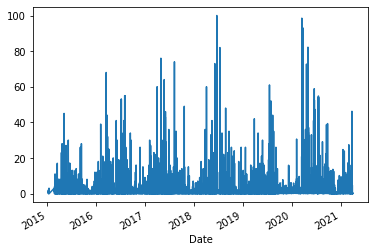

In [ ]:
df1_w['SO2 (ppb)'].plot()

In [ ]:
best_params = {'alpha': 134.29285275062202,
 'booster': 'gbtree',
 'eta': 0.45278680746183175,
 'gamma': 0.20932264343971319,
 'grow_policy': 'depthwise',
 'lambda': 1.2963829178185304,
 'max_depth': 6,
 'score': 12.577092256256531}

In [ ]:
# best_params = {'alpha': 31.556175406841003,
#  'booster': 'gbtree',
#  'eta': 0.29167697154057376,
#  'gamma': 0.18906207376024659,
#  'grow_policy': 'lossguide',
#  'lambda': 25.921910753612906,
#  'max_depth': 5,
#  'score': 15.064180111411144} #number=601, values=[4.755448973684473]]   < 5

# best_params = {'alpha': 18.462027058221132,
#  'booster': 'gbtree',
#  'eta': 0.36669733790910475,
#  'gamma': 1.522615247611338,
#  'grow_policy': 'lossguide',
#  'lambda': 16.740373264015176,
#  'max_depth': 8,
#  'score': 15.477650895351523}  #(number=245, values=[18.568138995465333]

# best_params= study2.best_params
score = best_params ['score']
booster = best_params['booster']
lambdaa =best_params['lambda']
alpha = best_params['alpha']
# n_estimators = best_params['n_estimators']
max_depth = best_params['max_depth']

eta = best_params['eta']
gamma=best_params['gamma']
grow_policy= best_params['grow_policy']
#sample_type=study.best_params['sample_type']
#normalize_type= study.best_params['normalize_type']
#rate_drop=study.best_params['rate_drop']
#skip_drop=study.best_params['skip_drop']
        
df1_w_c=  df1_w[df1_w['score'] <  best_params["score"]].copy()
# df1_w_c=  df1_w.copy()
df1_w_c.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_Buffalo Viewpoint_2015RealRH_outlier_Dataset.csv')
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)/len(df1_w))
# df1_w_c = df_xg
Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)


0.9520034117122531


In [ ]:
 df1_w

SO2 (ppb)  RH %  T ( C)  ...  Day-year      trend     score
Date                                          ...                               
2015-01-12 13:00:00        1.0  80.0   -13.5  ...      12.0  15.031535  5.968750
2015-01-12 14:00:00        1.0  79.0   -13.1  ...      12.0  15.031648  3.689744
2015-01-12 15:00:00        1.0  81.0   -13.6  ...      12.0  15.031762  7.543608
2015-01-12 16:00:00        0.0  85.0   -14.6  ...      12.0  15.031876  8.820147
2015-01-12 17:00:00        0.0  84.0   -14.1  ...      12.0  15.031990  3.763727
...                        ...   ...     ...  ...       ...        ...       ...
2021-03-31 19:00:00        0.0  51.5     5.6  ...      90.0  21.245332  2.930092
2021-03-31 20:00:00        0.1  53.6     4.2  ...      90.0  21.245446  6.933968
2021-03-31 21:00:00        0.3  45.6     5.3  ...      90.0  21.245560  4.271944
2021-03-31 22:00:00        0.2  43.5     5.4  ...      90.0  21.245674  2.480556
2021-03-31 23:00:00        0.0  46.1     4.6  ...      90.0  21.245788  5.914031

[51587 rows x 15 columns]

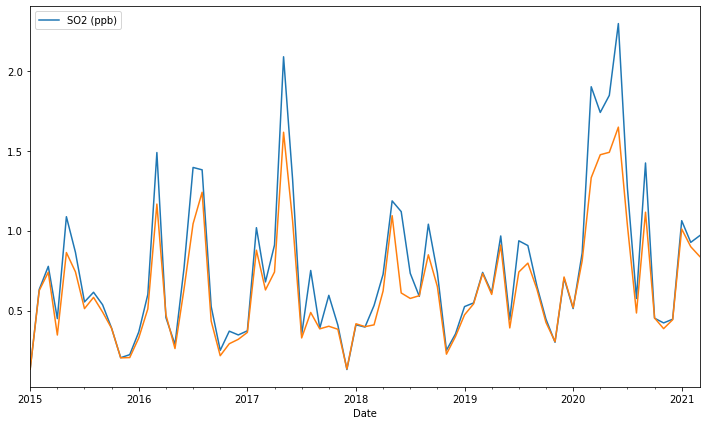

In [ ]:
A = 'M'
df1_w['SO2 (ppb)'].resample(A).mean().plot(legend = True,figsize = (12,7))
df1_w_c['SO2 (ppb)'].resample(A).mean().plot()


In [ ]:
print(len(df1_w_c)*100/len(df1_w))

95.2003411712253


[0]	validation_0-rmse:2.60247
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:2.57066
[2]	validation_0-rmse:2.54591
[3]	validation_0-rmse:2.525
[4]	validation_0-rmse:2.50011
[5]	validation_0-rmse:2.47616
[6]	validation_0-rmse:2.46169
[7]	validation_0-rmse:2.44885
[8]	validation_0-rmse:2.43605
[9]	validation_0-rmse:2.42423
[10]	validation_0-rmse:2.41696
[11]	validation_0-rmse:2.41103
[12]	validation_0-rmse:2.40421
[13]	validation_0-rmse:2.39607
[14]	validation_0-rmse:2.38841
[15]	validation_0-rmse:2.38724
[16]	validation_0-rmse:2.38084
[17]	validation_0-rmse:2.38109
[18]	validation_0-rmse:2.37981
[19]	validation_0-rmse:2.37749
[20]	validation_0-rmse:2.3782
[21]	validation_0-rmse:2.37773
[22]	validation_0-rmse:2.37707
[23]	validation_0-rmse:2.37088
[24]	validation_0-rmse:2.36557
[25]	validation_0-rmse:2.36518
[26]	validation_0-rmse:2.3628
[27]	validation_0-rmse:2.35953
[28]	validation_0-rmse:2.35535
[29]	validation_0-rmse:2.35367
[30]	validation_0-r

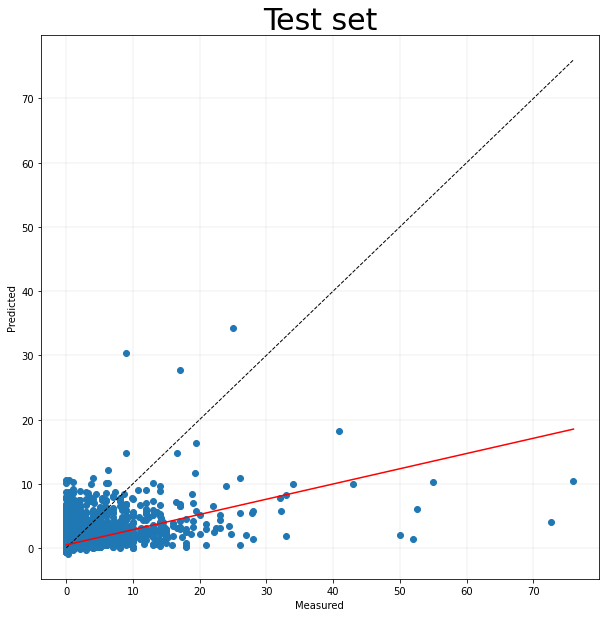

[0.23726581 0.47425852]
RMSE
[2.08720694]
R2
0.24199169625201555


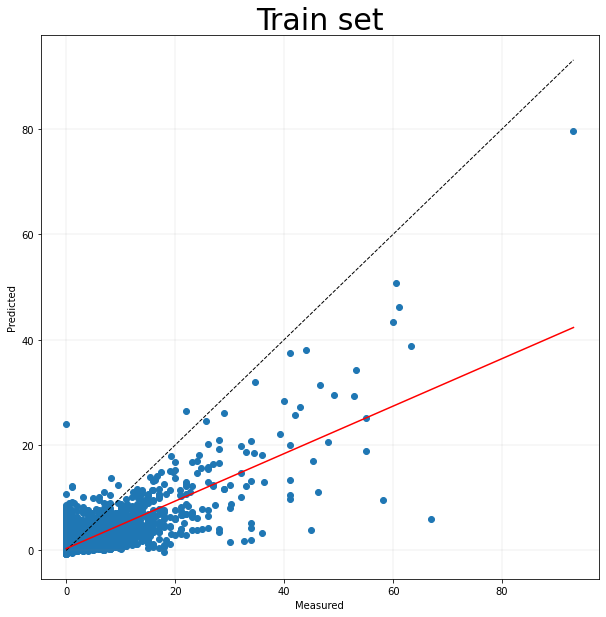

[0.45069584 0.34973448]
RMSE
[1.67832047]
R2
0.5617667822979051


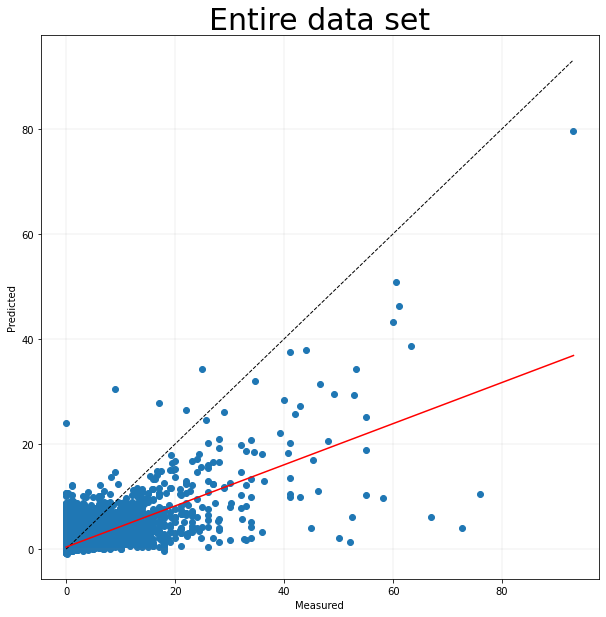

[0.39156922 0.38465035]
RMSE
[1.81071353]
R2
0.4731751592841872


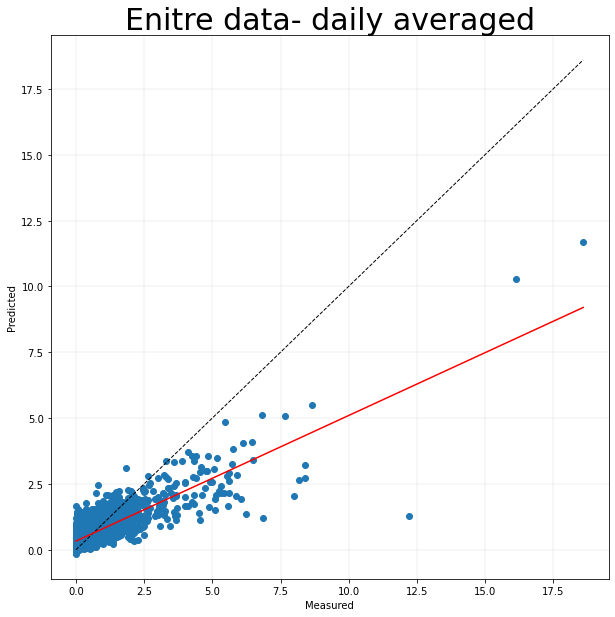

[0.47693206 0.32912482]
RMSE
[0.73114079]
R2
0.6281688538204333


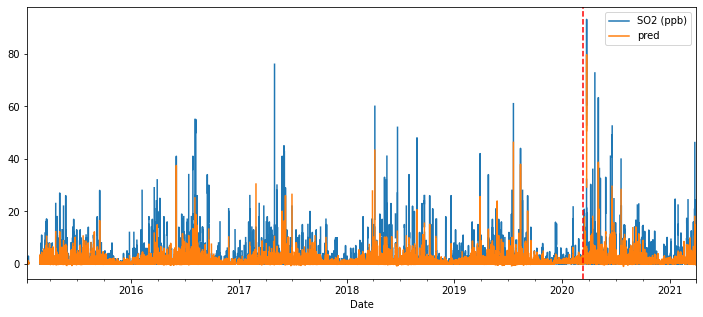

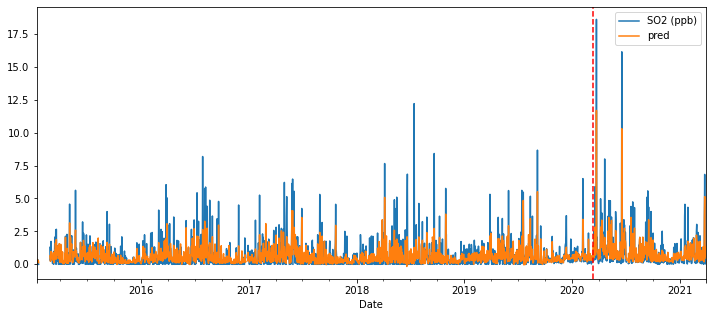

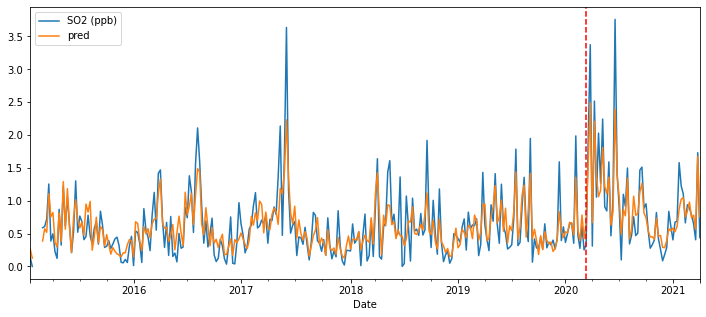

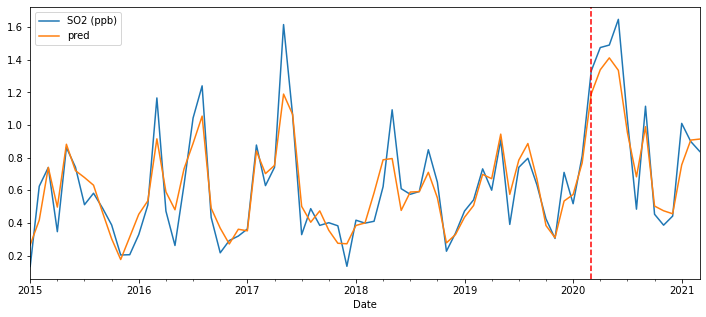

In [ ]:
model= xgb.XGBRegressor(booster = booster, reg_lambda=lambdaa, alpha=alpha,  
                          max_depth = max_depth, eta = eta, gamma = gamma,
                          grow_policy = grow_policy,
                          # n_estimators=n_estimators,
                          objective ='reg:squarederror', 
                          #normalize_type=normalize_type,sample_type=sample_type,rate_drop=rate_drop,skip_drop=skip_drop,
                          random_state=42)

eval_set = [(X_val, y_val)]
model.fit(X_traine, y_traine, early_stopping_rounds=20, eval_metric="rmse", eval_set=eval_set)


preds = model.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))


# df3= df3.copy()
df4 = df1_w_c.copy() #hereee
df4['pred'] = model.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean().copy()
df10.dropna(inplace= True)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(df10['SO2 (ppb)']).reshape(-1,1)
y_pred = np.array(df10['pred']).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
ax.set_title('Enitre data- daily averaged',fontsize=30)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()
print(par)
print('RMSE')
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))



df4['SO2 (ppb)'].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
df4.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = ['SO2 (ppb)']


df1_w_c = df1_w[['SO2 (ppb)', 'T ( C)', 'RH %', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ 'SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2['SO2 (ppb)'] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 ['SO2 (ppb)'] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Buffalo Viewpoint_outlier_2015_realRH_OT_XG_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Buffalo Viewpoint_outlier_2015_realRH_OT_XG_Test.csv')


[1.67832047]
0.5617667822979051
[2.08720694]
0.24199169625201555


In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
172
0.5545719265937805
2021-01-18 04:00:00
172
0.6035940647125244
2021-01-18 05:00:00
166
0.5615552663803101
2021-01-18 06:00:00
175
0.575117290019989
2021-01-18 07:00:00
171
0.5676010847091675
2021-01-18 08:00:00
172
0.5644327402114868
2021-01-18 09:00:00
173
0.5574279427528381
2021-01-18 10:00:00
168
0.7101925015449524
2021-01-18 11:00:00
156
0.7400199770927429
2021-01-18 12:00:00
157
0.8931465744972229
2021-01-18 13:00:00
167
0.9986270666122437
2021-01-18 14:00:00
173
0.9512988924980164
2021-01-18 15:00:00
165
0.9137078523635864
2021-01-18 16:00:00
171
0.8055161237716675
2021-01-18 17:00:00
176
0.8029159307479858
2021-01-18 18:00:00
178
0.7753421068191528
2021-01-18 19:00:00
173
0.7522377371788025
2021-01-18 20:00:00
178
0.7488965392112732
2021-01-18 21:00:00
174
0.734747588634491
2021-01-18 22:00:00
173
0.7439591884613037
2021-01-18 23:00:00
176
0.7007216811180115
2021-01-19 00:00:00
173
0.5587813258171082
2021-01-19 01:00:00
177
0

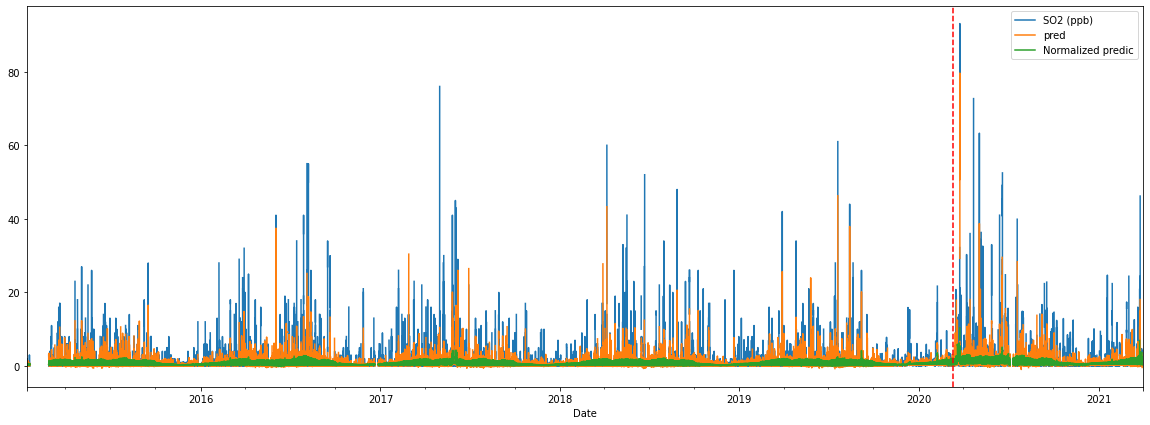

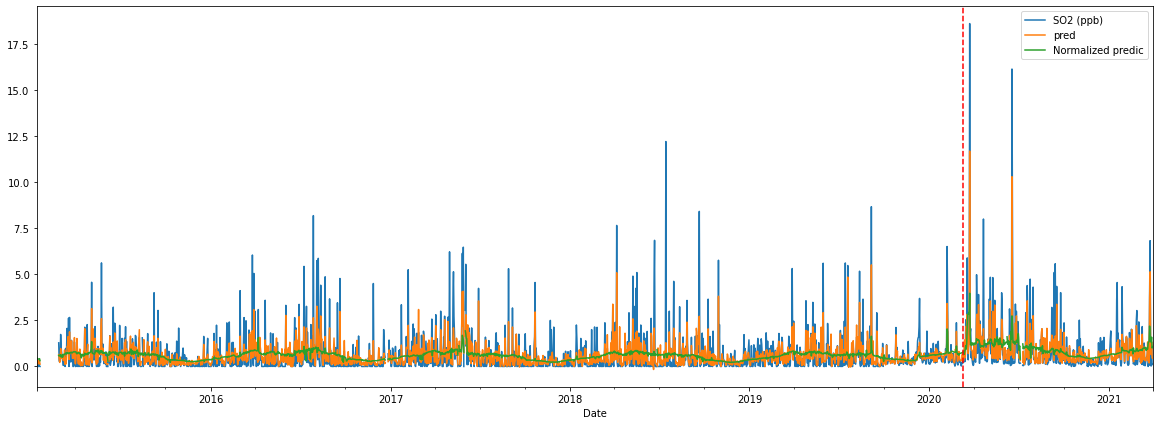

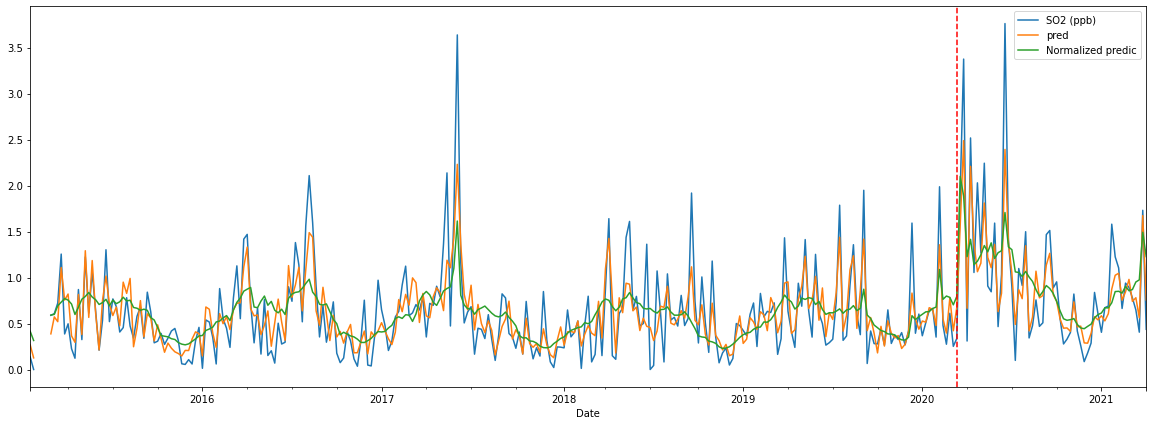

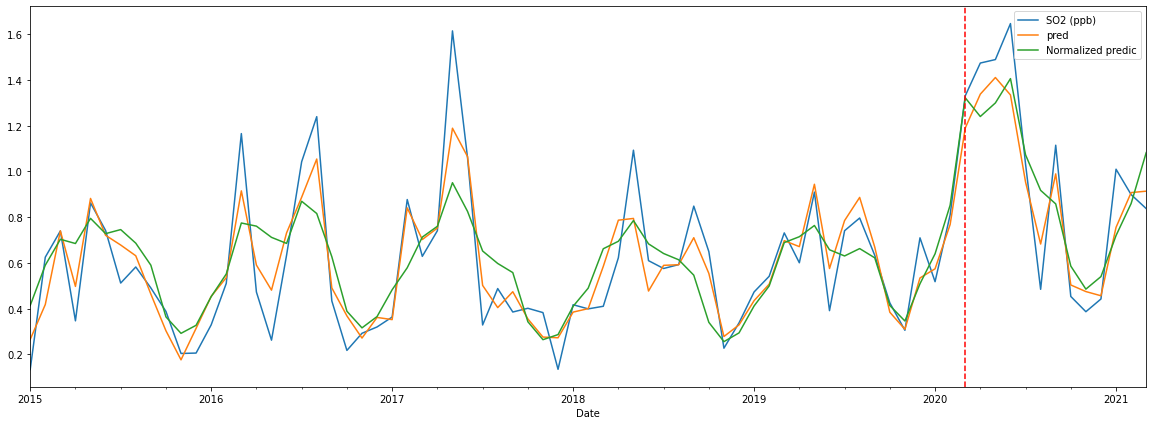

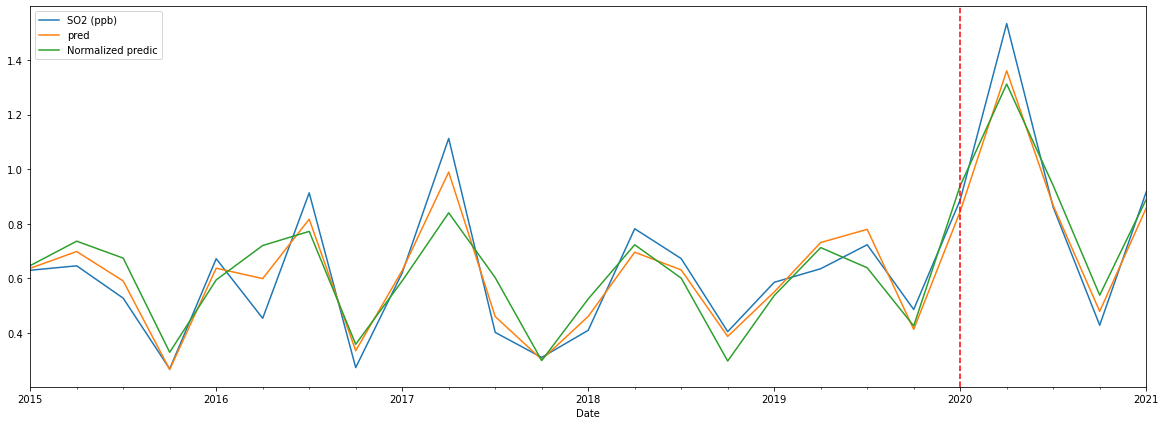

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_outlier_2015_realRH_SO2_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_outlier_2015_realRH_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/XG_BuffaloViewpoint_outlier_2015_realRH_SO2_Monthly_normalized_pred.csv')

for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
############

In [ ]:
maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds

avg = df1_w['score'].mean()
std = df1_w['score'].std()

print(avg,std)

5.62075511710932 4.603789857934582


In [ ]:
df1_w

SO2 (ppb)  RH %  T ( C)  ...  Day-year      trend     score
Date                                          ...                               
2015-01-12 13:00:00        1.0  80.0   -13.5  ...      12.0  15.031535  5.968750
2015-01-12 14:00:00        1.0  79.0   -13.1  ...      12.0  15.031648  3.689744
2015-01-12 15:00:00        1.0  81.0   -13.6  ...      12.0  15.031762  7.543608
2015-01-12 16:00:00        0.0  85.0   -14.6  ...      12.0  15.031876  8.820147
2015-01-12 17:00:00        0.0  84.0   -14.1  ...      12.0  15.031990  3.763727
...                        ...   ...     ...  ...       ...        ...       ...
2021-03-31 19:00:00        0.0  51.5     5.6  ...      90.0  21.245332  2.930092
2021-03-31 20:00:00        0.1  53.6     4.2  ...      90.0  21.245446  6.933968
2021-03-31 21:00:00        0.3  45.6     5.3  ...      90.0  21.245560  4.271944
2021-03-31 22:00:00        0.2  43.5     5.4  ...      90.0  21.245674  2.480556
2021-03-31 23:00:00        0.0  46.1     4.6  ...      90.0  21.245788  5.914031

[51587 rows x 15 columns]

In [ ]:
df1_w

SO2 (ppb)  RH %  T ( C)  ...  Day-year      trend     score
Date                                          ...                               
2015-01-12 13:00:00        1.0  80.0   -13.5  ...      12.0  15.031535  5.968750
2015-01-12 14:00:00        1.0  79.0   -13.1  ...      12.0  15.031648  3.689744
2015-01-12 15:00:00        1.0  81.0   -13.6  ...      12.0  15.031762  7.543608
2015-01-12 16:00:00        0.0  85.0   -14.6  ...      12.0  15.031876  8.820147
2015-01-12 17:00:00        0.0  84.0   -14.1  ...      12.0  15.031990  3.763727
...                        ...   ...     ...  ...       ...        ...       ...
2021-03-31 19:00:00        0.0  51.5     5.6  ...      90.0  21.245332  2.930092
2021-03-31 20:00:00        0.1  53.6     4.2  ...      90.0  21.245446  6.933968
2021-03-31 21:00:00        0.3  45.6     5.3  ...      90.0  21.245560  4.271944
2021-03-31 22:00:00        0.2  43.5     5.4  ...      90.0  21.245674  2.480556
2021-03-31 23:00:00        0.0  46.1     4.6  ...      90.0  21.245788  5.914031

[51587 rows x 15 columns]

In [ ]:
class Objective(object):
    def __init__(self,df1_w, max_epochs, learn_rate_epochs,
                  ):
       
        # self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.11, random_state=42)
        self.max_epochs = max_epochs
        #self.early_stop = early_stop
        self.learn_rate_epochs = learn_rate_epochs
        # self.n_features = np.shape(self.X_train)[1]
        self.df1_w = df1_w.copy()
        self.n_features = len(self.df1_w.columns)-1

    def __call__(self, trial):        
        dict_params = {
                        "score" : trial.suggest_float( 'score', avg + 2*std, avg + 5 * std ),
                        'layers': trial.suggest_int('layers', 2,3),
                        'alpha': trial.suggest_float(  'alpha',0.01, 0.9),
                        'batchsize': int(trial.suggest_discrete_uniform('batchsize', 100,5000,500)),
                        'num_dense_nodes1': trial.suggest_int('num_dense_nodes1', 20,40),
                        'delta': trial.suggest_float(  'delta',1, 100),
                       'learning_rate': trial.suggest_float(  'learning_rate',0.001, 0.1),
                       'drop_out1': trial.suggest_float('drop_out1',0.05, 0.3)}  
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        dict_params['num_dense_nodes2'] = trial.suggest_int('num_dense_nodes2', 20,40)
        dict_params['drop_out2'] =trial.suggest_float('drop_out2',0.05, 0.5)

        if dict_params['layers'] == 3:
            dict_params['num_dense_nodes3'] = trial.suggest_int('num_dense_nodes3', 5,40)
            dict_params['drop_out3'] = trial.suggest_float('drop_out3',0.05, 0.5)


        self.df_nn =  self.df1_w[self.df1_w['score'] <  dict_params["score"]].copy()
        self.df_nn.drop(columns = ['score'], inplace = True)
        self.Y =   self.df_nn[aa]
        self.Y = np.array(self.Y).reshape(-1,1)
        self.X = np.array( self.df_nn[  self.df_nn.columns[1:]])
        # self.X_train =self.X
        # self.y_train =self.Y
        self.X_train,  self.X_test,  self.y_train, self.y_test = train_test_split( self.X,   self.Y, test_size=0.3, random_state = 42)
          
          
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(dict_params['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha= dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out1']))
        # if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
        model.add(Dense(dict_params['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        model.add(Dropout(dict_params['drop_out2']))
        if dict_params['layers'] == 3 :
            model.add(Dense(dict_params['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
            model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
            model.add(Dropout(dict_params['drop_out3']))
        model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
        model.add(LeakyReLU(alpha=dict_params[ 'alpha'])) 
        # instantiate and compile model
        opt = keras.optimizers.Adam(learning_rate=dict_params[ 'learning_rate'])
        model.compile(loss=
                      # 'mse',
                      tf.keras.losses.Huber( delta=dict_params[ 'delta']),
                      # 'mse'
                          optimizer=opt)
        fn = "gdrive/My Drive/Colab Notebooks/Stations/Buffalo__Viewpoint_outlier_2015_realRH_SO2_SC1" +str(trial.number) + ".ckpt" 
        fnn = os.path.dirname(fn)
        # callbacks for early stopping and for learning rate reducer
        callbacks_list = [
                          #KerasPruningCallback(trial, 'val_loss'),
                          #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.early_stop),                     
                          tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                            patience=self.learn_rate_epochs, 
                                            verbose=0, mode='auto', min_lr=0.000001),
                          tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                          monitor='val_loss',mode='min', save_best_only=True)]
        n_f = 4
        kf = KFold(n_splits=n_f )
        acc = 0 
        for train_index, test_index in kf.split( self.X_train):   
                X_tr, X_tes =  self.X_train[train_index],  self.X_train[test_index]
                y_tr, y_tes =   self.y_train[train_index],   self.y_train[test_index]    
                # fit the model
                X_tra, X_val, y_tra, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state = 42)
                h = model.fit(x=X_tra, y=y_tra,
                                  validation_data=(X_val, y_val),
                                  batch_size=dict_params['batchsize'],
                                  epochs=self.max_epochs,
                                  shuffle=True, verbose=0,
                                  callbacks=callbacks_list)
                model.load_weights(fn)
                preds = model.predict(X_tes)
                accuracy = mean_squared_error(y_tes, preds)
                # accuracy = np.min(h.history['val_loss'])
                acc = acc +  accuracy/n_f 

        print(acc)
        return acc    

In [ ]:
# objective = Objective(df1_w,maximum_epochs,learning_rate_epochs)
# study = optuna.create_study(direction=optimizer_direction, study_name='BuffaloViewpoint_outlier_2015_realRH_sc1__NN', storage='sqlite:///Buffalo Viewpoint_outlier_2015_realRH__sc1__NN.db',
#                             load_if_exists=True)
# study.optimize(objective, n_trials=500)
df_results = study.trials_dataframe()
df_results.to_csv('gdrive/My Drive/Colab Notebooks/results/NN_OT_BuffaloViewpoint_outlier_2015_realRH_HUBer.csv')
#df_results.to_pickle('Desktop\heel\df_optuna_results.pkl')

In [ ]:
study.best_trials

[FrozenTrial(number=235, values=[4.660612377861246], datetime_start=datetime.datetime(2021, 5, 16, 10, 54, 41, 516248), datetime_complete=datetime.datetime(2021, 5, 16, 10, 55, 36, 387411), params={'score': 15.640110039479996, 'layers': 2, 'alpha': 0.013415048072314037, 'batchsize': 4100.0, 'num_dense_nodes1': 30, 'delta': 40.7733375378376, 'learning_rate': 0.07595118783416013, 'drop_out1': 0.19048348272484705, 'num_dense_nodes2': 35, 'drop_out2': 0.11477434957541588}, distributions={'score': UniformDistribution(high=28.63970440678223, low=14.828334832978484), 'layers': IntUniformDistribution(high=3, low=2, step=1), 'alpha': UniformDistribution(high=0.9, low=0.01), 'batchsize': DiscreteUniformDistribution(high=4600.0, low=100.0, q=500.0), 'num_dense_nodes1': IntUniformDistribution(high=40, low=20, step=1), 'delta': UniformDistribution(high=100.0, low=1.0), 'learning_rate': UniformDistribution(high=0.1, low=0.001), 'drop_out1': UniformDistribution(high=0.3, low=0.05), 'num_dense_nodes2'

In [ ]:
study.best_params

{'alpha': 0.013415048072314037,
 'batchsize': 4100.0,
 'delta': 40.7733375378376,
 'drop_out1': 0.19048348272484705,
 'drop_out2': 0.11477434957541588,
 'layers': 2,
 'learning_rate': 0.07595118783416013,
 'num_dense_nodes1': 30,
 'num_dense_nodes2': 35,
 'score': 15.640110039479996}

In [ ]:
best_params = {'alpha': 0.013415048072314037,
 'batchsize': 4100.0,
 'delta': 40.7733375378376,
 'drop_out1': 0.19048348272484705,
 'drop_out2': 0.11477434957541588,
 'layers': 2,
 'learning_rate': 0.07595118783416013,
 'num_dense_nodes1': 30,
 'num_dense_nodes2': 35,
 'score': 15.640110039479996}  #number=235, values=[4.660612377861246]

In [ ]:
df1_w_cn=  df1_w[df1_w['score'] <  best_params["score"]].copy()
df1_w_cn.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_Buffalo Viewpoint_outlier_2015_realRH_outlier_Dataset.csv')

df1_w_c = df1_w_cn.copy()  
# df1_w_c = df1_w.copy() 
df1_w_c.drop(columns = ['score'], inplace = True)
print(len(df1_w_c)*100/len(df1_w))
Y = df1_w_c['SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


97.16013724387928


In [ ]:
df1_w_c.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)

maximum_epochs = 250
early_stop_epochs= 60
learning_rate_epochs = 30
optimizer_direction = 'minimize'
number_of_random_points = 30  # random searches to start opt process
maximum_time = 8*60*60  # seconds
best_params

{'alpha': 0.013415048072314037,
 'batchsize': 4100.0,
 'delta': 40.7733375378376,
 'drop_out1': 0.19048348272484705,
 'drop_out2': 0.11477434957541588,
 'layers': 2,
 'learning_rate': 0.07595118783416013,
 'num_dense_nodes1': 30,
 'num_dense_nodes2': 35,
 'score': 15.640110039479996}

In [ ]:
df1_w_c.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'],
      dtype='object')

Epoch 1/250
7/7 - 1s - loss: 3.3557 - val_loss: 3.4753
Epoch 2/250
7/7 - 0s - loss: 3.1198 - val_loss: 3.4429
Epoch 3/250
7/7 - 0s - loss: 2.9221 - val_loss: 3.7479
Epoch 4/250
7/7 - 0s - loss: 2.8490 - val_loss: 4.1535
Epoch 5/250
7/7 - 0s - loss: 2.8169 - val_loss: 3.8641
Epoch 6/250
7/7 - 0s - loss: 2.8145 - val_loss: 3.8505
Epoch 7/250
7/7 - 0s - loss: 2.7535 - val_loss: 3.7734
Epoch 8/250
7/7 - 0s - loss: 2.7525 - val_loss: 4.3199
Epoch 9/250
7/7 - 0s - loss: 2.7191 - val_loss: 3.4754
Epoch 10/250
7/7 - 0s - loss: 2.8209 - val_loss: 4.5545
Epoch 11/250
7/7 - 0s - loss: 2.7475 - val_loss: 6.1901
Epoch 12/250
7/7 - 0s - loss: 2.7178 - val_loss: 3.4031
Epoch 13/250
7/7 - 0s - loss: 2.7114 - val_loss: 3.4713
Epoch 14/250
7/7 - 0s - loss: 2.7347 - val_loss: 3.7024
Epoch 15/250
7/7 - 0s - loss: 2.7201 - val_loss: 3.6269
Epoch 16/250
7/7 - 0s - loss: 2.7349 - val_loss: 3.3313
Epoch 17/250
7/7 - 0s - loss: 2.7043 - val_loss: 3.2124
Epoch 18/250
7/7 - 0s - loss: 2.6743 - val_loss: 3.1504
E

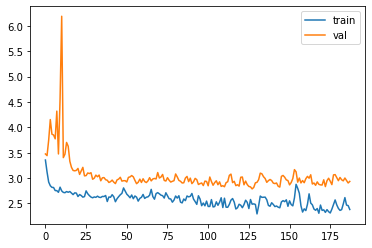

Model: "sequential_495"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_495 (Bat (None, 13)                52        
_________________________________________________________________
dense_1499 (Dense)           (None, 30)                420       
_________________________________________________________________
leaky_re_lu_1499 (LeakyReLU) (None, 30)                0         
_________________________________________________________________
dropout_1004 (Dropout)       (None, 30)                0         
_________________________________________________________________
dense_1500 (Dense)           (None, 35)                1085      
_________________________________________________________________
leaky_re_lu_1500 (LeakyReLU) (None, 35)                0         
_________________________________________________________________
dropout_1005 (Dropout)       (None, 35)             

In [ ]:
model_NN = Sequential()
model_NN.add(BatchNormalization())
model_NN.add(Dense(best_params ['num_dense_nodes1'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha= best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out1']))
# if dict_params['layers'] == 2 or dict_params['layers'] == 3 :
model_NN.add(Dense(best_params ['num_dense_nodes2'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
model_NN.add(Dropout(best_params ['drop_out2']))
if best_params ['layers'] == 3 :
    model_NN.add(Dense(best_params ['num_dense_nodes3'], kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
    model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
    model_NN.add(Dropout(best_params ['drop_out3']))
model_NN.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.01,seed = 42),bias_initializer=initializers.Zeros() ))
model_NN.add(LeakyReLU(alpha=best_params [ 'alpha'])) 
# instantiate and compile model
opt = keras.optimizers.Adam(learning_rate=best_params [ 'learning_rate'])
model_NN.compile(loss=
                #  'mse',
              tf.keras.losses.Huber( delta=best_params[ 'delta']),
              # 'mse'
                  optimizer=opt)
fn = "gdrive/My Drive/Colab Notebooks/Stations/Training_SO2_Maildlake_OUT.ckpt" 
fnn = os.path.dirname(fn)
# callbacks for early stopping and for learning rate reducer
callbacks_list = [
                  #KerasPruningCallback(trial, 'val_loss'),
                  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_epochs),                     
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, 
                                    patience=learning_rate_epochs, 
                                    verbose=0, mode='auto', min_lr=0.000001),
                  tf.keras.callbacks.ModelCheckpoint(filepath=fn, save_weights_only=True,
                                  monitor='val_loss',mode='min', save_best_only=True)]

history = model_NN.fit(x=X_traine, y= y_traine,
                  validation_data=(X_val, y_val),
                  batch_size=int(best_params['batchsize']),
                  epochs=maximum_epochs,
                  shuffle=True, verbose=2,
                  callbacks=callbacks_list)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val')
pyplot.legend()
pyplot.show()
model_NN.summary()

In [ ]:
model_NN.load_weights(fn)
precovid_model = 'gdrive/My Drive/Colab Notebooks/BuffaloViewpoint_outlier_2015_realRH_SO2_OUT.h5'
model_NN.save(precovid_model )

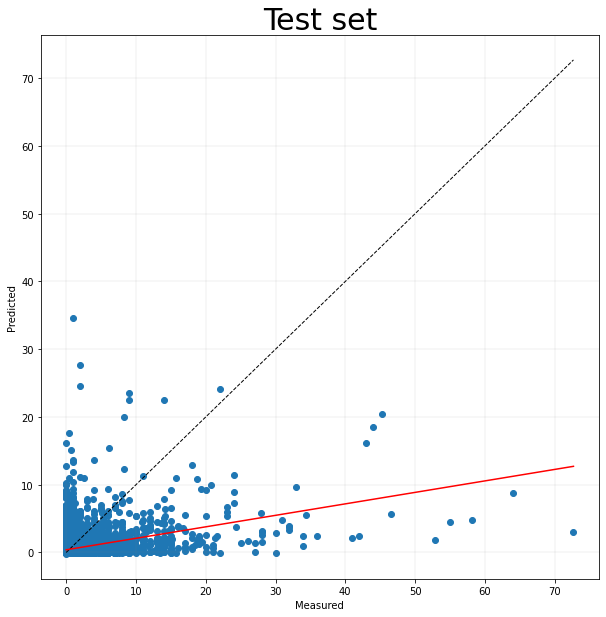

[0.16942506 0.39561796]
RMSE
[2.43128886]
R2
0.11240599207281599


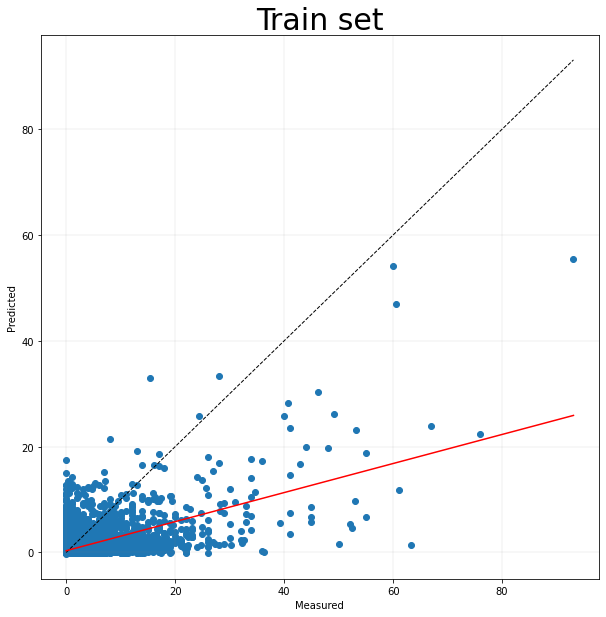

[0.27463076 0.33409657]
RMSE
[2.18321586]
R2
0.2984133427670931


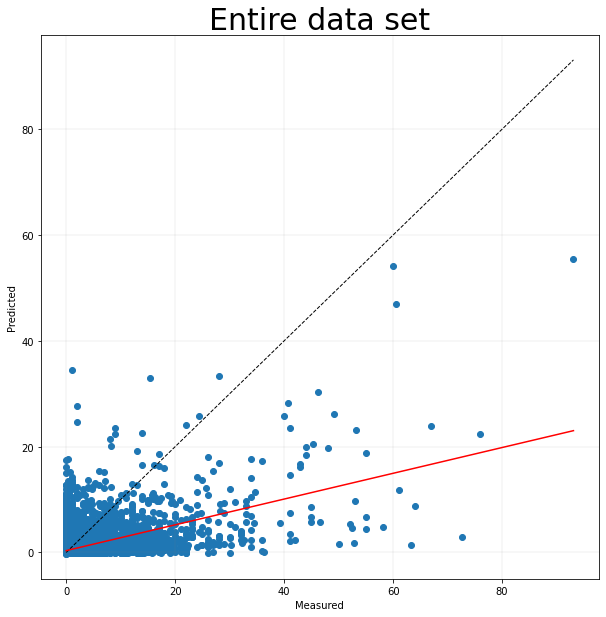

[0.24350452 0.35208672]
RMSE
[2.26050013]
R2
0.24338636798552904


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real = np.array(y_real).reshape(-1,1)
y_pred = np.array(y_pred).reshape(-1,1)
ax.scatter(y_real, y_pred)
ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Test set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real
b=y_pred
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print("RMSE")
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print("R2")
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

# model.load_weights(fn)
preds = model_NN.predict(X_train) 
y_real_t = y_train.reshape(-1,1)
y_pred_t = preds.reshape(-1,1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_t = np.array(y_real_t).reshape(-1,1)
y_pred_t = np.array(y_pred_t).reshape(-1,1)
ax.scatter(y_real_t, y_pred_t)
ax.plot([y_real_t.min(), y_real_t.max()], [y_real_t.min(), y_real_t.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Train set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)

a=y_real_t
b=y_pred_t
par= np.polyfit(a.flatten(),b.flatten(),1)
slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')
plt.show()

print(par)
print('RMSE')
print(rmse(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_t.reshape(-1,1), y_pred_t.reshape(-1,1)))

#TRAIN
# model.load_weights(fn)
preds = model_NN.predict(X) 
y_real_to = Y.reshape(-1,1)
y_pred_to = preds.reshape(-1,1)


fig, ax = plt.subplots(1,1, figsize=(10,10))
y_real_to = np.array(y_real_to).reshape(-1,1)
y_pred_to = np.array(y_pred_to).reshape(-1,1)
ax.scatter(y_real_to, y_pred_to)
ax.plot([y_real_to.min(), y_real_to.max()], [y_real_to.min(), y_real_to.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.set_title('Entire data set',fontsize=30)
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)


a=y_real_to
b=y_pred_to
par= np.polyfit(a.flatten(),b.flatten(),1)

slope=par[0]
intercept=par[1]
xl = [min(a), max(a )]
yl = [slope*xx + intercept  for xx in xl]
plt.plot(xl, yl, 'red')

plt.show()

print(par)
print('RMSE')
print(rmse(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))
print('R2')
print(sklearn.metrics.r2_score(y_real_to.reshape(-1,1), y_pred_to.reshape(-1,1)))

Model: "sequential_495"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_495 (Bat (None, 13)                52        
_________________________________________________________________
dense_1499 (Dense)           (None, 30)                420       
_________________________________________________________________
leaky_re_lu_1499 (LeakyReLU) (None, 30)                0         
_________________________________________________________________
dropout_1004 (Dropout)       (None, 30)                0         
_________________________________________________________________
dense_1500 (Dense)           (None, 35)                1085      
_________________________________________________________________
leaky_re_lu_1500 (LeakyReLU) (None, 35)                0         
_________________________________________________________________
dropout_1005 (Dropout)       (None, 35)             

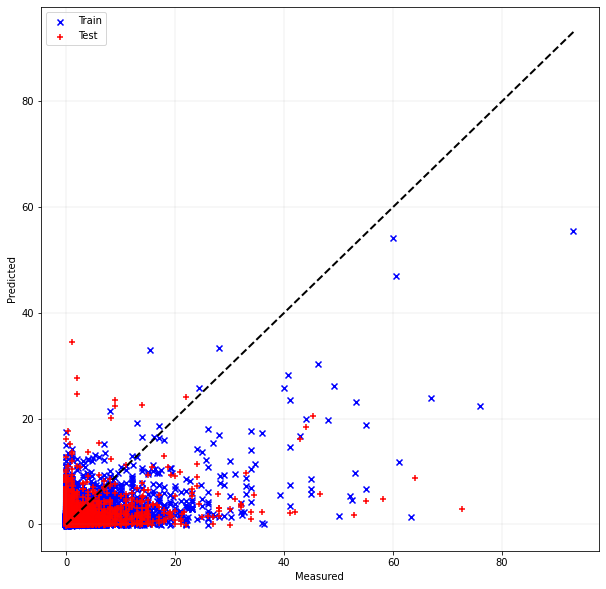

In [ ]:
model_NN = load_model(precovid_model )
model_NN.summary()
import matplotlib.cm as cm
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.plot([0, max(y_real_t)], [0, max(y_real_t)], 'k--', lw=2) 

ax.scatter(y_real_t, y_pred_t, c = "blue",label = 'Train',marker="x")
ax.scatter(y_real, y_pred, c = "red", label = 'Test',marker="+", cmap=cm.brg)

ax.legend()
ax.plot([0,0.5], [0,0.5], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
plt.show()

In [ ]:
# df3= df3.copy()
df4 = df1_w_c.copy()
df4['pred'] = model_NN.predict(np.array(df4[df4.columns[1:]])) 
df10 = df4.resample('D').mean()
df10.dropna(inplace= True)

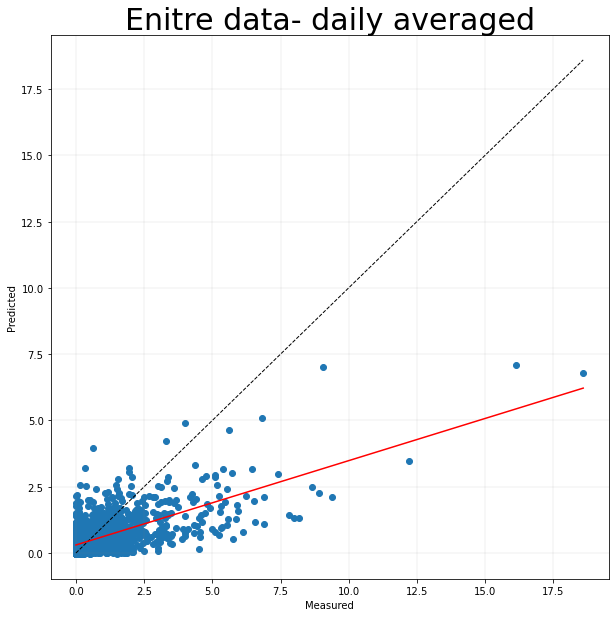

[0.31814095 0.30194076]
RMSE
[0.97989955]
R2
0.38006975811388233


In [ ]:
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    y_real = np.array(df10['SO2 (ppb)']).reshape(-1,1)
    y_pred = np.array(df10['pred']).reshape(-1,1)
    ax.scatter(y_real, y_pred)
    ax.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.set_title('Enitre data- daily averaged',fontsize=30)

    a=y_real
    b=y_pred
    par= np.polyfit(a.flatten(),b.flatten(),1)
    
    slope=par[0]
    intercept=par[1]
    xl = [min(a), max(a )]
    yl = [slope*xx + intercept  for xx in xl]
    plt.plot(xl, yl, 'red')
    plt.show()
    print(par)
    print('RMSE')
    print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
    print('R2')
    print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

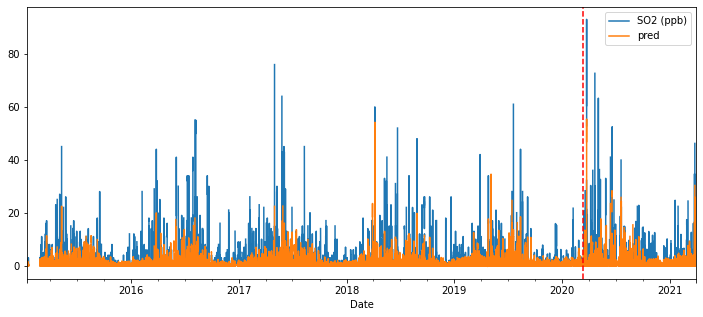

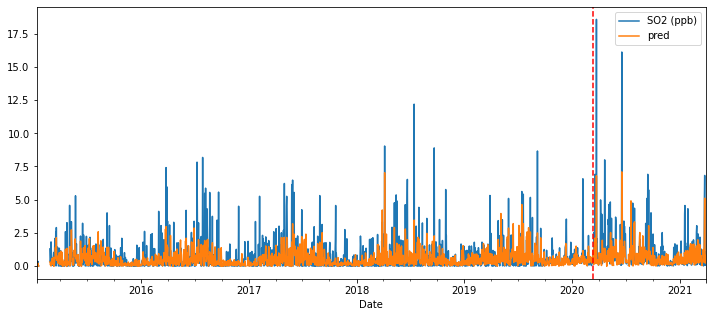

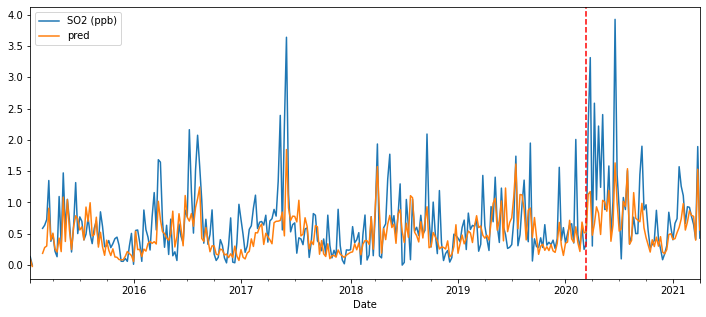

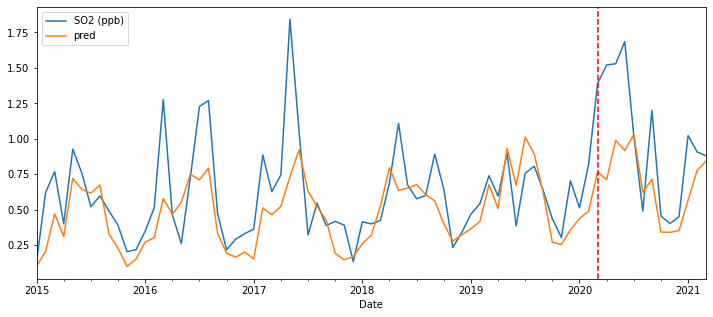

In [ ]:
df4['SO2 (ppb)'].resample('H').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('H').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('D').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('D').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

df4['SO2 (ppb)'].resample('W').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('W').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()


df4['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
#train['pred'].resample('H').mean().iloc[:1000].plot(figsize = (20,15), legend = True)
df4['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
plt.show()

In [ ]:
preds1 = model_NN.predict(X_train) 
y_real1 = y_train.reshape(-1,1)
y_pred1 = preds1.reshape(-1,1)
print(rmse(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real1.reshape(-1,1), y_pred1.reshape(-1,1)))

[2.18321586]
0.2984133427670931


In [ ]:
preds = model_NN.predict(X_test) 
y_real = y_test.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

[2.43128886]
0.11240599207281599


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
preds = model_NN.predict(X_train) 
y_real = y_train.reshape(-1,1)
y_pred = preds.reshape(-1,1)
print(rmse(y_real.reshape(-1,1), y_pred.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real.reshape(-1,1), y_pred.reshape(-1,1)))

preds2 = model_NN.predict(X_test) 
y_real2 = y_test.reshape(-1,1)
y_pred2 = preds2.reshape(-1,1)
print(rmse(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))
print(sklearn.metrics.r2_score(y_real2.reshape(-1,1), y_pred2.reshape(-1,1)))

train_col = [ 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend']
test_col = ['SO2 (ppb)']


df1_w_c = df1_w[['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend'
        ]]
Y = df1_w_c[ 'SO2 (ppb)']
Y = np.array(Y).reshape(-1,1)
X = np.array(df1_w_c[df1_w_c.columns[1:]])

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_traine, X_val, y_traine, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state = 42)


X_train2, X_test2, y_train2, y_test2 = train_test_split(df4[train_col], df4[test_col], test_size=0.3, random_state = 42)
Train2 = X_train2.copy()
Train2['SO2 (ppb)'] = y_real
Train2 ['Prediction'] = y_pred
Test2 = X_test2.copy()
Test2 ['SO2 (ppb)'] = y_real2
Test2  ['Prediction'] = y_pred2

Train2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/BuffaloViewpoint_outlier_2015_realRH_NN_OR_Train.csv')
Test2.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/BuffaloViewpoint_outlier_2015_realRH_NN_OR_Test.csv')

[2.18321586]
0.2984133427670931
[2.43128886]
0.11240599207281599


In [ ]:
df4.columns

Index(['SO2 (ppb)', 'RH %', 'T ( C)', 'Std. Dev. of Wind Direction',
       'Std. Dev. of Wind Speed', 'Wind Direction', 'Wind Speed',
       'Incoming Solar Rad. (W/m2)', 'Precip. (mm)', 'hol', 'hour',
       'dayofweek_num', 'Day-year', 'trend', 'pred'],
      dtype='object')

In [ ]:
df4_h = df4.copy()
df4.drop(columns = ['pred'], inplace = True)

In [ ]:
# df4_D = df4_h.resample('D').mean()
# df4_M = df4_h.resample('M').mean()
# df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO2_hourly_pred.csv')
# df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/Mannix_SO_monthly_pred.csv')

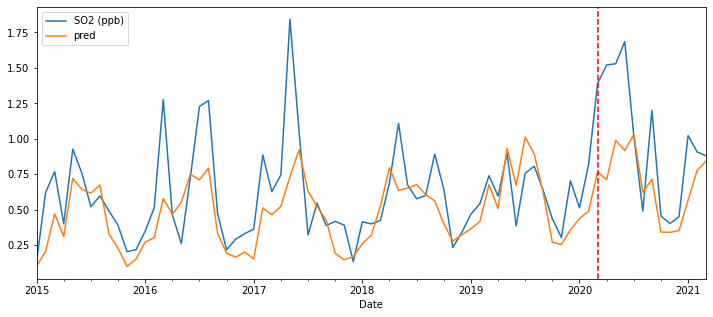

In [ ]:
df4_h['SO2 (ppb)'].resample('M').mean().plot(figsize = (12,5), legend = True)
df4_h['pred'].resample('M').mean().plot(figsize = (12,5), legend = True)
plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 

In [ ]:
df4

SO2 (ppb)  RH %  ...  Day-year      trend
Date                                  ...                     
2015-01-12 13:00:00        1.0  80.0  ...      12.0  15.031535
2015-01-12 14:00:00        1.0  79.0  ...      12.0  15.031648
2015-01-12 15:00:00        1.0  81.0  ...      12.0  15.031762
2015-01-12 16:00:00        0.0  85.0  ...      12.0  15.031876
2015-01-12 17:00:00        0.0  84.0  ...      12.0  15.031990
...                        ...   ...  ...       ...        ...
2021-03-31 19:00:00        0.0  51.5  ...      90.0  21.245332
2021-03-31 20:00:00        0.1  53.6  ...      90.0  21.245446
2021-03-31 21:00:00        0.3  45.6  ...      90.0  21.245560
2021-03-31 22:00:00        0.2  43.5  ...      90.0  21.245674
2021-03-31 23:00:00        0.0  46.1  ...      90.0  21.245788

[50122 rows x 14 columns]

In [ ]:
df4_h

SO2 (ppb)  RH %  T ( C)  ...  Day-year      trend      pred
Date                                          ...                               
2015-01-12 13:00:00        1.0  80.0   -13.5  ...      12.0  15.031535  0.342669
2015-01-12 14:00:00        1.0  79.0   -13.1  ...      12.0  15.031648 -0.000651
2015-01-12 15:00:00        1.0  81.0   -13.6  ...      12.0  15.031762 -0.002504
2015-01-12 16:00:00        0.0  85.0   -14.6  ...      12.0  15.031876 -0.007262
2015-01-12 17:00:00        0.0  84.0   -14.1  ...      12.0  15.031990 -0.005310
...                        ...   ...     ...  ...       ...        ...       ...
2021-03-31 19:00:00        0.0  51.5     5.6  ...      90.0  21.245332  1.598797
2021-03-31 20:00:00        0.1  53.6     4.2  ...      90.0  21.245446  0.426632
2021-03-31 21:00:00        0.3  45.6     5.3  ...      90.0  21.245560  0.337385
2021-03-31 22:00:00        0.2  43.5     5.4  ...      90.0  21.245674 -0.019814
2021-03-31 23:00:00        0.0  46.1     4.6  ...      90.0  21.245788 -0.010044

[50122 rows x 15 columns]

In [ ]:
z = []
for i in df4.index:
  print(i)
  a = df4['Day-year'].loc[i]
  trend = df4['trend'].loc[i]
  # counter = df2['counter'].loc[i]
  hour = df4['hour'].loc[i]
  if a < 14 :
    b = df4[(df4['Day-year'] < a + 15) | (df4['Day-year'] > a - 15 + 365 )].copy()
    # b['trend'] = trend
  if a > 351: 
    b = df4[(df4['Day-year'] > a - 15) | (df4['Day-year'] < a - 365 + 15 )].copy()
    # b['trend'] = trend
  else : 
    b = df4[(df4['Day-year'] > a - 15) &(df4['Day-year'] < a + 15 )].copy()
    # b['trend'] = trend
  #b.drop(columns =['Day-year'], inplace = True )
  c = b[b['hour'] ==  hour]
  c['trend'] = trend
  print(len(c))
  c['pred'] = model_NN.predict(np.array(c[c.columns[1:]])) 
  yhat = c['pred'].mean()
  print(yhat)
  z.append(yhat)

Streaming output truncated to the last 5000 lines.
173
0.14492040872573853
2021-01-19 05:00:00
172
0.15533839166164398
2021-01-19 06:00:00
177
0.20520709455013275
2021-01-19 07:00:00
175
0.21277618408203125
2021-01-19 08:00:00
177
0.26373523473739624
2021-01-19 09:00:00
174
0.30572566390037537
2021-01-19 10:00:00
170
0.4493689239025116
2021-01-19 12:00:00
164
0.8662441372871399
2021-01-19 13:00:00
169
1.0346295833587646
2021-01-19 14:00:00
175
1.0665674209594727
2021-01-19 15:00:00
171
0.957740843296051
2021-01-19 16:00:00
176
0.8146232962608337
2021-01-19 17:00:00
176
0.6744592189788818
2021-01-19 18:00:00
178
0.7058714628219604
2021-01-19 19:00:00
176
0.6983321905136108
2021-01-19 20:00:00
179
0.7946913838386536
2021-01-19 21:00:00
176
0.7265986204147339
2021-01-19 22:00:00
178
0.7990834712982178
2021-01-19 23:00:00
180
0.840578556060791
2021-01-20 00:00:00
177
0.042970847338438034
2021-01-20 01:00:00
180
0.08205234259366989
2021-01-20 02:00:00
177
0.07940903306007385
2021-01-20 03:0

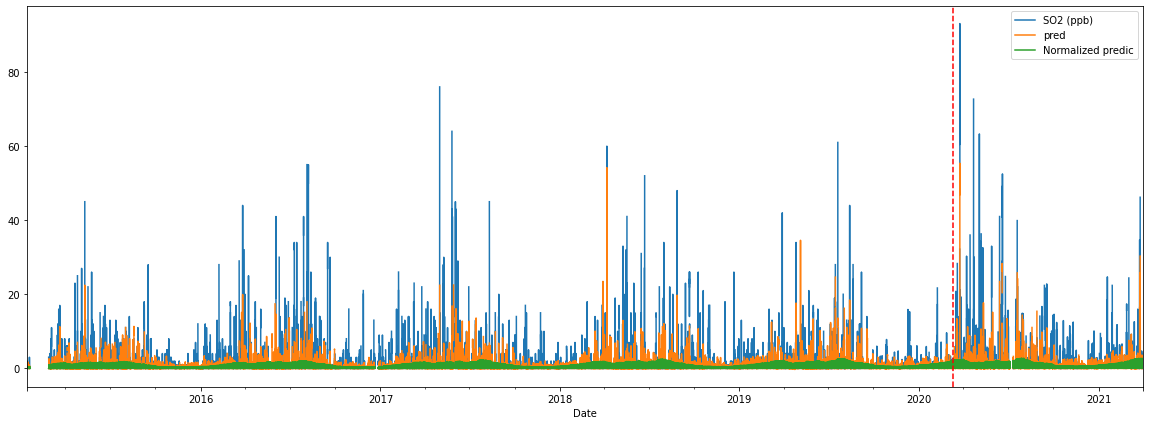

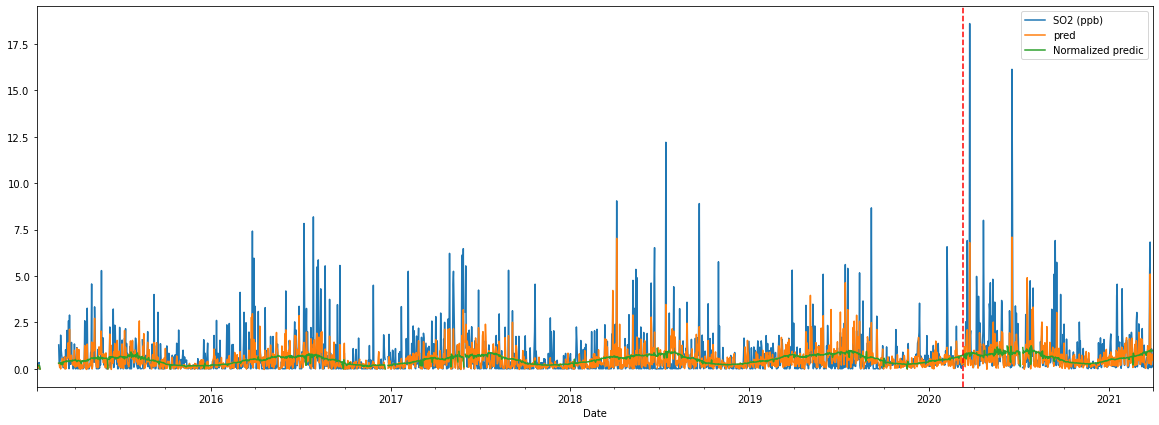

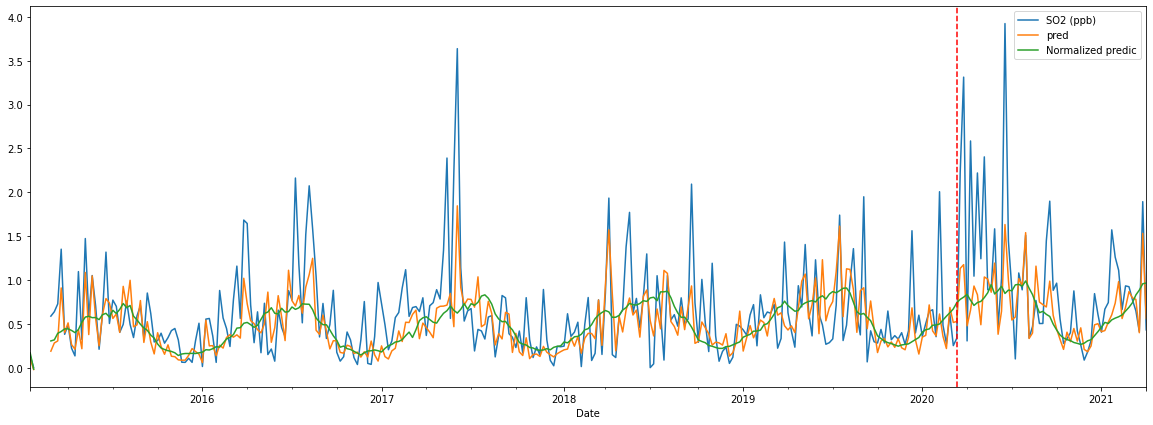

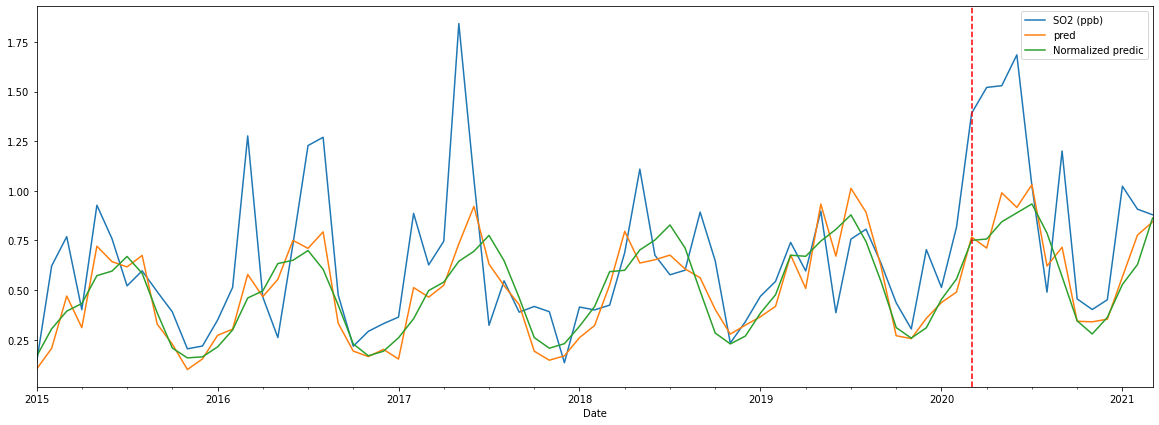

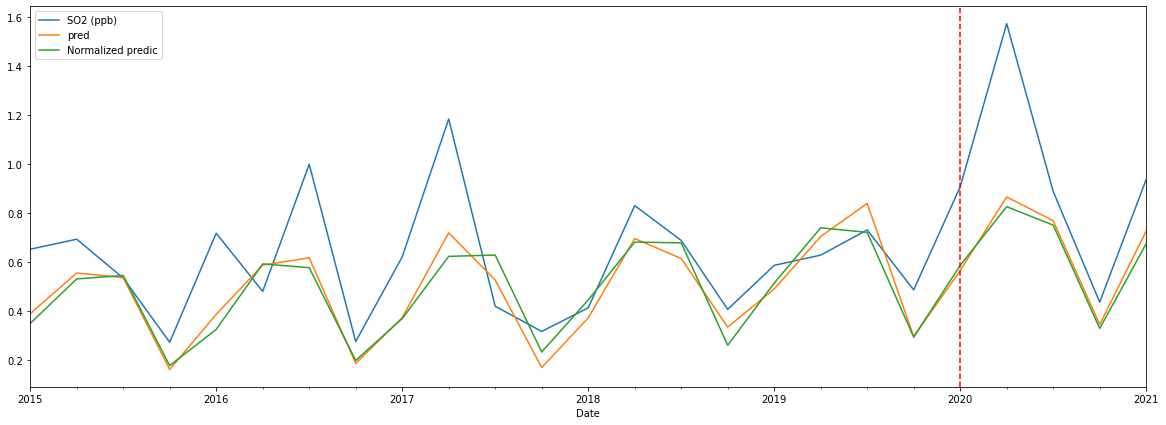

In [ ]:
z = np.array(z).reshape(-1,1)
# df3 = df2.copy()
df4_h['Normalized predic']= z
df4_D = df4_h.resample('D').mean()
df4_M = df4_h.resample('M').mean()
df4_h.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_2015_realRH_SO2_hourly_normalized_pred.csv')
df4_D.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_2015_realRH_SO2_Daily_normalized_pred.csv')
df4_M.to_csv('gdrive/My Drive/Colab Notebooks/Industrial/MildredLake/NN_BuffaloViewpoint_OT_2015_realRH_SO2_Monthly_normalized_pred.csv')


for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

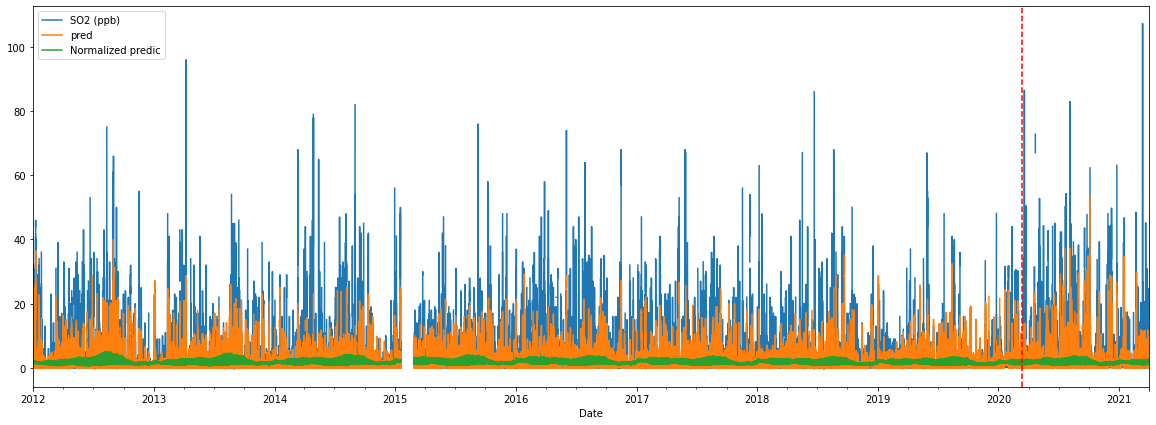

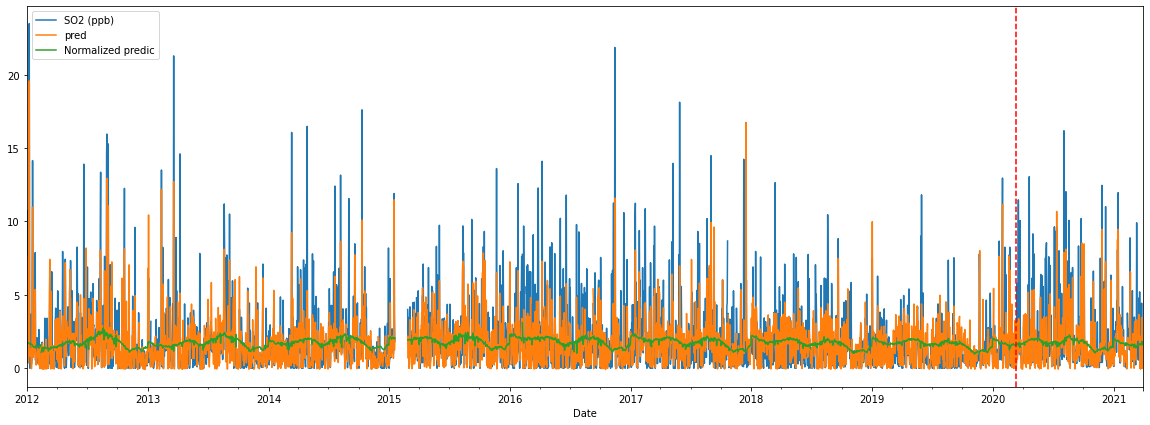

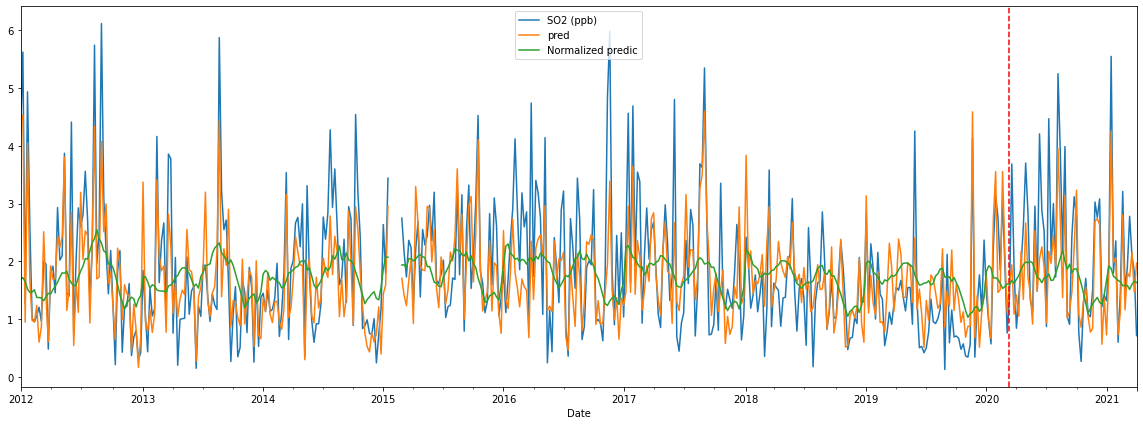

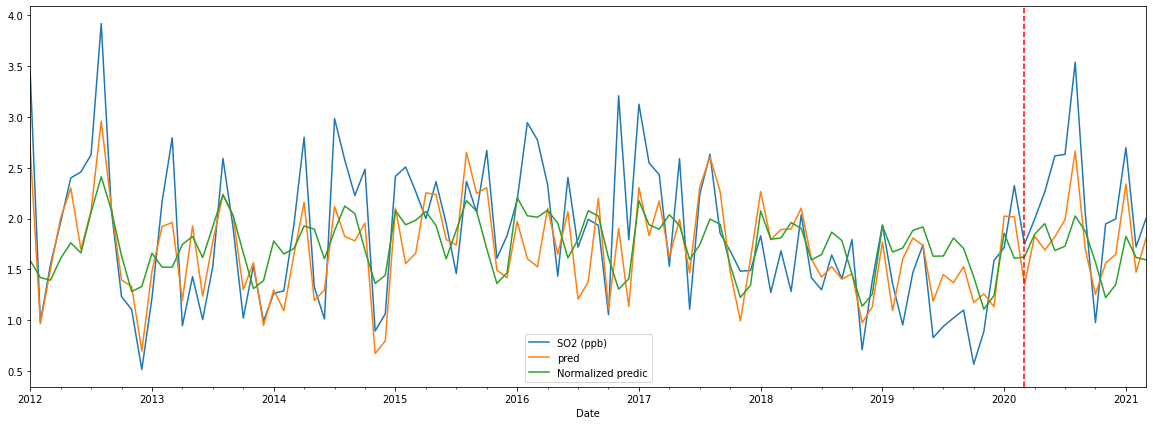

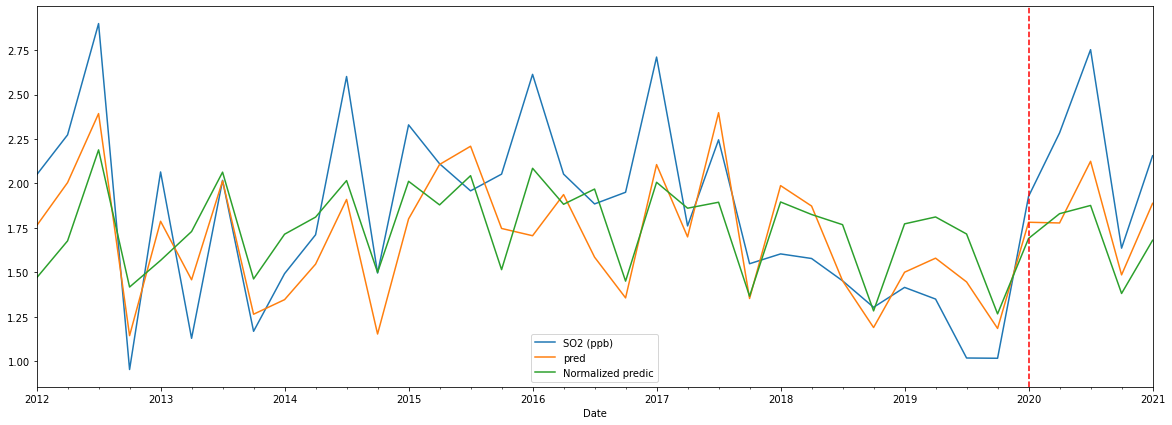

In [ ]:
for i in ['H','D','W','M','Q']:
    df4_h['SO2 (ppb)'].resample(i).mean().plot(legend= True)
    df4_h['pred'].resample(i).mean().plot(legend= True,figsize = (20,7))
    df4_h['Normalized predic'].resample(i).mean().plot(legend= True,figsize = (20,7))
    plt.axvline(x = '2020-03-11', color = 'red',linestyle ="--", label = 'axvline - full height') 
    plt.show()

In [ ]:
####